In [135]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
def load_japanese_data():
    return reshaped
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	#(trainX, _), (_, _) = load_data()
	trainX = load_japanese_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'D:/ganmnist/Ngenerated_plotX_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'D:/ganmnist/NgeneratorX_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
	filenameD = 'D:/ganmnist/NdiscrimnatorX_model_%03d.h5' % (epoch + 1)
	d_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
#train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=10)

In [136]:
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=10)

>1, 1/194, d=0.693, g=0.716
>1, 2/194, d=0.685, g=0.732
>1, 3/194, d=0.678, g=0.744
>1, 4/194, d=0.673, g=0.757
>1, 5/194, d=0.668, g=0.769
>1, 6/194, d=0.663, g=0.785
>1, 7/194, d=0.656, g=0.794
>1, 8/194, d=0.653, g=0.809
>1, 9/194, d=0.648, g=0.819
>1, 10/194, d=0.648, g=0.824
>1, 11/194, d=0.650, g=0.823
>1, 12/194, d=0.653, g=0.805
>1, 13/194, d=0.660, g=0.784
>1, 14/194, d=0.664, g=0.761
>1, 15/194, d=0.673, g=0.739
>1, 16/194, d=0.676, g=0.722
>1, 17/194, d=0.678, g=0.712
>1, 18/194, d=0.675, g=0.703
>1, 19/194, d=0.674, g=0.700
>1, 20/194, d=0.672, g=0.697
>1, 21/194, d=0.670, g=0.696
>1, 22/194, d=0.667, g=0.695
>1, 23/194, d=0.664, g=0.696
>1, 24/194, d=0.659, g=0.696
>1, 25/194, d=0.656, g=0.696
>1, 26/194, d=0.649, g=0.696
>1, 27/194, d=0.649, g=0.697
>1, 28/194, d=0.639, g=0.697
>1, 29/194, d=0.633, g=0.698
>1, 30/194, d=0.629, g=0.698
>1, 31/194, d=0.621, g=0.699
>1, 32/194, d=0.615, g=0.700
>1, 33/194, d=0.611, g=0.701
>1, 34/194, d=0.606, g=0.701
>1, 35/194, d=0.595, g=

>2, 87/194, d=0.466, g=0.910
>2, 88/194, d=0.463, g=0.864
>2, 89/194, d=0.474, g=0.876
>2, 90/194, d=0.480, g=0.882
>2, 91/194, d=0.509, g=0.853
>2, 92/194, d=0.532, g=0.824
>2, 93/194, d=0.526, g=0.802
>2, 94/194, d=0.571, g=0.736
>2, 95/194, d=0.651, g=0.699
>2, 96/194, d=0.692, g=0.646
>2, 97/194, d=0.765, g=0.611
>2, 98/194, d=0.843, g=0.582
>2, 99/194, d=0.873, g=0.651
>2, 100/194, d=0.876, g=0.694
>2, 101/194, d=0.875, g=0.753
>2, 102/194, d=0.924, g=0.777
>2, 103/194, d=0.940, g=0.762
>2, 104/194, d=0.985, g=0.724
>2, 105/194, d=0.992, g=0.709
>2, 106/194, d=0.983, g=0.694
>2, 107/194, d=1.017, g=0.704
>2, 108/194, d=1.047, g=0.719
>2, 109/194, d=1.015, g=0.753
>2, 110/194, d=0.990, g=0.806
>2, 111/194, d=0.973, g=0.823
>2, 112/194, d=0.935, g=0.849
>2, 113/194, d=0.955, g=0.846
>2, 114/194, d=0.930, g=0.838
>2, 115/194, d=0.921, g=0.859
>2, 116/194, d=0.926, g=0.812
>2, 117/194, d=0.883, g=0.822
>2, 118/194, d=0.875, g=0.819
>2, 119/194, d=0.846, g=0.810
>2, 120/194, d=0.841, g

>3, 171/194, d=0.692, g=0.738
>3, 172/194, d=0.697, g=0.728
>3, 173/194, d=0.685, g=0.738
>3, 174/194, d=0.669, g=0.736
>3, 175/194, d=0.691, g=0.741
>3, 176/194, d=0.687, g=0.739
>3, 177/194, d=0.671, g=0.743
>3, 178/194, d=0.663, g=0.729
>3, 179/194, d=0.669, g=0.736
>3, 180/194, d=0.677, g=0.743
>3, 181/194, d=0.657, g=0.745
>3, 182/194, d=0.667, g=0.729
>3, 183/194, d=0.665, g=0.742
>3, 184/194, d=0.679, g=0.744
>3, 185/194, d=0.670, g=0.750
>3, 186/194, d=0.661, g=0.759
>3, 187/194, d=0.666, g=0.766
>3, 188/194, d=0.671, g=0.769
>3, 189/194, d=0.663, g=0.769
>3, 190/194, d=0.679, g=0.764
>3, 191/194, d=0.657, g=0.772
>3, 192/194, d=0.679, g=0.758
>3, 193/194, d=0.656, g=0.769
>3, 194/194, d=0.671, g=0.752
>4, 1/194, d=0.671, g=0.771
>4, 2/194, d=0.684, g=0.762
>4, 3/194, d=0.675, g=0.737
>4, 4/194, d=0.694, g=0.747
>4, 5/194, d=0.685, g=0.734
>4, 6/194, d=0.679, g=0.738
>4, 7/194, d=0.683, g=0.732
>4, 8/194, d=0.702, g=0.751
>4, 9/194, d=0.680, g=0.732
>4, 10/194, d=0.688, g=0.744

>5, 63/194, d=0.614, g=0.725
>5, 64/194, d=0.610, g=0.720
>5, 65/194, d=0.619, g=0.719
>5, 66/194, d=0.613, g=0.715
>5, 67/194, d=0.622, g=0.726
>5, 68/194, d=0.611, g=0.725
>5, 69/194, d=0.601, g=0.750
>5, 70/194, d=0.601, g=0.754
>5, 71/194, d=0.591, g=0.770
>5, 72/194, d=0.590, g=0.780
>5, 73/194, d=0.585, g=0.801
>5, 74/194, d=0.583, g=0.805
>5, 75/194, d=0.576, g=0.807
>5, 76/194, d=0.573, g=0.821
>5, 77/194, d=0.572, g=0.810
>5, 78/194, d=0.569, g=0.817
>5, 79/194, d=0.572, g=0.819
>5, 80/194, d=0.568, g=0.811
>5, 81/194, d=0.586, g=0.804
>5, 82/194, d=0.594, g=0.788
>5, 83/194, d=0.605, g=0.747
>5, 84/194, d=0.654, g=0.717
>5, 85/194, d=0.688, g=0.672
>5, 86/194, d=0.728, g=0.677
>5, 87/194, d=0.730, g=0.744
>5, 88/194, d=0.717, g=0.863
>5, 89/194, d=0.701, g=0.941
>5, 90/194, d=0.692, g=0.922
>5, 91/194, d=0.715, g=0.858
>5, 92/194, d=0.728, g=0.811
>5, 93/194, d=0.755, g=0.761
>5, 94/194, d=0.752, g=0.737
>5, 95/194, d=0.759, g=0.711
>5, 96/194, d=0.760, g=0.679
>5, 97/194, d=

>6, 147/194, d=0.654, g=0.707
>6, 148/194, d=0.650, g=0.689
>6, 149/194, d=0.670, g=0.693
>6, 150/194, d=0.669, g=0.691
>6, 151/194, d=0.684, g=0.685
>6, 152/194, d=0.697, g=0.685
>6, 153/194, d=0.693, g=0.680
>6, 154/194, d=0.714, g=0.680
>6, 155/194, d=0.713, g=0.672
>6, 156/194, d=0.722, g=0.664
>6, 157/194, d=0.722, g=0.670
>6, 158/194, d=0.727, g=0.670
>6, 159/194, d=0.732, g=0.664
>6, 160/194, d=0.734, g=0.659
>6, 161/194, d=0.738, g=0.656
>6, 162/194, d=0.743, g=0.670
>6, 163/194, d=0.740, g=0.668
>6, 164/194, d=0.731, g=0.690
>6, 165/194, d=0.735, g=0.709
>6, 166/194, d=0.712, g=0.716
>6, 167/194, d=0.716, g=0.730
>6, 168/194, d=0.708, g=0.748
>6, 169/194, d=0.690, g=0.757
>6, 170/194, d=0.680, g=0.750
>6, 171/194, d=0.695, g=0.771
>6, 172/194, d=0.672, g=0.776
>6, 173/194, d=0.674, g=0.769
>6, 174/194, d=0.664, g=0.770
>6, 175/194, d=0.658, g=0.763
>6, 176/194, d=0.651, g=0.776
>6, 177/194, d=0.649, g=0.773
>6, 178/194, d=0.640, g=0.764
>6, 179/194, d=0.633, g=0.762
>6, 180/19

>8, 38/194, d=0.689, g=0.701
>8, 39/194, d=0.689, g=0.700
>8, 40/194, d=0.683, g=0.705
>8, 41/194, d=0.691, g=0.707
>8, 42/194, d=0.691, g=0.695
>8, 43/194, d=0.688, g=0.701
>8, 44/194, d=0.705, g=0.699
>8, 45/194, d=0.691, g=0.701
>8, 46/194, d=0.689, g=0.705
>8, 47/194, d=0.683, g=0.709
>8, 48/194, d=0.696, g=0.704
>8, 49/194, d=0.691, g=0.709
>8, 50/194, d=0.689, g=0.708
>8, 51/194, d=0.689, g=0.706
>8, 52/194, d=0.689, g=0.706
>8, 53/194, d=0.689, g=0.707
>8, 54/194, d=0.690, g=0.704
>8, 55/194, d=0.689, g=0.704
>8, 56/194, d=0.693, g=0.702
>8, 57/194, d=0.694, g=0.707
>8, 58/194, d=0.699, g=0.707
>8, 59/194, d=0.688, g=0.712
>8, 60/194, d=0.683, g=0.702
>8, 61/194, d=0.685, g=0.720
>8, 62/194, d=0.685, g=0.718
>8, 63/194, d=0.682, g=0.712
>8, 64/194, d=0.687, g=0.718
>8, 65/194, d=0.688, g=0.725
>8, 66/194, d=0.685, g=0.715
>8, 67/194, d=0.684, g=0.714
>8, 68/194, d=0.692, g=0.709
>8, 69/194, d=0.683, g=0.719
>8, 70/194, d=0.688, g=0.715
>8, 71/194, d=0.674, g=0.714
>8, 72/194, d=

>9, 123/194, d=0.695, g=0.700
>9, 124/194, d=0.688, g=0.699
>9, 125/194, d=0.692, g=0.702
>9, 126/194, d=0.693, g=0.703
>9, 127/194, d=0.693, g=0.696
>9, 128/194, d=0.695, g=0.700
>9, 129/194, d=0.696, g=0.701
>9, 130/194, d=0.694, g=0.700
>9, 131/194, d=0.690, g=0.702
>9, 132/194, d=0.693, g=0.701
>9, 133/194, d=0.701, g=0.698
>9, 134/194, d=0.698, g=0.703
>9, 135/194, d=0.704, g=0.705
>9, 136/194, d=0.696, g=0.700
>9, 137/194, d=0.703, g=0.694
>9, 138/194, d=0.704, g=0.693
>9, 139/194, d=0.692, g=0.694
>9, 140/194, d=0.682, g=0.691
>9, 141/194, d=0.691, g=0.697
>9, 142/194, d=0.697, g=0.694
>9, 143/194, d=0.700, g=0.699
>9, 144/194, d=0.697, g=0.705
>9, 145/194, d=0.703, g=0.699
>9, 146/194, d=0.703, g=0.694
>9, 147/194, d=0.696, g=0.702
>9, 148/194, d=0.697, g=0.694
>9, 149/194, d=0.699, g=0.697
>9, 150/194, d=0.692, g=0.705
>9, 151/194, d=0.686, g=0.702
>9, 152/194, d=0.698, g=0.703
>9, 153/194, d=0.690, g=0.705
>9, 154/194, d=0.690, g=0.702
>9, 155/194, d=0.693, g=0.707
>9, 156/19

In [46]:
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=100)

>1, 1/194, d=0.664, g=0.697
>1, 2/194, d=0.674, g=0.710
>1, 3/194, d=0.664, g=0.717
>1, 4/194, d=0.673, g=0.724
>1, 5/194, d=0.684, g=0.747
>1, 6/194, d=0.676, g=0.752
>1, 7/194, d=0.680, g=0.742
>1, 8/194, d=0.682, g=0.737
>1, 9/194, d=0.683, g=0.705
>1, 10/194, d=0.682, g=0.709
>1, 11/194, d=0.683, g=0.705
>1, 12/194, d=0.695, g=0.689
>1, 13/194, d=0.687, g=0.733
>1, 14/194, d=0.681, g=0.723
>1, 15/194, d=0.681, g=0.744
>1, 16/194, d=0.676, g=0.742
>1, 17/194, d=0.693, g=0.726
>1, 18/194, d=0.681, g=0.708
>1, 19/194, d=0.680, g=0.689
>1, 20/194, d=0.691, g=0.695
>1, 21/194, d=0.680, g=0.702
>1, 22/194, d=0.680, g=0.737
>1, 23/194, d=0.668, g=0.746
>1, 24/194, d=0.681, g=0.743
>1, 25/194, d=0.670, g=0.726
>1, 26/194, d=0.682, g=0.716
>1, 27/194, d=0.670, g=0.711
>1, 28/194, d=0.669, g=0.741
>1, 29/194, d=0.661, g=0.731
>1, 30/194, d=0.676, g=0.735
>1, 31/194, d=0.671, g=0.732
>1, 32/194, d=0.666, g=0.733
>1, 33/194, d=0.662, g=0.749
>1, 34/194, d=0.674, g=0.731
>1, 35/194, d=0.654, g=

>2, 87/194, d=0.676, g=0.734
>2, 88/194, d=0.673, g=0.727
>2, 89/194, d=0.682, g=0.712
>2, 90/194, d=0.676, g=0.701
>2, 91/194, d=0.677, g=0.709
>2, 92/194, d=0.664, g=0.708
>2, 93/194, d=0.672, g=0.715
>2, 94/194, d=0.675, g=0.714
>2, 95/194, d=0.674, g=0.715
>2, 96/194, d=0.686, g=0.699
>2, 97/194, d=0.671, g=0.713
>2, 98/194, d=0.683, g=0.725
>2, 99/194, d=0.682, g=0.758
>2, 100/194, d=0.673, g=0.735
>2, 101/194, d=0.674, g=0.718
>2, 102/194, d=0.673, g=0.708
>2, 103/194, d=0.677, g=0.708
>2, 104/194, d=0.684, g=0.735
>2, 105/194, d=0.670, g=0.758
>2, 106/194, d=0.681, g=0.739
>2, 107/194, d=0.674, g=0.713
>2, 108/194, d=0.672, g=0.696
>2, 109/194, d=0.685, g=0.684
>2, 110/194, d=0.679, g=0.722
>2, 111/194, d=0.678, g=0.732
>2, 112/194, d=0.680, g=0.735
>2, 113/194, d=0.680, g=0.708
>2, 114/194, d=0.682, g=0.708
>2, 115/194, d=0.670, g=0.686
>2, 116/194, d=0.682, g=0.716
>2, 117/194, d=0.687, g=0.735
>2, 118/194, d=0.680, g=0.750
>2, 119/194, d=0.685, g=0.729
>2, 120/194, d=0.670, g

>3, 171/194, d=0.678, g=0.700
>3, 172/194, d=0.673, g=0.710
>3, 173/194, d=0.673, g=0.740
>3, 174/194, d=0.676, g=0.748
>3, 175/194, d=0.680, g=0.720
>3, 176/194, d=0.682, g=0.699
>3, 177/194, d=0.677, g=0.685
>3, 178/194, d=0.690, g=0.718
>3, 179/194, d=0.679, g=0.750
>3, 180/194, d=0.674, g=0.751
>3, 181/194, d=0.680, g=0.724
>3, 182/194, d=0.684, g=0.727
>3, 183/194, d=0.678, g=0.711
>3, 184/194, d=0.677, g=0.728
>3, 185/194, d=0.666, g=0.732
>3, 186/194, d=0.683, g=0.725
>3, 187/194, d=0.683, g=0.705
>3, 188/194, d=0.677, g=0.700
>3, 189/194, d=0.680, g=0.699
>3, 190/194, d=0.685, g=0.734
>3, 191/194, d=0.675, g=0.748
>3, 192/194, d=0.670, g=0.733
>3, 193/194, d=0.675, g=0.719
>3, 194/194, d=0.677, g=0.691
>4, 1/194, d=0.687, g=0.693
>4, 2/194, d=0.676, g=0.722
>4, 3/194, d=0.675, g=0.756
>4, 4/194, d=0.694, g=0.740
>4, 5/194, d=0.680, g=0.697
>4, 6/194, d=0.689, g=0.679
>4, 7/194, d=0.686, g=0.692
>4, 8/194, d=0.679, g=0.758
>4, 9/194, d=0.694, g=0.779
>4, 10/194, d=0.672, g=0.738

>5, 63/194, d=0.683, g=0.726
>5, 64/194, d=0.682, g=0.723
>5, 65/194, d=0.671, g=0.736
>5, 66/194, d=0.677, g=0.715
>5, 67/194, d=0.671, g=0.700
>5, 68/194, d=0.684, g=0.705
>5, 69/194, d=0.672, g=0.716
>5, 70/194, d=0.683, g=0.704
>5, 71/194, d=0.669, g=0.713
>5, 72/194, d=0.679, g=0.733
>5, 73/194, d=0.682, g=0.716
>5, 74/194, d=0.675, g=0.723
>5, 75/194, d=0.683, g=0.720
>5, 76/194, d=0.682, g=0.746
>5, 77/194, d=0.672, g=0.723
>5, 78/194, d=0.676, g=0.700
>5, 79/194, d=0.676, g=0.712
>5, 80/194, d=0.689, g=0.722
>5, 81/194, d=0.689, g=0.766
>5, 82/194, d=0.674, g=0.751
>5, 83/194, d=0.682, g=0.710
>5, 84/194, d=0.677, g=0.691
>5, 85/194, d=0.681, g=0.699
>5, 86/194, d=0.679, g=0.744
>5, 87/194, d=0.669, g=0.776
>5, 88/194, d=0.676, g=0.747
>5, 89/194, d=0.678, g=0.710
>5, 90/194, d=0.689, g=0.690
>5, 91/194, d=0.680, g=0.703
>5, 92/194, d=0.671, g=0.732
>5, 93/194, d=0.683, g=0.734
>5, 94/194, d=0.672, g=0.742
>5, 95/194, d=0.689, g=0.721
>5, 96/194, d=0.689, g=0.714
>5, 97/194, d=

>6, 147/194, d=0.675, g=0.745
>6, 148/194, d=0.673, g=0.749
>6, 149/194, d=0.669, g=0.735
>6, 150/194, d=0.685, g=0.706
>6, 151/194, d=0.673, g=0.696
>6, 152/194, d=0.682, g=0.694
>6, 153/194, d=0.684, g=0.701
>6, 154/194, d=0.681, g=0.744
>6, 155/194, d=0.674, g=0.758
>6, 156/194, d=0.677, g=0.741
>6, 157/194, d=0.666, g=0.709
>6, 158/194, d=0.667, g=0.706
>6, 159/194, d=0.678, g=0.724
>6, 160/194, d=0.692, g=0.728
>6, 161/194, d=0.676, g=0.729
>6, 162/194, d=0.669, g=0.718
>6, 163/194, d=0.679, g=0.700
>6, 164/194, d=0.690, g=0.711
>6, 165/194, d=0.684, g=0.739
>6, 166/194, d=0.679, g=0.742
>6, 167/194, d=0.690, g=0.708
>6, 168/194, d=0.682, g=0.683
>6, 169/194, d=0.680, g=0.696
>6, 170/194, d=0.672, g=0.734
>6, 171/194, d=0.691, g=0.766
>6, 172/194, d=0.686, g=0.761
>6, 173/194, d=0.672, g=0.709
>6, 174/194, d=0.682, g=0.680
>6, 175/194, d=0.684, g=0.679
>6, 176/194, d=0.687, g=0.730
>6, 177/194, d=0.684, g=0.791
>6, 178/194, d=0.680, g=0.771
>6, 179/194, d=0.688, g=0.727
>6, 180/19

>8, 38/194, d=0.693, g=0.698
>8, 39/194, d=0.685, g=0.758
>8, 40/194, d=0.675, g=0.751
>8, 41/194, d=0.674, g=0.716
>8, 42/194, d=0.676, g=0.685
>8, 43/194, d=0.685, g=0.697
>8, 44/194, d=0.685, g=0.719
>8, 45/194, d=0.680, g=0.734
>8, 46/194, d=0.680, g=0.716
>8, 47/194, d=0.688, g=0.706
>8, 48/194, d=0.685, g=0.699
>8, 49/194, d=0.692, g=0.708
>8, 50/194, d=0.683, g=0.714
>8, 51/194, d=0.685, g=0.709
>8, 52/194, d=0.674, g=0.731
>8, 53/194, d=0.686, g=0.720
>8, 54/194, d=0.682, g=0.724
>8, 55/194, d=0.682, g=0.731
>8, 56/194, d=0.681, g=0.707
>8, 57/194, d=0.669, g=0.710
>8, 58/194, d=0.683, g=0.713
>8, 59/194, d=0.688, g=0.731
>8, 60/194, d=0.682, g=0.743
>8, 61/194, d=0.677, g=0.709
>8, 62/194, d=0.676, g=0.723
>8, 63/194, d=0.680, g=0.700
>8, 64/194, d=0.670, g=0.738
>8, 65/194, d=0.685, g=0.739
>8, 66/194, d=0.679, g=0.716
>8, 67/194, d=0.684, g=0.697
>8, 68/194, d=0.676, g=0.713
>8, 69/194, d=0.681, g=0.705
>8, 70/194, d=0.689, g=0.713
>8, 71/194, d=0.677, g=0.721
>8, 72/194, d=

>9, 123/194, d=0.670, g=0.669
>9, 124/194, d=0.671, g=0.715
>9, 125/194, d=0.685, g=0.770
>9, 126/194, d=0.693, g=0.756
>9, 127/194, d=0.686, g=0.727
>9, 128/194, d=0.671, g=0.678
>9, 129/194, d=0.673, g=0.671
>9, 130/194, d=0.689, g=0.742
>9, 131/194, d=0.678, g=0.777
>9, 132/194, d=0.686, g=0.781
>9, 133/194, d=0.682, g=0.713
>9, 134/194, d=0.693, g=0.677
>9, 135/194, d=0.677, g=0.682
>9, 136/194, d=0.692, g=0.747
>9, 137/194, d=0.690, g=0.774
>9, 138/194, d=0.683, g=0.713
>9, 139/194, d=0.679, g=0.717
>9, 140/194, d=0.679, g=0.686
>9, 141/194, d=0.673, g=0.710
>9, 142/194, d=0.681, g=0.745
>9, 143/194, d=0.678, g=0.752
>9, 144/194, d=0.689, g=0.724
>9, 145/194, d=0.682, g=0.686
>9, 146/194, d=0.688, g=0.691
>9, 147/194, d=0.673, g=0.711
>9, 148/194, d=0.700, g=0.761
>9, 149/194, d=0.691, g=0.732
>9, 150/194, d=0.676, g=0.716
>9, 151/194, d=0.681, g=0.709
>9, 152/194, d=0.688, g=0.698
>9, 153/194, d=0.680, g=0.707
>9, 154/194, d=0.686, g=0.748
>9, 155/194, d=0.677, g=0.731
>9, 156/19

>11, 5/194, d=0.697, g=0.722
>11, 6/194, d=0.685, g=0.694
>11, 7/194, d=0.670, g=0.707
>11, 8/194, d=0.686, g=0.721
>11, 9/194, d=0.666, g=0.714
>11, 10/194, d=0.669, g=0.721
>11, 11/194, d=0.683, g=0.734
>11, 12/194, d=0.691, g=0.730
>11, 13/194, d=0.677, g=0.722
>11, 14/194, d=0.696, g=0.725
>11, 15/194, d=0.664, g=0.713
>11, 16/194, d=0.679, g=0.730
>11, 17/194, d=0.670, g=0.736
>11, 18/194, d=0.671, g=0.718
>11, 19/194, d=0.694, g=0.720
>11, 20/194, d=0.681, g=0.711
>11, 21/194, d=0.684, g=0.706
>11, 22/194, d=0.679, g=0.704
>11, 23/194, d=0.693, g=0.705
>11, 24/194, d=0.668, g=0.725
>11, 25/194, d=0.678, g=0.715
>11, 26/194, d=0.675, g=0.720
>11, 27/194, d=0.689, g=0.724
>11, 28/194, d=0.676, g=0.713
>11, 29/194, d=0.690, g=0.728
>11, 30/194, d=0.682, g=0.739
>11, 31/194, d=0.687, g=0.724
>11, 32/194, d=0.678, g=0.719
>11, 33/194, d=0.676, g=0.727
>11, 34/194, d=0.685, g=0.722
>11, 35/194, d=0.683, g=0.718
>11, 36/194, d=0.685, g=0.723
>11, 37/194, d=0.685, g=0.713
>11, 38/194, d=

>12, 82/194, d=0.681, g=0.730
>12, 83/194, d=0.677, g=0.703
>12, 84/194, d=0.673, g=0.692
>12, 85/194, d=0.684, g=0.715
>12, 86/194, d=0.667, g=0.722
>12, 87/194, d=0.677, g=0.708
>12, 88/194, d=0.681, g=0.714
>12, 89/194, d=0.683, g=0.730
>12, 90/194, d=0.672, g=0.726
>12, 91/194, d=0.671, g=0.720
>12, 92/194, d=0.695, g=0.716
>12, 93/194, d=0.680, g=0.715
>12, 94/194, d=0.683, g=0.711
>12, 95/194, d=0.679, g=0.710
>12, 96/194, d=0.686, g=0.716
>12, 97/194, d=0.700, g=0.730
>12, 98/194, d=0.679, g=0.734
>12, 99/194, d=0.678, g=0.737
>12, 100/194, d=0.671, g=0.717
>12, 101/194, d=0.684, g=0.696
>12, 102/194, d=0.683, g=0.694
>12, 103/194, d=0.696, g=0.742
>12, 104/194, d=0.691, g=0.730
>12, 105/194, d=0.686, g=0.709
>12, 106/194, d=0.681, g=0.669
>12, 107/194, d=0.673, g=0.729
>12, 108/194, d=0.676, g=0.731
>12, 109/194, d=0.685, g=0.731
>12, 110/194, d=0.683, g=0.727
>12, 111/194, d=0.685, g=0.725
>12, 112/194, d=0.687, g=0.714
>12, 113/194, d=0.690, g=0.709
>12, 114/194, d=0.696, g=0

>13, 157/194, d=0.665, g=0.716
>13, 158/194, d=0.681, g=0.714
>13, 159/194, d=0.689, g=0.767
>13, 160/194, d=0.680, g=0.716
>13, 161/194, d=0.674, g=0.708
>13, 162/194, d=0.673, g=0.716
>13, 163/194, d=0.685, g=0.715
>13, 164/194, d=0.673, g=0.753
>13, 165/194, d=0.679, g=0.737
>13, 166/194, d=0.689, g=0.701
>13, 167/194, d=0.670, g=0.701
>13, 168/194, d=0.700, g=0.716
>13, 169/194, d=0.671, g=0.751
>13, 170/194, d=0.673, g=0.752
>13, 171/194, d=0.679, g=0.722
>13, 172/194, d=0.684, g=0.718
>13, 173/194, d=0.681, g=0.701
>13, 174/194, d=0.682, g=0.738
>13, 175/194, d=0.675, g=0.748
>13, 176/194, d=0.677, g=0.715
>13, 177/194, d=0.673, g=0.692
>13, 178/194, d=0.692, g=0.698
>13, 179/194, d=0.683, g=0.704
>13, 180/194, d=0.673, g=0.731
>13, 181/194, d=0.688, g=0.715
>13, 182/194, d=0.679, g=0.712
>13, 183/194, d=0.681, g=0.749
>13, 184/194, d=0.688, g=0.735
>13, 185/194, d=0.667, g=0.716
>13, 186/194, d=0.672, g=0.684
>13, 187/194, d=0.682, g=0.716
>13, 188/194, d=0.693, g=0.737
>13, 189

>15, 39/194, d=0.688, g=0.709
>15, 40/194, d=0.672, g=0.742
>15, 41/194, d=0.685, g=0.733
>15, 42/194, d=0.676, g=0.710
>15, 43/194, d=0.683, g=0.698
>15, 44/194, d=0.685, g=0.746
>15, 45/194, d=0.682, g=0.758
>15, 46/194, d=0.669, g=0.726
>15, 47/194, d=0.673, g=0.695
>15, 48/194, d=0.676, g=0.682
>15, 49/194, d=0.685, g=0.720
>15, 50/194, d=0.687, g=0.748
>15, 51/194, d=0.685, g=0.752
>15, 52/194, d=0.676, g=0.719
>15, 53/194, d=0.687, g=0.688
>15, 54/194, d=0.689, g=0.714
>15, 55/194, d=0.669, g=0.725
>15, 56/194, d=0.680, g=0.734
>15, 57/194, d=0.684, g=0.727
>15, 58/194, d=0.677, g=0.727
>15, 59/194, d=0.672, g=0.686
>15, 60/194, d=0.676, g=0.685
>15, 61/194, d=0.690, g=0.724
>15, 62/194, d=0.671, g=0.765
>15, 63/194, d=0.688, g=0.732
>15, 64/194, d=0.671, g=0.717
>15, 65/194, d=0.674, g=0.701
>15, 66/194, d=0.681, g=0.712
>15, 67/194, d=0.673, g=0.721
>15, 68/194, d=0.685, g=0.712
>15, 69/194, d=0.671, g=0.724
>15, 70/194, d=0.680, g=0.733
>15, 71/194, d=0.669, g=0.717
>15, 72/19

>16, 115/194, d=0.675, g=0.727
>16, 116/194, d=0.683, g=0.774
>16, 117/194, d=0.679, g=0.759
>16, 118/194, d=0.674, g=0.700
>16, 119/194, d=0.686, g=0.685
>16, 120/194, d=0.674, g=0.697
>16, 121/194, d=0.683, g=0.792
>16, 122/194, d=0.682, g=0.747
>16, 123/194, d=0.678, g=0.720
>16, 124/194, d=0.676, g=0.694
>16, 125/194, d=0.672, g=0.710
>16, 126/194, d=0.681, g=0.724
>16, 127/194, d=0.678, g=0.725
>16, 128/194, d=0.699, g=0.709
>16, 129/194, d=0.667, g=0.695
>16, 130/194, d=0.662, g=0.723
>16, 131/194, d=0.684, g=0.770
>16, 132/194, d=0.691, g=0.728
>16, 133/194, d=0.684, g=0.686
>16, 134/194, d=0.670, g=0.697
>16, 135/194, d=0.686, g=0.735
>16, 136/194, d=0.669, g=0.764
>16, 137/194, d=0.679, g=0.730
>16, 138/194, d=0.682, g=0.710
>16, 139/194, d=0.676, g=0.698
>16, 140/194, d=0.675, g=0.710
>16, 141/194, d=0.674, g=0.722
>16, 142/194, d=0.671, g=0.719
>16, 143/194, d=0.698, g=0.690
>16, 144/194, d=0.682, g=0.699
>16, 145/194, d=0.695, g=0.725
>16, 146/194, d=0.684, g=0.770
>16, 147

>17, 189/194, d=0.672, g=0.731
>17, 190/194, d=0.684, g=0.737
>17, 191/194, d=0.687, g=0.722
>17, 192/194, d=0.686, g=0.676
>17, 193/194, d=0.678, g=0.710
>17, 194/194, d=0.664, g=0.738
>18, 1/194, d=0.682, g=0.739
>18, 2/194, d=0.692, g=0.717
>18, 3/194, d=0.682, g=0.695
>18, 4/194, d=0.690, g=0.704
>18, 5/194, d=0.681, g=0.743
>18, 6/194, d=0.681, g=0.736
>18, 7/194, d=0.685, g=0.709
>18, 8/194, d=0.675, g=0.681
>18, 9/194, d=0.678, g=0.724
>18, 10/194, d=0.682, g=0.773
>18, 11/194, d=0.676, g=0.726
>18, 12/194, d=0.681, g=0.704
>18, 13/194, d=0.682, g=0.702
>18, 14/194, d=0.688, g=0.751
>18, 15/194, d=0.688, g=0.747
>18, 16/194, d=0.679, g=0.730
>18, 17/194, d=0.680, g=0.717
>18, 18/194, d=0.673, g=0.730
>18, 19/194, d=0.684, g=0.735
>18, 20/194, d=0.683, g=0.733
>18, 21/194, d=0.682, g=0.695
>18, 22/194, d=0.691, g=0.664
>18, 23/194, d=0.682, g=0.717
>18, 24/194, d=0.676, g=0.770
>18, 25/194, d=0.670, g=0.740
>18, 26/194, d=0.688, g=0.689
>18, 27/194, d=0.689, g=0.683
>18, 28/194, 

>19, 72/194, d=0.683, g=0.720
>19, 73/194, d=0.688, g=0.697
>19, 74/194, d=0.684, g=0.708
>19, 75/194, d=0.682, g=0.760
>19, 76/194, d=0.675, g=0.771
>19, 77/194, d=0.689, g=0.713
>19, 78/194, d=0.692, g=0.689
>19, 79/194, d=0.674, g=0.714
>19, 80/194, d=0.689, g=0.752
>19, 81/194, d=0.682, g=0.741
>19, 82/194, d=0.685, g=0.691
>19, 83/194, d=0.671, g=0.692
>19, 84/194, d=0.681, g=0.697
>19, 85/194, d=0.671, g=0.750
>19, 86/194, d=0.681, g=0.765
>19, 87/194, d=0.688, g=0.743
>19, 88/194, d=0.687, g=0.689
>19, 89/194, d=0.682, g=0.699
>19, 90/194, d=0.694, g=0.754
>19, 91/194, d=0.683, g=0.758
>19, 92/194, d=0.680, g=0.712
>19, 93/194, d=0.679, g=0.683
>19, 94/194, d=0.678, g=0.678
>19, 95/194, d=0.683, g=0.711
>19, 96/194, d=0.684, g=0.754
>19, 97/194, d=0.685, g=0.752
>19, 98/194, d=0.686, g=0.722
>19, 99/194, d=0.694, g=0.700
>19, 100/194, d=0.686, g=0.697
>19, 101/194, d=0.684, g=0.744
>19, 102/194, d=0.691, g=0.728
>19, 103/194, d=0.688, g=0.737
>19, 104/194, d=0.663, g=0.722
>19, 

>20, 147/194, d=0.674, g=0.747
>20, 148/194, d=0.680, g=0.735
>20, 149/194, d=0.683, g=0.740
>20, 150/194, d=0.668, g=0.707
>20, 151/194, d=0.689, g=0.721
>20, 152/194, d=0.686, g=0.737
>20, 153/194, d=0.684, g=0.741
>20, 154/194, d=0.684, g=0.722
>20, 155/194, d=0.674, g=0.673
>20, 156/194, d=0.697, g=0.716
>20, 157/194, d=0.677, g=0.761
>20, 158/194, d=0.694, g=0.723
>20, 159/194, d=0.681, g=0.686
>20, 160/194, d=0.695, g=0.701
>20, 161/194, d=0.688, g=0.715
>20, 162/194, d=0.676, g=0.720
>20, 163/194, d=0.690, g=0.716
>20, 164/194, d=0.682, g=0.703
>20, 165/194, d=0.687, g=0.715
>20, 166/194, d=0.683, g=0.754
>20, 167/194, d=0.686, g=0.719
>20, 168/194, d=0.684, g=0.746
>20, 169/194, d=0.682, g=0.721
>20, 170/194, d=0.678, g=0.695
>20, 171/194, d=0.673, g=0.705
>20, 172/194, d=0.676, g=0.731
>20, 173/194, d=0.671, g=0.717
>20, 174/194, d=0.675, g=0.727
>20, 175/194, d=0.683, g=0.716
>20, 176/194, d=0.680, g=0.743
>20, 177/194, d=0.671, g=0.739
>20, 178/194, d=0.674, g=0.705
>20, 179

>22, 27/194, d=0.679, g=0.703
>22, 28/194, d=0.682, g=0.662
>22, 29/194, d=0.677, g=0.704
>22, 30/194, d=0.678, g=0.774
>22, 31/194, d=0.686, g=0.752
>22, 32/194, d=0.678, g=0.706
>22, 33/194, d=0.682, g=0.716
>22, 34/194, d=0.682, g=0.740
>22, 35/194, d=0.671, g=0.731
>22, 36/194, d=0.683, g=0.723
>22, 37/194, d=0.687, g=0.714
>22, 38/194, d=0.685, g=0.720
>22, 39/194, d=0.668, g=0.725
>22, 40/194, d=0.678, g=0.724
>22, 41/194, d=0.679, g=0.699
>22, 42/194, d=0.675, g=0.710
>22, 43/194, d=0.683, g=0.731
>22, 44/194, d=0.685, g=0.724
>22, 45/194, d=0.680, g=0.700
>22, 46/194, d=0.678, g=0.710
>22, 47/194, d=0.683, g=0.731
>22, 48/194, d=0.682, g=0.735
>22, 49/194, d=0.674, g=0.721
>22, 50/194, d=0.668, g=0.721
>22, 51/194, d=0.669, g=0.744
>22, 52/194, d=0.677, g=0.741
>22, 53/194, d=0.687, g=0.722
>22, 54/194, d=0.685, g=0.701
>22, 55/194, d=0.676, g=0.700
>22, 56/194, d=0.673, g=0.725
>22, 57/194, d=0.679, g=0.751
>22, 58/194, d=0.686, g=0.730
>22, 59/194, d=0.695, g=0.721
>22, 60/19

>23, 104/194, d=0.693, g=0.745
>23, 105/194, d=0.682, g=0.692
>23, 106/194, d=0.681, g=0.668
>23, 107/194, d=0.692, g=0.728
>23, 108/194, d=0.682, g=0.777
>23, 109/194, d=0.686, g=0.731
>23, 110/194, d=0.672, g=0.688
>23, 111/194, d=0.671, g=0.684
>23, 112/194, d=0.686, g=0.776
>23, 113/194, d=0.683, g=0.791
>23, 114/194, d=0.684, g=0.685
>23, 115/194, d=0.666, g=0.651
>23, 116/194, d=0.683, g=0.677
>23, 117/194, d=0.678, g=0.748
>23, 118/194, d=0.684, g=0.775
>23, 119/194, d=0.677, g=0.722
>23, 120/194, d=0.686, g=0.681
>23, 121/194, d=0.680, g=0.695
>23, 122/194, d=0.685, g=0.725
>23, 123/194, d=0.689, g=0.758
>23, 124/194, d=0.674, g=0.720
>23, 125/194, d=0.674, g=0.693
>23, 126/194, d=0.686, g=0.707
>23, 127/194, d=0.690, g=0.721
>23, 128/194, d=0.677, g=0.721
>23, 129/194, d=0.681, g=0.713
>23, 130/194, d=0.680, g=0.704
>23, 131/194, d=0.671, g=0.749
>23, 132/194, d=0.674, g=0.776
>23, 133/194, d=0.683, g=0.740
>23, 134/194, d=0.680, g=0.702
>23, 135/194, d=0.685, g=0.718
>23, 136

>24, 178/194, d=0.669, g=0.727
>24, 179/194, d=0.681, g=0.727
>24, 180/194, d=0.693, g=0.718
>24, 181/194, d=0.686, g=0.708
>24, 182/194, d=0.674, g=0.737
>24, 183/194, d=0.678, g=0.727
>24, 184/194, d=0.678, g=0.725
>24, 185/194, d=0.677, g=0.728
>24, 186/194, d=0.679, g=0.706
>24, 187/194, d=0.687, g=0.698
>24, 188/194, d=0.682, g=0.725
>24, 189/194, d=0.681, g=0.741
>24, 190/194, d=0.695, g=0.701
>24, 191/194, d=0.687, g=0.707
>24, 192/194, d=0.672, g=0.719
>24, 193/194, d=0.670, g=0.715
>24, 194/194, d=0.680, g=0.732
>25, 1/194, d=0.679, g=0.727
>25, 2/194, d=0.669, g=0.739
>25, 3/194, d=0.679, g=0.701
>25, 4/194, d=0.673, g=0.708
>25, 5/194, d=0.671, g=0.727
>25, 6/194, d=0.683, g=0.739
>25, 7/194, d=0.684, g=0.734
>25, 8/194, d=0.680, g=0.721
>25, 9/194, d=0.676, g=0.730
>25, 10/194, d=0.677, g=0.711
>25, 11/194, d=0.669, g=0.728
>25, 12/194, d=0.684, g=0.724
>25, 13/194, d=0.685, g=0.708
>25, 14/194, d=0.687, g=0.690
>25, 15/194, d=0.691, g=0.729
>25, 16/194, d=0.672, g=0.769
>2

>26, 60/194, d=0.678, g=0.697
>26, 61/194, d=0.679, g=0.727
>26, 62/194, d=0.684, g=0.750
>26, 63/194, d=0.683, g=0.700
>26, 64/194, d=0.671, g=0.703
>26, 65/194, d=0.682, g=0.753
>26, 66/194, d=0.673, g=0.728
>26, 67/194, d=0.687, g=0.712
>26, 68/194, d=0.675, g=0.716
>26, 69/194, d=0.681, g=0.717
>26, 70/194, d=0.684, g=0.720
>26, 71/194, d=0.698, g=0.732
>26, 72/194, d=0.680, g=0.729
>26, 73/194, d=0.691, g=0.719
>26, 74/194, d=0.675, g=0.709
>26, 75/194, d=0.672, g=0.701
>26, 76/194, d=0.687, g=0.718
>26, 77/194, d=0.685, g=0.767
>26, 78/194, d=0.686, g=0.740
>26, 79/194, d=0.684, g=0.691
>26, 80/194, d=0.692, g=0.717
>26, 81/194, d=0.695, g=0.742
>26, 82/194, d=0.679, g=0.728
>26, 83/194, d=0.683, g=0.683
>26, 84/194, d=0.690, g=0.713
>26, 85/194, d=0.685, g=0.736
>26, 86/194, d=0.682, g=0.744
>26, 87/194, d=0.681, g=0.707
>26, 88/194, d=0.673, g=0.699
>26, 89/194, d=0.680, g=0.727
>26, 90/194, d=0.673, g=0.726
>26, 91/194, d=0.683, g=0.727
>26, 92/194, d=0.675, g=0.692
>26, 93/19

>27, 136/194, d=0.692, g=0.697
>27, 137/194, d=0.692, g=0.728
>27, 138/194, d=0.672, g=0.761
>27, 139/194, d=0.683, g=0.715
>27, 140/194, d=0.676, g=0.690
>27, 141/194, d=0.697, g=0.719
>27, 142/194, d=0.682, g=0.729
>27, 143/194, d=0.690, g=0.715
>27, 144/194, d=0.688, g=0.694
>27, 145/194, d=0.681, g=0.719
>27, 146/194, d=0.685, g=0.721
>27, 147/194, d=0.674, g=0.739
>27, 148/194, d=0.686, g=0.730
>27, 149/194, d=0.679, g=0.718
>27, 150/194, d=0.671, g=0.711
>27, 151/194, d=0.692, g=0.731
>27, 152/194, d=0.691, g=0.719
>27, 153/194, d=0.675, g=0.696
>27, 154/194, d=0.666, g=0.695
>27, 155/194, d=0.690, g=0.736
>27, 156/194, d=0.678, g=0.732
>27, 157/194, d=0.674, g=0.722
>27, 158/194, d=0.694, g=0.726
>27, 159/194, d=0.687, g=0.746
>27, 160/194, d=0.688, g=0.739
>27, 161/194, d=0.673, g=0.704
>27, 162/194, d=0.677, g=0.689
>27, 163/194, d=0.680, g=0.714
>27, 164/194, d=0.679, g=0.717
>27, 165/194, d=0.677, g=0.726
>27, 166/194, d=0.698, g=0.716
>27, 167/194, d=0.666, g=0.717
>27, 168

>29, 17/194, d=0.678, g=0.757
>29, 18/194, d=0.688, g=0.727
>29, 19/194, d=0.690, g=0.679
>29, 20/194, d=0.688, g=0.707
>29, 21/194, d=0.678, g=0.750
>29, 22/194, d=0.696, g=0.735
>29, 23/194, d=0.668, g=0.687
>29, 24/194, d=0.683, g=0.692
>29, 25/194, d=0.681, g=0.755
>29, 26/194, d=0.667, g=0.739
>29, 27/194, d=0.675, g=0.700
>29, 28/194, d=0.687, g=0.686
>29, 29/194, d=0.680, g=0.730
>29, 30/194, d=0.675, g=0.750
>29, 31/194, d=0.681, g=0.745
>29, 32/194, d=0.686, g=0.726
>29, 33/194, d=0.674, g=0.730
>29, 34/194, d=0.676, g=0.736
>29, 35/194, d=0.686, g=0.733
>29, 36/194, d=0.677, g=0.729
>29, 37/194, d=0.681, g=0.732
>29, 38/194, d=0.683, g=0.711
>29, 39/194, d=0.697, g=0.704
>29, 40/194, d=0.697, g=0.725
>29, 41/194, d=0.689, g=0.744
>29, 42/194, d=0.689, g=0.701
>29, 43/194, d=0.697, g=0.714
>29, 44/194, d=0.684, g=0.729
>29, 45/194, d=0.671, g=0.740
>29, 46/194, d=0.683, g=0.678
>29, 47/194, d=0.686, g=0.705
>29, 48/194, d=0.688, g=0.745
>29, 49/194, d=0.691, g=0.726
>29, 50/19

>30, 94/194, d=0.693, g=0.726
>30, 95/194, d=0.683, g=0.723
>30, 96/194, d=0.687, g=0.703
>30, 97/194, d=0.686, g=0.678
>30, 98/194, d=0.687, g=0.707
>30, 99/194, d=0.677, g=0.731
>30, 100/194, d=0.676, g=0.734
>30, 101/194, d=0.687, g=0.704
>30, 102/194, d=0.690, g=0.713
>30, 103/194, d=0.684, g=0.707
>30, 104/194, d=0.688, g=0.732
>30, 105/194, d=0.683, g=0.728
>30, 106/194, d=0.692, g=0.680
>30, 107/194, d=0.685, g=0.683
>30, 108/194, d=0.677, g=0.721
>30, 109/194, d=0.678, g=0.756
>30, 110/194, d=0.678, g=0.730
>30, 111/194, d=0.701, g=0.687
>30, 112/194, d=0.684, g=0.695
>30, 113/194, d=0.681, g=0.736
>30, 114/194, d=0.668, g=0.729
>30, 115/194, d=0.679, g=0.690
>30, 116/194, d=0.677, g=0.702
>30, 117/194, d=0.675, g=0.750
>30, 118/194, d=0.679, g=0.731
>30, 119/194, d=0.691, g=0.718
>30, 120/194, d=0.670, g=0.724
>30, 121/194, d=0.696, g=0.768
>30, 122/194, d=0.679, g=0.741
>30, 123/194, d=0.686, g=0.663
>30, 124/194, d=0.681, g=0.707
>30, 125/194, d=0.689, g=0.736
>30, 126/194, 

>31, 167/194, d=0.687, g=0.700
>31, 168/194, d=0.686, g=0.703
>31, 169/194, d=0.681, g=0.716
>31, 170/194, d=0.682, g=0.740
>31, 171/194, d=0.689, g=0.706
>31, 172/194, d=0.677, g=0.685
>31, 173/194, d=0.682, g=0.716
>31, 174/194, d=0.678, g=0.730
>31, 175/194, d=0.684, g=0.725
>31, 176/194, d=0.682, g=0.706
>31, 177/194, d=0.687, g=0.739
>31, 178/194, d=0.674, g=0.717
>31, 179/194, d=0.683, g=0.660
>31, 180/194, d=0.687, g=0.716
>31, 181/194, d=0.686, g=0.764
>31, 182/194, d=0.682, g=0.728
>31, 183/194, d=0.695, g=0.674
>31, 184/194, d=0.688, g=0.738
>31, 185/194, d=0.690, g=0.761
>31, 186/194, d=0.673, g=0.709
>31, 187/194, d=0.677, g=0.691
>31, 188/194, d=0.702, g=0.720
>31, 189/194, d=0.681, g=0.746
>31, 190/194, d=0.683, g=0.738
>31, 191/194, d=0.679, g=0.704
>31, 192/194, d=0.701, g=0.716
>31, 193/194, d=0.680, g=0.714
>31, 194/194, d=0.685, g=0.738
>32, 1/194, d=0.682, g=0.702
>32, 2/194, d=0.675, g=0.687
>32, 3/194, d=0.682, g=0.717
>32, 4/194, d=0.675, g=0.717
>32, 5/194, d=0.

>33, 49/194, d=0.682, g=0.702
>33, 50/194, d=0.693, g=0.749
>33, 51/194, d=0.676, g=0.728
>33, 52/194, d=0.681, g=0.716
>33, 53/194, d=0.678, g=0.722
>33, 54/194, d=0.682, g=0.722
>33, 55/194, d=0.679, g=0.729
>33, 56/194, d=0.683, g=0.705
>33, 57/194, d=0.686, g=0.727
>33, 58/194, d=0.665, g=0.755
>33, 59/194, d=0.674, g=0.721
>33, 60/194, d=0.689, g=0.701
>33, 61/194, d=0.677, g=0.721
>33, 62/194, d=0.674, g=0.749
>33, 63/194, d=0.682, g=0.752
>33, 64/194, d=0.687, g=0.723
>33, 65/194, d=0.687, g=0.682
>33, 66/194, d=0.686, g=0.708
>33, 67/194, d=0.691, g=0.713
>33, 68/194, d=0.694, g=0.720
>33, 69/194, d=0.687, g=0.720
>33, 70/194, d=0.679, g=0.713
>33, 71/194, d=0.680, g=0.722
>33, 72/194, d=0.666, g=0.707
>33, 73/194, d=0.687, g=0.730
>33, 74/194, d=0.698, g=0.746
>33, 75/194, d=0.683, g=0.706
>33, 76/194, d=0.676, g=0.702
>33, 77/194, d=0.688, g=0.743
>33, 78/194, d=0.691, g=0.707
>33, 79/194, d=0.671, g=0.698
>33, 80/194, d=0.693, g=0.720
>33, 81/194, d=0.686, g=0.695
>33, 82/19

>34, 125/194, d=0.695, g=0.710
>34, 126/194, d=0.690, g=0.731
>34, 127/194, d=0.689, g=0.714
>34, 128/194, d=0.674, g=0.729
>34, 129/194, d=0.686, g=0.727
>34, 130/194, d=0.698, g=0.705
>34, 131/194, d=0.674, g=0.730
>34, 132/194, d=0.685, g=0.730
>34, 133/194, d=0.677, g=0.736
>34, 134/194, d=0.702, g=0.717
>34, 135/194, d=0.686, g=0.712
>34, 136/194, d=0.709, g=0.718
>34, 137/194, d=0.681, g=0.722
>34, 138/194, d=0.691, g=0.733
>34, 139/194, d=0.677, g=0.744
>34, 140/194, d=0.678, g=0.740
>34, 141/194, d=0.689, g=0.717
>34, 142/194, d=0.669, g=0.689
>34, 143/194, d=0.693, g=0.700
>34, 144/194, d=0.683, g=0.725
>34, 145/194, d=0.676, g=0.745
>34, 146/194, d=0.681, g=0.737
>34, 147/194, d=0.678, g=0.685
>34, 148/194, d=0.687, g=0.699
>34, 149/194, d=0.695, g=0.717
>34, 150/194, d=0.691, g=0.706
>34, 151/194, d=0.684, g=0.714
>34, 152/194, d=0.679, g=0.707
>34, 153/194, d=0.690, g=0.712
>34, 154/194, d=0.683, g=0.717
>34, 155/194, d=0.680, g=0.729
>34, 156/194, d=0.680, g=0.759
>34, 157

>36, 6/194, d=0.686, g=0.699
>36, 7/194, d=0.680, g=0.715
>36, 8/194, d=0.699, g=0.741
>36, 9/194, d=0.689, g=0.744
>36, 10/194, d=0.697, g=0.714
>36, 11/194, d=0.680, g=0.691
>36, 12/194, d=0.688, g=0.719
>36, 13/194, d=0.680, g=0.721
>36, 14/194, d=0.688, g=0.719
>36, 15/194, d=0.684, g=0.712
>36, 16/194, d=0.683, g=0.726
>36, 17/194, d=0.678, g=0.723
>36, 18/194, d=0.689, g=0.699
>36, 19/194, d=0.688, g=0.725
>36, 20/194, d=0.685, g=0.724
>36, 21/194, d=0.682, g=0.710
>36, 22/194, d=0.678, g=0.709
>36, 23/194, d=0.695, g=0.712
>36, 24/194, d=0.692, g=0.731
>36, 25/194, d=0.682, g=0.724
>36, 26/194, d=0.688, g=0.706
>36, 27/194, d=0.687, g=0.717
>36, 28/194, d=0.683, g=0.709
>36, 29/194, d=0.682, g=0.728
>36, 30/194, d=0.689, g=0.711
>36, 31/194, d=0.684, g=0.710
>36, 32/194, d=0.686, g=0.719
>36, 33/194, d=0.687, g=0.709
>36, 34/194, d=0.688, g=0.702
>36, 35/194, d=0.686, g=0.729
>36, 36/194, d=0.683, g=0.720
>36, 37/194, d=0.697, g=0.699
>36, 38/194, d=0.682, g=0.695
>36, 39/194, d

>37, 83/194, d=0.693, g=0.710
>37, 84/194, d=0.683, g=0.700
>37, 85/194, d=0.672, g=0.720
>37, 86/194, d=0.693, g=0.719
>37, 87/194, d=0.680, g=0.720
>37, 88/194, d=0.679, g=0.718
>37, 89/194, d=0.692, g=0.730
>37, 90/194, d=0.681, g=0.721
>37, 91/194, d=0.678, g=0.689
>37, 92/194, d=0.685, g=0.712
>37, 93/194, d=0.674, g=0.746
>37, 94/194, d=0.688, g=0.741
>37, 95/194, d=0.679, g=0.696
>37, 96/194, d=0.678, g=0.705
>37, 97/194, d=0.686, g=0.714
>37, 98/194, d=0.684, g=0.692
>37, 99/194, d=0.678, g=0.719
>37, 100/194, d=0.692, g=0.730
>37, 101/194, d=0.696, g=0.704
>37, 102/194, d=0.685, g=0.698
>37, 103/194, d=0.690, g=0.727
>37, 104/194, d=0.673, g=0.738
>37, 105/194, d=0.688, g=0.712
>37, 106/194, d=0.687, g=0.701
>37, 107/194, d=0.685, g=0.697
>37, 108/194, d=0.678, g=0.733
>37, 109/194, d=0.681, g=0.735
>37, 110/194, d=0.689, g=0.733
>37, 111/194, d=0.694, g=0.706
>37, 112/194, d=0.679, g=0.711
>37, 113/194, d=0.678, g=0.737
>37, 114/194, d=0.674, g=0.731
>37, 115/194, d=0.684, g=

>38, 158/194, d=0.686, g=0.734
>38, 159/194, d=0.688, g=0.735
>38, 160/194, d=0.691, g=0.709
>38, 161/194, d=0.684, g=0.720
>38, 162/194, d=0.678, g=0.718
>38, 163/194, d=0.686, g=0.708
>38, 164/194, d=0.683, g=0.734
>38, 165/194, d=0.694, g=0.706
>38, 166/194, d=0.689, g=0.709
>38, 167/194, d=0.684, g=0.710
>38, 168/194, d=0.692, g=0.698
>38, 169/194, d=0.691, g=0.736
>38, 170/194, d=0.691, g=0.718
>38, 171/194, d=0.687, g=0.695
>38, 172/194, d=0.678, g=0.717
>38, 173/194, d=0.692, g=0.740
>38, 174/194, d=0.685, g=0.722
>38, 175/194, d=0.688, g=0.708
>38, 176/194, d=0.692, g=0.717
>38, 177/194, d=0.682, g=0.754
>38, 178/194, d=0.688, g=0.711
>38, 179/194, d=0.663, g=0.706
>38, 180/194, d=0.680, g=0.706
>38, 181/194, d=0.679, g=0.719
>38, 182/194, d=0.682, g=0.706
>38, 183/194, d=0.678, g=0.720
>38, 184/194, d=0.681, g=0.723
>38, 185/194, d=0.680, g=0.713
>38, 186/194, d=0.690, g=0.706
>38, 187/194, d=0.687, g=0.712
>38, 188/194, d=0.680, g=0.725
>38, 189/194, d=0.693, g=0.709
>38, 190

>40, 40/194, d=0.698, g=0.708
>40, 41/194, d=0.678, g=0.695
>40, 42/194, d=0.695, g=0.712
>40, 43/194, d=0.687, g=0.710
>40, 44/194, d=0.682, g=0.702
>40, 45/194, d=0.679, g=0.691
>40, 46/194, d=0.690, g=0.706
>40, 47/194, d=0.681, g=0.698
>40, 48/194, d=0.689, g=0.698
>40, 49/194, d=0.689, g=0.742
>40, 50/194, d=0.688, g=0.741
>40, 51/194, d=0.684, g=0.707
>40, 52/194, d=0.677, g=0.690
>40, 53/194, d=0.690, g=0.727
>40, 54/194, d=0.690, g=0.746
>40, 55/194, d=0.691, g=0.735
>40, 56/194, d=0.692, g=0.712
>40, 57/194, d=0.686, g=0.699
>40, 58/194, d=0.692, g=0.724
>40, 59/194, d=0.681, g=0.715
>40, 60/194, d=0.678, g=0.698
>40, 61/194, d=0.685, g=0.724
>40, 62/194, d=0.693, g=0.753
>40, 63/194, d=0.690, g=0.712
>40, 64/194, d=0.687, g=0.699
>40, 65/194, d=0.679, g=0.685
>40, 66/194, d=0.683, g=0.712
>40, 67/194, d=0.687, g=0.726
>40, 68/194, d=0.688, g=0.710
>40, 69/194, d=0.696, g=0.730
>40, 70/194, d=0.700, g=0.740
>40, 71/194, d=0.677, g=0.736
>40, 72/194, d=0.686, g=0.721
>40, 73/19

>41, 115/194, d=0.679, g=0.708
>41, 116/194, d=0.685, g=0.713
>41, 117/194, d=0.690, g=0.708
>41, 118/194, d=0.678, g=0.698
>41, 119/194, d=0.682, g=0.695
>41, 120/194, d=0.686, g=0.686
>41, 121/194, d=0.692, g=0.737
>41, 122/194, d=0.684, g=0.737
>41, 123/194, d=0.688, g=0.725
>41, 124/194, d=0.680, g=0.692
>41, 125/194, d=0.686, g=0.702
>41, 126/194, d=0.674, g=0.713
>41, 127/194, d=0.678, g=0.724
>41, 128/194, d=0.689, g=0.715
>41, 129/194, d=0.681, g=0.711
>41, 130/194, d=0.674, g=0.747
>41, 131/194, d=0.695, g=0.749
>41, 132/194, d=0.681, g=0.738
>41, 133/194, d=0.692, g=0.700
>41, 134/194, d=0.684, g=0.703
>41, 135/194, d=0.676, g=0.697
>41, 136/194, d=0.686, g=0.693
>41, 137/194, d=0.673, g=0.705
>41, 138/194, d=0.694, g=0.730
>41, 139/194, d=0.689, g=0.707
>41, 140/194, d=0.683, g=0.717
>41, 141/194, d=0.682, g=0.719
>41, 142/194, d=0.679, g=0.724
>41, 143/194, d=0.679, g=0.710
>41, 144/194, d=0.677, g=0.722
>41, 145/194, d=0.689, g=0.710
>41, 146/194, d=0.686, g=0.709
>41, 147

>42, 189/194, d=0.682, g=0.699
>42, 190/194, d=0.688, g=0.675
>42, 191/194, d=0.696, g=0.701
>42, 192/194, d=0.693, g=0.737
>42, 193/194, d=0.685, g=0.705
>42, 194/194, d=0.686, g=0.709
>43, 1/194, d=0.692, g=0.724
>43, 2/194, d=0.690, g=0.724
>43, 3/194, d=0.691, g=0.694
>43, 4/194, d=0.689, g=0.698
>43, 5/194, d=0.688, g=0.736
>43, 6/194, d=0.675, g=0.742
>43, 7/194, d=0.680, g=0.712
>43, 8/194, d=0.676, g=0.705
>43, 9/194, d=0.677, g=0.713
>43, 10/194, d=0.696, g=0.699
>43, 11/194, d=0.697, g=0.711
>43, 12/194, d=0.684, g=0.703
>43, 13/194, d=0.683, g=0.710
>43, 14/194, d=0.686, g=0.742
>43, 15/194, d=0.687, g=0.719
>43, 16/194, d=0.683, g=0.695
>43, 17/194, d=0.677, g=0.708
>43, 18/194, d=0.693, g=0.729
>43, 19/194, d=0.691, g=0.722
>43, 20/194, d=0.690, g=0.711
>43, 21/194, d=0.685, g=0.714
>43, 22/194, d=0.668, g=0.705
>43, 23/194, d=0.689, g=0.715
>43, 24/194, d=0.687, g=0.713
>43, 25/194, d=0.688, g=0.711
>43, 26/194, d=0.687, g=0.705
>43, 27/194, d=0.683, g=0.715
>43, 28/194, 

>44, 72/194, d=0.691, g=0.707
>44, 73/194, d=0.684, g=0.706
>44, 74/194, d=0.688, g=0.716
>44, 75/194, d=0.690, g=0.710
>44, 76/194, d=0.684, g=0.721
>44, 77/194, d=0.690, g=0.721
>44, 78/194, d=0.691, g=0.701
>44, 79/194, d=0.684, g=0.702
>44, 80/194, d=0.689, g=0.713
>44, 81/194, d=0.687, g=0.726
>44, 82/194, d=0.689, g=0.721
>44, 83/194, d=0.678, g=0.716
>44, 84/194, d=0.674, g=0.725
>44, 85/194, d=0.700, g=0.723
>44, 86/194, d=0.688, g=0.724
>44, 87/194, d=0.674, g=0.714
>44, 88/194, d=0.679, g=0.710
>44, 89/194, d=0.680, g=0.695
>44, 90/194, d=0.684, g=0.699
>44, 91/194, d=0.687, g=0.736
>44, 92/194, d=0.691, g=0.729
>44, 93/194, d=0.682, g=0.717
>44, 94/194, d=0.685, g=0.694
>44, 95/194, d=0.684, g=0.697
>44, 96/194, d=0.696, g=0.715
>44, 97/194, d=0.685, g=0.729
>44, 98/194, d=0.676, g=0.701
>44, 99/194, d=0.680, g=0.701
>44, 100/194, d=0.680, g=0.704
>44, 101/194, d=0.678, g=0.723
>44, 102/194, d=0.692, g=0.762
>44, 103/194, d=0.687, g=0.707
>44, 104/194, d=0.693, g=0.689
>44, 

>45, 147/194, d=0.683, g=0.720
>45, 148/194, d=0.687, g=0.709
>45, 149/194, d=0.686, g=0.682
>45, 150/194, d=0.685, g=0.727
>45, 151/194, d=0.692, g=0.740
>45, 152/194, d=0.684, g=0.747
>45, 153/194, d=0.682, g=0.715
>45, 154/194, d=0.679, g=0.685
>45, 155/194, d=0.688, g=0.701
>45, 156/194, d=0.683, g=0.743
>45, 157/194, d=0.695, g=0.728
>45, 158/194, d=0.687, g=0.698
>45, 159/194, d=0.696, g=0.698
>45, 160/194, d=0.690, g=0.724
>45, 161/194, d=0.689, g=0.739
>45, 162/194, d=0.685, g=0.719
>45, 163/194, d=0.687, g=0.687
>45, 164/194, d=0.692, g=0.713
>45, 165/194, d=0.686, g=0.718
>45, 166/194, d=0.683, g=0.720
>45, 167/194, d=0.682, g=0.736
>45, 168/194, d=0.683, g=0.697
>45, 169/194, d=0.686, g=0.701
>45, 170/194, d=0.692, g=0.695
>45, 171/194, d=0.694, g=0.727
>45, 172/194, d=0.686, g=0.724
>45, 173/194, d=0.691, g=0.705
>45, 174/194, d=0.672, g=0.701
>45, 175/194, d=0.694, g=0.730
>45, 176/194, d=0.699, g=0.744
>45, 177/194, d=0.683, g=0.717
>45, 178/194, d=0.678, g=0.680
>45, 179

>47, 28/194, d=0.674, g=0.704
>47, 29/194, d=0.693, g=0.715
>47, 30/194, d=0.691, g=0.722
>47, 31/194, d=0.675, g=0.708
>47, 32/194, d=0.691, g=0.705
>47, 33/194, d=0.670, g=0.730
>47, 34/194, d=0.695, g=0.730
>47, 35/194, d=0.685, g=0.701
>47, 36/194, d=0.680, g=0.696
>47, 37/194, d=0.676, g=0.705
>47, 38/194, d=0.688, g=0.728
>47, 39/194, d=0.682, g=0.706
>47, 40/194, d=0.686, g=0.710
>47, 41/194, d=0.695, g=0.727
>47, 42/194, d=0.688, g=0.709
>47, 43/194, d=0.679, g=0.692
>47, 44/194, d=0.694, g=0.706
>47, 45/194, d=0.678, g=0.723
>47, 46/194, d=0.687, g=0.722
>47, 47/194, d=0.681, g=0.697
>47, 48/194, d=0.677, g=0.687
>47, 49/194, d=0.687, g=0.699
>47, 50/194, d=0.681, g=0.723
>47, 51/194, d=0.684, g=0.711
>47, 52/194, d=0.678, g=0.703
>47, 53/194, d=0.688, g=0.671
>47, 54/194, d=0.684, g=0.711
>47, 55/194, d=0.691, g=0.735
>47, 56/194, d=0.691, g=0.726
>47, 57/194, d=0.687, g=0.730
>47, 58/194, d=0.681, g=0.711
>47, 59/194, d=0.684, g=0.705
>47, 60/194, d=0.689, g=0.720
>47, 61/19

>48, 105/194, d=0.672, g=0.695
>48, 106/194, d=0.685, g=0.744
>48, 107/194, d=0.677, g=0.752
>48, 108/194, d=0.686, g=0.706
>48, 109/194, d=0.694, g=0.682
>48, 110/194, d=0.689, g=0.711
>48, 111/194, d=0.682, g=0.745
>48, 112/194, d=0.682, g=0.707
>48, 113/194, d=0.681, g=0.702
>48, 114/194, d=0.680, g=0.709
>48, 115/194, d=0.688, g=0.730
>48, 116/194, d=0.677, g=0.721
>48, 117/194, d=0.688, g=0.732
>48, 118/194, d=0.691, g=0.708
>48, 119/194, d=0.681, g=0.677
>48, 120/194, d=0.683, g=0.699
>48, 121/194, d=0.673, g=0.708
>48, 122/194, d=0.686, g=0.715
>48, 123/194, d=0.681, g=0.717
>48, 124/194, d=0.687, g=0.710
>48, 125/194, d=0.679, g=0.720
>48, 126/194, d=0.681, g=0.702
>48, 127/194, d=0.676, g=0.697
>48, 128/194, d=0.679, g=0.712
>48, 129/194, d=0.694, g=0.723
>48, 130/194, d=0.695, g=0.711
>48, 131/194, d=0.679, g=0.724
>48, 132/194, d=0.694, g=0.700
>48, 133/194, d=0.680, g=0.694
>48, 134/194, d=0.683, g=0.708
>48, 135/194, d=0.688, g=0.726
>48, 136/194, d=0.691, g=0.742
>48, 137

>49, 179/194, d=0.680, g=0.720
>49, 180/194, d=0.676, g=0.706
>49, 181/194, d=0.689, g=0.708
>49, 182/194, d=0.685, g=0.696
>49, 183/194, d=0.699, g=0.715
>49, 184/194, d=0.687, g=0.719
>49, 185/194, d=0.683, g=0.713
>49, 186/194, d=0.682, g=0.689
>49, 187/194, d=0.678, g=0.710
>49, 188/194, d=0.687, g=0.733
>49, 189/194, d=0.688, g=0.730
>49, 190/194, d=0.683, g=0.698
>49, 191/194, d=0.676, g=0.702
>49, 192/194, d=0.673, g=0.730
>49, 193/194, d=0.684, g=0.723
>49, 194/194, d=0.684, g=0.713
>50, 1/194, d=0.686, g=0.697
>50, 2/194, d=0.686, g=0.731
>50, 3/194, d=0.685, g=0.729
>50, 4/194, d=0.676, g=0.719
>50, 5/194, d=0.689, g=0.703
>50, 6/194, d=0.692, g=0.696
>50, 7/194, d=0.685, g=0.723
>50, 8/194, d=0.689, g=0.715
>50, 9/194, d=0.688, g=0.690
>50, 10/194, d=0.678, g=0.699
>50, 11/194, d=0.693, g=0.700
>50, 12/194, d=0.687, g=0.757
>50, 13/194, d=0.677, g=0.724
>50, 14/194, d=0.691, g=0.719
>50, 15/194, d=0.698, g=0.724
>50, 16/194, d=0.681, g=0.715
>50, 17/194, d=0.679, g=0.691
>50

>51, 60/194, d=0.685, g=0.719
>51, 61/194, d=0.699, g=0.727
>51, 62/194, d=0.693, g=0.716
>51, 63/194, d=0.687, g=0.720
>51, 64/194, d=0.681, g=0.701
>51, 65/194, d=0.682, g=0.710
>51, 66/194, d=0.690, g=0.716
>51, 67/194, d=0.685, g=0.711
>51, 68/194, d=0.670, g=0.709
>51, 69/194, d=0.686, g=0.715
>51, 70/194, d=0.698, g=0.735
>51, 71/194, d=0.697, g=0.708
>51, 72/194, d=0.682, g=0.693
>51, 73/194, d=0.679, g=0.704
>51, 74/194, d=0.692, g=0.699
>51, 75/194, d=0.678, g=0.724
>51, 76/194, d=0.679, g=0.726
>51, 77/194, d=0.684, g=0.709
>51, 78/194, d=0.681, g=0.696
>51, 79/194, d=0.676, g=0.706
>51, 80/194, d=0.681, g=0.724
>51, 81/194, d=0.688, g=0.719
>51, 82/194, d=0.693, g=0.702
>51, 83/194, d=0.687, g=0.724
>51, 84/194, d=0.690, g=0.701
>51, 85/194, d=0.684, g=0.707
>51, 86/194, d=0.684, g=0.722
>51, 87/194, d=0.686, g=0.740
>51, 88/194, d=0.677, g=0.715
>51, 89/194, d=0.676, g=0.710
>51, 90/194, d=0.674, g=0.728
>51, 91/194, d=0.692, g=0.715
>51, 92/194, d=0.687, g=0.717
>51, 93/19

>52, 136/194, d=0.684, g=0.742
>52, 137/194, d=0.687, g=0.737
>52, 138/194, d=0.697, g=0.717
>52, 139/194, d=0.687, g=0.714
>52, 140/194, d=0.677, g=0.694
>52, 141/194, d=0.690, g=0.721
>52, 142/194, d=0.680, g=0.731
>52, 143/194, d=0.690, g=0.714
>52, 144/194, d=0.691, g=0.711
>52, 145/194, d=0.692, g=0.727
>52, 146/194, d=0.694, g=0.695
>52, 147/194, d=0.679, g=0.718
>52, 148/194, d=0.686, g=0.717
>52, 149/194, d=0.679, g=0.699
>52, 150/194, d=0.686, g=0.710
>52, 151/194, d=0.681, g=0.713
>52, 152/194, d=0.683, g=0.710
>52, 153/194, d=0.694, g=0.678
>52, 154/194, d=0.681, g=0.723
>52, 155/194, d=0.683, g=0.733
>52, 156/194, d=0.688, g=0.715
>52, 157/194, d=0.685, g=0.676
>52, 158/194, d=0.686, g=0.688
>52, 159/194, d=0.692, g=0.724
>52, 160/194, d=0.685, g=0.718
>52, 161/194, d=0.687, g=0.713
>52, 162/194, d=0.675, g=0.718
>52, 163/194, d=0.691, g=0.704
>52, 164/194, d=0.675, g=0.701
>52, 165/194, d=0.680, g=0.713
>52, 166/194, d=0.697, g=0.708
>52, 167/194, d=0.687, g=0.696
>52, 168

>54, 17/194, d=0.690, g=0.710
>54, 18/194, d=0.678, g=0.704
>54, 19/194, d=0.666, g=0.727
>54, 20/194, d=0.688, g=0.734
>54, 21/194, d=0.687, g=0.705
>54, 22/194, d=0.689, g=0.715
>54, 23/194, d=0.682, g=0.709
>54, 24/194, d=0.681, g=0.697
>54, 25/194, d=0.682, g=0.715
>54, 26/194, d=0.682, g=0.709
>54, 27/194, d=0.686, g=0.707
>54, 28/194, d=0.690, g=0.709
>54, 29/194, d=0.691, g=0.714
>54, 30/194, d=0.670, g=0.698
>54, 31/194, d=0.675, g=0.709
>54, 32/194, d=0.679, g=0.728
>54, 33/194, d=0.677, g=0.725
>54, 34/194, d=0.692, g=0.714
>54, 35/194, d=0.683, g=0.703
>54, 36/194, d=0.684, g=0.702
>54, 37/194, d=0.688, g=0.703
>54, 38/194, d=0.686, g=0.725
>54, 39/194, d=0.678, g=0.710
>54, 40/194, d=0.665, g=0.709
>54, 41/194, d=0.683, g=0.713
>54, 42/194, d=0.691, g=0.705
>54, 43/194, d=0.693, g=0.701
>54, 44/194, d=0.682, g=0.704
>54, 45/194, d=0.695, g=0.724
>54, 46/194, d=0.693, g=0.710
>54, 47/194, d=0.692, g=0.693
>54, 48/194, d=0.691, g=0.702
>54, 49/194, d=0.683, g=0.728
>54, 50/19

>55, 94/194, d=0.682, g=0.703
>55, 95/194, d=0.694, g=0.709
>55, 96/194, d=0.692, g=0.722
>55, 97/194, d=0.685, g=0.717
>55, 98/194, d=0.689, g=0.716
>55, 99/194, d=0.683, g=0.705
>55, 100/194, d=0.684, g=0.717
>55, 101/194, d=0.693, g=0.745
>55, 102/194, d=0.681, g=0.726
>55, 103/194, d=0.685, g=0.666
>55, 104/194, d=0.686, g=0.699
>55, 105/194, d=0.692, g=0.747
>55, 106/194, d=0.689, g=0.718
>55, 107/194, d=0.679, g=0.697
>55, 108/194, d=0.692, g=0.690
>55, 109/194, d=0.689, g=0.716
>55, 110/194, d=0.691, g=0.742
>55, 111/194, d=0.689, g=0.709
>55, 112/194, d=0.689, g=0.692
>55, 113/194, d=0.696, g=0.709
>55, 114/194, d=0.681, g=0.714
>55, 115/194, d=0.685, g=0.718
>55, 116/194, d=0.686, g=0.723
>55, 117/194, d=0.686, g=0.701
>55, 118/194, d=0.683, g=0.708
>55, 119/194, d=0.678, g=0.723
>55, 120/194, d=0.682, g=0.708
>55, 121/194, d=0.680, g=0.717
>55, 122/194, d=0.694, g=0.742
>55, 123/194, d=0.682, g=0.732
>55, 124/194, d=0.681, g=0.704
>55, 125/194, d=0.700, g=0.693
>55, 126/194, 

>56, 168/194, d=0.683, g=0.726
>56, 169/194, d=0.680, g=0.725
>56, 170/194, d=0.680, g=0.703
>56, 171/194, d=0.679, g=0.703
>56, 172/194, d=0.694, g=0.736
>56, 173/194, d=0.684, g=0.753
>56, 174/194, d=0.679, g=0.705
>56, 175/194, d=0.684, g=0.698
>56, 176/194, d=0.682, g=0.693
>56, 177/194, d=0.677, g=0.733
>56, 178/194, d=0.695, g=0.716
>56, 179/194, d=0.686, g=0.695
>56, 180/194, d=0.676, g=0.692
>56, 181/194, d=0.681, g=0.701
>56, 182/194, d=0.694, g=0.717
>56, 183/194, d=0.681, g=0.714
>56, 184/194, d=0.697, g=0.710
>56, 185/194, d=0.687, g=0.738
>56, 186/194, d=0.686, g=0.714
>56, 187/194, d=0.687, g=0.716
>56, 188/194, d=0.695, g=0.686
>56, 189/194, d=0.682, g=0.709
>56, 190/194, d=0.689, g=0.704
>56, 191/194, d=0.693, g=0.717
>56, 192/194, d=0.684, g=0.702
>56, 193/194, d=0.681, g=0.699
>56, 194/194, d=0.692, g=0.717
>57, 1/194, d=0.694, g=0.718
>57, 2/194, d=0.678, g=0.709
>57, 3/194, d=0.681, g=0.690
>57, 4/194, d=0.679, g=0.721
>57, 5/194, d=0.693, g=0.752
>57, 6/194, d=0.68

>58, 50/194, d=0.693, g=0.689
>58, 51/194, d=0.683, g=0.689
>58, 52/194, d=0.687, g=0.706
>58, 53/194, d=0.683, g=0.727
>58, 54/194, d=0.692, g=0.719
>58, 55/194, d=0.683, g=0.707
>58, 56/194, d=0.673, g=0.701
>58, 57/194, d=0.685, g=0.703
>58, 58/194, d=0.683, g=0.714
>58, 59/194, d=0.692, g=0.732
>58, 60/194, d=0.676, g=0.703
>58, 61/194, d=0.693, g=0.689
>58, 62/194, d=0.676, g=0.720
>58, 63/194, d=0.681, g=0.731
>58, 64/194, d=0.691, g=0.709
>58, 65/194, d=0.681, g=0.692
>58, 66/194, d=0.696, g=0.696
>58, 67/194, d=0.679, g=0.725
>58, 68/194, d=0.694, g=0.725
>58, 69/194, d=0.686, g=0.709
>58, 70/194, d=0.680, g=0.696
>58, 71/194, d=0.684, g=0.714
>58, 72/194, d=0.674, g=0.708
>58, 73/194, d=0.685, g=0.697
>58, 74/194, d=0.688, g=0.711
>58, 75/194, d=0.679, g=0.732
>58, 76/194, d=0.692, g=0.726
>58, 77/194, d=0.693, g=0.695
>58, 78/194, d=0.699, g=0.708
>58, 79/194, d=0.684, g=0.715
>58, 80/194, d=0.688, g=0.736
>58, 81/194, d=0.683, g=0.716
>58, 82/194, d=0.691, g=0.706
>58, 83/19

>59, 126/194, d=0.672, g=0.697
>59, 127/194, d=0.682, g=0.719
>59, 128/194, d=0.681, g=0.712
>59, 129/194, d=0.697, g=0.706
>59, 130/194, d=0.674, g=0.707
>59, 131/194, d=0.675, g=0.682
>59, 132/194, d=0.710, g=0.725
>59, 133/194, d=0.678, g=0.727
>59, 134/194, d=0.683, g=0.711
>59, 135/194, d=0.685, g=0.689
>59, 136/194, d=0.694, g=0.711
>59, 137/194, d=0.673, g=0.703
>59, 138/194, d=0.677, g=0.714
>59, 139/194, d=0.682, g=0.727
>59, 140/194, d=0.684, g=0.730
>59, 141/194, d=0.684, g=0.718
>59, 142/194, d=0.690, g=0.700
>59, 143/194, d=0.699, g=0.711
>59, 144/194, d=0.691, g=0.734
>59, 145/194, d=0.687, g=0.715
>59, 146/194, d=0.683, g=0.689
>59, 147/194, d=0.677, g=0.684
>59, 148/194, d=0.685, g=0.745
>59, 149/194, d=0.685, g=0.720
>59, 150/194, d=0.680, g=0.690
>59, 151/194, d=0.681, g=0.696
>59, 152/194, d=0.696, g=0.723
>59, 153/194, d=0.680, g=0.713
>59, 154/194, d=0.697, g=0.720
>59, 155/194, d=0.685, g=0.716
>59, 156/194, d=0.692, g=0.719
>59, 157/194, d=0.686, g=0.733
>59, 158

>61, 6/194, d=0.688, g=0.740
>61, 7/194, d=0.684, g=0.691
>61, 8/194, d=0.689, g=0.672
>61, 9/194, d=0.694, g=0.711
>61, 10/194, d=0.677, g=0.742
>61, 11/194, d=0.682, g=0.747
>61, 12/194, d=0.685, g=0.706
>61, 13/194, d=0.695, g=0.681
>61, 14/194, d=0.683, g=0.707
>61, 15/194, d=0.689, g=0.746
>61, 16/194, d=0.698, g=0.722
>61, 17/194, d=0.678, g=0.690
>61, 18/194, d=0.686, g=0.700
>61, 19/194, d=0.695, g=0.777
>61, 20/194, d=0.681, g=0.745
>61, 21/194, d=0.690, g=0.682
>61, 22/194, d=0.690, g=0.689
>61, 23/194, d=0.696, g=0.747
>61, 24/194, d=0.687, g=0.757
>61, 25/194, d=0.676, g=0.745
>61, 26/194, d=0.679, g=0.675
>61, 27/194, d=0.693, g=0.680
>61, 28/194, d=0.680, g=0.733
>61, 29/194, d=0.683, g=0.744
>61, 30/194, d=0.680, g=0.706
>61, 31/194, d=0.691, g=0.709
>61, 32/194, d=0.688, g=0.707
>61, 33/194, d=0.682, g=0.723
>61, 34/194, d=0.693, g=0.729
>61, 35/194, d=0.683, g=0.724
>61, 36/194, d=0.697, g=0.720
>61, 37/194, d=0.676, g=0.697
>61, 38/194, d=0.687, g=0.688
>61, 39/194, d

>62, 83/194, d=0.685, g=0.710
>62, 84/194, d=0.689, g=0.752
>62, 85/194, d=0.671, g=0.729
>62, 86/194, d=0.667, g=0.684
>62, 87/194, d=0.694, g=0.684
>62, 88/194, d=0.682, g=0.710
>62, 89/194, d=0.692, g=0.724
>62, 90/194, d=0.691, g=0.704
>62, 91/194, d=0.686, g=0.693
>62, 92/194, d=0.677, g=0.712
>62, 93/194, d=0.675, g=0.717
>62, 94/194, d=0.686, g=0.717
>62, 95/194, d=0.687, g=0.723
>62, 96/194, d=0.688, g=0.715
>62, 97/194, d=0.675, g=0.701
>62, 98/194, d=0.697, g=0.715
>62, 99/194, d=0.694, g=0.719
>62, 100/194, d=0.686, g=0.701
>62, 101/194, d=0.681, g=0.684
>62, 102/194, d=0.697, g=0.695
>62, 103/194, d=0.689, g=0.708
>62, 104/194, d=0.691, g=0.715
>62, 105/194, d=0.695, g=0.727
>62, 106/194, d=0.684, g=0.726
>62, 107/194, d=0.692, g=0.696
>62, 108/194, d=0.695, g=0.694
>62, 109/194, d=0.683, g=0.723
>62, 110/194, d=0.688, g=0.748
>62, 111/194, d=0.692, g=0.728
>62, 112/194, d=0.681, g=0.696
>62, 113/194, d=0.691, g=0.701
>62, 114/194, d=0.677, g=0.719
>62, 115/194, d=0.680, g=

>63, 158/194, d=0.689, g=0.725
>63, 159/194, d=0.684, g=0.715
>63, 160/194, d=0.692, g=0.703
>63, 161/194, d=0.690, g=0.696
>63, 162/194, d=0.694, g=0.716
>63, 163/194, d=0.691, g=0.700
>63, 164/194, d=0.681, g=0.709
>63, 165/194, d=0.689, g=0.701
>63, 166/194, d=0.695, g=0.693
>63, 167/194, d=0.676, g=0.708
>63, 168/194, d=0.683, g=0.712
>63, 169/194, d=0.692, g=0.718
>63, 170/194, d=0.681, g=0.702
>63, 171/194, d=0.684, g=0.711
>63, 172/194, d=0.689, g=0.725
>63, 173/194, d=0.685, g=0.701
>63, 174/194, d=0.676, g=0.702
>63, 175/194, d=0.679, g=0.709
>63, 176/194, d=0.682, g=0.712
>63, 177/194, d=0.696, g=0.706
>63, 178/194, d=0.677, g=0.697
>63, 179/194, d=0.681, g=0.714
>63, 180/194, d=0.690, g=0.718
>63, 181/194, d=0.672, g=0.731
>63, 182/194, d=0.690, g=0.716
>63, 183/194, d=0.686, g=0.714
>63, 184/194, d=0.686, g=0.706
>63, 185/194, d=0.678, g=0.722
>63, 186/194, d=0.694, g=0.707
>63, 187/194, d=0.683, g=0.693
>63, 188/194, d=0.694, g=0.690
>63, 189/194, d=0.686, g=0.714
>63, 190

>65, 40/194, d=0.676, g=0.705
>65, 41/194, d=0.696, g=0.722
>65, 42/194, d=0.684, g=0.749
>65, 43/194, d=0.684, g=0.708
>65, 44/194, d=0.688, g=0.682
>65, 45/194, d=0.691, g=0.700
>65, 46/194, d=0.672, g=0.723
>65, 47/194, d=0.683, g=0.695
>65, 48/194, d=0.689, g=0.712
>65, 49/194, d=0.685, g=0.713
>65, 50/194, d=0.685, g=0.720
>65, 51/194, d=0.678, g=0.700
>65, 52/194, d=0.671, g=0.704
>65, 53/194, d=0.682, g=0.734
>65, 54/194, d=0.684, g=0.733
>65, 55/194, d=0.690, g=0.704
>65, 56/194, d=0.678, g=0.693
>65, 57/194, d=0.680, g=0.705
>65, 58/194, d=0.682, g=0.708
>65, 59/194, d=0.681, g=0.720
>65, 60/194, d=0.685, g=0.726
>65, 61/194, d=0.685, g=0.700
>65, 62/194, d=0.695, g=0.684
>65, 63/194, d=0.689, g=0.721
>65, 64/194, d=0.682, g=0.735
>65, 65/194, d=0.686, g=0.702
>65, 66/194, d=0.678, g=0.692
>65, 67/194, d=0.689, g=0.684
>65, 68/194, d=0.683, g=0.697
>65, 69/194, d=0.685, g=0.722
>65, 70/194, d=0.689, g=0.720
>65, 71/194, d=0.687, g=0.709
>65, 72/194, d=0.681, g=0.696
>65, 73/19

>66, 116/194, d=0.690, g=0.723
>66, 117/194, d=0.694, g=0.712
>66, 118/194, d=0.695, g=0.718
>66, 119/194, d=0.687, g=0.704
>66, 120/194, d=0.682, g=0.702
>66, 121/194, d=0.681, g=0.710
>66, 122/194, d=0.689, g=0.709
>66, 123/194, d=0.684, g=0.720
>66, 124/194, d=0.688, g=0.722
>66, 125/194, d=0.685, g=0.726
>66, 126/194, d=0.683, g=0.730
>66, 127/194, d=0.686, g=0.696
>66, 128/194, d=0.692, g=0.704
>66, 129/194, d=0.674, g=0.708
>66, 130/194, d=0.692, g=0.712
>66, 131/194, d=0.696, g=0.708
>66, 132/194, d=0.684, g=0.707
>66, 133/194, d=0.689, g=0.699
>66, 134/194, d=0.684, g=0.716
>66, 135/194, d=0.686, g=0.732
>66, 136/194, d=0.685, g=0.730
>66, 137/194, d=0.694, g=0.711
>66, 138/194, d=0.690, g=0.707
>66, 139/194, d=0.677, g=0.723
>66, 140/194, d=0.682, g=0.746
>66, 141/194, d=0.685, g=0.713
>66, 142/194, d=0.681, g=0.684
>66, 143/194, d=0.691, g=0.727
>66, 144/194, d=0.681, g=0.735
>66, 145/194, d=0.671, g=0.698
>66, 146/194, d=0.673, g=0.703
>66, 147/194, d=0.676, g=0.710
>66, 148

>67, 190/194, d=0.686, g=0.708
>67, 191/194, d=0.690, g=0.692
>67, 192/194, d=0.688, g=0.714
>67, 193/194, d=0.695, g=0.694
>67, 194/194, d=0.685, g=0.706
>68, 1/194, d=0.685, g=0.727
>68, 2/194, d=0.682, g=0.709
>68, 3/194, d=0.695, g=0.736
>68, 4/194, d=0.674, g=0.716
>68, 5/194, d=0.684, g=0.698
>68, 6/194, d=0.690, g=0.709
>68, 7/194, d=0.701, g=0.712
>68, 8/194, d=0.681, g=0.714
>68, 9/194, d=0.685, g=0.707
>68, 10/194, d=0.680, g=0.678
>68, 11/194, d=0.692, g=0.723
>68, 12/194, d=0.692, g=0.721
>68, 13/194, d=0.678, g=0.703
>68, 14/194, d=0.679, g=0.721
>68, 15/194, d=0.687, g=0.723
>68, 16/194, d=0.688, g=0.705
>68, 17/194, d=0.689, g=0.700
>68, 18/194, d=0.686, g=0.713
>68, 19/194, d=0.678, g=0.718
>68, 20/194, d=0.682, g=0.724
>68, 21/194, d=0.690, g=0.703
>68, 22/194, d=0.678, g=0.706
>68, 23/194, d=0.693, g=0.706
>68, 24/194, d=0.680, g=0.721
>68, 25/194, d=0.679, g=0.733
>68, 26/194, d=0.678, g=0.727
>68, 27/194, d=0.688, g=0.702
>68, 28/194, d=0.696, g=0.703
>68, 29/194, d

>69, 73/194, d=0.686, g=0.693
>69, 74/194, d=0.683, g=0.714
>69, 75/194, d=0.695, g=0.727
>69, 76/194, d=0.681, g=0.722
>69, 77/194, d=0.693, g=0.695
>69, 78/194, d=0.689, g=0.726
>69, 79/194, d=0.696, g=0.720
>69, 80/194, d=0.685, g=0.708
>69, 81/194, d=0.681, g=0.698
>69, 82/194, d=0.690, g=0.693
>69, 83/194, d=0.683, g=0.725
>69, 84/194, d=0.674, g=0.718
>69, 85/194, d=0.685, g=0.697
>69, 86/194, d=0.673, g=0.695
>69, 87/194, d=0.696, g=0.705
>69, 88/194, d=0.674, g=0.743
>69, 89/194, d=0.671, g=0.728
>69, 90/194, d=0.680, g=0.713
>69, 91/194, d=0.682, g=0.693
>69, 92/194, d=0.686, g=0.701
>69, 93/194, d=0.689, g=0.749
>69, 94/194, d=0.681, g=0.707
>69, 95/194, d=0.690, g=0.694
>69, 96/194, d=0.693, g=0.695
>69, 97/194, d=0.681, g=0.699
>69, 98/194, d=0.683, g=0.722
>69, 99/194, d=0.691, g=0.728
>69, 100/194, d=0.682, g=0.704
>69, 101/194, d=0.676, g=0.708
>69, 102/194, d=0.685, g=0.713
>69, 103/194, d=0.685, g=0.708
>69, 104/194, d=0.677, g=0.704
>69, 105/194, d=0.682, g=0.716
>69,

>70, 148/194, d=0.682, g=0.680
>70, 149/194, d=0.687, g=0.693
>70, 150/194, d=0.686, g=0.714
>70, 151/194, d=0.678, g=0.718
>70, 152/194, d=0.679, g=0.720
>70, 153/194, d=0.682, g=0.705
>70, 154/194, d=0.693, g=0.684
>70, 155/194, d=0.680, g=0.704
>70, 156/194, d=0.683, g=0.712
>70, 157/194, d=0.681, g=0.701
>70, 158/194, d=0.687, g=0.693
>70, 159/194, d=0.685, g=0.727
>70, 160/194, d=0.688, g=0.734
>70, 161/194, d=0.688, g=0.716
>70, 162/194, d=0.677, g=0.693
>70, 163/194, d=0.685, g=0.710
>70, 164/194, d=0.684, g=0.723
>70, 165/194, d=0.694, g=0.718
>70, 166/194, d=0.684, g=0.717
>70, 167/194, d=0.685, g=0.719
>70, 168/194, d=0.687, g=0.721
>70, 169/194, d=0.690, g=0.742
>70, 170/194, d=0.692, g=0.711
>70, 171/194, d=0.683, g=0.687
>70, 172/194, d=0.679, g=0.694
>70, 173/194, d=0.688, g=0.731
>70, 174/194, d=0.687, g=0.706
>70, 175/194, d=0.687, g=0.709
>70, 176/194, d=0.684, g=0.693
>70, 177/194, d=0.688, g=0.693
>70, 178/194, d=0.678, g=0.704
>70, 179/194, d=0.689, g=0.718
>70, 180

>72, 28/194, d=0.688, g=0.700
>72, 29/194, d=0.687, g=0.713
>72, 30/194, d=0.686, g=0.711
>72, 31/194, d=0.675, g=0.693
>72, 32/194, d=0.675, g=0.695
>72, 33/194, d=0.681, g=0.726
>72, 34/194, d=0.693, g=0.719
>72, 35/194, d=0.691, g=0.714
>72, 36/194, d=0.685, g=0.715
>72, 37/194, d=0.691, g=0.698
>72, 38/194, d=0.691, g=0.730
>72, 39/194, d=0.690, g=0.709
>72, 40/194, d=0.683, g=0.695
>72, 41/194, d=0.679, g=0.684
>72, 42/194, d=0.685, g=0.705
>72, 43/194, d=0.690, g=0.723
>72, 44/194, d=0.688, g=0.711
>72, 45/194, d=0.693, g=0.720
>72, 46/194, d=0.679, g=0.703
>72, 47/194, d=0.689, g=0.692
>72, 48/194, d=0.682, g=0.694
>72, 49/194, d=0.695, g=0.710
>72, 50/194, d=0.694, g=0.709
>72, 51/194, d=0.691, g=0.709
>72, 52/194, d=0.685, g=0.712
>72, 53/194, d=0.684, g=0.735
>72, 54/194, d=0.677, g=0.724
>72, 55/194, d=0.688, g=0.708
>72, 56/194, d=0.687, g=0.720
>72, 57/194, d=0.680, g=0.717
>72, 58/194, d=0.695, g=0.701
>72, 59/194, d=0.690, g=0.700
>72, 60/194, d=0.679, g=0.707
>72, 61/19

>73, 105/194, d=0.687, g=0.721
>73, 106/194, d=0.677, g=0.735
>73, 107/194, d=0.678, g=0.733
>73, 108/194, d=0.687, g=0.694
>73, 109/194, d=0.673, g=0.698
>73, 110/194, d=0.680, g=0.734
>73, 111/194, d=0.693, g=0.730
>73, 112/194, d=0.689, g=0.704
>73, 113/194, d=0.698, g=0.688
>73, 114/194, d=0.691, g=0.712
>73, 115/194, d=0.683, g=0.710
>73, 116/194, d=0.696, g=0.687
>73, 117/194, d=0.680, g=0.701
>73, 118/194, d=0.691, g=0.724
>73, 119/194, d=0.679, g=0.715
>73, 120/194, d=0.670, g=0.706
>73, 121/194, d=0.685, g=0.709
>73, 122/194, d=0.687, g=0.718
>73, 123/194, d=0.695, g=0.730
>73, 124/194, d=0.698, g=0.713
>73, 125/194, d=0.693, g=0.735
>73, 126/194, d=0.689, g=0.711
>73, 127/194, d=0.687, g=0.713
>73, 128/194, d=0.694, g=0.680
>73, 129/194, d=0.688, g=0.696
>73, 130/194, d=0.690, g=0.709
>73, 131/194, d=0.680, g=0.730
>73, 132/194, d=0.690, g=0.713
>73, 133/194, d=0.684, g=0.707
>73, 134/194, d=0.699, g=0.691
>73, 135/194, d=0.692, g=0.704
>73, 136/194, d=0.690, g=0.725
>73, 137

>74, 179/194, d=0.689, g=0.716
>74, 180/194, d=0.693, g=0.728
>74, 181/194, d=0.693, g=0.708
>74, 182/194, d=0.682, g=0.688
>74, 183/194, d=0.688, g=0.707
>74, 184/194, d=0.693, g=0.701
>74, 185/194, d=0.697, g=0.695
>74, 186/194, d=0.699, g=0.698
>74, 187/194, d=0.689, g=0.721
>74, 188/194, d=0.690, g=0.741
>74, 189/194, d=0.686, g=0.728
>74, 190/194, d=0.691, g=0.694
>74, 191/194, d=0.696, g=0.692
>74, 192/194, d=0.690, g=0.727
>74, 193/194, d=0.695, g=0.732
>74, 194/194, d=0.687, g=0.700
>75, 1/194, d=0.691, g=0.683
>75, 2/194, d=0.696, g=0.678
>75, 3/194, d=0.684, g=0.713
>75, 4/194, d=0.682, g=0.734
>75, 5/194, d=0.687, g=0.691
>75, 6/194, d=0.677, g=0.684
>75, 7/194, d=0.699, g=0.719
>75, 8/194, d=0.697, g=0.733
>75, 9/194, d=0.685, g=0.717
>75, 10/194, d=0.686, g=0.695
>75, 11/194, d=0.685, g=0.692
>75, 12/194, d=0.694, g=0.716
>75, 13/194, d=0.697, g=0.708
>75, 14/194, d=0.679, g=0.690
>75, 15/194, d=0.682, g=0.704
>75, 16/194, d=0.688, g=0.755
>75, 17/194, d=0.679, g=0.709
>75

>76, 61/194, d=0.683, g=0.691
>76, 62/194, d=0.691, g=0.693
>76, 63/194, d=0.689, g=0.709
>76, 64/194, d=0.698, g=0.726
>76, 65/194, d=0.683, g=0.714
>76, 66/194, d=0.682, g=0.699
>76, 67/194, d=0.689, g=0.686
>76, 68/194, d=0.689, g=0.694
>76, 69/194, d=0.697, g=0.723
>76, 70/194, d=0.697, g=0.720
>76, 71/194, d=0.681, g=0.720
>76, 72/194, d=0.688, g=0.713
>76, 73/194, d=0.695, g=0.701
>76, 74/194, d=0.677, g=0.715
>76, 75/194, d=0.695, g=0.730
>76, 76/194, d=0.686, g=0.700
>76, 77/194, d=0.687, g=0.694
>76, 78/194, d=0.693, g=0.698
>76, 79/194, d=0.686, g=0.720
>76, 80/194, d=0.683, g=0.713
>76, 81/194, d=0.690, g=0.717
>76, 82/194, d=0.694, g=0.730
>76, 83/194, d=0.681, g=0.722
>76, 84/194, d=0.693, g=0.721
>76, 85/194, d=0.689, g=0.705
>76, 86/194, d=0.689, g=0.698
>76, 87/194, d=0.687, g=0.705
>76, 88/194, d=0.679, g=0.712
>76, 89/194, d=0.688, g=0.714
>76, 90/194, d=0.685, g=0.707
>76, 91/194, d=0.676, g=0.713
>76, 92/194, d=0.685, g=0.712
>76, 93/194, d=0.685, g=0.698
>76, 94/19

>77, 137/194, d=0.685, g=0.705
>77, 138/194, d=0.694, g=0.723
>77, 139/194, d=0.685, g=0.723
>77, 140/194, d=0.694, g=0.715
>77, 141/194, d=0.682, g=0.710
>77, 142/194, d=0.682, g=0.714
>77, 143/194, d=0.689, g=0.720
>77, 144/194, d=0.685, g=0.707
>77, 145/194, d=0.691, g=0.693
>77, 146/194, d=0.688, g=0.705
>77, 147/194, d=0.684, g=0.706
>77, 148/194, d=0.688, g=0.706
>77, 149/194, d=0.682, g=0.703
>77, 150/194, d=0.696, g=0.686
>77, 151/194, d=0.680, g=0.712
>77, 152/194, d=0.689, g=0.737
>77, 153/194, d=0.694, g=0.707
>77, 154/194, d=0.705, g=0.696
>77, 155/194, d=0.692, g=0.704
>77, 156/194, d=0.688, g=0.723
>77, 157/194, d=0.679, g=0.696
>77, 158/194, d=0.692, g=0.707
>77, 159/194, d=0.689, g=0.702
>77, 160/194, d=0.685, g=0.717
>77, 161/194, d=0.694, g=0.708
>77, 162/194, d=0.694, g=0.690
>77, 163/194, d=0.690, g=0.695
>77, 164/194, d=0.694, g=0.739
>77, 165/194, d=0.698, g=0.725
>77, 166/194, d=0.687, g=0.711
>77, 167/194, d=0.675, g=0.689
>77, 168/194, d=0.686, g=0.715
>77, 169

>79, 18/194, d=0.693, g=0.700
>79, 19/194, d=0.685, g=0.689
>79, 20/194, d=0.686, g=0.687
>79, 21/194, d=0.691, g=0.698
>79, 22/194, d=0.675, g=0.712
>79, 23/194, d=0.680, g=0.708
>79, 24/194, d=0.702, g=0.707
>79, 25/194, d=0.692, g=0.722
>79, 26/194, d=0.701, g=0.727
>79, 27/194, d=0.692, g=0.724
>79, 28/194, d=0.694, g=0.713
>79, 29/194, d=0.693, g=0.699
>79, 30/194, d=0.681, g=0.694
>79, 31/194, d=0.690, g=0.681
>79, 32/194, d=0.681, g=0.700
>79, 33/194, d=0.684, g=0.703
>79, 34/194, d=0.683, g=0.701
>79, 35/194, d=0.695, g=0.716
>79, 36/194, d=0.692, g=0.720
>79, 37/194, d=0.676, g=0.711
>79, 38/194, d=0.680, g=0.705
>79, 39/194, d=0.683, g=0.696
>79, 40/194, d=0.683, g=0.715
>79, 41/194, d=0.694, g=0.732
>79, 42/194, d=0.684, g=0.709
>79, 43/194, d=0.691, g=0.696
>79, 44/194, d=0.692, g=0.709
>79, 45/194, d=0.697, g=0.727
>79, 46/194, d=0.697, g=0.710
>79, 47/194, d=0.694, g=0.688
>79, 48/194, d=0.694, g=0.693
>79, 49/194, d=0.694, g=0.734
>79, 50/194, d=0.691, g=0.723
>79, 51/19

>80, 95/194, d=0.691, g=0.689
>80, 96/194, d=0.681, g=0.689
>80, 97/194, d=0.689, g=0.719
>80, 98/194, d=0.693, g=0.722
>80, 99/194, d=0.685, g=0.703
>80, 100/194, d=0.673, g=0.712
>80, 101/194, d=0.683, g=0.716
>80, 102/194, d=0.687, g=0.712
>80, 103/194, d=0.692, g=0.717
>80, 104/194, d=0.693, g=0.716
>80, 105/194, d=0.696, g=0.713
>80, 106/194, d=0.682, g=0.702
>80, 107/194, d=0.682, g=0.696
>80, 108/194, d=0.687, g=0.706
>80, 109/194, d=0.687, g=0.686
>80, 110/194, d=0.689, g=0.719
>80, 111/194, d=0.685, g=0.754
>80, 112/194, d=0.690, g=0.710
>80, 113/194, d=0.687, g=0.700
>80, 114/194, d=0.692, g=0.731
>80, 115/194, d=0.675, g=0.732
>80, 116/194, d=0.688, g=0.724
>80, 117/194, d=0.678, g=0.715
>80, 118/194, d=0.685, g=0.703
>80, 119/194, d=0.679, g=0.701
>80, 120/194, d=0.708, g=0.694
>80, 121/194, d=0.699, g=0.689
>80, 122/194, d=0.689, g=0.711
>80, 123/194, d=0.684, g=0.726
>80, 124/194, d=0.687, g=0.721
>80, 125/194, d=0.686, g=0.699
>80, 126/194, d=0.686, g=0.705
>80, 127/194,

>81, 168/194, d=0.687, g=0.718
>81, 169/194, d=0.691, g=0.721
>81, 170/194, d=0.689, g=0.697
>81, 171/194, d=0.684, g=0.714
>81, 172/194, d=0.683, g=0.712
>81, 173/194, d=0.694, g=0.710
>81, 174/194, d=0.696, g=0.693
>81, 175/194, d=0.686, g=0.688
>81, 176/194, d=0.688, g=0.720
>81, 177/194, d=0.675, g=0.741
>81, 178/194, d=0.681, g=0.710
>81, 179/194, d=0.694, g=0.680
>81, 180/194, d=0.689, g=0.701
>81, 181/194, d=0.693, g=0.719
>81, 182/194, d=0.699, g=0.722
>81, 183/194, d=0.688, g=0.699
>81, 184/194, d=0.684, g=0.698
>81, 185/194, d=0.678, g=0.698
>81, 186/194, d=0.680, g=0.699
>81, 187/194, d=0.684, g=0.721
>81, 188/194, d=0.689, g=0.693
>81, 189/194, d=0.692, g=0.694
>81, 190/194, d=0.690, g=0.704
>81, 191/194, d=0.698, g=0.721
>81, 192/194, d=0.684, g=0.722
>81, 193/194, d=0.697, g=0.713
>81, 194/194, d=0.694, g=0.702
>82, 1/194, d=0.685, g=0.696
>82, 2/194, d=0.681, g=0.708
>82, 3/194, d=0.701, g=0.727
>82, 4/194, d=0.705, g=0.719
>82, 5/194, d=0.686, g=0.703
>82, 6/194, d=0.68

>83, 50/194, d=0.684, g=0.675
>83, 51/194, d=0.686, g=0.706
>83, 52/194, d=0.681, g=0.750
>83, 53/194, d=0.686, g=0.728
>83, 54/194, d=0.683, g=0.697
>83, 55/194, d=0.687, g=0.697
>83, 56/194, d=0.684, g=0.706
>83, 57/194, d=0.684, g=0.709
>83, 58/194, d=0.684, g=0.702
>83, 59/194, d=0.689, g=0.704
>83, 60/194, d=0.674, g=0.713
>83, 61/194, d=0.683, g=0.713
>83, 62/194, d=0.684, g=0.709
>83, 63/194, d=0.688, g=0.719
>83, 64/194, d=0.692, g=0.701
>83, 65/194, d=0.679, g=0.691
>83, 66/194, d=0.691, g=0.710
>83, 67/194, d=0.693, g=0.708
>83, 68/194, d=0.680, g=0.715
>83, 69/194, d=0.685, g=0.696
>83, 70/194, d=0.681, g=0.710
>83, 71/194, d=0.687, g=0.691
>83, 72/194, d=0.694, g=0.715
>83, 73/194, d=0.680, g=0.725
>83, 74/194, d=0.682, g=0.702
>83, 75/194, d=0.689, g=0.693
>83, 76/194, d=0.694, g=0.702
>83, 77/194, d=0.695, g=0.727
>83, 78/194, d=0.686, g=0.714
>83, 79/194, d=0.688, g=0.725
>83, 80/194, d=0.688, g=0.695
>83, 81/194, d=0.697, g=0.716
>83, 82/194, d=0.674, g=0.713
>83, 83/19

>84, 126/194, d=0.677, g=0.695
>84, 127/194, d=0.681, g=0.720
>84, 128/194, d=0.693, g=0.716
>84, 129/194, d=0.686, g=0.691
>84, 130/194, d=0.684, g=0.712
>84, 131/194, d=0.693, g=0.731
>84, 132/194, d=0.693, g=0.710
>84, 133/194, d=0.691, g=0.700
>84, 134/194, d=0.696, g=0.690
>84, 135/194, d=0.685, g=0.703
>84, 136/194, d=0.690, g=0.719
>84, 137/194, d=0.678, g=0.701
>84, 138/194, d=0.698, g=0.713
>84, 139/194, d=0.693, g=0.704
>84, 140/194, d=0.681, g=0.711
>84, 141/194, d=0.694, g=0.707
>84, 142/194, d=0.700, g=0.710
>84, 143/194, d=0.683, g=0.711
>84, 144/194, d=0.688, g=0.716
>84, 145/194, d=0.691, g=0.722
>84, 146/194, d=0.693, g=0.719
>84, 147/194, d=0.677, g=0.698
>84, 148/194, d=0.681, g=0.696
>84, 149/194, d=0.687, g=0.714
>84, 150/194, d=0.699, g=0.721
>84, 151/194, d=0.684, g=0.720
>84, 152/194, d=0.684, g=0.705
>84, 153/194, d=0.693, g=0.691
>84, 154/194, d=0.690, g=0.722
>84, 155/194, d=0.682, g=0.722
>84, 156/194, d=0.699, g=0.688
>84, 157/194, d=0.688, g=0.699
>84, 158

>86, 7/194, d=0.690, g=0.711
>86, 8/194, d=0.687, g=0.707
>86, 9/194, d=0.683, g=0.725
>86, 10/194, d=0.687, g=0.715
>86, 11/194, d=0.675, g=0.684
>86, 12/194, d=0.681, g=0.680
>86, 13/194, d=0.681, g=0.716
>86, 14/194, d=0.691, g=0.710
>86, 15/194, d=0.694, g=0.699
>86, 16/194, d=0.689, g=0.696
>86, 17/194, d=0.687, g=0.697
>86, 18/194, d=0.683, g=0.729
>86, 19/194, d=0.688, g=0.741
>86, 20/194, d=0.686, g=0.719
>86, 21/194, d=0.693, g=0.708
>86, 22/194, d=0.687, g=0.723
>86, 23/194, d=0.690, g=0.737
>86, 24/194, d=0.688, g=0.723
>86, 25/194, d=0.689, g=0.695
>86, 26/194, d=0.683, g=0.689
>86, 27/194, d=0.688, g=0.727
>86, 28/194, d=0.702, g=0.736
>86, 29/194, d=0.689, g=0.732
>86, 30/194, d=0.687, g=0.693
>86, 31/194, d=0.696, g=0.692
>86, 32/194, d=0.691, g=0.693
>86, 33/194, d=0.692, g=0.718
>86, 34/194, d=0.696, g=0.715
>86, 35/194, d=0.694, g=0.705
>86, 36/194, d=0.697, g=0.727
>86, 37/194, d=0.689, g=0.734
>86, 38/194, d=0.682, g=0.713
>86, 39/194, d=0.693, g=0.694
>86, 40/194, 

>87, 84/194, d=0.690, g=0.696
>87, 85/194, d=0.677, g=0.684
>87, 86/194, d=0.691, g=0.716
>87, 87/194, d=0.682, g=0.725
>87, 88/194, d=0.693, g=0.716
>87, 89/194, d=0.688, g=0.708
>87, 90/194, d=0.687, g=0.698
>87, 91/194, d=0.686, g=0.705
>87, 92/194, d=0.680, g=0.724
>87, 93/194, d=0.681, g=0.715
>87, 94/194, d=0.690, g=0.720
>87, 95/194, d=0.686, g=0.725
>87, 96/194, d=0.678, g=0.716
>87, 97/194, d=0.682, g=0.703
>87, 98/194, d=0.683, g=0.707
>87, 99/194, d=0.686, g=0.704
>87, 100/194, d=0.689, g=0.693
>87, 101/194, d=0.689, g=0.683
>87, 102/194, d=0.687, g=0.708
>87, 103/194, d=0.688, g=0.708
>87, 104/194, d=0.684, g=0.730
>87, 105/194, d=0.693, g=0.721
>87, 106/194, d=0.686, g=0.696
>87, 107/194, d=0.685, g=0.704
>87, 108/194, d=0.682, g=0.695
>87, 109/194, d=0.680, g=0.707
>87, 110/194, d=0.685, g=0.725
>87, 111/194, d=0.689, g=0.710
>87, 112/194, d=0.694, g=0.686
>87, 113/194, d=0.680, g=0.690
>87, 114/194, d=0.693, g=0.703
>87, 115/194, d=0.678, g=0.746
>87, 116/194, d=0.686, g

>88, 159/194, d=0.695, g=0.703
>88, 160/194, d=0.681, g=0.701
>88, 161/194, d=0.688, g=0.703
>88, 162/194, d=0.682, g=0.697
>88, 163/194, d=0.684, g=0.690
>88, 164/194, d=0.680, g=0.699
>88, 165/194, d=0.688, g=0.712
>88, 166/194, d=0.679, g=0.712
>88, 167/194, d=0.691, g=0.705
>88, 168/194, d=0.686, g=0.695
>88, 169/194, d=0.688, g=0.721
>88, 170/194, d=0.694, g=0.712
>88, 171/194, d=0.698, g=0.720
>88, 172/194, d=0.683, g=0.710
>88, 173/194, d=0.688, g=0.703
>88, 174/194, d=0.686, g=0.715
>88, 175/194, d=0.686, g=0.693
>88, 176/194, d=0.693, g=0.703
>88, 177/194, d=0.697, g=0.697
>88, 178/194, d=0.681, g=0.725
>88, 179/194, d=0.677, g=0.727
>88, 180/194, d=0.688, g=0.721
>88, 181/194, d=0.685, g=0.714
>88, 182/194, d=0.683, g=0.693
>88, 183/194, d=0.699, g=0.689
>88, 184/194, d=0.690, g=0.721
>88, 185/194, d=0.686, g=0.734
>88, 186/194, d=0.689, g=0.708
>88, 187/194, d=0.689, g=0.689
>88, 188/194, d=0.695, g=0.677
>88, 189/194, d=0.681, g=0.712
>88, 190/194, d=0.696, g=0.733
>88, 191

>90, 41/194, d=0.682, g=0.677
>90, 42/194, d=0.702, g=0.711
>90, 43/194, d=0.684, g=0.713
>90, 44/194, d=0.690, g=0.735
>90, 45/194, d=0.692, g=0.710
>90, 46/194, d=0.690, g=0.697
>90, 47/194, d=0.679, g=0.711
>90, 48/194, d=0.680, g=0.717
>90, 49/194, d=0.690, g=0.720
>90, 50/194, d=0.684, g=0.698
>90, 51/194, d=0.697, g=0.706
>90, 52/194, d=0.685, g=0.686
>90, 53/194, d=0.688, g=0.703
>90, 54/194, d=0.690, g=0.702
>90, 55/194, d=0.693, g=0.728
>90, 56/194, d=0.699, g=0.714
>90, 57/194, d=0.695, g=0.709
>90, 58/194, d=0.696, g=0.729
>90, 59/194, d=0.697, g=0.699
>90, 60/194, d=0.686, g=0.712
>90, 61/194, d=0.682, g=0.720
>90, 62/194, d=0.692, g=0.698
>90, 63/194, d=0.688, g=0.679
>90, 64/194, d=0.695, g=0.669
>90, 65/194, d=0.694, g=0.717
>90, 66/194, d=0.698, g=0.722
>90, 67/194, d=0.700, g=0.701
>90, 68/194, d=0.684, g=0.702
>90, 69/194, d=0.684, g=0.715
>90, 70/194, d=0.694, g=0.724
>90, 71/194, d=0.696, g=0.728
>90, 72/194, d=0.680, g=0.714
>90, 73/194, d=0.690, g=0.714
>90, 74/19

>91, 116/194, d=0.678, g=0.713
>91, 117/194, d=0.688, g=0.709
>91, 118/194, d=0.689, g=0.694
>91, 119/194, d=0.698, g=0.681
>91, 120/194, d=0.695, g=0.720
>91, 121/194, d=0.675, g=0.743
>91, 122/194, d=0.687, g=0.727
>91, 123/194, d=0.685, g=0.705
>91, 124/194, d=0.684, g=0.696
>91, 125/194, d=0.693, g=0.715
>91, 126/194, d=0.686, g=0.725
>91, 127/194, d=0.694, g=0.720
>91, 128/194, d=0.687, g=0.689
>91, 129/194, d=0.692, g=0.696
>91, 130/194, d=0.692, g=0.719
>91, 131/194, d=0.693, g=0.729
>91, 132/194, d=0.696, g=0.713
>91, 133/194, d=0.689, g=0.683
>91, 134/194, d=0.683, g=0.682
>91, 135/194, d=0.683, g=0.703
>91, 136/194, d=0.690, g=0.701
>91, 137/194, d=0.688, g=0.712
>91, 138/194, d=0.688, g=0.707
>91, 139/194, d=0.678, g=0.704
>91, 140/194, d=0.678, g=0.702
>91, 141/194, d=0.685, g=0.707
>91, 142/194, d=0.681, g=0.701
>91, 143/194, d=0.694, g=0.695
>91, 144/194, d=0.691, g=0.697
>91, 145/194, d=0.689, g=0.720
>91, 146/194, d=0.698, g=0.703
>91, 147/194, d=0.690, g=0.713
>91, 148

>92, 190/194, d=0.691, g=0.719
>92, 191/194, d=0.689, g=0.708
>92, 192/194, d=0.686, g=0.693
>92, 193/194, d=0.684, g=0.697
>92, 194/194, d=0.694, g=0.734
>93, 1/194, d=0.689, g=0.737
>93, 2/194, d=0.679, g=0.728
>93, 3/194, d=0.676, g=0.703
>93, 4/194, d=0.681, g=0.703
>93, 5/194, d=0.687, g=0.707
>93, 6/194, d=0.678, g=0.703
>93, 7/194, d=0.689, g=0.697
>93, 8/194, d=0.683, g=0.692
>93, 9/194, d=0.688, g=0.703
>93, 10/194, d=0.679, g=0.721
>93, 11/194, d=0.680, g=0.715
>93, 12/194, d=0.689, g=0.705
>93, 13/194, d=0.689, g=0.688
>93, 14/194, d=0.698, g=0.731
>93, 15/194, d=0.696, g=0.715
>93, 16/194, d=0.686, g=0.716
>93, 17/194, d=0.691, g=0.702
>93, 18/194, d=0.687, g=0.693
>93, 19/194, d=0.692, g=0.737
>93, 20/194, d=0.690, g=0.722
>93, 21/194, d=0.681, g=0.701
>93, 22/194, d=0.681, g=0.691
>93, 23/194, d=0.691, g=0.698
>93, 24/194, d=0.682, g=0.698
>93, 25/194, d=0.691, g=0.718
>93, 26/194, d=0.687, g=0.718
>93, 27/194, d=0.688, g=0.712
>93, 28/194, d=0.676, g=0.700
>93, 29/194, d

>94, 73/194, d=0.687, g=0.706
>94, 74/194, d=0.692, g=0.696
>94, 75/194, d=0.677, g=0.693
>94, 76/194, d=0.692, g=0.697
>94, 77/194, d=0.678, g=0.713
>94, 78/194, d=0.693, g=0.714
>94, 79/194, d=0.683, g=0.710
>94, 80/194, d=0.696, g=0.700
>94, 81/194, d=0.686, g=0.722
>94, 82/194, d=0.682, g=0.709
>94, 83/194, d=0.691, g=0.703
>94, 84/194, d=0.690, g=0.701
>94, 85/194, d=0.682, g=0.714
>94, 86/194, d=0.693, g=0.724
>94, 87/194, d=0.687, g=0.714
>94, 88/194, d=0.684, g=0.691
>94, 89/194, d=0.688, g=0.704
>94, 90/194, d=0.695, g=0.723
>94, 91/194, d=0.688, g=0.715
>94, 92/194, d=0.696, g=0.715
>94, 93/194, d=0.687, g=0.707
>94, 94/194, d=0.690, g=0.694
>94, 95/194, d=0.686, g=0.690
>94, 96/194, d=0.690, g=0.712
>94, 97/194, d=0.698, g=0.723
>94, 98/194, d=0.683, g=0.696
>94, 99/194, d=0.695, g=0.689
>94, 100/194, d=0.688, g=0.728
>94, 101/194, d=0.684, g=0.718
>94, 102/194, d=0.693, g=0.716
>94, 103/194, d=0.680, g=0.703
>94, 104/194, d=0.693, g=0.707
>94, 105/194, d=0.682, g=0.716
>94,

>95, 148/194, d=0.688, g=0.730
>95, 149/194, d=0.695, g=0.701
>95, 150/194, d=0.688, g=0.707
>95, 151/194, d=0.684, g=0.697
>95, 152/194, d=0.684, g=0.705
>95, 153/194, d=0.696, g=0.727
>95, 154/194, d=0.693, g=0.721
>95, 155/194, d=0.684, g=0.698
>95, 156/194, d=0.701, g=0.713
>95, 157/194, d=0.689, g=0.701
>95, 158/194, d=0.695, g=0.695
>95, 159/194, d=0.692, g=0.719
>95, 160/194, d=0.680, g=0.715
>95, 161/194, d=0.694, g=0.699
>95, 162/194, d=0.697, g=0.706
>95, 163/194, d=0.689, g=0.701
>95, 164/194, d=0.702, g=0.703
>95, 165/194, d=0.685, g=0.691
>95, 166/194, d=0.693, g=0.690
>95, 167/194, d=0.684, g=0.709
>95, 168/194, d=0.691, g=0.740
>95, 169/194, d=0.690, g=0.713
>95, 170/194, d=0.686, g=0.694
>95, 171/194, d=0.693, g=0.703
>95, 172/194, d=0.683, g=0.705
>95, 173/194, d=0.699, g=0.712
>95, 174/194, d=0.683, g=0.711
>95, 175/194, d=0.685, g=0.691
>95, 176/194, d=0.681, g=0.701
>95, 177/194, d=0.688, g=0.719
>95, 178/194, d=0.688, g=0.731
>95, 179/194, d=0.695, g=0.728
>95, 180

>97, 29/194, d=0.697, g=0.682
>97, 30/194, d=0.695, g=0.705
>97, 31/194, d=0.683, g=0.722
>97, 32/194, d=0.693, g=0.696
>97, 33/194, d=0.684, g=0.695
>97, 34/194, d=0.696, g=0.702
>97, 35/194, d=0.700, g=0.733
>97, 36/194, d=0.684, g=0.718
>97, 37/194, d=0.687, g=0.700
>97, 38/194, d=0.688, g=0.676
>97, 39/194, d=0.680, g=0.681
>97, 40/194, d=0.694, g=0.704
>97, 41/194, d=0.679, g=0.715
>97, 42/194, d=0.698, g=0.714
>97, 43/194, d=0.688, g=0.706
>97, 44/194, d=0.679, g=0.708
>97, 45/194, d=0.680, g=0.707
>97, 46/194, d=0.697, g=0.715
>97, 47/194, d=0.686, g=0.724
>97, 48/194, d=0.688, g=0.713
>97, 49/194, d=0.698, g=0.704
>97, 50/194, d=0.687, g=0.694
>97, 51/194, d=0.685, g=0.711
>97, 52/194, d=0.680, g=0.719
>97, 53/194, d=0.698, g=0.711
>97, 54/194, d=0.689, g=0.697
>97, 55/194, d=0.692, g=0.693
>97, 56/194, d=0.688, g=0.697
>97, 57/194, d=0.683, g=0.700
>97, 58/194, d=0.685, g=0.707
>97, 59/194, d=0.685, g=0.712
>97, 60/194, d=0.688, g=0.702
>97, 61/194, d=0.685, g=0.686
>97, 62/19

>98, 106/194, d=0.692, g=0.700
>98, 107/194, d=0.684, g=0.707
>98, 108/194, d=0.697, g=0.726
>98, 109/194, d=0.696, g=0.720
>98, 110/194, d=0.697, g=0.700
>98, 111/194, d=0.699, g=0.695
>98, 112/194, d=0.686, g=0.700
>98, 113/194, d=0.685, g=0.711
>98, 114/194, d=0.698, g=0.719
>98, 115/194, d=0.674, g=0.704
>98, 116/194, d=0.688, g=0.680
>98, 117/194, d=0.688, g=0.707
>98, 118/194, d=0.694, g=0.702
>98, 119/194, d=0.680, g=0.701
>98, 120/194, d=0.687, g=0.716
>98, 121/194, d=0.698, g=0.689
>98, 122/194, d=0.685, g=0.672
>98, 123/194, d=0.692, g=0.711
>98, 124/194, d=0.686, g=0.765
>98, 125/194, d=0.683, g=0.746
>98, 126/194, d=0.688, g=0.695
>98, 127/194, d=0.690, g=0.693
>98, 128/194, d=0.690, g=0.712
>98, 129/194, d=0.686, g=0.723
>98, 130/194, d=0.688, g=0.700
>98, 131/194, d=0.685, g=0.699
>98, 132/194, d=0.688, g=0.716
>98, 133/194, d=0.681, g=0.713
>98, 134/194, d=0.683, g=0.701
>98, 135/194, d=0.694, g=0.688
>98, 136/194, d=0.685, g=0.698
>98, 137/194, d=0.699, g=0.703
>98, 138

>99, 180/194, d=0.693, g=0.709
>99, 181/194, d=0.693, g=0.724
>99, 182/194, d=0.697, g=0.741
>99, 183/194, d=0.697, g=0.709
>99, 184/194, d=0.675, g=0.697
>99, 185/194, d=0.680, g=0.708
>99, 186/194, d=0.685, g=0.712
>99, 187/194, d=0.682, g=0.734
>99, 188/194, d=0.694, g=0.708
>99, 189/194, d=0.683, g=0.688
>99, 190/194, d=0.693, g=0.708
>99, 191/194, d=0.693, g=0.726
>99, 192/194, d=0.683, g=0.718
>99, 193/194, d=0.691, g=0.700
>99, 194/194, d=0.681, g=0.708
>100, 1/194, d=0.692, g=0.713
>100, 2/194, d=0.688, g=0.717
>100, 3/194, d=0.694, g=0.710
>100, 4/194, d=0.699, g=0.701
>100, 5/194, d=0.681, g=0.710
>100, 6/194, d=0.683, g=0.704
>100, 7/194, d=0.672, g=0.700
>100, 8/194, d=0.693, g=0.703
>100, 9/194, d=0.687, g=0.704
>100, 10/194, d=0.697, g=0.701
>100, 11/194, d=0.691, g=0.695
>100, 12/194, d=0.686, g=0.710
>100, 13/194, d=0.682, g=0.731
>100, 14/194, d=0.682, g=0.726
>100, 15/194, d=0.685, g=0.697
>100, 16/194, d=0.687, g=0.696
>100, 17/194, d=0.691, g=0.706
>100, 18/194, d=0

In [3]:
type(trainX)

numpy.ndarray

In [2]:
import numpy as np 
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from random import randrange
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
import cv2

import itertools

def slicedata(data,labels,currentlabel,fraction):    
    indices = [i for i, x in enumerate(labels) if x == currentlabel]
    print( currentlabel,len(indices))
    splitpoint = int(len(indices) * fraction)
    datasplit1 = data[indices[:splitpoint]]
    datasplit2 = data[indices[splitpoint:]]
    labelssplit1 = labels[indices[:splitpoint]]
    labelssplit2 = labels[indices[splitpoint:]]
    return datasplit1,datasplit2,labelssplit1,labelssplit2

def slice_dataset(data,labels,fraction,validlabels):
    train_set_imgs = []
    test_set_imgs = []
    train_set_labels = []
    test_set_labels = []
    for label in validlabels:
        data1,data2,label1,label2 = slicedata(kdatas,klabels,label,fraction)
        train_set_imgs.append(data1)
        test_set_imgs.append(data2)
        train_set_labels.append(label1)
        test_set_labels.append(label2)
    print("train_set_imgs",len(train_set_imgs))    
    return  list(itertools.chain(*train_set_imgs)),list(itertools.chain(*test_set_imgs)),list(itertools.chain(*train_set_labels)),list(itertools.chain(*test_set_labels)) 

def getMapping(originallabel,categorized):
    label_and_index5 = []
    for counter, value in enumerate(originallabel):
        label_and_index5.append((value,np.where(categorized[counter] == 1)[0].item(0)))
    return set(label_and_index5)

from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import numpy

In [3]:
kdatas = np.load('D:\mnist\etlkanainvert\\flatteninvert.txt.npy')



In [4]:
klabels_notstrip = np.load('D:\mnist\etlkanainvert\\flattenlabelsinvert.txt.npy' )
klabels = np.array(list(map(lambda x: x.strip(), klabels_notstrip)))

In [5]:
validlabels = list(set(klabels))
train_imgs,test_imgs,train_labels,test_labels  = slice_dataset(kdatas,klabels,0.8,validlabels)

TU 1383
TE 1383
RE 1383
MA 1383
YA 1383
TO 1383
NA 1383
NE 1383
TA 1383
ME 1383
HA 1383
SO 1383
HU 1383
SE 1383
HO 1383
SA 1383
O 1383
KA 1383
E 1383
SI 1383
KO 1383
RA 1383
RI 1383
MI 1383
SU 1383
RO 1383
KI 1383
U 1383
MO 1383
KU 1383
HI 1383
YO 1383
I 1383
KE 1383
YU 1383
MU 1383
NU 1383
NO 1383
HE 1383
WA 1383
TI 1383
RU 1383
WO 1383
NI 1383
A 1383
train_set_imgs 45


In [6]:
arr = np.array(train_imgs)

In [12]:
negated = []
for x in arr:
    negated.append(~x)
negated = np.array(negated)    

In [13]:
reshaped = negated.reshape(negated.shape[0],28,28)

In [26]:
reshaped.shape

(49770, 28, 28)

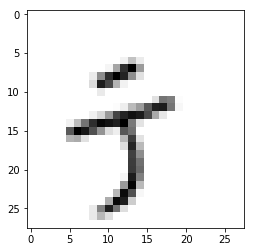

In [16]:
img = reshaped[1111]
img = ~img
plt.imshow(img,cmap='gray')
plt.show()

In [263]:
from keras.models import load_model
from os import listdir
from os.path import isfile, join

def test_dir(model_path,dir_path):
    onlyfiles = [dir_path+f for f in listdir(dir_path) if isfile(join(dir_path, f)) and f.endswith("png") ]
    #print(" ".join(onlyfiles))
    test_files(model_path,onlyfiles)
    

def test_files(model_path,paths):
    model = load_model(model_path)
    for path in paths:
        test_file(path,model)
    
def test_images(model_path,images,show_img):
    model = load_model(model_path)
    results = test_image(images,model,show_img)   
    wrong_count = 0
    for index,result in enumerate(results):
        
        if result < 0.5 :
            wrong_count += 1
            print(" wrong",index," -- ",result)
            if show_img:
                plt.imshow(images[index],cmap='gray')
                plt.show()
    print("wrong_count :",wrong_count)        
    return results
    
    
        
def test_file(path,model):
    print("path",path)
    #image = cv2.imread(path)
    #image = cv2.resize(image, (28,28), interpolation = cv2.INTER_AREA)
    image = resize_center_img(path)
    image = ~image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    plt.imshow(image,cmap='gray')
    plt.show()
    predict_imgs =np.array( [image.reshape(28,28,1)])
    print("prediction",path,model.predict(predict_imgs))
    
def test_image(images,model, show_img):
    
    sub = images.reshape(images.shape[0],28,28,1)
    res = model.predict(sub)
    res = list(res.flatten())
    return res
    


    

#test_image("D:/ganmnist/test/x.png")
#test_image("D:/ganmnist/test/x1.png")
#test_image("D:/ganmnist/test/white.png")
#test_image("D:/ganmnist/test/black.png")

In [71]:
paths = ["D:/ganmnist/test/x.png","D:/ganmnist/test/x1.png","D:/ganmnist/test/white.png","D:/ganmnist/test/black.png"]


path D:/ganmnist/test/x.png


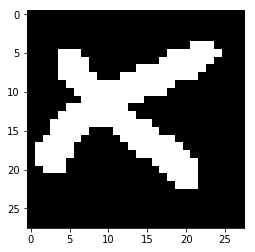

prediction D:/ganmnist/test/x.png [[3.8189213e-05]]
path D:/ganmnist/test/x1.png


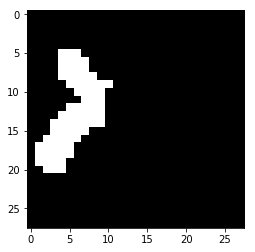

prediction D:/ganmnist/test/x1.png [[9.116784e-23]]
path D:/ganmnist/test/white.png


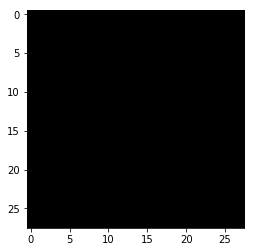

prediction D:/ganmnist/test/white.png [[0.5137748]]
path D:/ganmnist/test/black.png


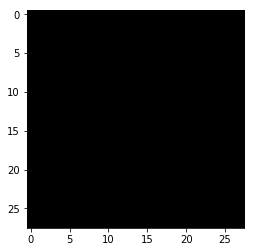

prediction D:/ganmnist/test/black.png [[1.]]


In [132]:
test_files("D:/ganmnist/generatorX_model_030.h5",paths)

In [83]:
(trainX, _), (_, _) = load_data()

In [133]:

r  = test_images("D:/ganmnist/generatorX_model_030.h5",trainX[0:40000],False)

 wrong 47  --  0.0
 wrong 418  --  0.00086930394
 wrong 778  --  6.145239e-05
 wrong 2424  --  0.014305413
 wrong 3285  --  0.0014384389
 wrong 4787  --  0.007064998
 wrong 5068  --  0.0
 wrong 5158  --  0.4559312
 wrong 5971  --  0.14739749
 wrong 6798  --  0.3640754
 wrong 6810  --  5.9604645e-08
 wrong 7279  --  6.854534e-07
 wrong 7311  --  0.0
 wrong 7313  --  0.011900365
 wrong 8023  --  0.0023177862
 wrong 8080  --  0.08797869
 wrong 8708  --  0.06967047
 wrong 8884  --  1.3709068e-06
 wrong 9552  --  0.0
 wrong 9807  --  0.20678657
 wrong 9816  --  7.4505806e-07
 wrong 10653  --  0.19780514
 wrong 10665  --  8.940697e-08
 wrong 11132  --  0.00048449636
 wrong 11434  --  0.23242533
 wrong 12158  --  0.00072059035
 wrong 12229  --  2.6524067e-06
 wrong 12812  --  7.748604e-07
 wrong 13000  --  0.005956769
 wrong 13617  --  0.044579417
 wrong 13633  --  2.8312206e-06
 wrong 14764  --  0.0011427999
 wrong 14834  --  0.1772941
 wrong 15022  --  2.3305416e-05
 wrong 15312  --  0.0040

In [134]:
r  = test_images("D:/ganmnist/generatorX_model_020.h5",trainX[0:40000],False)

 wrong 1  --  0.13947886
 wrong 3  --  8.046627e-07
 wrong 6  --  0.0
 wrong 8  --  0.0
 wrong 9  --  4.053116e-06
 wrong 10  --  0.0
 wrong 14  --  0.0
 wrong 15  --  0.020616084
 wrong 19  --  8.59499e-05
 wrong 20  --  0.12781638
 wrong 21  --  0.0
 wrong 22  --  0.115365446
 wrong 23  --  3.874302e-07
 wrong 24  --  0.00021120906
 wrong 26  --  3.0457973e-05
 wrong 27  --  0.0
 wrong 29  --  4.9859285e-05
 wrong 34  --  0.0
 wrong 35  --  0.0024877489
 wrong 36  --  0.0
 wrong 37  --  0.0
 wrong 39  --  0.0
 wrong 40  --  0.0
 wrong 42  --  0.0
 wrong 45  --  0.048273087
 wrong 47  --  0.0
 wrong 51  --  0.0
 wrong 52  --  0.04858306
 wrong 57  --  0.00014925003
 wrong 58  --  0.0
 wrong 59  --  1.1920929e-07
 wrong 62  --  0.0
 wrong 63  --  0.0
 wrong 66  --  0.0
 wrong 67  --  0.0
 wrong 69  --  0.0
 wrong 70  --  0.0
 wrong 72  --  0.0
 wrong 73  --  5.7399273e-05
 wrong 74  --  0.0
 wrong 75  --  0.0
 wrong 77  --  0.0
 wrong 78  --  0.0
 wrong 81  --  0.0
 wrong 82  --  7.838

 wrong 885  --  0.0
 wrong 888  --  0.0
 wrong 889  --  0.0
 wrong 890  --  6.738305e-05
 wrong 891  --  0.0
 wrong 894  --  0.0042862594
 wrong 896  --  0.0
 wrong 898  --  0.40724945
 wrong 900  --  1.7881393e-07
 wrong 901  --  0.0
 wrong 903  --  0.0
 wrong 904  --  0.0
 wrong 905  --  0.0
 wrong 911  --  0.0
 wrong 913  --  0.0
 wrong 914  --  0.2771208
 wrong 916  --  0.022947311
 wrong 918  --  0.0
 wrong 919  --  0.0
 wrong 920  --  0.0
 wrong 926  --  0.25867206
 wrong 927  --  0.0
 wrong 934  --  2.9802322e-08
 wrong 936  --  7.2717667e-06
 wrong 939  --  0.11885142
 wrong 943  --  3.287196e-05
 wrong 944  --  0.0
 wrong 946  --  0.0
 wrong 948  --  0.0
 wrong 949  --  0.0
 wrong 950  --  0.0
 wrong 951  --  1.4901161e-07
 wrong 952  --  5.811453e-06
 wrong 955  --  1.7881393e-06
 wrong 958  --  0.0016981363
 wrong 959  --  0.0
 wrong 964  --  0.0
 wrong 967  --  0.016985923
 wrong 969  --  0.0
 wrong 973  --  0.2351107
 wrong 975  --  1.7464161e-05
 wrong 977  --  0.00079792

 wrong 1627  --  1.1920929e-07
 wrong 1633  --  0.38112986
 wrong 1634  --  0.0
 wrong 1636  --  0.0
 wrong 1639  --  3.4838915e-05
 wrong 1640  --  0.0
 wrong 1642  --  0.0
 wrong 1645  --  0.035624444
 wrong 1647  --  0.00020870566
 wrong 1650  --  0.056938767
 wrong 1653  --  0.020889372
 wrong 1654  --  0.0
 wrong 1655  --  0.0
 wrong 1656  --  1.2218952e-06
 wrong 1658  --  0.0
 wrong 1661  --  1.4901161e-07
 wrong 1663  --  0.031245083
 wrong 1664  --  0.068835974
 wrong 1669  --  0.3287624
 wrong 1671  --  0.0
 wrong 1672  --  0.002595216
 wrong 1673  --  8.940697e-08
 wrong 1676  --  0.0
 wrong 1678  --  0.0
 wrong 1680  --  0.0
 wrong 1681  --  0.0
 wrong 1683  --  1.2516975e-06
 wrong 1684  --  0.0
 wrong 1685  --  0.03618321
 wrong 1686  --  0.1309492
 wrong 1687  --  2.3156404e-05
 wrong 1693  --  0.021374613
 wrong 1696  --  0.0
 wrong 1699  --  0.0013254583
 wrong 1700  --  0.0
 wrong 1701  --  0.0
 wrong 1704  --  3.874302e-07
 wrong 1707  --  0.0
 wrong 1709  --  0.0
 w

 wrong 2419  --  1.2218952e-06
 wrong 2420  --  0.23764527
 wrong 2422  --  0.0
 wrong 2426  --  0.0
 wrong 2427  --  0.002740562
 wrong 2429  --  0.0
 wrong 2431  --  0.0
 wrong 2432  --  0.0
 wrong 2433  --  0.0001001358
 wrong 2435  --  0.0
 wrong 2437  --  0.0
 wrong 2439  --  0.0
 wrong 2440  --  0.0
 wrong 2441  --  0.0
 wrong 2443  --  0.0
 wrong 2444  --  0.41922468
 wrong 2445  --  0.0
 wrong 2446  --  0.0
 wrong 2448  --  0.0
 wrong 2449  --  0.0
 wrong 2450  --  0.0
 wrong 2451  --  0.0
 wrong 2455  --  1.5735626e-05
 wrong 2459  --  2.3841858e-07
 wrong 2461  --  0.13967547
 wrong 2462  --  8.2701445e-05
 wrong 2465  --  1.7881393e-07
 wrong 2467  --  0.0
 wrong 2471  --  0.02103135
 wrong 2473  --  0.0
 wrong 2474  --  0.0
 wrong 2477  --  0.0
 wrong 2479  --  0.0
 wrong 2482  --  0.0
 wrong 2483  --  6.3717365e-05
 wrong 2484  --  0.0
 wrong 2486  --  2.3424625e-05
 wrong 2493  --  0.0
 wrong 2495  --  0.0
 wrong 2497  --  0.0
 wrong 2498  --  0.009954721
 wrong 2501  -- 

 wrong 3277  --  0.0
 wrong 3280  --  1.2278557e-05
 wrong 3282  --  1.3709068e-06
 wrong 3283  --  0.0
 wrong 3284  --  1.5467405e-05
 wrong 3286  --  0.0
 wrong 3288  --  0.0011388361
 wrong 3289  --  0.0
 wrong 3292  --  2.0861626e-07
 wrong 3294  --  0.0
 wrong 3295  --  0.0
 wrong 3296  --  0.0
 wrong 3297  --  0.0
 wrong 3298  --  0.4111301
 wrong 3300  --  0.007871091
 wrong 3301  --  0.0059452057
 wrong 3303  --  0.2995935
 wrong 3308  --  0.00020444393
 wrong 3309  --  0.0
 wrong 3310  --  2.861023e-05
 wrong 3311  --  9.5009804e-05
 wrong 3314  --  0.0
 wrong 3317  --  0.0
 wrong 3319  --  0.09168193
 wrong 3321  --  0.0
 wrong 3324  --  0.0
 wrong 3325  --  0.0
 wrong 3326  --  0.0
 wrong 3327  --  0.0
 wrong 3328  --  2.4467707e-05
 wrong 3330  --  0.10399017
 wrong 3331  --  0.0
 wrong 3335  --  0.0
 wrong 3337  --  0.0
 wrong 3342  --  0.0
 wrong 3343  --  0.0
 wrong 3344  --  0.0
 wrong 3345  --  0.0
 wrong 3349  --  0.0
 wrong 3350  --  0.0013652146
 wrong 3352  --  0.0

 wrong 4143  --  0.0
 wrong 4145  --  0.0
 wrong 4148  --  0.18784705
 wrong 4149  --  0.0
 wrong 4154  --  0.06684318
 wrong 4155  --  0.0
 wrong 4157  --  1.6540289e-05
 wrong 4158  --  0.016398013
 wrong 4159  --  0.29321814
 wrong 4160  --  0.0
 wrong 4161  --  0.015501916
 wrong 4162  --  0.0
 wrong 4163  --  0.0
 wrong 4165  --  0.0
 wrong 4166  --  0.0
 wrong 4167  --  0.0040076673
 wrong 4170  --  1.1652708e-05
 wrong 4175  --  3.8444996e-06
 wrong 4179  --  0.0
 wrong 4181  --  0.0
 wrong 4185  --  0.0008586347
 wrong 4186  --  0.00056901574
 wrong 4188  --  0.0012822151
 wrong 4189  --  0.0
 wrong 4190  --  0.1344603
 wrong 4192  --  1.7881393e-07
 wrong 4193  --  0.0
 wrong 4194  --  3.4689903e-05
 wrong 4198  --  0.0
 wrong 4199  --  0.00047922134
 wrong 4200  --  1.0997057e-05
 wrong 4201  --  0.0
 wrong 4202  --  0.0
 wrong 4203  --  0.0
 wrong 4204  --  0.0
 wrong 4207  --  1.4007092e-06
 wrong 4208  --  0.0
 wrong 4209  --  0.0
 wrong 4210  --  0.0013762414
 wrong 4211 

 wrong 4944  --  0.0
 wrong 4950  --  0.0
 wrong 4951  --  0.0
 wrong 4953  --  0.0
 wrong 4954  --  0.000556618
 wrong 4959  --  0.030112505
 wrong 4960  --  0.0
 wrong 4962  --  2.8312206e-06
 wrong 4963  --  0.0
 wrong 4965  --  0.0
 wrong 4970  --  5.9604645e-08
 wrong 4971  --  0.0
 wrong 4972  --  0.0
 wrong 4976  --  0.024114698
 wrong 4977  --  0.0
 wrong 4978  --  0.0
 wrong 4979  --  5.00679e-06
 wrong 4981  --  0.0
 wrong 4987  --  0.0
 wrong 4991  --  6.7949295e-06
 wrong 4993  --  0.0
 wrong 4995  --  0.1656689
 wrong 4997  --  0.040291905
 wrong 5003  --  0.0
 wrong 5004  --  0.0
 wrong 5006  --  0.0
 wrong 5007  --  0.0
 wrong 5012  --  0.0
 wrong 5014  --  0.05517614
 wrong 5015  --  0.0
 wrong 5018  --  0.0
 wrong 5019  --  0.0046473145
 wrong 5020  --  0.0015937984
 wrong 5021  --  0.0
 wrong 5022  --  0.0
 wrong 5023  --  0.0
 wrong 5025  --  0.0
 wrong 5026  --  0.0002849996
 wrong 5027  --  0.0035802126
 wrong 5032  --  0.0
 wrong 5036  --  3.5643578e-05
 wrong 503

 wrong 5757  --  1.6748905e-05
 wrong 5759  --  5.441904e-05
 wrong 5760  --  0.0
 wrong 5761  --  0.0
 wrong 5764  --  0.001122117
 wrong 5766  --  1.7881393e-07
 wrong 5767  --  0.0
 wrong 5768  --  3.7252903e-06
 wrong 5769  --  0.0
 wrong 5771  --  0.0
 wrong 5772  --  0.0
 wrong 5773  --  0.0
 wrong 5774  --  0.0
 wrong 5777  --  0.0005622506
 wrong 5778  --  0.0
 wrong 5779  --  0.0
 wrong 5780  --  0.07943687
 wrong 5782  --  0.0
 wrong 5784  --  0.0
 wrong 5785  --  0.0
 wrong 5786  --  0.0
 wrong 5787  --  0.0
 wrong 5789  --  0.0
 wrong 5790  --  0.0
 wrong 5795  --  0.0
 wrong 5796  --  0.040353894
 wrong 5797  --  4.887581e-06
 wrong 5799  --  0.015925586
 wrong 5801  --  0.0
 wrong 5803  --  0.0
 wrong 5804  --  0.4160711
 wrong 5809  --  0.0
 wrong 5811  --  0.0
 wrong 5812  --  0.4486384
 wrong 5814  --  0.0
 wrong 5816  --  0.0
 wrong 5817  --  4.4703484e-07
 wrong 5818  --  0.0
 wrong 5821  --  5.9604645e-08
 wrong 5823  --  1.4901161e-07
 wrong 5824  --  0.0
 wrong 58

 wrong 6558  --  0.0
 wrong 6560  --  0.003386587
 wrong 6562  --  0.0
 wrong 6564  --  1.3679266e-05
 wrong 6565  --  0.0
 wrong 6567  --  0.0
 wrong 6569  --  2.798438e-05
 wrong 6570  --  0.0
 wrong 6571  --  0.0
 wrong 6572  --  0.0
 wrong 6574  --  0.0
 wrong 6575  --  0.0
 wrong 6577  --  0.0003079474
 wrong 6578  --  0.0
 wrong 6579  --  0.0
 wrong 6581  --  0.083491445
 wrong 6586  --  0.0
 wrong 6587  --  0.0
 wrong 6588  --  0.031298727
 wrong 6589  --  0.00074231625
 wrong 6591  --  0.0
 wrong 6592  --  0.0
 wrong 6593  --  2.9802322e-08
 wrong 6594  --  0.0
 wrong 6596  --  0.0
 wrong 6597  --  0.0
 wrong 6599  --  0.002084285
 wrong 6600  --  2.682209e-07
 wrong 6602  --  0.016851872
 wrong 6603  --  0.0
 wrong 6607  --  0.0
 wrong 6609  --  0.0
 wrong 6611  --  0.0
 wrong 6612  --  0.081275105
 wrong 6613  --  0.0
 wrong 6614  --  2.0235777e-05
 wrong 6615  --  0.0
 wrong 6617  --  0.0
 wrong 6618  --  0.0
 wrong 6619  --  3.2782555e-07
 wrong 6623  --  0.0
 wrong 6628  -

 wrong 7802  --  0.0
 wrong 7804  --  0.13138306
 wrong 7806  --  0.0
 wrong 7807  --  0.030859858
 wrong 7808  --  7.903576e-05
 wrong 7809  --  0.0
 wrong 7813  --  0.0
 wrong 7815  --  0.0012785494
 wrong 7817  --  6.2942505e-05
 wrong 7819  --  0.0
 wrong 7821  --  0.0
 wrong 7828  --  0.0
 wrong 7830  --  0.0
 wrong 7831  --  1.7881393e-07
 wrong 7832  --  0.15495595
 wrong 7833  --  0.0
 wrong 7834  --  0.0
 wrong 7835  --  0.0
 wrong 7837  --  0.0
 wrong 7838  --  0.0
 wrong 7839  --  5.7786703e-05
 wrong 7840  --  0.0
 wrong 7842  --  2.9802322e-07
 wrong 7843  --  0.01701957
 wrong 7847  --  0.0
 wrong 7850  --  0.0
 wrong 7853  --  9.23872e-07
 wrong 7855  --  2.9802322e-08
 wrong 7857  --  0.0
 wrong 7860  --  0.0
 wrong 7861  --  0.00017341971
 wrong 7862  --  0.018838078
 wrong 7867  --  0.0
 wrong 7869  --  0.0
 wrong 7871  --  0.0
 wrong 7875  --  0.0
 wrong 7877  --  0.0
 wrong 7880  --  0.0
 wrong 7881  --  0.0
 wrong 7882  --  0.0
 wrong 7884  --  0.27639693
 wrong 78

 wrong 8695  --  0.0
 wrong 8697  --  0.0
 wrong 8699  --  0.0
 wrong 8700  --  3.6656857e-06
 wrong 8701  --  1.4901161e-07
 wrong 8703  --  0.0
 wrong 8704  --  0.0
 wrong 8705  --  0.0
 wrong 8709  --  0.0
 wrong 8711  --  0.0
 wrong 8715  --  0.0
 wrong 8717  --  0.0
 wrong 8719  --  0.0
 wrong 8720  --  0.0
 wrong 8721  --  0.0001372397
 wrong 8723  --  0.0
 wrong 8725  --  0.0
 wrong 8726  --  7.301569e-06
 wrong 8729  --  8.9883804e-05
 wrong 8730  --  0.24928325
 wrong 8731  --  0.0
 wrong 8733  --  0.0
 wrong 8734  --  3.1888485e-05
 wrong 8735  --  0.0
 wrong 8738  --  8.940697e-08
 wrong 8739  --  0.15669441
 wrong 8740  --  7.390976e-05
 wrong 8741  --  0.40760678
 wrong 8745  --  0.0
 wrong 8746  --  1.4901161e-07
 wrong 8750  --  0.015290052
 wrong 8751  --  0.0
 wrong 8752  --  0.0
 wrong 8753  --  8.940697e-08
 wrong 8754  --  0.36986196
 wrong 8755  --  0.033374608
 wrong 8757  --  0.0
 wrong 8758  --  0.0
 wrong 8759  --  0.0
 wrong 8760  --  3.46601e-05
 wrong 8761  

 wrong 9571  --  0.0
 wrong 9575  --  0.00018760562
 wrong 9577  --  0.0
 wrong 9579  --  0.0
 wrong 9580  --  0.0
 wrong 9582  --  0.0
 wrong 9584  --  5.9604645e-08
 wrong 9589  --  0.043092847
 wrong 9590  --  0.0
 wrong 9593  --  0.0
 wrong 9596  --  0.0
 wrong 9599  --  0.0
 wrong 9600  --  2.9802322e-07
 wrong 9602  --  0.0
 wrong 9605  --  4.827976e-06
 wrong 9606  --  0.0
 wrong 9607  --  4.300475e-05
 wrong 9609  --  0.0
 wrong 9614  --  0.015938878
 wrong 9615  --  0.0
 wrong 9616  --  0.0
 wrong 9618  --  0.0
 wrong 9619  --  0.4013684
 wrong 9622  --  0.0037366152
 wrong 9627  --  4.6789646e-05
 wrong 9628  --  0.0
 wrong 9631  --  0.0
 wrong 9632  --  0.0
 wrong 9635  --  0.0
 wrong 9638  --  1.013279e-06
 wrong 9640  --  0.004881263
 wrong 9642  --  0.004139513
 wrong 9643  --  0.0
 wrong 9644  --  0.0
 wrong 9645  --  1.4603138e-06
 wrong 9646  --  0.03806272
 wrong 9649  --  9.536743e-07
 wrong 9652  --  0.0
 wrong 9653  --  0.0
 wrong 9656  --  0.0
 wrong 9657  --  0.0

 wrong 10450  --  0.03809434
 wrong 10451  --  1.1324883e-06
 wrong 10455  --  0.0
 wrong 10456  --  0.0
 wrong 10457  --  0.0
 wrong 10458  --  0.0
 wrong 10459  --  5.9604645e-08
 wrong 10461  --  0.0021643043
 wrong 10462  --  0.0
 wrong 10463  --  0.0
 wrong 10467  --  0.0
 wrong 10468  --  0.0
 wrong 10469  --  0.0
 wrong 10470  --  0.0
 wrong 10471  --  4.2259693e-05
 wrong 10473  --  0.0
 wrong 10474  --  0.0
 wrong 10475  --  0.0
 wrong 10478  --  0.0
 wrong 10479  --  0.0
 wrong 10481  --  0.0
 wrong 10482  --  3.734231e-05
 wrong 10485  --  0.0
 wrong 10487  --  0.0
 wrong 10488  --  0.029760838
 wrong 10489  --  1.5795231e-06
 wrong 10492  --  1.6093254e-06
 wrong 10495  --  0.0
 wrong 10496  --  0.0
 wrong 10497  --  0.00015586615
 wrong 10500  --  0.0
 wrong 10503  --  0.0
 wrong 10504  --  0.0
 wrong 10505  --  0.0
 wrong 10506  --  0.04892665
 wrong 10507  --  0.0003491938
 wrong 10508  --  0.0
 wrong 10512  --  0.0044558346
 wrong 10516  --  1.013279e-06
 wrong 10517  -

 wrong 11366  --  0.0
 wrong 11367  --  0.0
 wrong 11370  --  0.0
 wrong 11371  --  0.0
 wrong 11372  --  0.0009033084
 wrong 11373  --  0.00024846196
 wrong 11375  --  0.045254976
 wrong 11377  --  0.0
 wrong 11378  --  0.00028979778
 wrong 11379  --  0.0
 wrong 11380  --  0.0
 wrong 11381  --  0.0002579689
 wrong 11382  --  0.0
 wrong 11384  --  0.29968077
 wrong 11387  --  0.000395149
 wrong 11390  --  0.0
 wrong 11391  --  0.0
 wrong 11393  --  3.5464764e-05
 wrong 11395  --  0.0
 wrong 11396  --  3.2424927e-05
 wrong 11397  --  0.0
 wrong 11399  --  0.0
 wrong 11400  --  0.00017133355
 wrong 11401  --  0.0
 wrong 11403  --  0.0
 wrong 11404  --  0.0
 wrong 11405  --  0.0
 wrong 11407  --  0.0
 wrong 11409  --  0.0
 wrong 11410  --  0.006602943
 wrong 11411  --  0.005852878
 wrong 11412  --  0.0
 wrong 11415  --  2.8282404e-05
 wrong 11417  --  0.0
 wrong 11418  --  0.0
 wrong 11419  --  0.0626483
 wrong 11421  --  0.0
 wrong 11423  --  0.0
 wrong 11426  --  0.0018418729
 wrong 114

 wrong 12212  --  0.0
 wrong 12213  --  0.06589663
 wrong 12214  --  0.0
 wrong 12215  --  0.0
 wrong 12216  --  5.9604645e-08
 wrong 12217  --  0.0
 wrong 12219  --  0.0
 wrong 12220  --  1.4901161e-07
 wrong 12221  --  0.0
 wrong 12223  --  0.0
 wrong 12224  --  6.264448e-05
 wrong 12225  --  0.1294035
 wrong 12226  --  0.0
 wrong 12227  --  1.3530254e-05
 wrong 12229  --  0.0
 wrong 12230  --  1.296401e-05
 wrong 12231  --  0.0
 wrong 12232  --  0.008317143
 wrong 12233  --  0.0
 wrong 12236  --  0.0
 wrong 12239  --  0.0
 wrong 12241  --  0.0
 wrong 12243  --  2.0861626e-07
 wrong 12247  --  0.0
 wrong 12249  --  2.9802322e-07
 wrong 12251  --  0.0
 wrong 12253  --  0.0
 wrong 12255  --  0.0
 wrong 12256  --  0.0
 wrong 12257  --  0.0
 wrong 12258  --  0.022411078
 wrong 12259  --  0.0
 wrong 12261  --  0.0
 wrong 12263  --  0.0
 wrong 12265  --  0.093480706
 wrong 12266  --  0.000988245
 wrong 12267  --  0.0
 wrong 12270  --  0.0056940317
 wrong 12271  --  0.0
 wrong 12273  --  0.

 wrong 13157  --  0.0
 wrong 13158  --  0.0
 wrong 13159  --  1.1920929e-07
 wrong 13160  --  0.0
 wrong 13162  --  0.0
 wrong 13163  --  0.0
 wrong 13164  --  0.33247575
 wrong 13165  --  0.0
 wrong 13167  --  0.0
 wrong 13168  --  0.0
 wrong 13169  --  0.0
 wrong 13172  --  0.00013914704
 wrong 13173  --  9.447336e-06
 wrong 13174  --  1.847744e-06
 wrong 13175  --  0.0
 wrong 13177  --  0.0
 wrong 13180  --  1.013279e-06
 wrong 13181  --  9.536743e-06
 wrong 13182  --  0.0
 wrong 13183  --  0.0
 wrong 13185  --  0.0
 wrong 13187  --  0.0
 wrong 13191  --  0.0
 wrong 13198  --  0.0
 wrong 13199  --  0.00031656027
 wrong 13201  --  0.0
 wrong 13203  --  0.0
 wrong 13205  --  0.0
 wrong 13206  --  0.05602166
 wrong 13210  --  0.30334175
 wrong 13211  --  0.0
 wrong 13213  --  0.0
 wrong 13215  --  0.0
 wrong 13217  --  0.0
 wrong 13220  --  0.004891038
 wrong 13222  --  0.052996814
 wrong 13223  --  0.00018569827
 wrong 13226  --  0.0
 wrong 13227  --  0.0
 wrong 13228  --  0.000121563

 wrong 14193  --  2.9802322e-08
 wrong 14195  --  0.0
 wrong 14197  --  0.0
 wrong 14198  --  1.7285347e-06
 wrong 14199  --  0.0
 wrong 14200  --  0.2510249
 wrong 14201  --  0.0
 wrong 14202  --  0.0
 wrong 14203  --  0.012200743
 wrong 14205  --  0.0
 wrong 14206  --  2.2053719e-06
 wrong 14207  --  0.03302747
 wrong 14208  --  0.0
 wrong 14212  --  0.0
 wrong 14213  --  2.9802322e-08
 wrong 14214  --  0.0002374053
 wrong 14215  --  0.0
 wrong 14219  --  0.0
 wrong 14221  --  0.0
 wrong 14222  --  0.0
 wrong 14223  --  0.0
 wrong 14224  --  0.0
 wrong 14227  --  0.0
 wrong 14228  --  9.23872e-07
 wrong 14229  --  0.0
 wrong 14231  --  0.0
 wrong 14232  --  0.0
 wrong 14233  --  0.0
 wrong 14234  --  0.0
 wrong 14236  --  0.39121088
 wrong 14237  --  0.0
 wrong 14243  --  1.7881393e-06
 wrong 14245  --  0.0
 wrong 14246  --  0.0
 wrong 14251  --  2.0861626e-07
 wrong 14252  --  0.0
 wrong 14253  --  0.13088366
 wrong 14254  --  0.0
 wrong 14255  --  0.0
 wrong 14256  --  0.0
 wrong 1

 wrong 15344  --  0.48435897
 wrong 15345  --  0.0330365
 wrong 15346  --  4.0709972e-05
 wrong 15350  --  0.0038218498
 wrong 15351  --  0.0005464852
 wrong 15352  --  0.05377817
 wrong 15353  --  0.14044988
 wrong 15356  --  0.0
 wrong 15358  --  8.046627e-07
 wrong 15365  --  9.834766e-07
 wrong 15370  --  1.1920929e-07
 wrong 15371  --  2.9802322e-08
 wrong 15372  --  0.0
 wrong 15378  --  0.0
 wrong 15380  --  0.0
 wrong 15392  --  5.662441e-07
 wrong 15394  --  0.0011279881
 wrong 15396  --  0.0
 wrong 15397  --  0.0
 wrong 15398  --  0.00069871545
 wrong 15399  --  0.01389569
 wrong 15402  --  0.0
 wrong 15403  --  1.2606382e-05
 wrong 15412  --  0.0
 wrong 15413  --  0.01728338
 wrong 15414  --  0.0
 wrong 15416  --  0.10300198
 wrong 15421  --  0.00016379356
 wrong 15423  --  0.0
 wrong 15425  --  1.8060207e-05
 wrong 15428  --  0.0
 wrong 15439  --  0.26924592
 wrong 15446  --  0.0
 wrong 15447  --  0.2869541
 wrong 15449  --  6.8843365e-06
 wrong 15452  --  0.0
 wrong 15458 

 wrong 16355  --  0.0514431
 wrong 16359  --  0.0053471625
 wrong 16362  --  0.0028052032
 wrong 16367  --  0.0
 wrong 16368  --  0.0
 wrong 16369  --  0.0
 wrong 16371  --  0.0
 wrong 16373  --  1.1920929e-07
 wrong 16374  --  0.0019606054
 wrong 16376  --  0.0
 wrong 16379  --  0.09153625
 wrong 16381  --  0.0
 wrong 16383  --  0.0
 wrong 16385  --  0.0
 wrong 16386  --  0.0012713969
 wrong 16389  --  0.07467702
 wrong 16392  --  0.0
 wrong 16393  --  0.0
 wrong 16395  --  0.0
 wrong 16397  --  0.0
 wrong 16401  --  0.0010052919
 wrong 16402  --  0.010750502
 wrong 16409  --  0.00010022521
 wrong 16413  --  0.0
 wrong 16414  --  0.0
 wrong 16415  --  0.0
 wrong 16418  --  0.0
 wrong 16419  --  0.00018179417
 wrong 16420  --  0.0
 wrong 16421  --  1.0728836e-05
 wrong 16424  --  0.00033447146
 wrong 16425  --  0.0
 wrong 16427  --  0.18566287
 wrong 16428  --  4.7683716e-07
 wrong 16429  --  5.26011e-05
 wrong 16430  --  0.00038847327
 wrong 16433  --  0.0
 wrong 16434  --  0.0
 wrong

 wrong 17487  --  0.0
 wrong 17488  --  0.0
 wrong 17490  --  4.5388937e-05
 wrong 17493  --  0.00036355853
 wrong 17499  --  1.0550022e-05
 wrong 17505  --  0.0
 wrong 17518  --  0.0
 wrong 17520  --  0.0
 wrong 17522  --  1.7881393e-07
 wrong 17524  --  2.9802322e-08
 wrong 17528  --  0.0
 wrong 17532  --  0.4017092
 wrong 17535  --  0.004673183
 wrong 17537  --  0.39904144
 wrong 17538  --  0.0070950687
 wrong 17540  --  0.0
 wrong 17541  --  3.4421682e-05
 wrong 17544  --  0.07101065
 wrong 17546  --  0.0
 wrong 17549  --  1.1920929e-07
 wrong 17550  --  0.0
 wrong 17554  --  0.0
 wrong 17555  --  3.874302e-07
 wrong 17556  --  2.6732683e-05
 wrong 17560  --  0.0
 wrong 17561  --  0.011927217
 wrong 17563  --  0.0
 wrong 17568  --  0.0
 wrong 17574  --  0.0
 wrong 17579  --  0.0
 wrong 17583  --  0.0
 wrong 17585  --  0.07857475
 wrong 17586  --  0.0
 wrong 17587  --  2.9802322e-07
 wrong 17589  --  0.052243233
 wrong 17590  --  0.0
 wrong 17592  --  0.0
 wrong 17594  --  0.0
 wron

 wrong 18504  --  0.0
 wrong 18507  --  0.0
 wrong 18511  --  0.321375
 wrong 18514  --  1.8060207e-05
 wrong 18515  --  0.0
 wrong 18516  --  0.0
 wrong 18517  --  0.0
 wrong 18519  --  8.940697e-08
 wrong 18524  --  0.0
 wrong 18525  --  0.0
 wrong 18527  --  0.0
 wrong 18529  --  0.0
 wrong 18530  --  0.0
 wrong 18531  --  2.0861626e-07
 wrong 18534  --  0.0
 wrong 18535  --  0.0
 wrong 18537  --  0.0
 wrong 18538  --  0.0
 wrong 18539  --  0.0
 wrong 18540  --  0.0
 wrong 18541  --  0.0010548234
 wrong 18545  --  0.0
 wrong 18546  --  0.0
 wrong 18547  --  0.0016462803
 wrong 18548  --  0.0
 wrong 18552  --  0.4073512
 wrong 18554  --  0.00024840236
 wrong 18558  --  0.0
 wrong 18561  --  0.2441724
 wrong 18565  --  0.0
 wrong 18567  --  6.735325e-06
 wrong 18568  --  5.066395e-06
 wrong 18570  --  0.00090149045
 wrong 18575  --  7.1525574e-07
 wrong 18576  --  0.000118047
 wrong 18583  --  0.0
 wrong 18590  --  0.17720896
 wrong 18592  --  0.00074127316
 wrong 18593  --  2.682209e

 wrong 19325  --  0.0
 wrong 19327  --  0.0011137724
 wrong 19329  --  0.0
 wrong 19330  --  0.0
 wrong 19331  --  0.0
 wrong 19338  --  1.9192696e-05
 wrong 19339  --  0.0
 wrong 19341  --  3.1769276e-05
 wrong 19343  --  0.0
 wrong 19344  --  0.06949788
 wrong 19346  --  0.0
 wrong 19349  --  0.38189048
 wrong 19352  --  0.000110030174
 wrong 19353  --  0.0003271401
 wrong 19354  --  1.1920929e-07
 wrong 19355  --  0.0
 wrong 19356  --  0.0
 wrong 19357  --  0.0076912344
 wrong 19359  --  7.748604e-07
 wrong 19360  --  0.0
 wrong 19361  --  0.0
 wrong 19362  --  8.940697e-08
 wrong 19363  --  0.0
 wrong 19370  --  1.4901161e-07
 wrong 19372  --  0.0
 wrong 19379  --  2.6106834e-05
 wrong 19381  --  0.0
 wrong 19382  --  0.0
 wrong 19385  --  0.0
 wrong 19387  --  0.0024503767
 wrong 19388  --  0.0
 wrong 19393  --  2.9802322e-08
 wrong 19394  --  0.0
 wrong 19396  --  0.006730318
 wrong 19397  --  0.00018748641
 wrong 19399  --  0.0
 wrong 19400  --  0.0
 wrong 19401  --  0.000120311

 wrong 20077  --  0.13555685
 wrong 20083  --  0.0
 wrong 20085  --  0.014918029
 wrong 20094  --  0.0
 wrong 20096  --  0.0031276345
 wrong 20100  --  0.0
 wrong 20104  --  1.8894672e-05
 wrong 20108  --  0.0
 wrong 20110  --  3.5971403e-05
 wrong 20119  --  0.0
 wrong 20122  --  0.0
 wrong 20128  --  0.026120067
 wrong 20131  --  0.0
 wrong 20132  --  0.07697743
 wrong 20134  --  0.0
 wrong 20136  --  0.20910877
 wrong 20142  --  0.0
 wrong 20143  --  0.0
 wrong 20145  --  8.046627e-06
 wrong 20146  --  0.0
 wrong 20150  --  8.940697e-08
 wrong 20151  --  0.0
 wrong 20154  --  0.0018611848
 wrong 20156  --  0.0
 wrong 20157  --  4.836917e-05
 wrong 20158  --  0.0
 wrong 20162  --  0.0009601414
 wrong 20163  --  3.2365322e-05
 wrong 20167  --  0.0
 wrong 20169  --  0.0
 wrong 20171  --  0.0
 wrong 20172  --  0.0
 wrong 20173  --  0.32656276
 wrong 20176  --  0.47973773
 wrong 20177  --  0.0
 wrong 20178  --  0.0
 wrong 20183  --  2.9802322e-08
 wrong 20185  --  0.00040584803
 wrong 20

 wrong 20837  --  0.0015146732
 wrong 20838  --  0.0
 wrong 20839  --  0.0
 wrong 20841  --  0.0
 wrong 20843  --  0.0
 wrong 20844  --  0.0044769645
 wrong 20845  --  0.0
 wrong 20849  --  0.0
 wrong 20850  --  0.0
 wrong 20851  --  0.0
 wrong 20852  --  0.0
 wrong 20854  --  0.17297542
 wrong 20855  --  0.0
 wrong 20857  --  0.0
 wrong 20859  --  0.0
 wrong 20860  --  2.8014183e-06
 wrong 20863  --  0.0
 wrong 20865  --  0.0
 wrong 20866  --  0.18546256
 wrong 20868  --  0.0
 wrong 20869  --  0.00014445186
 wrong 20870  --  0.0
 wrong 20875  --  1.7881393e-07
 wrong 20877  --  0.0
 wrong 20879  --  2.9802322e-07
 wrong 20881  --  0.05397722
 wrong 20883  --  0.0
 wrong 20884  --  3.3676624e-06
 wrong 20885  --  0.0
 wrong 20887  --  0.0
 wrong 20888  --  0.0
 wrong 20889  --  0.0
 wrong 20891  --  0.0
 wrong 20893  --  0.0
 wrong 20895  --  0.0
 wrong 20896  --  0.006476164
 wrong 20897  --  0.0
 wrong 20898  --  0.0
 wrong 20899  --  0.0
 wrong 20905  --  0.012915373
 wrong 20907  -

 wrong 21693  --  0.0
 wrong 21697  --  1.1920929e-07
 wrong 21698  --  0.0
 wrong 21699  --  0.0
 wrong 21701  --  0.0
 wrong 21702  --  0.0
 wrong 21704  --  4.6014786e-05
 wrong 21709  --  0.0
 wrong 21710  --  0.06834978
 wrong 21712  --  0.0024418235
 wrong 21715  --  0.0017147064
 wrong 21716  --  0.0
 wrong 21719  --  1.3560057e-05
 wrong 21721  --  2.0772219e-05
 wrong 21735  --  0.0
 wrong 21739  --  0.00011900067
 wrong 21740  --  0.0
 wrong 21741  --  4.5269728e-05
 wrong 21742  --  0.00049859285
 wrong 21744  --  0.0
 wrong 21747  --  0.0
 wrong 21748  --  0.0
 wrong 21749  --  0.0016930103
 wrong 21753  --  5.066395e-07
 wrong 21755  --  0.0013431013
 wrong 21759  --  0.0
 wrong 21764  --  0.0045820475
 wrong 21766  --  0.0
 wrong 21767  --  0.01957035
 wrong 21769  --  0.0
 wrong 21770  --  0.0
 wrong 21771  --  0.0
 wrong 21773  --  5.9604645e-08
 wrong 21776  --  0.00032687187
 wrong 21777  --  1.5437603e-05
 wrong 21780  --  0.0
 wrong 21781  --  0.0
 wrong 21782  --  

 wrong 22706  --  0.12265417
 wrong 22707  --  0.0
 wrong 22708  --  8.314848e-06
 wrong 22709  --  0.0
 wrong 22711  --  0.0
 wrong 22712  --  2.9802322e-08
 wrong 22713  --  0.0
 wrong 22715  --  0.0
 wrong 22716  --  0.0
 wrong 22717  --  0.0
 wrong 22718  --  0.0
 wrong 22719  --  0.0
 wrong 22721  --  0.0
 wrong 22722  --  0.0
 wrong 22723  --  0.0
 wrong 22725  --  0.0
 wrong 22727  --  0.0
 wrong 22728  --  0.006287396
 wrong 22729  --  0.0
 wrong 22731  --  0.0
 wrong 22733  --  0.0
 wrong 22735  --  0.0
 wrong 22736  --  0.0
 wrong 22739  --  0.0
 wrong 22741  --  0.0
 wrong 22742  --  0.2890246
 wrong 22743  --  2.9802322e-08
 wrong 22746  --  5.9336424e-05
 wrong 22747  --  0.0
 wrong 22748  --  0.0
 wrong 22749  --  0.0
 wrong 22750  --  0.0
 wrong 22752  --  0.0
 wrong 22753  --  0.043054044
 wrong 22755  --  1.3887882e-05
 wrong 22757  --  0.0
 wrong 22759  --  0.0
 wrong 22761  --  0.0
 wrong 22763  --  0.0
 wrong 22765  --  0.0
 wrong 22767  --  0.0
 wrong 22768  --  0.

 wrong 23668  --  2.9802322e-08
 wrong 23670  --  0.0
 wrong 23671  --  0.00033900142
 wrong 23678  --  0.0
 wrong 23680  --  0.16460684
 wrong 23686  --  6.3180923e-06
 wrong 23690  --  0.00010588765
 wrong 23692  --  2.026558e-06
 wrong 23694  --  0.0
 wrong 23696  --  0.0
 wrong 23698  --  0.0
 wrong 23704  --  0.065369934
 wrong 23705  --  0.18434861
 wrong 23706  --  0.0
 wrong 23709  --  8.895993e-05
 wrong 23716  --  0.050568223
 wrong 23718  --  1.7881393e-07
 wrong 23720  --  5.9604645e-08
 wrong 23723  --  0.0046004355
 wrong 23724  --  0.0
 wrong 23726  --  0.0045223236
 wrong 23728  --  0.0
 wrong 23732  --  0.0
 wrong 23733  --  0.0
 wrong 23736  --  1.013279e-06
 wrong 23739  --  0.20353422
 wrong 23740  --  0.0
 wrong 23741  --  0.00015473366
 wrong 23746  --  3.5762787e-07
 wrong 23748  --  1.1920929e-07
 wrong 23750  --  1.7881393e-07
 wrong 23752  --  9.9629164e-05
 wrong 23753  --  0.0
 wrong 23755  --  0.0
 wrong 23756  --  0.0
 wrong 23763  --  2.041459e-05
 wrong 

 wrong 24659  --  0.0
 wrong 24661  --  0.0
 wrong 24663  --  0.0
 wrong 24665  --  0.0
 wrong 24667  --  0.0
 wrong 24668  --  0.019604146
 wrong 24670  --  1.5467405e-05
 wrong 24671  --  0.0
 wrong 24673  --  0.0
 wrong 24675  --  0.0
 wrong 24677  --  0.0
 wrong 24678  --  0.0
 wrong 24679  --  0.0
 wrong 24680  --  0.00783366
 wrong 24683  --  0.0
 wrong 24684  --  0.0
 wrong 24685  --  0.0
 wrong 24687  --  8.34465e-07
 wrong 24688  --  0.0
 wrong 24689  --  2.8818846e-05
 wrong 24690  --  0.2909292
 wrong 24691  --  0.0022208095
 wrong 24692  --  0.028349966
 wrong 24693  --  0.0
 wrong 24695  --  0.0
 wrong 24696  --  0.0
 wrong 24698  --  0.005752921
 wrong 24699  --  0.0
 wrong 24700  --  0.0
 wrong 24701  --  0.0
 wrong 24702  --  0.0
 wrong 24703  --  9.387732e-06
 wrong 24705  --  0.0
 wrong 24706  --  0.0
 wrong 24707  --  0.0
 wrong 24709  --  0.0
 wrong 24710  --  0.0
 wrong 24711  --  0.0
 wrong 24714  --  0.0
 wrong 24715  --  0.0
 wrong 24716  --  3.6746264e-05
 wron

 wrong 25520  --  0.006052643
 wrong 25522  --  0.0
 wrong 25523  --  0.0
 wrong 25525  --  0.0
 wrong 25526  --  2.0861626e-07
 wrong 25529  --  0.0
 wrong 25531  --  0.0
 wrong 25532  --  3.874302e-07
 wrong 25534  --  0.0010499954
 wrong 25536  --  0.0
 wrong 25537  --  0.0
 wrong 25539  --  0.00061035156
 wrong 25541  --  0.0
 wrong 25543  --  0.0
 wrong 25546  --  0.0
 wrong 25547  --  0.0058589876
 wrong 25548  --  0.0
 wrong 25549  --  0.0
 wrong 25551  --  0.0
 wrong 25554  --  0.0
 wrong 25557  --  0.11528757
 wrong 25558  --  0.0016408861
 wrong 25559  --  1.052022e-05
 wrong 25562  --  3.2782555e-07
 wrong 25564  --  0.38372457
 wrong 25565  --  7.8082085e-06
 wrong 25569  --  0.0
 wrong 25571  --  0.0
 wrong 25573  --  0.0008854866
 wrong 25576  --  2.3841858e-07
 wrong 25577  --  0.0
 wrong 25581  --  0.0
 wrong 25585  --  2.9802322e-08
 wrong 25593  --  7.748604e-07
 wrong 25594  --  1.6391277e-06
 wrong 25595  --  8.940697e-08
 wrong 25596  --  0.0
 wrong 25597  --  0.00

 wrong 26608  --  3.59416e-05
 wrong 26610  --  1.7225742e-05
 wrong 26612  --  0.0
 wrong 26617  --  0.29518968
 wrong 26618  --  1.2785196e-05
 wrong 26620  --  0.0
 wrong 26624  --  0.0
 wrong 26628  --  0.0
 wrong 26630  --  0.00020352006
 wrong 26632  --  0.0
 wrong 26637  --  0.04255122
 wrong 26640  --  0.0002296567
 wrong 26642  --  0.011230767
 wrong 26645  --  0.0
 wrong 26646  --  1.5199184e-06
 wrong 26647  --  0.0
 wrong 26651  --  0.0
 wrong 26654  --  3.284216e-05
 wrong 26655  --  0.24815276
 wrong 26656  --  0.0
 wrong 26657  --  0.00052303076
 wrong 26659  --  1.7881393e-07
 wrong 26663  --  3.5762787e-07
 wrong 26665  --  0.0
 wrong 26667  --  0.0
 wrong 26669  --  0.00597921
 wrong 26673  --  2.9802322e-08
 wrong 26675  --  3.388524e-05
 wrong 26677  --  1.4662743e-05
 wrong 26679  --  0.0
 wrong 26684  --  0.0
 wrong 26685  --  0.0
 wrong 26686  --  0.29493067
 wrong 26687  --  0.0
 wrong 26689  --  0.0
 wrong 26690  --  0.009178251
 wrong 26691  --  0.008937597
 w

 wrong 27803  --  1.013279e-06
 wrong 27805  --  0.0
 wrong 27808  --  0.0
 wrong 27812  --  0.00045722723
 wrong 27813  --  0.0
 wrong 27816  --  2.0861626e-07
 wrong 27820  --  6.556511e-07
 wrong 27821  --  0.0
 wrong 27823  --  0.0006687939
 wrong 27824  --  1.4126301e-05
 wrong 27825  --  0.0010997355
 wrong 27827  --  0.0
 wrong 27829  --  0.0
 wrong 27830  --  0.0
 wrong 27831  --  4.827976e-06
 wrong 27836  --  0.042714536
 wrong 27837  --  0.0
 wrong 27840  --  0.33078974
 wrong 27841  --  0.000857234
 wrong 27842  --  1.8268824e-05
 wrong 27845  --  0.00033673644
 wrong 27853  --  0.00048825145
 wrong 27855  --  7.0631504e-06
 wrong 27861  --  6.133318e-05
 wrong 27863  --  0.06001395
 wrong 27864  --  0.018710583
 wrong 27868  --  2.6136637e-05
 wrong 27870  --  0.0022452176
 wrong 27871  --  0.0
 wrong 27872  --  0.0
 wrong 27875  --  0.0
 wrong 27879  --  0.0
 wrong 27885  --  1.9073486e-06
 wrong 27886  --  1.8119812e-05
 wrong 27892  --  0.0
 wrong 27893  --  0.0
 wrong 

 wrong 28677  --  0.09505156
 wrong 28678  --  4.4703484e-07
 wrong 28681  --  0.0
 wrong 28685  --  0.10684204
 wrong 28687  --  0.0007429719
 wrong 28689  --  0.14591569
 wrong 28690  --  0.0
 wrong 28691  --  0.13728073
 wrong 28695  --  6.3478947e-06
 wrong 28704  --  0.0
 wrong 28707  --  0.0
 wrong 28708  --  0.00018849969
 wrong 28710  --  0.0
 wrong 28714  --  0.0
 wrong 28716  --  1.9073486e-05
 wrong 28718  --  1.6868114e-05
 wrong 28719  --  0.0
 wrong 28720  --  0.0
 wrong 28721  --  0.0
 wrong 28723  --  0.0
 wrong 28724  --  0.0
 wrong 28725  --  0.0
 wrong 28728  --  0.0
 wrong 28729  --  2.0861626e-07
 wrong 28733  --  0.0
 wrong 28735  --  0.0
 wrong 28736  --  0.0
 wrong 28738  --  0.0
 wrong 28739  --  1.4901161e-06
 wrong 28740  --  0.0
 wrong 28741  --  0.2681848
 wrong 28743  --  2.503395e-06
 wrong 28747  --  5.9604645e-08
 wrong 28749  --  0.02335444
 wrong 28751  --  0.021751225
 wrong 28752  --  0.0
 wrong 28753  --  0.01709646
 wrong 28755  --  0.0
 wrong 287

 wrong 29687  --  0.0
 wrong 29688  --  3.0994415e-06
 wrong 29689  --  0.0
 wrong 29695  --  0.0
 wrong 29697  --  0.009157151
 wrong 29701  --  0.0
 wrong 29705  --  0.0
 wrong 29706  --  0.0
 wrong 29707  --  0.10765764
 wrong 29709  --  0.0030536056
 wrong 29711  --  0.00022861362
 wrong 29713  --  0.0
 wrong 29714  --  0.0
 wrong 29715  --  0.000764966
 wrong 29718  --  0.0
 wrong 29719  --  0.0
 wrong 29723  --  1.4901161e-07
 wrong 29725  --  0.0
 wrong 29727  --  0.0
 wrong 29728  --  1.9788742e-05
 wrong 29731  --  0.0007478595
 wrong 29733  --  4.681945e-05
 wrong 29734  --  0.053105265
 wrong 29736  --  0.0
 wrong 29740  --  0.0
 wrong 29741  --  0.0033844113
 wrong 29746  --  0.0
 wrong 29749  --  0.0
 wrong 29751  --  0.0
 wrong 29755  --  0.0
 wrong 29756  --  0.045894563
 wrong 29757  --  1.2606382e-05
 wrong 29758  --  0.0
 wrong 29759  --  2.9802322e-08
 wrong 29760  --  0.00035718083
 wrong 29762  --  0.0
 wrong 29763  --  0.0
 wrong 29764  --  0.0
 wrong 29766  --  0

 wrong 30871  --  0.00031802058
 wrong 30872  --  0.03137836
 wrong 30876  --  0.00023192167
 wrong 30879  --  0.0
 wrong 30882  --  2.682209e-07
 wrong 30887  --  0.13128948
 wrong 30888  --  0.0
 wrong 30891  --  0.0
 wrong 30894  --  0.0
 wrong 30898  --  0.0
 wrong 30899  --  1.809001e-05
 wrong 30900  --  0.0
 wrong 30901  --  1.013279e-06
 wrong 30902  --  0.0
 wrong 30904  --  0.0
 wrong 30906  --  0.0
 wrong 30909  --  1.0430813e-06
 wrong 30911  --  3.2782555e-07
 wrong 30913  --  0.0
 wrong 30917  --  0.0
 wrong 30920  --  0.0
 wrong 30922  --  8.881092e-06
 wrong 30923  --  0.0
 wrong 30924  --  0.0
 wrong 30927  --  0.025345802
 wrong 30928  --  0.0015318394
 wrong 30929  --  0.0
 wrong 30930  --  0.018752754
 wrong 30932  --  0.0
 wrong 30935  --  0.0
 wrong 30936  --  0.0
 wrong 30938  --  0.0047465265
 wrong 30939  --  0.0
 wrong 30940  --  0.0
 wrong 30941  --  0.0
 wrong 30943  --  0.0
 wrong 30945  --  0.0125563145
 wrong 30946  --  0.0
 wrong 30955  --  1.2606382e-05

 wrong 32053  --  0.013697147
 wrong 32054  --  0.0
 wrong 32055  --  0.0
 wrong 32058  --  0.0
 wrong 32059  --  0.0
 wrong 32063  --  0.0
 wrong 32064  --  2.9802322e-08
 wrong 32065  --  0.0
 wrong 32066  --  0.0
 wrong 32067  --  0.017737359
 wrong 32068  --  0.0688712
 wrong 32069  --  1.66893e-06
 wrong 32070  --  0.0
 wrong 32073  --  0.00014105439
 wrong 32074  --  0.2633957
 wrong 32079  --  0.0
 wrong 32081  --  0.0
 wrong 32083  --  0.0
 wrong 32085  --  0.0
 wrong 32087  --  0.0023472905
 wrong 32089  --  0.15344328
 wrong 32091  --  0.0
 wrong 32092  --  0.0
 wrong 32094  --  0.0044391155
 wrong 32095  --  0.0
 wrong 32096  --  0.0
 wrong 32097  --  0.0
 wrong 32099  --  0.0
 wrong 32101  --  0.0
 wrong 32105  --  6.735325e-06
 wrong 32107  --  7.170439e-05
 wrong 32108  --  0.04063818
 wrong 32110  --  0.0
 wrong 32111  --  0.0
 wrong 32113  --  0.0
 wrong 32115  --  0.0
 wrong 32116  --  0.44260573
 wrong 32117  --  0.0
 wrong 32118  --  2.3841858e-07
 wrong 32119  --  0

 wrong 33063  --  0.0
 wrong 33065  --  0.0
 wrong 33066  --  0.0
 wrong 33067  --  0.016742289
 wrong 33069  --  0.0
 wrong 33071  --  0.0
 wrong 33073  --  0.0
 wrong 33075  --  0.00027304888
 wrong 33078  --  0.0
 wrong 33079  --  0.0
 wrong 33082  --  0.0
 wrong 33083  --  0.0
 wrong 33084  --  0.0
 wrong 33085  --  0.0
 wrong 33087  --  0.0
 wrong 33089  --  3.3676624e-06
 wrong 33091  --  0.0
 wrong 33092  --  1.7881393e-07
 wrong 33093  --  0.0
 wrong 33094  --  0.36477697
 wrong 33095  --  0.0
 wrong 33096  --  0.0
 wrong 33099  --  1.1026859e-06
 wrong 33100  --  0.0
 wrong 33101  --  0.2269558
 wrong 33103  --  0.0
 wrong 33105  --  0.0
 wrong 33108  --  1.835823e-05
 wrong 33109  --  0.0
 wrong 33110  --  0.0
 wrong 33111  --  0.0
 wrong 33113  --  0.0
 wrong 33115  --  0.0
 wrong 33116  --  0.0
 wrong 33117  --  5.9604645e-08
 wrong 33118  --  0.048973233
 wrong 33119  --  0.0
 wrong 33121  --  0.0
 wrong 33122  --  9.536743e-07
 wrong 33123  --  6.556511e-07
 wrong 33124  

 wrong 34115  --  0.0
 wrong 34121  --  4.7683716e-07
 wrong 34123  --  0.00038027763
 wrong 34125  --  0.100245595
 wrong 34129  --  0.44850725
 wrong 34135  --  2.8014183e-06
 wrong 34138  --  8.940697e-08
 wrong 34141  --  0.0
 wrong 34142  --  0.0005737841
 wrong 34144  --  0.0
 wrong 34146  --  0.2152037
 wrong 34147  --  0.28493208
 wrong 34149  --  2.4735928e-05
 wrong 34153  --  3.46303e-05
 wrong 34158  --  0.0
 wrong 34159  --  0.0
 wrong 34164  --  0.0
 wrong 34165  --  5.158782e-05
 wrong 34166  --  0.0
 wrong 34167  --  0.0
 wrong 34168  --  0.0
 wrong 34169  --  0.0
 wrong 34171  --  0.0
 wrong 34173  --  0.0
 wrong 34174  --  0.0
 wrong 34175  --  0.1669831
 wrong 34179  --  0.0
 wrong 34182  --  0.06840497
 wrong 34183  --  0.005843073
 wrong 34185  --  0.06964776
 wrong 34186  --  0.00031399727
 wrong 34191  --  0.0
 wrong 34192  --  0.0
 wrong 34199  --  0.0
 wrong 34202  --  0.012850583
 wrong 34206  --  0.0
 wrong 34207  --  1.6003847e-05
 wrong 34210  --  0.0
 wron

 wrong 35131  --  0.0
 wrong 35133  --  0.10153386
 wrong 35142  --  0.23776829
 wrong 35146  --  0.19617894
 wrong 35147  --  0.0006286204
 wrong 35149  --  0.013615161
 wrong 35151  --  0.0
 wrong 35152  --  2.9802322e-08
 wrong 35153  --  0.0023017824
 wrong 35154  --  0.0468089
 wrong 35155  --  1.6897917e-05
 wrong 35157  --  0.0
 wrong 35159  --  1.013279e-06
 wrong 35160  --  1.7881393e-07
 wrong 35163  --  0.00025445223
 wrong 35168  --  0.0
 wrong 35169  --  0.015279472
 wrong 35171  --  5.0663948e-05
 wrong 35175  --  0.0
 wrong 35181  --  0.0
 wrong 35183  --  2.425909e-05
 wrong 35184  --  0.0
 wrong 35185  --  0.0
 wrong 35192  --  0.0
 wrong 35194  --  1.937151e-06
 wrong 35196  --  0.0
 wrong 35197  --  1.1920929e-07
 wrong 35199  --  0.0
 wrong 35202  --  5.349517e-05
 wrong 35206  --  0.0
 wrong 35207  --  0.00017020106
 wrong 35209  --  4.172325e-07
 wrong 35210  --  0.0002824962
 wrong 35212  --  0.0
 wrong 35214  --  0.0
 wrong 35217  --  0.0
 wrong 35220  --  1.788

 wrong 36311  --  0.007640332
 wrong 36315  --  0.0
 wrong 36317  --  0.0
 wrong 36318  --  0.0
 wrong 36319  --  0.0
 wrong 36320  --  0.0
 wrong 36321  --  7.1525574e-07
 wrong 36323  --  9.700656e-05
 wrong 36328  --  0.0
 wrong 36331  --  0.0005789101
 wrong 36332  --  0.0546152
 wrong 36333  --  0.0
 wrong 36334  --  0.0
 wrong 36340  --  0.1109505
 wrong 36343  --  0.0
 wrong 36344  --  2.9206276e-06
 wrong 36345  --  0.005815357
 wrong 36348  --  0.0
 wrong 36351  --  2.7149916e-05
 wrong 36353  --  0.0
 wrong 36356  --  0.44749314
 wrong 36361  --  0.00013110042
 wrong 36368  --  0.0
 wrong 36371  --  0.019798428
 wrong 36373  --  0.0
 wrong 36376  --  0.0
 wrong 36378  --  0.0
 wrong 36380  --  1.3113022e-06
 wrong 36382  --  0.022890419
 wrong 36383  --  0.0
 wrong 36384  --  7.748604e-07
 wrong 36385  --  0.0
 wrong 36390  --  0.0
 wrong 36391  --  1.7881393e-07
 wrong 36395  --  0.0
 wrong 36399  --  0.021425992
 wrong 36401  --  0.00039362907
 wrong 36402  --  0.0048089325

 wrong 37281  --  0.0
 wrong 37282  --  0.0
 wrong 37283  --  0.12352818
 wrong 37284  --  0.026368678
 wrong 37285  --  0.0
 wrong 37286  --  0.0
 wrong 37287  --  0.0
 wrong 37288  --  0.0
 wrong 37289  --  0.0
 wrong 37290  --  0.0
 wrong 37293  --  0.38823953
 wrong 37296  --  0.08365476
 wrong 37297  --  1.1920929e-07
 wrong 37299  --  0.4186768
 wrong 37300  --  0.00038984418
 wrong 37303  --  0.0
 wrong 37305  --  0.0
 wrong 37306  --  0.031756908
 wrong 37309  --  0.0
 wrong 37311  --  3.5762787e-07
 wrong 37314  --  0.2508123
 wrong 37315  --  0.0
 wrong 37317  --  0.0
 wrong 37321  --  0.005671203
 wrong 37323  --  3.6358833e-06
 wrong 37328  --  0.0
 wrong 37330  --  0.0
 wrong 37333  --  0.0035331845
 wrong 37334  --  0.12839863
 wrong 37335  --  0.00037822127
 wrong 37336  --  0.0056449473
 wrong 37337  --  1.1920929e-07
 wrong 37340  --  1.7881393e-07
 wrong 37341  --  0.0
 wrong 37342  --  0.0
 wrong 37343  --  0.0
 wrong 37348  --  5.9604645e-08
 wrong 37349  --  1.4245

 wrong 38458  --  1.4901161e-06
 wrong 38460  --  0.006991118
 wrong 38462  --  0.0
 wrong 38463  --  0.0
 wrong 38464  --  1.1920929e-07
 wrong 38465  --  3.501773e-05
 wrong 38466  --  0.0
 wrong 38467  --  0.0
 wrong 38468  --  0.0
 wrong 38470  --  0.016155094
 wrong 38472  --  2.0861626e-07
 wrong 38480  --  0.0
 wrong 38482  --  3.325939e-05
 wrong 38483  --  0.0
 wrong 38487  --  1.54078e-05
 wrong 38488  --  0.0
 wrong 38490  --  2.5629997e-06
 wrong 38492  --  2.360344e-05
 wrong 38499  --  0.0
 wrong 38500  --  2.7179718e-05
 wrong 38502  --  0.0
 wrong 38504  --  0.0
 wrong 38506  --  0.0
 wrong 38510  --  0.00066787004
 wrong 38512  --  3.695488e-06
 wrong 38514  --  0.0
 wrong 38516  --  0.0
 wrong 38517  --  0.017056584
 wrong 38521  --  0.052066833
 wrong 38522  --  0.0
 wrong 38523  --  0.0
 wrong 38524  --  1.7881393e-07
 wrong 38525  --  0.0
 wrong 38526  --  0.0
 wrong 38527  --  1.1920929e-07
 wrong 38528  --  0.0
 wrong 38531  --  0.43412608
 wrong 38532  --  0.0
 

 wrong 39407  --  1.1920929e-07
 wrong 39411  --  0.0015651882
 wrong 39414  --  0.0
 wrong 39415  --  0.0
 wrong 39417  --  0.0
 wrong 39419  --  0.0
 wrong 39420  --  0.0014259517
 wrong 39421  --  1.2040138e-05
 wrong 39423  --  0.0
 wrong 39425  --  0.0
 wrong 39427  --  1.7881393e-06
 wrong 39431  --  0.0
 wrong 39433  --  0.0
 wrong 39435  --  0.0
 wrong 39437  --  0.0
 wrong 39439  --  0.0
 wrong 39440  --  0.0
 wrong 39441  --  0.0
 wrong 39443  --  0.0
 wrong 39444  --  0.0
 wrong 39447  --  0.0
 wrong 39449  --  0.0
 wrong 39451  --  0.0
 wrong 39452  --  0.0033602417
 wrong 39453  --  0.0
 wrong 39454  --  0.0
 wrong 39455  --  0.0
 wrong 39457  --  0.0
 wrong 39458  --  2.503395e-06
 wrong 39459  --  0.0
 wrong 39462  --  1.1920929e-07
 wrong 39463  --  0.0
 wrong 39464  --  0.0
 wrong 39465  --  0.0
 wrong 39466  --  0.0
 wrong 39467  --  0.0
 wrong 39468  --  5.492568e-05
 wrong 39469  --  0.0
 wrong 39471  --  1.7881393e-07
 wrong 39473  --  0.0
 wrong 39475  --  0.0
 wr

In [137]:
r  = test_images("D:/ganmnist/NgeneratorX_model_010.h5",trainX[0:40000],False)

 wrong 0  --  0.0
 wrong 1  --  0.0
 wrong 2  --  0.0
 wrong 3  --  0.0
 wrong 4  --  0.0
 wrong 5  --  0.0
 wrong 6  --  0.0
 wrong 7  --  0.0
 wrong 8  --  0.0
 wrong 9  --  0.0
 wrong 10  --  0.0
 wrong 11  --  0.0
 wrong 12  --  0.0
 wrong 13  --  0.0
 wrong 14  --  0.0
 wrong 15  --  0.0
 wrong 16  --  0.0
 wrong 17  --  0.0
 wrong 18  --  0.0
 wrong 19  --  0.0
 wrong 20  --  0.0
 wrong 21  --  0.0
 wrong 22  --  0.0
 wrong 23  --  0.0
 wrong 24  --  0.0
 wrong 25  --  0.0
 wrong 26  --  0.0
 wrong 27  --  0.0
 wrong 28  --  0.0
 wrong 29  --  0.0
 wrong 30  --  0.0
 wrong 31  --  0.0
 wrong 32  --  0.0
 wrong 33  --  0.0
 wrong 34  --  0.0
 wrong 35  --  0.1623621
 wrong 36  --  0.0
 wrong 37  --  0.0
 wrong 38  --  0.0
 wrong 39  --  0.0
 wrong 40  --  0.0
 wrong 41  --  0.0
 wrong 42  --  1.0043383e-05
 wrong 43  --  0.0
 wrong 44  --  0.0
 wrong 45  --  0.0
 wrong 46  --  0.0
 wrong 47  --  0.0
 wrong 48  --  0.0
 wrong 49  --  0.0
 wrong 50  --  0.0
 wrong 51  --  0.0
 wrong

 wrong 440  --  0.0
 wrong 441  --  0.0
 wrong 442  --  0.0
 wrong 443  --  0.0
 wrong 444  --  0.0
 wrong 445  --  0.0
 wrong 446  --  0.0
 wrong 447  --  0.0
 wrong 448  --  0.0
 wrong 449  --  0.0
 wrong 450  --  0.0
 wrong 451  --  0.0
 wrong 452  --  0.0
 wrong 453  --  0.0
 wrong 454  --  0.0
 wrong 455  --  0.0
 wrong 456  --  0.0
 wrong 457  --  0.0
 wrong 458  --  0.0
 wrong 459  --  0.0
 wrong 460  --  0.0
 wrong 461  --  0.0
 wrong 462  --  0.0
 wrong 463  --  0.0
 wrong 464  --  0.0
 wrong 465  --  0.0
 wrong 466  --  0.0
 wrong 467  --  0.0
 wrong 468  --  0.0
 wrong 469  --  0.0
 wrong 470  --  0.0
 wrong 471  --  0.0
 wrong 472  --  0.0
 wrong 473  --  0.0
 wrong 474  --  0.0
 wrong 475  --  0.0
 wrong 476  --  0.0
 wrong 477  --  0.0
 wrong 478  --  0.0
 wrong 479  --  0.0
 wrong 480  --  0.0
 wrong 481  --  0.0
 wrong 482  --  0.0
 wrong 483  --  0.0
 wrong 484  --  0.0
 wrong 485  --  0.0
 wrong 486  --  0.0
 wrong 487  --  0.0
 wrong 488  --  0.0
 wrong 489  --  0.0


 wrong 1191  --  0.0
 wrong 1192  --  0.0
 wrong 1193  --  0.0
 wrong 1194  --  0.0
 wrong 1195  --  0.0
 wrong 1196  --  0.0
 wrong 1197  --  0.0
 wrong 1198  --  0.0
 wrong 1199  --  0.0
 wrong 1200  --  0.0
 wrong 1201  --  0.0
 wrong 1202  --  0.0
 wrong 1203  --  0.0
 wrong 1204  --  0.0
 wrong 1205  --  0.0
 wrong 1206  --  0.0
 wrong 1207  --  0.0
 wrong 1208  --  0.0
 wrong 1209  --  0.0
 wrong 1210  --  0.0
 wrong 1211  --  0.0
 wrong 1212  --  0.0
 wrong 1213  --  0.0
 wrong 1214  --  0.0
 wrong 1215  --  0.0
 wrong 1216  --  0.0
 wrong 1217  --  0.0
 wrong 1218  --  0.0
 wrong 1219  --  0.0
 wrong 1220  --  0.0
 wrong 1221  --  0.0
 wrong 1222  --  0.0
 wrong 1223  --  0.0
 wrong 1224  --  0.0
 wrong 1225  --  0.0
 wrong 1226  --  0.0
 wrong 1227  --  0.0
 wrong 1228  --  0.0
 wrong 1229  --  0.0
 wrong 1230  --  0.0
 wrong 1231  --  0.0
 wrong 1232  --  0.0
 wrong 1233  --  0.0
 wrong 1234  --  0.0
 wrong 1235  --  0.0
 wrong 1236  --  0.0
 wrong 1237  --  0.0
 wrong 1238  

 wrong 2067  --  0.0
 wrong 2068  --  0.0
 wrong 2069  --  0.0
 wrong 2070  --  0.0
 wrong 2071  --  0.0
 wrong 2072  --  0.0
 wrong 2073  --  0.0
 wrong 2074  --  0.0
 wrong 2075  --  0.0
 wrong 2076  --  0.0
 wrong 2077  --  0.0
 wrong 2078  --  0.0
 wrong 2079  --  0.0
 wrong 2080  --  0.0
 wrong 2081  --  0.0
 wrong 2082  --  0.0
 wrong 2083  --  0.0
 wrong 2084  --  0.0
 wrong 2085  --  0.0
 wrong 2086  --  0.0
 wrong 2087  --  0.0
 wrong 2088  --  0.0
 wrong 2089  --  0.0
 wrong 2090  --  0.0
 wrong 2091  --  0.0
 wrong 2092  --  0.0
 wrong 2093  --  0.0
 wrong 2094  --  0.0
 wrong 2095  --  0.0
 wrong 2096  --  0.0
 wrong 2097  --  0.0
 wrong 2098  --  0.0
 wrong 2099  --  0.0
 wrong 2100  --  0.0
 wrong 2101  --  0.0
 wrong 2102  --  0.0
 wrong 2103  --  0.0
 wrong 2104  --  0.0
 wrong 2105  --  0.0
 wrong 2106  --  0.0
 wrong 2107  --  0.0
 wrong 2108  --  0.0
 wrong 2109  --  0.0
 wrong 2110  --  0.0
 wrong 2111  --  0.0
 wrong 2112  --  0.0
 wrong 2113  --  0.0
 wrong 2114  

 wrong 2567  --  0.0
 wrong 2568  --  0.0
 wrong 2569  --  0.0
 wrong 2570  --  0.0
 wrong 2571  --  0.0
 wrong 2572  --  0.0
 wrong 2573  --  0.0
 wrong 2574  --  0.0
 wrong 2575  --  0.0
 wrong 2576  --  0.0
 wrong 2577  --  0.0
 wrong 2578  --  0.0
 wrong 2579  --  0.0
 wrong 2580  --  0.0
 wrong 2581  --  0.0
 wrong 2582  --  0.0
 wrong 2583  --  0.0
 wrong 2584  --  0.0
 wrong 2585  --  0.0
 wrong 2586  --  0.0
 wrong 2587  --  0.0
 wrong 2588  --  0.0
 wrong 2589  --  0.0
 wrong 2590  --  0.0
 wrong 2591  --  0.0
 wrong 2592  --  0.0
 wrong 2593  --  0.0
 wrong 2594  --  0.0
 wrong 2595  --  0.0
 wrong 2596  --  0.0
 wrong 2597  --  0.0
 wrong 2598  --  0.0
 wrong 2599  --  0.0
 wrong 2600  --  0.0
 wrong 2601  --  0.0
 wrong 2602  --  0.0
 wrong 2603  --  0.0
 wrong 2604  --  0.0
 wrong 2605  --  0.0
 wrong 2606  --  0.0
 wrong 2607  --  0.0
 wrong 2608  --  0.0
 wrong 2609  --  0.0
 wrong 2610  --  0.0
 wrong 2611  --  0.0
 wrong 2612  --  0.0
 wrong 2613  --  0.0
 wrong 2614  

 wrong 3067  --  0.0
 wrong 3068  --  0.0
 wrong 3069  --  0.0
 wrong 3070  --  0.0
 wrong 3071  --  0.0
 wrong 3072  --  0.0
 wrong 3073  --  0.0
 wrong 3074  --  0.0
 wrong 3075  --  0.0
 wrong 3076  --  0.0
 wrong 3077  --  0.0
 wrong 3078  --  0.0
 wrong 3079  --  0.0
 wrong 3080  --  0.0
 wrong 3081  --  0.0
 wrong 3082  --  0.0
 wrong 3083  --  0.0
 wrong 3084  --  0.0
 wrong 3085  --  5.4478645e-05
 wrong 3086  --  0.0
 wrong 3087  --  0.0
 wrong 3088  --  0.0
 wrong 3089  --  0.0
 wrong 3090  --  0.0
 wrong 3091  --  0.0
 wrong 3092  --  0.0
 wrong 3093  --  0.0
 wrong 3094  --  0.0
 wrong 3095  --  0.0
 wrong 3096  --  0.0
 wrong 3097  --  0.0
 wrong 3098  --  0.0
 wrong 3099  --  0.0
 wrong 3100  --  0.0
 wrong 3101  --  0.0
 wrong 3102  --  0.0
 wrong 3103  --  0.0
 wrong 3104  --  0.0
 wrong 3105  --  0.0
 wrong 3106  --  0.0
 wrong 3107  --  0.0
 wrong 3108  --  0.0
 wrong 3109  --  0.0
 wrong 3110  --  0.0
 wrong 3111  --  0.0
 wrong 3112  --  0.0
 wrong 3113  --  0.0
 wr

 wrong 3569  --  0.0
 wrong 3570  --  0.0
 wrong 3571  --  0.0
 wrong 3572  --  0.0
 wrong 3573  --  0.0
 wrong 3574  --  0.0
 wrong 3575  --  0.0
 wrong 3576  --  0.0
 wrong 3577  --  0.0
 wrong 3578  --  0.0
 wrong 3579  --  0.0
 wrong 3580  --  0.0
 wrong 3581  --  0.0
 wrong 3582  --  0.0
 wrong 3583  --  0.0
 wrong 3584  --  0.0
 wrong 3585  --  0.0
 wrong 3586  --  0.0
 wrong 3587  --  0.0
 wrong 3588  --  0.0
 wrong 3589  --  0.0
 wrong 3590  --  0.0
 wrong 3591  --  0.0
 wrong 3592  --  0.00018593669
 wrong 3593  --  0.0
 wrong 3594  --  0.0
 wrong 3595  --  0.0
 wrong 3596  --  0.0
 wrong 3597  --  0.0
 wrong 3598  --  0.0
 wrong 3599  --  0.0
 wrong 3600  --  0.0
 wrong 3601  --  0.0
 wrong 3602  --  0.0
 wrong 3603  --  0.0
 wrong 3604  --  0.0
 wrong 3605  --  0.0
 wrong 3606  --  0.0
 wrong 3607  --  0.0
 wrong 3608  --  0.0
 wrong 3609  --  0.0
 wrong 3610  --  0.0
 wrong 3611  --  0.0
 wrong 3612  --  0.0
 wrong 3613  --  0.0
 wrong 3614  --  0.0
 wrong 3615  --  0.0
 wr

 wrong 4070  --  0.0
 wrong 4071  --  0.0
 wrong 4072  --  0.0
 wrong 4073  --  0.0
 wrong 4074  --  0.0
 wrong 4075  --  0.0
 wrong 4076  --  0.0
 wrong 4077  --  0.0
 wrong 4078  --  0.0
 wrong 4079  --  0.0
 wrong 4080  --  0.0
 wrong 4081  --  0.0
 wrong 4082  --  0.0
 wrong 4083  --  0.0
 wrong 4084  --  0.0
 wrong 4085  --  0.0
 wrong 4086  --  0.0
 wrong 4087  --  0.0
 wrong 4088  --  0.0
 wrong 4089  --  0.0
 wrong 4090  --  0.0
 wrong 4091  --  0.0
 wrong 4092  --  0.0
 wrong 4093  --  0.0
 wrong 4094  --  0.0
 wrong 4095  --  0.0
 wrong 4096  --  0.0
 wrong 4097  --  0.0
 wrong 4098  --  0.0
 wrong 4099  --  0.0
 wrong 4100  --  0.0
 wrong 4101  --  0.0
 wrong 4102  --  0.0
 wrong 4103  --  0.0
 wrong 4104  --  0.0
 wrong 4105  --  0.0
 wrong 4106  --  0.0
 wrong 4107  --  0.0
 wrong 4108  --  0.0
 wrong 4109  --  0.0
 wrong 4110  --  0.0
 wrong 4111  --  0.0
 wrong 4112  --  0.0
 wrong 4113  --  0.0
 wrong 4114  --  0.0
 wrong 4115  --  0.0
 wrong 4116  --  0.0
 wrong 4117  

 wrong 4570  --  0.0
 wrong 4571  --  0.0
 wrong 4572  --  0.0
 wrong 4573  --  0.0
 wrong 4574  --  0.0
 wrong 4575  --  0.0
 wrong 4576  --  0.0
 wrong 4577  --  0.0
 wrong 4578  --  0.0
 wrong 4579  --  0.0
 wrong 4580  --  0.0
 wrong 4581  --  0.0
 wrong 4582  --  0.0
 wrong 4583  --  0.0
 wrong 4584  --  0.0
 wrong 4585  --  0.0
 wrong 4586  --  0.0
 wrong 4587  --  0.0
 wrong 4588  --  0.0
 wrong 4589  --  0.0
 wrong 4590  --  0.0
 wrong 4591  --  0.0
 wrong 4592  --  0.0
 wrong 4593  --  0.0
 wrong 4594  --  0.0
 wrong 4595  --  0.0
 wrong 4596  --  0.0
 wrong 4597  --  0.0
 wrong 4598  --  0.0
 wrong 4599  --  0.0
 wrong 4600  --  0.0
 wrong 4601  --  0.0
 wrong 4602  --  0.0
 wrong 4603  --  0.0
 wrong 4604  --  0.0
 wrong 4605  --  0.0
 wrong 4606  --  0.0
 wrong 4607  --  0.0
 wrong 4608  --  0.0
 wrong 4609  --  0.0
 wrong 4610  --  0.0
 wrong 4611  --  0.0
 wrong 4612  --  0.0
 wrong 4613  --  0.0
 wrong 4614  --  0.0
 wrong 4615  --  0.0
 wrong 4616  --  0.0
 wrong 4617  

 wrong 5070  --  0.0
 wrong 5071  --  0.0
 wrong 5072  --  0.0
 wrong 5073  --  0.0
 wrong 5074  --  0.0
 wrong 5075  --  0.0
 wrong 5076  --  0.0
 wrong 5077  --  0.0
 wrong 5078  --  0.0
 wrong 5079  --  0.0
 wrong 5080  --  0.0
 wrong 5081  --  0.0
 wrong 5082  --  0.0
 wrong 5083  --  0.0
 wrong 5084  --  0.0
 wrong 5085  --  0.0
 wrong 5086  --  0.0
 wrong 5087  --  0.0
 wrong 5088  --  0.0
 wrong 5089  --  0.0
 wrong 5090  --  0.0
 wrong 5091  --  0.0
 wrong 5092  --  0.0
 wrong 5093  --  0.0
 wrong 5094  --  0.0
 wrong 5095  --  0.0
 wrong 5096  --  0.0
 wrong 5097  --  0.0
 wrong 5098  --  0.0
 wrong 5099  --  0.0
 wrong 5100  --  0.0
 wrong 5101  --  0.0
 wrong 5102  --  0.0
 wrong 5103  --  0.0
 wrong 5104  --  0.0
 wrong 5105  --  0.0
 wrong 5106  --  0.0
 wrong 5107  --  0.0
 wrong 5108  --  0.0
 wrong 5109  --  0.0
 wrong 5110  --  0.0
 wrong 5111  --  0.0
 wrong 5112  --  0.0
 wrong 5113  --  0.0
 wrong 5114  --  0.0
 wrong 5115  --  0.0
 wrong 5116  --  0.0
 wrong 5117  

 wrong 5569  --  0.0
 wrong 5570  --  0.0
 wrong 5571  --  0.0
 wrong 5572  --  0.0
 wrong 5573  --  0.0
 wrong 5574  --  0.0
 wrong 5575  --  0.0
 wrong 5576  --  0.0
 wrong 5577  --  0.0
 wrong 5578  --  0.0
 wrong 5579  --  0.0
 wrong 5580  --  0.0
 wrong 5581  --  0.0
 wrong 5582  --  0.0
 wrong 5583  --  0.0
 wrong 5584  --  0.0
 wrong 5585  --  0.0
 wrong 5586  --  0.0
 wrong 5587  --  0.0
 wrong 5588  --  0.0
 wrong 5589  --  0.0
 wrong 5590  --  0.0
 wrong 5591  --  0.0
 wrong 5592  --  0.0
 wrong 5593  --  0.0
 wrong 5594  --  0.0
 wrong 5595  --  0.0
 wrong 5596  --  0.0
 wrong 5597  --  0.0
 wrong 5598  --  0.0
 wrong 5599  --  0.0
 wrong 5600  --  0.0
 wrong 5601  --  0.0
 wrong 5602  --  0.0
 wrong 5603  --  0.0
 wrong 5604  --  0.0
 wrong 5605  --  0.0
 wrong 5606  --  0.0
 wrong 5607  --  0.0
 wrong 5608  --  0.0
 wrong 5609  --  0.0
 wrong 5610  --  0.0
 wrong 5611  --  0.0
 wrong 5612  --  0.0
 wrong 5613  --  0.0
 wrong 5614  --  0.0
 wrong 5615  --  0.0
 wrong 5616  

 wrong 6069  --  0.0
 wrong 6070  --  0.0
 wrong 6071  --  0.0
 wrong 6072  --  0.0
 wrong 6073  --  0.0
 wrong 6074  --  0.0
 wrong 6075  --  0.0
 wrong 6076  --  0.0
 wrong 6077  --  0.0
 wrong 6078  --  0.0
 wrong 6079  --  0.0
 wrong 6080  --  0.0
 wrong 6081  --  0.0
 wrong 6082  --  9.745359e-06
 wrong 6083  --  0.0
 wrong 6084  --  0.0
 wrong 6085  --  0.0
 wrong 6086  --  0.0
 wrong 6087  --  0.0
 wrong 6088  --  0.0
 wrong 6089  --  0.0
 wrong 6090  --  0.0
 wrong 6091  --  0.0
 wrong 6092  --  0.0
 wrong 6093  --  0.0
 wrong 6094  --  0.0
 wrong 6095  --  0.0
 wrong 6096  --  0.0
 wrong 6097  --  0.0
 wrong 6098  --  0.0
 wrong 6099  --  0.0
 wrong 6100  --  0.0
 wrong 6101  --  0.0
 wrong 6102  --  0.0
 wrong 6103  --  0.0
 wrong 6104  --  0.0
 wrong 6105  --  0.0
 wrong 6106  --  0.0
 wrong 6107  --  0.0
 wrong 6108  --  5.3852797e-05
 wrong 6109  --  0.0
 wrong 6110  --  0.0
 wrong 6111  --  0.0
 wrong 6112  --  0.0
 wrong 6113  --  0.0
 wrong 6114  --  0.0
 wrong 6115  --

 wrong 6569  --  0.0
 wrong 6570  --  0.0
 wrong 6571  --  0.0
 wrong 6572  --  0.0
 wrong 6573  --  0.0
 wrong 6574  --  0.0
 wrong 6575  --  0.0
 wrong 6576  --  0.0
 wrong 6577  --  0.0
 wrong 6578  --  0.0
 wrong 6579  --  0.0
 wrong 6580  --  0.0
 wrong 6581  --  0.0
 wrong 6582  --  0.0
 wrong 6583  --  0.0
 wrong 6584  --  0.0
 wrong 6585  --  0.0
 wrong 6586  --  0.0
 wrong 6587  --  0.0
 wrong 6588  --  0.0
 wrong 6589  --  0.0
 wrong 6590  --  0.0
 wrong 6591  --  0.0
 wrong 6592  --  0.0
 wrong 6593  --  0.0
 wrong 6594  --  0.0
 wrong 6595  --  0.0
 wrong 6596  --  0.0
 wrong 6597  --  0.0
 wrong 6598  --  0.0
 wrong 6599  --  0.0
 wrong 6600  --  0.0
 wrong 6601  --  0.0
 wrong 6602  --  0.0
 wrong 6603  --  0.0
 wrong 6604  --  0.0
 wrong 6605  --  0.0
 wrong 6606  --  0.0
 wrong 6607  --  0.0
 wrong 6608  --  0.0
 wrong 6609  --  0.0
 wrong 6610  --  0.0
 wrong 6611  --  0.0
 wrong 6612  --  0.0
 wrong 6613  --  0.0
 wrong 6614  --  0.0
 wrong 6615  --  0.0
 wrong 6616  

 wrong 7070  --  0.0
 wrong 7071  --  0.0
 wrong 7072  --  0.0
 wrong 7073  --  4.440546e-06
 wrong 7074  --  0.0
 wrong 7075  --  0.0
 wrong 7076  --  0.0
 wrong 7077  --  0.0
 wrong 7078  --  0.0
 wrong 7079  --  0.0
 wrong 7080  --  0.0
 wrong 7081  --  0.0
 wrong 7082  --  0.0
 wrong 7083  --  0.0
 wrong 7084  --  0.0
 wrong 7085  --  0.0
 wrong 7086  --  0.0
 wrong 7087  --  1.1920929e-07
 wrong 7088  --  0.0
 wrong 7089  --  0.0
 wrong 7090  --  0.0
 wrong 7091  --  0.07529247
 wrong 7092  --  0.0
 wrong 7093  --  0.0
 wrong 7094  --  0.0
 wrong 7095  --  0.0
 wrong 7096  --  0.0
 wrong 7097  --  0.0
 wrong 7098  --  0.0
 wrong 7099  --  0.0
 wrong 7100  --  0.0
 wrong 7101  --  0.0
 wrong 7102  --  0.0
 wrong 7103  --  0.0
 wrong 7104  --  0.0
 wrong 7105  --  0.0
 wrong 7106  --  0.0
 wrong 7107  --  0.0
 wrong 7108  --  0.0
 wrong 7109  --  0.0
 wrong 7110  --  0.0
 wrong 7111  --  0.0
 wrong 7112  --  0.0
 wrong 7113  --  0.0
 wrong 7114  --  0.0
 wrong 7115  --  0.0
 wrong 7

 wrong 7571  --  0.0
 wrong 7572  --  0.0
 wrong 7573  --  0.0
 wrong 7574  --  0.0
 wrong 7575  --  0.0
 wrong 7576  --  0.0
 wrong 7577  --  0.0
 wrong 7578  --  0.0
 wrong 7579  --  0.0
 wrong 7580  --  0.0
 wrong 7581  --  0.0
 wrong 7582  --  0.0
 wrong 7583  --  0.0
 wrong 7584  --  0.0
 wrong 7585  --  0.0
 wrong 7586  --  0.0
 wrong 7587  --  0.0
 wrong 7588  --  0.0
 wrong 7589  --  0.0
 wrong 7590  --  0.0
 wrong 7591  --  0.0
 wrong 7592  --  0.0
 wrong 7593  --  0.0
 wrong 7594  --  0.0
 wrong 7595  --  0.0
 wrong 7596  --  0.0
 wrong 7597  --  0.0
 wrong 7598  --  0.0
 wrong 7599  --  0.0
 wrong 7600  --  0.0
 wrong 7601  --  0.0
 wrong 7602  --  0.0
 wrong 7603  --  0.0
 wrong 7604  --  0.0
 wrong 7605  --  0.0
 wrong 7606  --  0.0
 wrong 7607  --  0.0
 wrong 7608  --  0.0
 wrong 7609  --  0.0
 wrong 7610  --  0.0
 wrong 7611  --  0.0
 wrong 7612  --  0.0
 wrong 7613  --  0.0
 wrong 7614  --  0.0
 wrong 7615  --  0.0
 wrong 7616  --  0.0
 wrong 7617  --  0.0
 wrong 7618  

 wrong 8072  --  0.0
 wrong 8073  --  0.0
 wrong 8074  --  0.0
 wrong 8075  --  0.0
 wrong 8076  --  0.0
 wrong 8077  --  0.0
 wrong 8078  --  0.0
 wrong 8079  --  0.0
 wrong 8080  --  0.0009756088
 wrong 8081  --  0.0
 wrong 8082  --  0.0
 wrong 8083  --  0.0
 wrong 8084  --  0.0
 wrong 8085  --  0.0
 wrong 8086  --  0.0
 wrong 8087  --  0.0
 wrong 8088  --  0.0
 wrong 8089  --  0.0
 wrong 8090  --  0.0
 wrong 8091  --  0.0
 wrong 8092  --  0.0
 wrong 8093  --  0.0
 wrong 8094  --  0.0
 wrong 8095  --  0.0
 wrong 8096  --  0.0
 wrong 8097  --  0.0
 wrong 8098  --  0.0
 wrong 8099  --  0.0
 wrong 8100  --  0.0
 wrong 8101  --  0.0
 wrong 8102  --  0.0
 wrong 8103  --  0.0
 wrong 8104  --  0.0
 wrong 8105  --  0.0
 wrong 8106  --  0.0
 wrong 8107  --  0.0
 wrong 8108  --  0.0
 wrong 8109  --  0.0
 wrong 8110  --  0.0
 wrong 8111  --  0.0
 wrong 8112  --  0.0
 wrong 8113  --  0.0
 wrong 8114  --  0.0
 wrong 8115  --  0.0
 wrong 8116  --  0.0
 wrong 8117  --  0.0
 wrong 8118  --  0.0
 wro

 wrong 8950  --  0.0
 wrong 8951  --  0.0
 wrong 8952  --  0.0
 wrong 8953  --  0.0
 wrong 8954  --  0.0
 wrong 8955  --  0.0
 wrong 8956  --  0.0
 wrong 8957  --  0.0
 wrong 8958  --  0.0
 wrong 8959  --  0.0
 wrong 8960  --  0.0
 wrong 8961  --  0.0
 wrong 8962  --  0.0
 wrong 8963  --  0.0
 wrong 8964  --  0.0
 wrong 8965  --  0.0
 wrong 8966  --  0.0
 wrong 8967  --  0.0
 wrong 8968  --  0.0
 wrong 8969  --  0.0
 wrong 8970  --  0.0
 wrong 8971  --  0.0
 wrong 8972  --  0.0
 wrong 8973  --  0.0
 wrong 8974  --  0.0
 wrong 8975  --  0.0
 wrong 8976  --  0.0
 wrong 8977  --  0.0
 wrong 8978  --  0.0
 wrong 8979  --  0.0
 wrong 8980  --  0.0
 wrong 8981  --  0.0
 wrong 8982  --  0.0
 wrong 8983  --  0.0
 wrong 8984  --  0.0
 wrong 8985  --  0.0
 wrong 8986  --  0.0
 wrong 8987  --  0.0
 wrong 8988  --  0.0
 wrong 8989  --  0.0
 wrong 8990  --  0.0
 wrong 8991  --  0.0
 wrong 8992  --  0.0
 wrong 8993  --  0.0
 wrong 8994  --  0.0
 wrong 8995  --  0.0
 wrong 8996  --  0.0
 wrong 8997  

 wrong 9451  --  0.0
 wrong 9452  --  0.0
 wrong 9453  --  0.0
 wrong 9454  --  0.0
 wrong 9455  --  0.0
 wrong 9456  --  0.0
 wrong 9457  --  0.0
 wrong 9458  --  0.0
 wrong 9459  --  0.0
 wrong 9460  --  0.0
 wrong 9461  --  0.0
 wrong 9462  --  0.0
 wrong 9463  --  0.0
 wrong 9464  --  0.0
 wrong 9465  --  0.0
 wrong 9466  --  0.0
 wrong 9467  --  0.0
 wrong 9468  --  0.0
 wrong 9469  --  0.0
 wrong 9470  --  0.0
 wrong 9471  --  0.0
 wrong 9472  --  0.0
 wrong 9473  --  0.0
 wrong 9474  --  0.0
 wrong 9475  --  0.0
 wrong 9476  --  0.0
 wrong 9477  --  0.0
 wrong 9478  --  0.0
 wrong 9479  --  0.0
 wrong 9480  --  0.0
 wrong 9481  --  0.0
 wrong 9482  --  0.0
 wrong 9483  --  0.0
 wrong 9484  --  0.0
 wrong 9485  --  0.0
 wrong 9486  --  0.0
 wrong 9487  --  0.0
 wrong 9488  --  0.0
 wrong 9489  --  0.0
 wrong 9490  --  0.0
 wrong 9491  --  0.0
 wrong 9492  --  0.0
 wrong 9493  --  0.0
 wrong 9494  --  0.0
 wrong 9495  --  0.0
 wrong 9496  --  0.0
 wrong 9497  --  0.0
 wrong 9498  

 wrong 9951  --  0.0
 wrong 9952  --  0.0
 wrong 9953  --  0.0
 wrong 9954  --  0.027509183
 wrong 9955  --  0.0
 wrong 9956  --  0.0
 wrong 9957  --  0.0
 wrong 9958  --  0.0
 wrong 9959  --  0.0
 wrong 9960  --  0.0
 wrong 9961  --  0.0
 wrong 9962  --  0.0
 wrong 9963  --  0.0
 wrong 9964  --  0.0
 wrong 9965  --  0.0
 wrong 9966  --  0.0
 wrong 9967  --  0.0
 wrong 9968  --  0.0
 wrong 9969  --  0.0
 wrong 9970  --  0.0
 wrong 9971  --  0.0
 wrong 9972  --  0.0
 wrong 9973  --  0.0
 wrong 9974  --  0.0
 wrong 9975  --  0.0
 wrong 9976  --  0.0
 wrong 9977  --  0.0
 wrong 9978  --  0.0
 wrong 9979  --  0.0
 wrong 9980  --  0.0
 wrong 9981  --  0.0
 wrong 9982  --  0.0
 wrong 9983  --  0.0
 wrong 9984  --  0.0
 wrong 9985  --  0.0
 wrong 9986  --  0.0
 wrong 9987  --  0.0
 wrong 9988  --  0.0
 wrong 9989  --  0.0
 wrong 9990  --  1.7881393e-07
 wrong 9991  --  0.0
 wrong 9992  --  0.0
 wrong 9993  --  0.0
 wrong 9994  --  0.0
 wrong 9995  --  0.0
 wrong 9996  --  0.0
 wrong 9997  -- 

 wrong 10326  --  0.0
 wrong 10327  --  0.0
 wrong 10328  --  0.0
 wrong 10329  --  0.0
 wrong 10330  --  0.0
 wrong 10331  --  0.0
 wrong 10332  --  0.0
 wrong 10333  --  0.0
 wrong 10334  --  0.0
 wrong 10335  --  0.0
 wrong 10336  --  0.0
 wrong 10337  --  0.0
 wrong 10338  --  0.0
 wrong 10339  --  0.0
 wrong 10340  --  0.0
 wrong 10341  --  0.0
 wrong 10342  --  0.0
 wrong 10343  --  0.0
 wrong 10344  --  0.0
 wrong 10345  --  0.0
 wrong 10346  --  0.0
 wrong 10347  --  0.0
 wrong 10348  --  0.0
 wrong 10349  --  0.0
 wrong 10350  --  0.0
 wrong 10351  --  0.0
 wrong 10352  --  0.0
 wrong 10353  --  0.0
 wrong 10354  --  0.0
 wrong 10355  --  0.0
 wrong 10356  --  0.0
 wrong 10357  --  0.0
 wrong 10358  --  0.0
 wrong 10359  --  0.0
 wrong 10360  --  0.0
 wrong 10361  --  0.0
 wrong 10362  --  0.0
 wrong 10363  --  0.0
 wrong 10364  --  0.0
 wrong 10365  --  0.0
 wrong 10366  --  0.0
 wrong 10367  --  0.0
 wrong 10368  --  0.0
 wrong 10369  --  0.0
 wrong 10370  --  0.0
 wrong 103

 wrong 10827  --  0.0
 wrong 10828  --  0.0
 wrong 10829  --  0.0
 wrong 10830  --  0.0
 wrong 10831  --  0.0
 wrong 10832  --  0.0
 wrong 10833  --  0.0
 wrong 10834  --  0.0
 wrong 10835  --  0.0
 wrong 10836  --  0.0
 wrong 10837  --  0.0
 wrong 10838  --  0.0
 wrong 10839  --  0.0
 wrong 10840  --  0.0
 wrong 10841  --  0.0
 wrong 10842  --  0.0
 wrong 10843  --  0.0
 wrong 10844  --  0.0
 wrong 10845  --  0.0
 wrong 10846  --  0.0
 wrong 10847  --  0.0
 wrong 10848  --  0.0
 wrong 10849  --  0.0
 wrong 10850  --  0.0
 wrong 10851  --  0.0
 wrong 10852  --  0.0
 wrong 10853  --  0.0
 wrong 10854  --  0.0
 wrong 10855  --  0.0
 wrong 10856  --  0.0
 wrong 10857  --  0.0
 wrong 10858  --  0.0
 wrong 10859  --  0.0
 wrong 10860  --  0.0
 wrong 10861  --  0.0
 wrong 10862  --  0.0
 wrong 10863  --  0.0
 wrong 10864  --  0.0
 wrong 10865  --  0.0
 wrong 10866  --  0.0
 wrong 10867  --  0.0
 wrong 10868  --  0.0
 wrong 10869  --  0.0
 wrong 10870  --  0.0
 wrong 10871  --  0.0
 wrong 108

 wrong 11328  --  0.0
 wrong 11329  --  0.0
 wrong 11330  --  0.0
 wrong 11331  --  0.0
 wrong 11332  --  0.0
 wrong 11333  --  0.0
 wrong 11334  --  0.0
 wrong 11335  --  0.0
 wrong 11336  --  0.0
 wrong 11337  --  0.0
 wrong 11338  --  0.0
 wrong 11339  --  0.0
 wrong 11340  --  0.0
 wrong 11341  --  0.0
 wrong 11342  --  0.0
 wrong 11343  --  0.0
 wrong 11344  --  0.0
 wrong 11345  --  0.0
 wrong 11346  --  0.0
 wrong 11347  --  0.0
 wrong 11348  --  0.0
 wrong 11349  --  0.0
 wrong 11350  --  0.0
 wrong 11351  --  0.0
 wrong 11352  --  0.0
 wrong 11353  --  0.0
 wrong 11354  --  0.0
 wrong 11355  --  0.0
 wrong 11356  --  0.0
 wrong 11357  --  0.0
 wrong 11358  --  0.0
 wrong 11359  --  0.0
 wrong 11360  --  0.0
 wrong 11361  --  0.0
 wrong 11362  --  0.0
 wrong 11363  --  0.0
 wrong 11364  --  0.0
 wrong 11365  --  0.0
 wrong 11366  --  0.0
 wrong 11367  --  0.0
 wrong 11368  --  0.0
 wrong 11369  --  0.0
 wrong 11370  --  0.0
 wrong 11371  --  0.0
 wrong 11372  --  1.7881393e-07


 wrong 11830  --  0.0
 wrong 11831  --  0.0
 wrong 11832  --  0.0
 wrong 11833  --  0.0
 wrong 11834  --  0.0
 wrong 11835  --  0.0
 wrong 11836  --  0.0
 wrong 11837  --  0.0
 wrong 11838  --  0.0
 wrong 11839  --  0.0
 wrong 11840  --  0.0
 wrong 11841  --  0.0
 wrong 11842  --  0.0
 wrong 11843  --  0.0
 wrong 11844  --  0.0
 wrong 11845  --  0.0
 wrong 11846  --  0.0
 wrong 11847  --  0.0
 wrong 11848  --  0.0
 wrong 11849  --  0.0
 wrong 11850  --  0.0
 wrong 11851  --  0.0
 wrong 11852  --  0.0
 wrong 11853  --  0.0
 wrong 11855  --  0.0
 wrong 11856  --  0.0
 wrong 11857  --  0.0
 wrong 11858  --  0.0
 wrong 11859  --  0.0
 wrong 11860  --  0.0
 wrong 11861  --  0.0
 wrong 11862  --  0.0
 wrong 11863  --  0.0
 wrong 11864  --  0.0
 wrong 11865  --  0.0
 wrong 11866  --  4.3213367e-05
 wrong 11867  --  0.0
 wrong 11868  --  0.0
 wrong 11869  --  0.0
 wrong 11870  --  0.0
 wrong 11871  --  0.0
 wrong 11872  --  0.0
 wrong 11873  --  0.0
 wrong 11874  --  0.0
 wrong 11875  --  0.0


 wrong 12206  --  0.0
 wrong 12207  --  0.0
 wrong 12208  --  0.0
 wrong 12209  --  0.0
 wrong 12210  --  0.0
 wrong 12211  --  0.0
 wrong 12212  --  0.0
 wrong 12213  --  0.0
 wrong 12214  --  0.0
 wrong 12215  --  0.0
 wrong 12216  --  0.0
 wrong 12217  --  0.0
 wrong 12218  --  0.0
 wrong 12219  --  0.0
 wrong 12220  --  0.0
 wrong 12221  --  0.0
 wrong 12222  --  0.0
 wrong 12223  --  0.0
 wrong 12224  --  0.0
 wrong 12225  --  0.0
 wrong 12226  --  0.0
 wrong 12227  --  0.0
 wrong 12228  --  0.0
 wrong 12229  --  0.0
 wrong 12230  --  0.0
 wrong 12231  --  0.0
 wrong 12232  --  0.0
 wrong 12233  --  0.0
 wrong 12234  --  0.0
 wrong 12235  --  0.0
 wrong 12236  --  0.0
 wrong 12237  --  0.0
 wrong 12238  --  0.0
 wrong 12239  --  0.0
 wrong 12240  --  0.0
 wrong 12241  --  0.0
 wrong 12242  --  0.0
 wrong 12243  --  0.0
 wrong 12244  --  0.0
 wrong 12245  --  0.0
 wrong 12246  --  0.0
 wrong 12247  --  0.0
 wrong 12248  --  0.0
 wrong 12249  --  0.0
 wrong 12250  --  0.0
 wrong 122

 wrong 12830  --  0.0
 wrong 12831  --  0.0
 wrong 12832  --  0.0
 wrong 12833  --  0.0
 wrong 12834  --  0.0
 wrong 12835  --  0.0
 wrong 12836  --  0.0
 wrong 12837  --  0.0
 wrong 12838  --  0.0
 wrong 12839  --  0.0
 wrong 12840  --  0.0
 wrong 12841  --  0.0
 wrong 12842  --  0.0
 wrong 12843  --  0.0
 wrong 12844  --  0.0
 wrong 12845  --  0.0
 wrong 12846  --  0.0
 wrong 12847  --  0.0
 wrong 12848  --  0.0
 wrong 12849  --  0.0
 wrong 12850  --  7.036328e-05
 wrong 12851  --  0.0
 wrong 12852  --  0.0
 wrong 12853  --  0.0
 wrong 12854  --  0.0
 wrong 12855  --  0.0
 wrong 12856  --  0.0
 wrong 12857  --  0.0
 wrong 12858  --  0.0
 wrong 12859  --  0.0
 wrong 12860  --  0.0
 wrong 12861  --  0.0
 wrong 12862  --  0.0
 wrong 12863  --  0.0
 wrong 12864  --  0.0
 wrong 12865  --  0.0
 wrong 12866  --  0.0
 wrong 12867  --  0.0
 wrong 12868  --  0.0
 wrong 12869  --  0.0
 wrong 12870  --  0.0
 wrong 12871  --  0.0
 wrong 12872  --  0.0
 wrong 12873  --  6.28829e-06
 wrong 12874  -

 wrong 13232  --  0.0
 wrong 13233  --  0.0
 wrong 13234  --  0.0
 wrong 13235  --  0.0
 wrong 13236  --  0.0
 wrong 13237  --  0.0
 wrong 13238  --  0.0
 wrong 13239  --  0.0
 wrong 13240  --  0.0
 wrong 13241  --  0.0
 wrong 13242  --  0.0
 wrong 13243  --  0.0
 wrong 13244  --  0.0
 wrong 13245  --  0.0
 wrong 13246  --  0.0
 wrong 13247  --  0.0
 wrong 13248  --  0.0
 wrong 13249  --  0.0
 wrong 13250  --  0.0
 wrong 13251  --  0.0
 wrong 13252  --  0.0
 wrong 13253  --  0.0
 wrong 13254  --  0.0
 wrong 13255  --  0.0
 wrong 13256  --  0.0
 wrong 13257  --  0.0
 wrong 13258  --  0.0
 wrong 13259  --  0.0
 wrong 13260  --  0.0
 wrong 13261  --  0.0
 wrong 13262  --  0.0
 wrong 13263  --  0.0
 wrong 13264  --  0.0
 wrong 13265  --  0.0
 wrong 13266  --  0.0018171668
 wrong 13267  --  0.0
 wrong 13268  --  0.0
 wrong 13269  --  0.0
 wrong 13270  --  0.0
 wrong 13271  --  0.0
 wrong 13272  --  0.0
 wrong 13273  --  0.0
 wrong 13274  --  0.0
 wrong 13275  --  0.0
 wrong 13276  --  0.0
 

 wrong 13708  --  0.0
 wrong 13709  --  0.0
 wrong 13710  --  0.0
 wrong 13711  --  0.0
 wrong 13712  --  0.0
 wrong 13713  --  0.0
 wrong 13714  --  0.0
 wrong 13715  --  0.0
 wrong 13716  --  0.0
 wrong 13717  --  0.0
 wrong 13718  --  1.9073486e-05
 wrong 13719  --  0.0
 wrong 13720  --  0.0
 wrong 13721  --  0.0
 wrong 13722  --  0.0
 wrong 13723  --  0.0
 wrong 13724  --  0.0
 wrong 13725  --  0.0
 wrong 13726  --  0.0
 wrong 13727  --  0.0
 wrong 13728  --  0.0
 wrong 13729  --  0.0
 wrong 13730  --  0.0
 wrong 13731  --  0.0
 wrong 13732  --  0.0
 wrong 13733  --  0.0
 wrong 13734  --  0.0
 wrong 13735  --  0.0
 wrong 13736  --  0.0
 wrong 13737  --  0.0
 wrong 13738  --  0.0
 wrong 13739  --  0.0
 wrong 13740  --  0.0
 wrong 13741  --  0.0
 wrong 13742  --  0.0
 wrong 13743  --  0.0
 wrong 13744  --  0.0
 wrong 13745  --  0.0
 wrong 13746  --  0.0
 wrong 13747  --  0.0
 wrong 13748  --  0.0
 wrong 13749  --  0.0
 wrong 13750  --  0.0
 wrong 13751  --  0.0
 wrong 13752  --  0.0


 wrong 14210  --  0.0
 wrong 14211  --  0.0
 wrong 14212  --  0.0
 wrong 14213  --  0.0
 wrong 14214  --  0.0
 wrong 14215  --  0.0
 wrong 14216  --  0.0
 wrong 14217  --  0.0
 wrong 14218  --  0.0
 wrong 14219  --  0.0
 wrong 14220  --  0.0
 wrong 14221  --  0.0
 wrong 14222  --  0.0
 wrong 14223  --  0.0
 wrong 14224  --  0.0
 wrong 14225  --  0.0
 wrong 14226  --  0.0
 wrong 14227  --  0.0
 wrong 14228  --  0.0
 wrong 14229  --  0.0
 wrong 14230  --  0.0
 wrong 14231  --  0.0
 wrong 14232  --  0.0
 wrong 14233  --  0.0
 wrong 14234  --  0.0
 wrong 14235  --  0.0
 wrong 14236  --  0.0
 wrong 14237  --  0.0
 wrong 14238  --  0.0
 wrong 14239  --  0.0
 wrong 14240  --  0.0
 wrong 14241  --  0.0
 wrong 14242  --  0.0
 wrong 14243  --  0.0
 wrong 14244  --  0.0
 wrong 14245  --  0.0
 wrong 14246  --  0.0
 wrong 14247  --  0.0
 wrong 14248  --  2.682209e-07
 wrong 14249  --  0.0
 wrong 14250  --  0.0
 wrong 14251  --  0.0
 wrong 14252  --  0.0
 wrong 14253  --  0.0
 wrong 14254  --  0.0
 

 wrong 14585  --  0.0
 wrong 14586  --  0.0
 wrong 14587  --  0.05766481
 wrong 14588  --  0.0
 wrong 14589  --  0.0
 wrong 14590  --  0.0
 wrong 14591  --  0.0
 wrong 14592  --  0.0
 wrong 14593  --  0.0
 wrong 14594  --  0.0
 wrong 14595  --  0.0
 wrong 14596  --  0.0
 wrong 14597  --  0.0
 wrong 14598  --  0.0
 wrong 14599  --  0.0
 wrong 14600  --  0.0
 wrong 14601  --  0.0
 wrong 14602  --  0.0
 wrong 14603  --  0.0
 wrong 14604  --  0.0
 wrong 14605  --  0.0
 wrong 14606  --  0.0
 wrong 14607  --  0.0
 wrong 14608  --  0.0
 wrong 14609  --  0.0
 wrong 14610  --  0.0
 wrong 14611  --  0.0
 wrong 14612  --  0.0
 wrong 14613  --  0.0
 wrong 14614  --  0.0
 wrong 14615  --  0.0
 wrong 14616  --  0.0
 wrong 14617  --  0.0
 wrong 14618  --  0.0
 wrong 14619  --  0.0
 wrong 14620  --  0.0
 wrong 14621  --  0.0
 wrong 14622  --  0.0
 wrong 14623  --  0.0
 wrong 14624  --  0.0
 wrong 14625  --  0.0
 wrong 14626  --  0.0
 wrong 14627  --  0.0
 wrong 14628  --  0.0
 wrong 14629  --  0.0
 wr

 wrong 15086  --  0.0
 wrong 15087  --  0.0
 wrong 15088  --  0.0
 wrong 15089  --  0.0
 wrong 15090  --  0.0
 wrong 15091  --  0.0
 wrong 15092  --  0.0
 wrong 15093  --  0.0
 wrong 15094  --  0.0
 wrong 15095  --  0.0
 wrong 15096  --  0.0
 wrong 15097  --  0.0
 wrong 15098  --  0.0
 wrong 15099  --  0.0
 wrong 15100  --  0.0
 wrong 15101  --  0.0
 wrong 15102  --  0.0
 wrong 15103  --  0.0
 wrong 15104  --  0.0
 wrong 15105  --  0.0
 wrong 15106  --  0.0
 wrong 15107  --  0.0
 wrong 15108  --  0.0
 wrong 15109  --  0.0
 wrong 15110  --  0.0
 wrong 15111  --  0.0
 wrong 15112  --  0.0
 wrong 15113  --  0.0
 wrong 15114  --  0.0
 wrong 15115  --  0.0
 wrong 15116  --  0.0
 wrong 15117  --  0.0
 wrong 15118  --  0.0
 wrong 15119  --  0.0
 wrong 15120  --  0.0
 wrong 15121  --  0.0
 wrong 15122  --  0.0
 wrong 15123  --  0.0
 wrong 15124  --  0.0
 wrong 15125  --  0.0
 wrong 15126  --  0.0
 wrong 15127  --  0.0
 wrong 15128  --  0.0
 wrong 15129  --  0.0
 wrong 15130  --  0.0
 wrong 151

 wrong 15585  --  0.0
 wrong 15586  --  0.0
 wrong 15587  --  0.0
 wrong 15588  --  4.172325e-07
 wrong 15589  --  0.0
 wrong 15590  --  0.0
 wrong 15591  --  0.0
 wrong 15592  --  0.0
 wrong 15593  --  0.0
 wrong 15594  --  0.0
 wrong 15595  --  0.0
 wrong 15596  --  0.0
 wrong 15597  --  0.0
 wrong 15598  --  0.0
 wrong 15599  --  0.0
 wrong 15600  --  0.0
 wrong 15601  --  0.0
 wrong 15602  --  0.0
 wrong 15603  --  0.0
 wrong 15604  --  0.0
 wrong 15605  --  0.0
 wrong 15606  --  0.0
 wrong 15607  --  0.0
 wrong 15608  --  0.0
 wrong 15609  --  0.0
 wrong 15610  --  0.0
 wrong 15611  --  0.0
 wrong 15612  --  0.0
 wrong 15613  --  0.0
 wrong 15614  --  0.0
 wrong 15615  --  0.0
 wrong 15616  --  0.0
 wrong 15617  --  0.0
 wrong 15618  --  0.0
 wrong 15619  --  0.0
 wrong 15620  --  0.0
 wrong 15621  --  0.0
 wrong 15622  --  0.0
 wrong 15623  --  0.0
 wrong 15624  --  0.0
 wrong 15625  --  0.0
 wrong 15626  --  0.0
 wrong 15627  --  0.0
 wrong 15628  --  0.0
 wrong 15629  --  0.0
 

 wrong 16087  --  0.0
 wrong 16088  --  0.0
 wrong 16089  --  0.0
 wrong 16090  --  0.0
 wrong 16091  --  0.0
 wrong 16092  --  0.0
 wrong 16093  --  0.0
 wrong 16094  --  0.0
 wrong 16095  --  0.0
 wrong 16096  --  0.0
 wrong 16097  --  0.0
 wrong 16098  --  0.0
 wrong 16099  --  0.0
 wrong 16100  --  0.01695159
 wrong 16101  --  0.0
 wrong 16102  --  0.0
 wrong 16103  --  0.0
 wrong 16104  --  0.0
 wrong 16105  --  0.0
 wrong 16106  --  0.0
 wrong 16107  --  0.0
 wrong 16108  --  0.0
 wrong 16109  --  0.0
 wrong 16110  --  0.0
 wrong 16111  --  0.0
 wrong 16112  --  0.0
 wrong 16113  --  0.0
 wrong 16114  --  0.0
 wrong 16115  --  0.0
 wrong 16116  --  0.0
 wrong 16117  --  0.0
 wrong 16118  --  0.0
 wrong 16119  --  0.0
 wrong 16120  --  0.0
 wrong 16121  --  0.0
 wrong 16122  --  0.0
 wrong 16123  --  0.0
 wrong 16124  --  0.0
 wrong 16125  --  0.0
 wrong 16126  --  0.0
 wrong 16127  --  0.0
 wrong 16128  --  0.0
 wrong 16129  --  0.0
 wrong 16130  --  0.0
 wrong 16131  --  0.0
 wr

 wrong 16534  --  0.0
 wrong 16535  --  0.0
 wrong 16536  --  0.0
 wrong 16537  --  0.0
 wrong 16538  --  0.0
 wrong 16539  --  0.0
 wrong 16540  --  0.0
 wrong 16541  --  0.0
 wrong 16542  --  0.0
 wrong 16543  --  0.0
 wrong 16544  --  0.0
 wrong 16545  --  0.0
 wrong 16546  --  0.0
 wrong 16547  --  0.0
 wrong 16548  --  0.0
 wrong 16549  --  0.0
 wrong 16550  --  0.0
 wrong 16551  --  0.0
 wrong 16552  --  0.0
 wrong 16553  --  0.0
 wrong 16554  --  0.0
 wrong 16555  --  0.0
 wrong 16556  --  0.0
 wrong 16557  --  0.0
 wrong 16558  --  0.0
 wrong 16559  --  0.0
 wrong 16560  --  0.0
 wrong 16561  --  0.0
 wrong 16562  --  0.0
 wrong 16563  --  0.0
 wrong 16564  --  0.0
 wrong 16565  --  0.0
 wrong 16566  --  0.0
 wrong 16567  --  0.0
 wrong 16568  --  0.0
 wrong 16569  --  0.0
 wrong 16570  --  0.0
 wrong 16571  --  0.0
 wrong 16572  --  0.0
 wrong 16573  --  0.0
 wrong 16574  --  0.0
 wrong 16575  --  0.0
 wrong 16576  --  0.0
 wrong 16577  --  0.0
 wrong 16578  --  0.0
 wrong 165

 wrong 16964  --  0.0
 wrong 16965  --  0.0
 wrong 16966  --  0.0
 wrong 16967  --  0.0
 wrong 16968  --  0.0
 wrong 16969  --  0.0
 wrong 16970  --  1.5288591e-05
 wrong 16971  --  0.0
 wrong 16972  --  0.0
 wrong 16973  --  0.0
 wrong 16974  --  0.0
 wrong 16975  --  0.0
 wrong 16976  --  0.0
 wrong 16977  --  0.0
 wrong 16978  --  0.0
 wrong 16979  --  0.0
 wrong 16980  --  0.0
 wrong 16981  --  0.0
 wrong 16982  --  0.0
 wrong 16983  --  0.0
 wrong 16984  --  0.0
 wrong 16985  --  0.0
 wrong 16986  --  0.0
 wrong 16987  --  0.0
 wrong 16988  --  0.0
 wrong 16989  --  0.0
 wrong 16990  --  0.0
 wrong 16991  --  0.0
 wrong 16992  --  0.0
 wrong 16993  --  0.0
 wrong 16994  --  0.0
 wrong 16995  --  0.0
 wrong 16996  --  0.0
 wrong 16997  --  0.0
 wrong 16998  --  0.0
 wrong 16999  --  0.0
 wrong 17000  --  0.0
 wrong 17001  --  0.0
 wrong 17002  --  0.0
 wrong 17003  --  0.0
 wrong 17004  --  0.0
 wrong 17005  --  0.0
 wrong 17006  --  0.0
 wrong 17007  --  0.0
 wrong 17008  --  0.0


 wrong 17464  --  0.0
 wrong 17465  --  0.0
 wrong 17466  --  0.0
 wrong 17467  --  0.0
 wrong 17468  --  0.0
 wrong 17469  --  0.0
 wrong 17470  --  0.0
 wrong 17471  --  0.0
 wrong 17472  --  0.0
 wrong 17473  --  0.0
 wrong 17474  --  0.0
 wrong 17475  --  0.0
 wrong 17476  --  0.0
 wrong 17477  --  0.0
 wrong 17478  --  0.0
 wrong 17479  --  0.0
 wrong 17480  --  0.0
 wrong 17481  --  0.0
 wrong 17482  --  0.0
 wrong 17483  --  0.0
 wrong 17484  --  0.0
 wrong 17485  --  0.0
 wrong 17486  --  0.0
 wrong 17487  --  0.0
 wrong 17488  --  0.0
 wrong 17489  --  0.0
 wrong 17490  --  0.0
 wrong 17491  --  0.0
 wrong 17492  --  0.0
 wrong 17493  --  0.0
 wrong 17494  --  0.0
 wrong 17495  --  0.0
 wrong 17496  --  0.0
 wrong 17497  --  0.0
 wrong 17498  --  0.0
 wrong 17499  --  0.0
 wrong 17500  --  0.0
 wrong 17501  --  0.0
 wrong 17502  --  0.0
 wrong 17503  --  0.0
 wrong 17504  --  0.0
 wrong 17505  --  0.0
 wrong 17506  --  0.0
 wrong 17507  --  0.0
 wrong 17508  --  0.0
 wrong 175

 wrong 17966  --  0.0
 wrong 17967  --  0.0
 wrong 17968  --  0.0
 wrong 17969  --  0.0
 wrong 17970  --  0.0
 wrong 17971  --  0.0
 wrong 17972  --  0.0
 wrong 17973  --  0.0
 wrong 17974  --  0.0
 wrong 17975  --  0.0
 wrong 17976  --  0.0
 wrong 17977  --  0.0
 wrong 17978  --  0.0
 wrong 17979  --  0.0
 wrong 17980  --  0.0
 wrong 17981  --  0.0
 wrong 17982  --  0.0
 wrong 17983  --  0.0
 wrong 17984  --  0.0
 wrong 17985  --  0.0
 wrong 17986  --  0.0
 wrong 17987  --  0.0
 wrong 17988  --  0.0
 wrong 17989  --  0.0
 wrong 17990  --  0.0
 wrong 17991  --  0.0
 wrong 17992  --  0.0
 wrong 17993  --  0.0
 wrong 17994  --  0.0
 wrong 17995  --  0.0
 wrong 17996  --  0.0
 wrong 17997  --  0.0
 wrong 17998  --  0.0
 wrong 17999  --  0.0
 wrong 18000  --  0.0
 wrong 18001  --  0.0
 wrong 18002  --  0.0
 wrong 18003  --  0.0
 wrong 18004  --  0.0
 wrong 18005  --  0.0
 wrong 18006  --  0.0029296577
 wrong 18007  --  0.0
 wrong 18008  --  0.0
 wrong 18009  --  0.0
 wrong 18010  --  0.0
 

 wrong 18466  --  0.0
 wrong 18467  --  0.0
 wrong 18468  --  0.0
 wrong 18469  --  0.0
 wrong 18470  --  0.0
 wrong 18471  --  0.0
 wrong 18472  --  0.0
 wrong 18473  --  0.0
 wrong 18474  --  0.0
 wrong 18475  --  0.0
 wrong 18476  --  0.0
 wrong 18477  --  0.0
 wrong 18478  --  0.0
 wrong 18479  --  0.0
 wrong 18480  --  0.0
 wrong 18481  --  0.0
 wrong 18482  --  0.0
 wrong 18483  --  0.0
 wrong 18484  --  0.0
 wrong 18485  --  0.0
 wrong 18486  --  0.0
 wrong 18487  --  0.0
 wrong 18488  --  0.0
 wrong 18489  --  0.0
 wrong 18490  --  0.0
 wrong 18491  --  0.0
 wrong 18492  --  0.0
 wrong 18493  --  0.0
 wrong 18494  --  0.0
 wrong 18495  --  0.0
 wrong 18496  --  0.0
 wrong 18497  --  0.0
 wrong 18498  --  0.0
 wrong 18499  --  0.0
 wrong 18500  --  0.0
 wrong 18501  --  0.0
 wrong 18502  --  0.0
 wrong 18503  --  0.0
 wrong 18504  --  0.0
 wrong 18505  --  0.0
 wrong 18506  --  0.0
 wrong 18507  --  0.0
 wrong 18508  --  0.0
 wrong 18509  --  0.0
 wrong 18510  --  0.0
 wrong 185

 wrong 18841  --  0.0
 wrong 18842  --  0.0
 wrong 18843  --  0.0
 wrong 18844  --  0.0
 wrong 18845  --  0.0020223558
 wrong 18846  --  0.0
 wrong 18847  --  0.0
 wrong 18848  --  0.0
 wrong 18849  --  0.0
 wrong 18850  --  0.0
 wrong 18851  --  0.0
 wrong 18852  --  0.0
 wrong 18853  --  0.0
 wrong 18854  --  0.0
 wrong 18855  --  0.0
 wrong 18856  --  0.0
 wrong 18857  --  0.0
 wrong 18858  --  0.0
 wrong 18859  --  0.0
 wrong 18860  --  0.0
 wrong 18861  --  0.0
 wrong 18862  --  0.0
 wrong 18863  --  0.0
 wrong 18864  --  0.0
 wrong 18865  --  0.0
 wrong 18866  --  0.0
 wrong 18867  --  0.0
 wrong 18868  --  0.0
 wrong 18869  --  0.0
 wrong 18870  --  0.0
 wrong 18871  --  0.0
 wrong 18872  --  0.0
 wrong 18873  --  0.0
 wrong 18874  --  0.0
 wrong 18875  --  0.0
 wrong 18876  --  0.0
 wrong 18877  --  0.0
 wrong 18878  --  0.0
 wrong 18879  --  0.0
 wrong 18880  --  0.0
 wrong 18881  --  0.0
 wrong 18882  --  0.0
 wrong 18883  --  0.0
 wrong 18884  --  0.0
 wrong 18885  --  0.0
 

 wrong 19215  --  0.0
 wrong 19216  --  0.0
 wrong 19217  --  0.0
 wrong 19218  --  0.0
 wrong 19219  --  0.0
 wrong 19220  --  0.0
 wrong 19221  --  0.0
 wrong 19222  --  0.0
 wrong 19223  --  0.0
 wrong 19224  --  0.0
 wrong 19225  --  0.0
 wrong 19226  --  0.0
 wrong 19227  --  0.0
 wrong 19228  --  0.0
 wrong 19229  --  0.0
 wrong 19230  --  0.0
 wrong 19231  --  0.0
 wrong 19232  --  0.0
 wrong 19233  --  0.0
 wrong 19234  --  0.0
 wrong 19235  --  0.0
 wrong 19236  --  0.0
 wrong 19237  --  0.0
 wrong 19238  --  0.0
 wrong 19239  --  0.0
 wrong 19240  --  0.0
 wrong 19241  --  0.0
 wrong 19242  --  0.0
 wrong 19243  --  0.0
 wrong 19244  --  0.0
 wrong 19245  --  0.0
 wrong 19246  --  0.0
 wrong 19247  --  0.0
 wrong 19248  --  0.0
 wrong 19249  --  0.0
 wrong 19250  --  0.0
 wrong 19251  --  0.0
 wrong 19252  --  0.0
 wrong 19253  --  0.0
 wrong 19254  --  0.0
 wrong 19255  --  0.0
 wrong 19256  --  0.0
 wrong 19257  --  0.0
 wrong 19258  --  0.0
 wrong 19259  --  0.0
 wrong 192

 wrong 19590  --  0.0
 wrong 19591  --  0.0
 wrong 19592  --  0.0
 wrong 19593  --  0.0
 wrong 19594  --  0.0
 wrong 19595  --  0.0
 wrong 19596  --  0.0
 wrong 19597  --  0.0
 wrong 19598  --  0.0
 wrong 19599  --  0.0
 wrong 19600  --  0.0
 wrong 19601  --  0.0
 wrong 19602  --  0.0
 wrong 19603  --  0.0
 wrong 19604  --  0.0
 wrong 19605  --  0.0
 wrong 19606  --  0.0
 wrong 19607  --  0.0
 wrong 19608  --  0.0
 wrong 19609  --  0.0
 wrong 19610  --  0.0
 wrong 19611  --  0.0
 wrong 19612  --  0.0
 wrong 19613  --  0.0
 wrong 19614  --  0.0
 wrong 19615  --  0.0
 wrong 19616  --  0.0
 wrong 19617  --  0.0
 wrong 19618  --  0.0
 wrong 19619  --  0.0
 wrong 19620  --  0.0
 wrong 19621  --  0.0
 wrong 19622  --  0.0
 wrong 19623  --  0.0
 wrong 19624  --  0.0
 wrong 19625  --  0.0
 wrong 19626  --  0.0
 wrong 19627  --  0.0
 wrong 19628  --  0.0
 wrong 19629  --  0.0
 wrong 19630  --  0.0
 wrong 19631  --  0.0
 wrong 19632  --  0.0
 wrong 19633  --  0.0
 wrong 19634  --  2.8580427e-05


 wrong 20090  --  0.0
 wrong 20091  --  0.0
 wrong 20092  --  0.0
 wrong 20093  --  0.0
 wrong 20094  --  0.0
 wrong 20095  --  0.0
 wrong 20096  --  0.0
 wrong 20097  --  0.0
 wrong 20098  --  0.0
 wrong 20099  --  0.0
 wrong 20100  --  0.0
 wrong 20101  --  0.0
 wrong 20102  --  0.0
 wrong 20103  --  0.0
 wrong 20104  --  0.0
 wrong 20105  --  0.0
 wrong 20106  --  0.0
 wrong 20107  --  0.0
 wrong 20108  --  0.0
 wrong 20109  --  0.0
 wrong 20110  --  0.0
 wrong 20111  --  0.0
 wrong 20112  --  0.0
 wrong 20113  --  0.0
 wrong 20114  --  0.0
 wrong 20115  --  0.0
 wrong 20116  --  0.0
 wrong 20117  --  0.0
 wrong 20118  --  0.0
 wrong 20119  --  0.0
 wrong 20120  --  0.0
 wrong 20121  --  0.0
 wrong 20122  --  0.0
 wrong 20123  --  0.0
 wrong 20124  --  0.0
 wrong 20125  --  0.0
 wrong 20127  --  0.0
 wrong 20128  --  0.0
 wrong 20129  --  0.0
 wrong 20130  --  0.0
 wrong 20131  --  0.0
 wrong 20132  --  0.0
 wrong 20133  --  0.0
 wrong 20134  --  0.0
 wrong 20135  --  0.0
 wrong 201

 wrong 20591  --  0.0
 wrong 20592  --  0.0
 wrong 20593  --  0.0
 wrong 20594  --  0.0
 wrong 20595  --  0.0
 wrong 20596  --  0.0
 wrong 20597  --  0.0
 wrong 20598  --  0.0
 wrong 20599  --  0.0
 wrong 20600  --  0.0
 wrong 20601  --  0.0
 wrong 20602  --  0.0
 wrong 20603  --  0.0
 wrong 20604  --  0.0
 wrong 20605  --  0.0
 wrong 20606  --  0.0
 wrong 20607  --  0.0
 wrong 20608  --  0.0
 wrong 20609  --  0.0
 wrong 20610  --  0.0
 wrong 20611  --  0.0
 wrong 20612  --  0.0
 wrong 20613  --  0.0
 wrong 20614  --  0.0
 wrong 20615  --  0.0
 wrong 20616  --  0.0
 wrong 20617  --  0.0
 wrong 20618  --  0.0
 wrong 20619  --  0.0
 wrong 20620  --  0.0
 wrong 20621  --  0.0
 wrong 20622  --  0.0
 wrong 20623  --  0.0
 wrong 20624  --  0.0
 wrong 20625  --  0.0
 wrong 20626  --  0.0
 wrong 20627  --  0.0
 wrong 20628  --  0.0
 wrong 20629  --  0.0
 wrong 20630  --  0.0
 wrong 20631  --  0.0
 wrong 20632  --  0.0
 wrong 20633  --  0.0
 wrong 20634  --  0.0
 wrong 20635  --  0.0
 wrong 206

 wrong 21093  --  0.0
 wrong 21094  --  0.0
 wrong 21095  --  0.0
 wrong 21096  --  0.0
 wrong 21097  --  0.0
 wrong 21098  --  0.0
 wrong 21099  --  0.0
 wrong 21100  --  0.0
 wrong 21101  --  0.0
 wrong 21102  --  0.0
 wrong 21103  --  0.0
 wrong 21104  --  0.0
 wrong 21105  --  0.0
 wrong 21106  --  0.0
 wrong 21107  --  0.0
 wrong 21108  --  0.0
 wrong 21109  --  0.0
 wrong 21110  --  0.0
 wrong 21111  --  0.0
 wrong 21112  --  0.0
 wrong 21113  --  0.0
 wrong 21114  --  0.0
 wrong 21115  --  0.0
 wrong 21116  --  0.0
 wrong 21117  --  0.0
 wrong 21118  --  0.0
 wrong 21119  --  0.0
 wrong 21120  --  0.0
 wrong 21121  --  0.0
 wrong 21122  --  0.0
 wrong 21123  --  0.0
 wrong 21124  --  0.0
 wrong 21125  --  0.0
 wrong 21126  --  0.0
 wrong 21127  --  0.0
 wrong 21128  --  0.0
 wrong 21129  --  0.0
 wrong 21130  --  0.0
 wrong 21131  --  0.0
 wrong 21132  --  0.0
 wrong 21133  --  0.0
 wrong 21134  --  0.0
 wrong 21135  --  0.0
 wrong 21136  --  0.0
 wrong 21137  --  0.0
 wrong 211

 wrong 21593  --  0.0
 wrong 21594  --  0.0
 wrong 21595  --  0.0
 wrong 21596  --  0.0
 wrong 21597  --  0.0
 wrong 21598  --  0.0
 wrong 21599  --  0.0
 wrong 21600  --  0.0
 wrong 21601  --  0.0
 wrong 21602  --  0.0
 wrong 21603  --  0.0
 wrong 21604  --  0.0
 wrong 21605  --  0.0
 wrong 21606  --  0.0
 wrong 21607  --  0.0
 wrong 21608  --  0.0
 wrong 21609  --  0.0
 wrong 21610  --  0.0
 wrong 21611  --  0.0
 wrong 21612  --  0.0
 wrong 21613  --  0.0
 wrong 21614  --  0.0
 wrong 21615  --  0.0
 wrong 21616  --  0.0
 wrong 21617  --  0.0
 wrong 21618  --  0.0
 wrong 21619  --  0.0
 wrong 21620  --  0.0
 wrong 21621  --  0.00933665
 wrong 21622  --  0.0
 wrong 21623  --  0.0
 wrong 21624  --  0.0
 wrong 21625  --  0.0
 wrong 21626  --  0.0
 wrong 21627  --  0.0
 wrong 21628  --  0.0
 wrong 21629  --  0.0
 wrong 21630  --  0.0
 wrong 21631  --  0.0
 wrong 21632  --  0.0
 wrong 21633  --  0.0
 wrong 21634  --  0.0
 wrong 21635  --  0.0
 wrong 21636  --  0.0
 wrong 21637  --  0.0
 wr

 wrong 22093  --  0.0
 wrong 22094  --  0.0
 wrong 22095  --  0.0
 wrong 22096  --  0.0
 wrong 22097  --  0.0
 wrong 22098  --  0.0
 wrong 22099  --  0.0
 wrong 22100  --  0.0
 wrong 22101  --  0.0
 wrong 22102  --  0.0
 wrong 22103  --  0.0
 wrong 22104  --  0.0
 wrong 22105  --  0.0
 wrong 22106  --  0.0
 wrong 22107  --  0.0
 wrong 22108  --  0.0
 wrong 22109  --  0.0
 wrong 22110  --  0.0
 wrong 22111  --  0.0
 wrong 22112  --  0.0
 wrong 22113  --  0.0
 wrong 22114  --  0.0
 wrong 22115  --  0.0
 wrong 22116  --  0.0
 wrong 22117  --  0.0
 wrong 22118  --  0.0
 wrong 22119  --  0.0
 wrong 22120  --  0.0
 wrong 22121  --  0.0
 wrong 22122  --  0.0
 wrong 22123  --  0.0
 wrong 22124  --  0.0
 wrong 22125  --  0.0
 wrong 22126  --  0.0
 wrong 22127  --  0.0
 wrong 22128  --  0.0
 wrong 22129  --  0.0
 wrong 22130  --  0.0
 wrong 22131  --  0.0
 wrong 22132  --  0.0
 wrong 22133  --  0.0
 wrong 22134  --  0.0
 wrong 22135  --  0.0
 wrong 22136  --  0.0
 wrong 22137  --  0.0
 wrong 221

 wrong 22593  --  0.0
 wrong 22594  --  0.0
 wrong 22595  --  0.0
 wrong 22596  --  0.0
 wrong 22597  --  0.0
 wrong 22598  --  0.0
 wrong 22599  --  0.0
 wrong 22600  --  0.0
 wrong 22601  --  0.0
 wrong 22602  --  0.0
 wrong 22603  --  0.0
 wrong 22604  --  0.0
 wrong 22605  --  0.0
 wrong 22606  --  0.0
 wrong 22607  --  0.0
 wrong 22608  --  0.0
 wrong 22609  --  0.0
 wrong 22610  --  0.0
 wrong 22611  --  0.0
 wrong 22612  --  2.0861626e-07
 wrong 22613  --  0.0
 wrong 22614  --  0.0
 wrong 22615  --  0.0
 wrong 22616  --  0.0
 wrong 22617  --  0.0
 wrong 22618  --  0.0
 wrong 22619  --  0.0
 wrong 22620  --  0.0
 wrong 22621  --  0.0
 wrong 22622  --  0.0
 wrong 22623  --  0.0
 wrong 22624  --  0.0
 wrong 22625  --  0.0
 wrong 22626  --  0.0
 wrong 22627  --  0.0
 wrong 22628  --  0.0
 wrong 22629  --  0.0
 wrong 22630  --  0.0
 wrong 22631  --  0.0
 wrong 22632  --  0.0
 wrong 22633  --  0.0
 wrong 22634  --  0.0
 wrong 22635  --  0.0
 wrong 22636  --  0.0
 wrong 22637  --  0.0


 wrong 22967  --  0.0
 wrong 22968  --  0.0
 wrong 22969  --  0.0
 wrong 22970  --  0.0
 wrong 22971  --  0.0
 wrong 22972  --  0.0
 wrong 22973  --  0.0
 wrong 22974  --  0.0
 wrong 22975  --  0.0
 wrong 22976  --  0.0
 wrong 22977  --  0.0
 wrong 22978  --  0.0
 wrong 22979  --  0.0
 wrong 22980  --  0.0
 wrong 22981  --  0.0
 wrong 22982  --  0.0
 wrong 22983  --  0.0
 wrong 22984  --  0.0
 wrong 22985  --  0.0
 wrong 22986  --  0.0
 wrong 22987  --  0.0
 wrong 22988  --  0.0
 wrong 22989  --  0.0
 wrong 22990  --  0.0
 wrong 22991  --  0.0
 wrong 22992  --  0.0
 wrong 22993  --  0.0
 wrong 22994  --  0.0
 wrong 22995  --  0.0
 wrong 22996  --  0.0
 wrong 22997  --  0.0
 wrong 22998  --  0.0
 wrong 22999  --  0.0
 wrong 23000  --  0.0
 wrong 23001  --  0.0
 wrong 23002  --  0.0
 wrong 23003  --  0.0
 wrong 23004  --  0.0
 wrong 23005  --  0.0
 wrong 23006  --  0.0
 wrong 23007  --  0.0
 wrong 23008  --  0.0
 wrong 23009  --  0.0
 wrong 23010  --  0.0
 wrong 23011  --  0.0
 wrong 230

 wrong 23468  --  0.0
 wrong 23469  --  0.0
 wrong 23470  --  0.0
 wrong 23471  --  0.0
 wrong 23472  --  0.0
 wrong 23473  --  0.0
 wrong 23474  --  0.0
 wrong 23475  --  0.0
 wrong 23476  --  0.0
 wrong 23477  --  0.0
 wrong 23478  --  0.0
 wrong 23479  --  0.0
 wrong 23480  --  0.0
 wrong 23481  --  0.0
 wrong 23482  --  0.0
 wrong 23483  --  0.0
 wrong 23484  --  0.0
 wrong 23485  --  0.0
 wrong 23486  --  0.0
 wrong 23487  --  0.0
 wrong 23488  --  0.0
 wrong 23489  --  0.0
 wrong 23490  --  0.0
 wrong 23491  --  0.0
 wrong 23492  --  0.0
 wrong 23493  --  0.0
 wrong 23494  --  0.0
 wrong 23495  --  0.0
 wrong 23496  --  0.0
 wrong 23497  --  0.0
 wrong 23498  --  0.0
 wrong 23499  --  0.0
 wrong 23500  --  0.0
 wrong 23501  --  0.0
 wrong 23502  --  0.0
 wrong 23503  --  0.0
 wrong 23504  --  0.0
 wrong 23505  --  0.0
 wrong 23506  --  0.0
 wrong 23507  --  0.0
 wrong 23508  --  0.0
 wrong 23509  --  0.0
 wrong 23510  --  0.0
 wrong 23511  --  0.0
 wrong 23512  --  0.0
 wrong 235

 wrong 23972  --  0.0
 wrong 23973  --  0.0
 wrong 23974  --  0.0
 wrong 23975  --  0.0
 wrong 23976  --  0.0
 wrong 23977  --  0.0
 wrong 23978  --  0.0
 wrong 23979  --  0.0
 wrong 23980  --  0.0
 wrong 23981  --  0.0
 wrong 23982  --  0.0
 wrong 23983  --  0.0
 wrong 23984  --  0.0
 wrong 23985  --  0.0
 wrong 23986  --  0.0
 wrong 23987  --  0.0
 wrong 23988  --  0.0
 wrong 23989  --  0.0
 wrong 23990  --  0.0
 wrong 23991  --  0.0
 wrong 23992  --  0.0
 wrong 23993  --  0.0
 wrong 23994  --  0.0
 wrong 23995  --  0.0
 wrong 23996  --  0.0
 wrong 23997  --  0.0
 wrong 23998  --  0.0
 wrong 23999  --  0.0
 wrong 24000  --  0.0
 wrong 24001  --  0.0
 wrong 24002  --  0.0
 wrong 24003  --  0.0
 wrong 24004  --  0.0
 wrong 24005  --  0.0
 wrong 24006  --  0.0
 wrong 24007  --  0.0
 wrong 24008  --  0.0
 wrong 24009  --  0.0
 wrong 24010  --  0.0
 wrong 24011  --  0.0
 wrong 24012  --  0.0
 wrong 24013  --  0.0
 wrong 24014  --  0.0
 wrong 24015  --  0.0
 wrong 24016  --  0.0
 wrong 240

 wrong 24472  --  0.0
 wrong 24473  --  0.0
 wrong 24474  --  0.0
 wrong 24475  --  0.0
 wrong 24476  --  0.0
 wrong 24477  --  0.0
 wrong 24478  --  0.0
 wrong 24479  --  0.0
 wrong 24480  --  0.0
 wrong 24481  --  0.0
 wrong 24482  --  0.0
 wrong 24483  --  0.0
 wrong 24484  --  0.0
 wrong 24485  --  0.0
 wrong 24486  --  0.0
 wrong 24487  --  0.0
 wrong 24488  --  0.0
 wrong 24489  --  0.0
 wrong 24490  --  0.0
 wrong 24491  --  0.0
 wrong 24492  --  0.0
 wrong 24493  --  0.0
 wrong 24494  --  0.0
 wrong 24495  --  0.0
 wrong 24496  --  0.0
 wrong 24497  --  0.0
 wrong 24498  --  0.0
 wrong 24499  --  0.0
 wrong 24500  --  0.0
 wrong 24501  --  0.0
 wrong 24502  --  0.0
 wrong 24503  --  0.0
 wrong 24504  --  0.0
 wrong 24505  --  0.0
 wrong 24506  --  0.0
 wrong 24507  --  0.0
 wrong 24508  --  0.0
 wrong 24509  --  0.0
 wrong 24510  --  0.0
 wrong 24511  --  0.0
 wrong 24512  --  0.0
 wrong 24513  --  0.0
 wrong 24514  --  0.0
 wrong 24515  --  0.0
 wrong 24516  --  0.0
 wrong 245

 wrong 25097  --  0.0
 wrong 25098  --  0.0
 wrong 25099  --  0.0
 wrong 25100  --  0.0
 wrong 25101  --  0.0
 wrong 25102  --  0.0
 wrong 25103  --  0.0
 wrong 25104  --  0.0
 wrong 25105  --  0.0
 wrong 25106  --  0.0
 wrong 25107  --  0.0
 wrong 25108  --  0.0
 wrong 25109  --  0.0
 wrong 25110  --  0.0
 wrong 25111  --  0.0
 wrong 25112  --  0.0
 wrong 25113  --  0.0
 wrong 25114  --  0.0
 wrong 25115  --  0.0
 wrong 25116  --  0.0
 wrong 25117  --  0.0
 wrong 25118  --  0.0
 wrong 25119  --  0.0
 wrong 25120  --  0.0
 wrong 25121  --  0.0
 wrong 25122  --  0.0
 wrong 25123  --  0.0
 wrong 25124  --  0.0
 wrong 25125  --  0.0
 wrong 25126  --  0.0
 wrong 25127  --  0.0
 wrong 25128  --  0.0
 wrong 25129  --  0.0
 wrong 25130  --  0.0
 wrong 25131  --  0.0
 wrong 25132  --  0.0
 wrong 25133  --  0.0
 wrong 25134  --  0.0
 wrong 25135  --  0.0
 wrong 25136  --  0.0
 wrong 25137  --  0.0
 wrong 25138  --  0.0
 wrong 25139  --  0.0
 wrong 25140  --  0.0
 wrong 25141  --  0.0
 wrong 251

 wrong 25598  --  0.0
 wrong 25599  --  0.0
 wrong 25600  --  0.0
 wrong 25601  --  0.0
 wrong 25602  --  0.0
 wrong 25603  --  0.0
 wrong 25604  --  0.0
 wrong 25605  --  0.0
 wrong 25606  --  0.0
 wrong 25607  --  0.0
 wrong 25608  --  0.0
 wrong 25609  --  0.0
 wrong 25610  --  0.0
 wrong 25611  --  0.0
 wrong 25612  --  0.0
 wrong 25613  --  0.0
 wrong 25614  --  0.0
 wrong 25615  --  0.0
 wrong 25616  --  0.0
 wrong 25617  --  0.0
 wrong 25618  --  0.0
 wrong 25619  --  0.0
 wrong 25620  --  0.0
 wrong 25621  --  0.0
 wrong 25622  --  0.0
 wrong 25623  --  0.0
 wrong 25624  --  0.0
 wrong 25625  --  0.0
 wrong 25626  --  0.0
 wrong 25627  --  0.0
 wrong 25628  --  0.0
 wrong 25629  --  0.0
 wrong 25630  --  0.0
 wrong 25631  --  0.0
 wrong 25632  --  0.0
 wrong 25633  --  0.0
 wrong 25634  --  0.0
 wrong 25635  --  0.0
 wrong 25636  --  0.0
 wrong 25637  --  0.0
 wrong 25638  --  0.0
 wrong 25639  --  0.0
 wrong 25640  --  0.0
 wrong 25641  --  0.0
 wrong 25642  --  0.0
 wrong 256

 wrong 26098  --  0.0
 wrong 26099  --  0.0
 wrong 26100  --  0.0
 wrong 26101  --  0.0
 wrong 26102  --  0.0
 wrong 26103  --  0.0
 wrong 26104  --  0.0
 wrong 26105  --  0.0
 wrong 26106  --  0.0
 wrong 26107  --  0.0
 wrong 26108  --  0.0
 wrong 26109  --  0.0
 wrong 26110  --  0.0
 wrong 26111  --  0.0
 wrong 26112  --  0.0
 wrong 26113  --  0.0
 wrong 26114  --  0.0
 wrong 26115  --  0.0
 wrong 26116  --  0.0
 wrong 26117  --  0.0
 wrong 26118  --  0.0
 wrong 26119  --  0.0
 wrong 26120  --  0.0
 wrong 26121  --  0.0
 wrong 26122  --  0.0
 wrong 26123  --  0.0
 wrong 26124  --  0.0
 wrong 26125  --  0.0
 wrong 26126  --  0.0
 wrong 26127  --  0.0
 wrong 26128  --  0.0
 wrong 26129  --  0.0
 wrong 26130  --  0.0
 wrong 26131  --  0.0
 wrong 26132  --  0.0
 wrong 26133  --  0.0
 wrong 26134  --  3.4570694e-06
 wrong 26135  --  0.0
 wrong 26136  --  0.0
 wrong 26137  --  0.0
 wrong 26138  --  0.0
 wrong 26139  --  0.0
 wrong 26140  --  0.0
 wrong 26141  --  0.0
 wrong 26142  --  0.0


 wrong 26598  --  0.0
 wrong 26599  --  0.0
 wrong 26600  --  0.0
 wrong 26601  --  0.0
 wrong 26602  --  0.0
 wrong 26603  --  0.0
 wrong 26604  --  0.0
 wrong 26605  --  0.0
 wrong 26606  --  0.0
 wrong 26607  --  0.0
 wrong 26608  --  0.0
 wrong 26609  --  0.0
 wrong 26610  --  3.0696392e-06
 wrong 26611  --  0.0
 wrong 26612  --  0.0
 wrong 26613  --  0.0
 wrong 26614  --  0.0
 wrong 26615  --  0.0
 wrong 26616  --  0.0
 wrong 26617  --  0.0
 wrong 26618  --  0.0
 wrong 26619  --  0.0
 wrong 26620  --  0.0
 wrong 26621  --  0.0
 wrong 26622  --  0.0
 wrong 26623  --  0.0
 wrong 26624  --  0.0
 wrong 26625  --  0.0
 wrong 26626  --  0.0
 wrong 26627  --  0.0
 wrong 26628  --  0.0
 wrong 26629  --  0.0
 wrong 26630  --  0.0
 wrong 26631  --  0.0
 wrong 26632  --  0.0
 wrong 26633  --  0.0
 wrong 26634  --  0.0
 wrong 26635  --  0.0
 wrong 26636  --  0.0
 wrong 26637  --  0.0
 wrong 26638  --  0.0
 wrong 26639  --  0.0
 wrong 26640  --  0.0
 wrong 26641  --  0.0
 wrong 26642  --  0.0


 wrong 27098  --  0.0
 wrong 27099  --  0.0
 wrong 27100  --  0.0
 wrong 27101  --  0.0
 wrong 27102  --  0.0
 wrong 27103  --  0.0
 wrong 27104  --  0.0
 wrong 27105  --  0.0
 wrong 27106  --  0.0
 wrong 27107  --  0.0
 wrong 27108  --  0.0
 wrong 27109  --  0.0
 wrong 27110  --  0.0
 wrong 27111  --  0.0
 wrong 27112  --  0.0
 wrong 27113  --  0.0
 wrong 27114  --  0.0
 wrong 27115  --  0.0
 wrong 27116  --  0.0
 wrong 27117  --  0.0
 wrong 27118  --  0.0
 wrong 27119  --  0.0
 wrong 27120  --  0.0
 wrong 27121  --  0.0
 wrong 27122  --  0.0
 wrong 27123  --  0.0
 wrong 27124  --  0.0
 wrong 27125  --  0.0
 wrong 27126  --  0.0
 wrong 27127  --  0.0
 wrong 27128  --  0.0
 wrong 27129  --  0.0
 wrong 27130  --  0.0
 wrong 27131  --  0.0
 wrong 27132  --  0.0
 wrong 27133  --  0.0
 wrong 27134  --  0.0
 wrong 27135  --  0.0
 wrong 27136  --  0.0
 wrong 27137  --  0.0
 wrong 27138  --  0.0
 wrong 27139  --  0.0
 wrong 27140  --  0.0
 wrong 27141  --  0.0
 wrong 27142  --  0.0
 wrong 271

 wrong 27598  --  0.0
 wrong 27599  --  0.0
 wrong 27600  --  0.0
 wrong 27601  --  0.0
 wrong 27602  --  0.0
 wrong 27603  --  0.0
 wrong 27604  --  0.0
 wrong 27605  --  0.0
 wrong 27606  --  0.0
 wrong 27607  --  0.0
 wrong 27608  --  0.0
 wrong 27609  --  0.0
 wrong 27610  --  0.0
 wrong 27611  --  0.0
 wrong 27612  --  0.0
 wrong 27613  --  0.0
 wrong 27614  --  0.0
 wrong 27615  --  0.0
 wrong 27616  --  0.0
 wrong 27617  --  0.0
 wrong 27618  --  0.0
 wrong 27619  --  0.0
 wrong 27620  --  0.0
 wrong 27621  --  0.0
 wrong 27622  --  0.0
 wrong 27623  --  0.0
 wrong 27624  --  0.0
 wrong 27625  --  0.0
 wrong 27626  --  0.0
 wrong 27627  --  0.0
 wrong 27628  --  0.0
 wrong 27629  --  0.0
 wrong 27630  --  0.0
 wrong 27631  --  0.0
 wrong 27632  --  0.0
 wrong 27633  --  0.0
 wrong 27634  --  0.0
 wrong 27635  --  0.0
 wrong 27636  --  0.0
 wrong 27637  --  0.0
 wrong 27638  --  0.0
 wrong 27639  --  0.0
 wrong 27640  --  0.0
 wrong 27641  --  0.0
 wrong 27642  --  0.0
 wrong 276

 wrong 28099  --  0.0
 wrong 28100  --  0.0
 wrong 28101  --  0.0
 wrong 28102  --  0.0
 wrong 28103  --  0.0
 wrong 28104  --  0.0
 wrong 28105  --  0.0
 wrong 28106  --  0.0
 wrong 28107  --  0.0
 wrong 28108  --  0.0
 wrong 28109  --  0.0
 wrong 28110  --  0.0
 wrong 28111  --  0.0
 wrong 28112  --  0.0
 wrong 28113  --  0.0
 wrong 28114  --  0.0
 wrong 28115  --  0.0
 wrong 28116  --  0.0
 wrong 28117  --  0.0
 wrong 28118  --  0.0
 wrong 28119  --  0.0
 wrong 28120  --  0.0
 wrong 28121  --  0.0
 wrong 28122  --  0.0
 wrong 28123  --  0.0
 wrong 28124  --  0.0
 wrong 28125  --  0.0
 wrong 28126  --  0.0
 wrong 28127  --  0.0
 wrong 28128  --  0.0
 wrong 28129  --  0.0
 wrong 28130  --  0.0
 wrong 28131  --  0.0
 wrong 28132  --  0.0
 wrong 28133  --  0.0
 wrong 28134  --  0.0
 wrong 28135  --  0.0
 wrong 28136  --  0.0
 wrong 28137  --  0.0
 wrong 28138  --  0.0
 wrong 28139  --  0.0
 wrong 28140  --  0.0
 wrong 28141  --  0.0
 wrong 28142  --  0.0
 wrong 28143  --  0.0
 wrong 281

 wrong 28601  --  0.0
 wrong 28602  --  0.0
 wrong 28603  --  0.0
 wrong 28604  --  0.0
 wrong 28605  --  0.0
 wrong 28606  --  0.0
 wrong 28607  --  0.0
 wrong 28608  --  7.95722e-06
 wrong 28609  --  0.0
 wrong 28610  --  0.0
 wrong 28611  --  0.0
 wrong 28612  --  0.0
 wrong 28613  --  0.0
 wrong 28614  --  0.0
 wrong 28615  --  0.0
 wrong 28616  --  0.0
 wrong 28617  --  0.0
 wrong 28618  --  0.0
 wrong 28619  --  0.0
 wrong 28620  --  0.0
 wrong 28621  --  0.0
 wrong 28622  --  0.0
 wrong 28623  --  0.0
 wrong 28624  --  0.0
 wrong 28625  --  0.0
 wrong 28626  --  0.0
 wrong 28627  --  0.0
 wrong 28628  --  0.0
 wrong 28629  --  0.0
 wrong 28630  --  0.0
 wrong 28631  --  0.0
 wrong 28632  --  0.0
 wrong 28633  --  0.0
 wrong 28634  --  0.0
 wrong 28635  --  0.0
 wrong 28636  --  0.0
 wrong 28637  --  0.0
 wrong 28638  --  0.0
 wrong 28639  --  0.0
 wrong 28640  --  0.0
 wrong 28641  --  0.0
 wrong 28642  --  0.0
 wrong 28643  --  0.0
 wrong 28644  --  0.0
 wrong 28645  --  0.0
 w

 wrong 29104  --  0.0
 wrong 29105  --  2.0861626e-07
 wrong 29106  --  0.0
 wrong 29107  --  0.0
 wrong 29108  --  0.0
 wrong 29109  --  0.0
 wrong 29110  --  0.0
 wrong 29111  --  0.49809125
 wrong 29112  --  0.0
 wrong 29113  --  0.0
 wrong 29114  --  0.0
 wrong 29115  --  0.0
 wrong 29116  --  0.0
 wrong 29117  --  0.0
 wrong 29118  --  0.0
 wrong 29119  --  0.0
 wrong 29120  --  0.0
 wrong 29121  --  0.0
 wrong 29122  --  0.0
 wrong 29123  --  0.0
 wrong 29124  --  0.0
 wrong 29125  --  0.0
 wrong 29126  --  0.0
 wrong 29127  --  0.00019022822
 wrong 29128  --  0.0
 wrong 29129  --  0.0
 wrong 29130  --  0.0
 wrong 29131  --  0.0
 wrong 29132  --  0.0
 wrong 29133  --  0.0
 wrong 29134  --  0.0
 wrong 29135  --  0.0
 wrong 29136  --  0.0
 wrong 29137  --  0.025336027
 wrong 29138  --  0.0
 wrong 29139  --  0.0
 wrong 29140  --  0.0
 wrong 29141  --  0.0
 wrong 29142  --  0.0
 wrong 29143  --  0.0
 wrong 29144  --  0.0
 wrong 29145  --  0.0
 wrong 29146  --  0.0
 wrong 29147  --  0

 wrong 29609  --  0.0
 wrong 29610  --  0.0
 wrong 29611  --  0.0
 wrong 29612  --  0.0
 wrong 29613  --  0.0
 wrong 29614  --  0.0
 wrong 29615  --  0.0
 wrong 29616  --  0.0
 wrong 29617  --  0.0
 wrong 29618  --  0.0
 wrong 29619  --  0.0
 wrong 29620  --  0.0
 wrong 29621  --  0.0
 wrong 29622  --  0.0
 wrong 29623  --  0.0
 wrong 29624  --  0.0
 wrong 29625  --  0.0
 wrong 29626  --  0.0
 wrong 29627  --  0.0
 wrong 29628  --  0.0
 wrong 29629  --  0.0
 wrong 29630  --  0.0
 wrong 29631  --  0.0
 wrong 29632  --  0.0
 wrong 29633  --  0.0
 wrong 29634  --  0.0
 wrong 29635  --  0.0
 wrong 29636  --  0.0
 wrong 29637  --  0.0
 wrong 29638  --  0.0
 wrong 29639  --  0.0
 wrong 29640  --  0.0
 wrong 29641  --  0.0
 wrong 29642  --  0.0
 wrong 29643  --  0.0
 wrong 29644  --  0.0
 wrong 29645  --  1.4603138e-05
 wrong 29646  --  0.0
 wrong 29647  --  0.0
 wrong 29648  --  0.0
 wrong 29649  --  0.0
 wrong 29650  --  0.0
 wrong 29651  --  0.0
 wrong 29652  --  0.0
 wrong 29653  --  0.0


 wrong 30110  --  0.0
 wrong 30111  --  0.0
 wrong 30112  --  0.0
 wrong 30113  --  0.0
 wrong 30114  --  0.0
 wrong 30115  --  0.0
 wrong 30116  --  0.0
 wrong 30117  --  0.0
 wrong 30118  --  0.0
 wrong 30119  --  0.0
 wrong 30120  --  0.0
 wrong 30121  --  0.0
 wrong 30122  --  0.0
 wrong 30123  --  0.0
 wrong 30124  --  0.0
 wrong 30125  --  0.0
 wrong 30126  --  0.0
 wrong 30127  --  0.0
 wrong 30128  --  0.0
 wrong 30129  --  0.0
 wrong 30130  --  0.0
 wrong 30131  --  0.0
 wrong 30132  --  0.0
 wrong 30133  --  0.0
 wrong 30134  --  0.0
 wrong 30135  --  0.0
 wrong 30136  --  0.0
 wrong 30137  --  0.0
 wrong 30138  --  0.0
 wrong 30139  --  0.0
 wrong 30140  --  0.0
 wrong 30141  --  0.0
 wrong 30142  --  0.0
 wrong 30143  --  0.0
 wrong 30144  --  0.0
 wrong 30145  --  0.0
 wrong 30146  --  0.0
 wrong 30147  --  0.0
 wrong 30148  --  0.0
 wrong 30149  --  0.0
 wrong 30150  --  0.0
 wrong 30151  --  0.0
 wrong 30152  --  0.0
 wrong 30153  --  0.0
 wrong 30154  --  0.0
 wrong 301

 wrong 30485  --  0.0
 wrong 30486  --  0.0
 wrong 30487  --  0.0
 wrong 30488  --  0.0
 wrong 30489  --  0.0
 wrong 30490  --  0.0
 wrong 30491  --  0.0
 wrong 30492  --  0.0
 wrong 30493  --  0.0
 wrong 30494  --  0.0
 wrong 30495  --  0.0
 wrong 30496  --  0.0
 wrong 30497  --  0.0
 wrong 30498  --  0.0
 wrong 30499  --  0.0
 wrong 30500  --  0.0
 wrong 30501  --  0.0
 wrong 30502  --  0.0
 wrong 30503  --  0.0
 wrong 30504  --  2.9802322e-08
 wrong 30505  --  0.0
 wrong 30506  --  0.0
 wrong 30507  --  0.0
 wrong 30508  --  0.0
 wrong 30509  --  0.0
 wrong 30510  --  0.0
 wrong 30511  --  0.0
 wrong 30512  --  0.0
 wrong 30513  --  0.0
 wrong 30514  --  0.0
 wrong 30515  --  0.0
 wrong 30516  --  0.0
 wrong 30517  --  0.0
 wrong 30518  --  0.0
 wrong 30519  --  0.0
 wrong 30520  --  0.0
 wrong 30521  --  0.0
 wrong 30522  --  0.0
 wrong 30523  --  0.0
 wrong 30524  --  0.0
 wrong 30525  --  0.0
 wrong 30526  --  0.0
 wrong 30527  --  0.0
 wrong 30528  --  0.0
 wrong 30529  --  0.0


 wrong 30868  --  0.0
 wrong 30869  --  0.0
 wrong 30870  --  0.0
 wrong 30871  --  0.0
 wrong 30872  --  0.0
 wrong 30873  --  0.0
 wrong 30874  --  0.0
 wrong 30875  --  0.0
 wrong 30876  --  0.0
 wrong 30877  --  0.0
 wrong 30878  --  0.0
 wrong 30879  --  0.0
 wrong 30880  --  0.0
 wrong 30881  --  0.0
 wrong 30882  --  0.0
 wrong 30883  --  0.0
 wrong 30884  --  0.0
 wrong 30885  --  0.0
 wrong 30886  --  0.0
 wrong 30887  --  0.0
 wrong 30888  --  0.0
 wrong 30889  --  0.0
 wrong 30890  --  0.0
 wrong 30891  --  0.0
 wrong 30892  --  0.0
 wrong 30893  --  0.0
 wrong 30894  --  0.0
 wrong 30895  --  0.0
 wrong 30896  --  0.0
 wrong 30897  --  0.0
 wrong 30898  --  0.0
 wrong 30899  --  0.0
 wrong 30900  --  0.0
 wrong 30901  --  0.0
 wrong 30902  --  0.0
 wrong 30903  --  0.0
 wrong 30904  --  0.0
 wrong 30905  --  0.0
 wrong 30906  --  0.0
 wrong 30907  --  0.0
 wrong 30908  --  0.0
 wrong 30909  --  0.0
 wrong 30910  --  0.0
 wrong 30911  --  0.0
 wrong 30912  --  1.04904175e-05

 wrong 31371  --  0.0
 wrong 31372  --  0.0
 wrong 31373  --  0.0
 wrong 31374  --  0.0
 wrong 31375  --  0.0
 wrong 31376  --  0.0
 wrong 31377  --  0.0
 wrong 31378  --  0.0
 wrong 31379  --  0.0
 wrong 31380  --  0.0
 wrong 31381  --  0.0
 wrong 31382  --  0.0
 wrong 31383  --  0.0
 wrong 31384  --  0.0
 wrong 31385  --  0.0
 wrong 31386  --  0.0
 wrong 31387  --  0.0002618432
 wrong 31388  --  0.0
 wrong 31389  --  0.0
 wrong 31390  --  0.0
 wrong 31391  --  0.0
 wrong 31392  --  0.0
 wrong 31393  --  0.0
 wrong 31394  --  0.0
 wrong 31395  --  0.0
 wrong 31396  --  0.0
 wrong 31397  --  0.0
 wrong 31398  --  0.0
 wrong 31399  --  0.0
 wrong 31400  --  0.0
 wrong 31401  --  0.0
 wrong 31402  --  0.0
 wrong 31403  --  0.0
 wrong 31404  --  0.0
 wrong 31405  --  0.0
 wrong 31406  --  0.0
 wrong 31407  --  0.0
 wrong 31408  --  0.0
 wrong 31409  --  0.0
 wrong 31410  --  0.0
 wrong 31411  --  0.0019105077
 wrong 31412  --  0.0
 wrong 31413  --  0.0
 wrong 31414  --  0.0
 wrong 31415  

 wrong 31877  --  0.0
 wrong 31878  --  0.0
 wrong 31879  --  0.0
 wrong 31880  --  0.0
 wrong 31881  --  0.0
 wrong 31882  --  0.0
 wrong 31883  --  0.0
 wrong 31884  --  0.0
 wrong 31885  --  0.0
 wrong 31886  --  0.0
 wrong 31887  --  0.0
 wrong 31888  --  0.0
 wrong 31889  --  0.0
 wrong 31890  --  0.0
 wrong 31891  --  0.0
 wrong 31892  --  0.0
 wrong 31893  --  0.0
 wrong 31894  --  0.0
 wrong 31895  --  0.0
 wrong 31896  --  0.0
 wrong 31897  --  0.0
 wrong 31898  --  0.0
 wrong 31899  --  0.0
 wrong 31900  --  0.0
 wrong 31901  --  0.0
 wrong 31902  --  0.0
 wrong 31903  --  0.0
 wrong 31904  --  0.0
 wrong 31905  --  0.0
 wrong 31906  --  0.0
 wrong 31907  --  0.0
 wrong 31908  --  0.0
 wrong 31909  --  0.0
 wrong 31910  --  0.0
 wrong 31911  --  0.0
 wrong 31913  --  0.0
 wrong 31914  --  8.177757e-05
 wrong 31915  --  0.0
 wrong 31916  --  0.0
 wrong 31917  --  0.0
 wrong 31918  --  0.0
 wrong 31919  --  0.0
 wrong 31920  --  0.0
 wrong 31921  --  0.0
 wrong 31922  --  0.0
 

 wrong 32378  --  0.0
 wrong 32379  --  0.0
 wrong 32380  --  0.0
 wrong 32381  --  0.0
 wrong 32382  --  6.2584877e-07
 wrong 32383  --  0.0
 wrong 32384  --  0.0
 wrong 32385  --  0.0
 wrong 32386  --  0.0
 wrong 32387  --  0.0
 wrong 32388  --  0.0
 wrong 32389  --  0.0
 wrong 32390  --  0.0
 wrong 32391  --  0.0
 wrong 32392  --  0.0
 wrong 32393  --  0.0
 wrong 32394  --  0.0
 wrong 32395  --  0.0
 wrong 32396  --  0.0
 wrong 32397  --  0.0
 wrong 32398  --  0.0
 wrong 32399  --  0.0
 wrong 32400  --  0.0
 wrong 32401  --  0.0
 wrong 32402  --  0.0
 wrong 32403  --  0.0
 wrong 32404  --  0.0
 wrong 32405  --  0.0
 wrong 32406  --  0.0
 wrong 32407  --  0.0
 wrong 32408  --  0.0
 wrong 32409  --  0.0
 wrong 32410  --  0.0
 wrong 32411  --  0.0
 wrong 32412  --  0.0
 wrong 32413  --  0.0
 wrong 32414  --  0.0
 wrong 32415  --  0.0
 wrong 32416  --  0.0
 wrong 32417  --  0.0
 wrong 32418  --  0.0
 wrong 32419  --  0.0
 wrong 32420  --  0.0
 wrong 32421  --  0.0
 wrong 32422  --  0.0


 wrong 32879  --  0.0
 wrong 32880  --  0.0
 wrong 32881  --  0.0
 wrong 32882  --  0.0
 wrong 32883  --  0.0
 wrong 32884  --  0.0
 wrong 32885  --  0.0
 wrong 32886  --  0.0
 wrong 32887  --  0.0
 wrong 32888  --  0.0
 wrong 32889  --  0.0
 wrong 32890  --  0.0
 wrong 32891  --  0.0
 wrong 32892  --  0.0
 wrong 32893  --  0.0
 wrong 32894  --  0.0
 wrong 32895  --  0.0
 wrong 32896  --  0.0
 wrong 32897  --  0.0
 wrong 32898  --  0.0
 wrong 32899  --  0.0
 wrong 32900  --  0.0
 wrong 32901  --  0.0
 wrong 32902  --  0.0
 wrong 32903  --  0.0
 wrong 32904  --  0.0
 wrong 32905  --  0.0
 wrong 32906  --  0.0
 wrong 32907  --  0.0
 wrong 32908  --  0.0
 wrong 32909  --  0.0
 wrong 32910  --  0.0
 wrong 32911  --  0.0
 wrong 32912  --  0.0
 wrong 32913  --  0.0
 wrong 32914  --  0.0
 wrong 32915  --  0.0
 wrong 32916  --  0.0
 wrong 32917  --  0.0
 wrong 32918  --  0.0
 wrong 32919  --  0.0
 wrong 32920  --  0.0
 wrong 32921  --  0.0
 wrong 32922  --  0.0
 wrong 32923  --  0.0
 wrong 329

 wrong 33380  --  0.0
 wrong 33381  --  0.0
 wrong 33382  --  0.0
 wrong 33383  --  0.0
 wrong 33384  --  0.0
 wrong 33385  --  0.0
 wrong 33386  --  0.0
 wrong 33387  --  0.0
 wrong 33388  --  0.0
 wrong 33389  --  0.0
 wrong 33390  --  0.0
 wrong 33391  --  0.0
 wrong 33392  --  0.0
 wrong 33393  --  0.0
 wrong 33394  --  0.0
 wrong 33395  --  0.0
 wrong 33396  --  0.0
 wrong 33397  --  0.0
 wrong 33398  --  0.0
 wrong 33399  --  0.0
 wrong 33400  --  0.0
 wrong 33401  --  0.0
 wrong 33402  --  0.0
 wrong 33403  --  0.0
 wrong 33404  --  0.0
 wrong 33405  --  0.0
 wrong 33406  --  0.0
 wrong 33407  --  0.0
 wrong 33408  --  0.0
 wrong 33409  --  0.0
 wrong 33410  --  0.0
 wrong 33411  --  0.0
 wrong 33412  --  0.0
 wrong 33413  --  0.0
 wrong 33414  --  0.0
 wrong 33415  --  0.0
 wrong 33416  --  0.0
 wrong 33417  --  0.0
 wrong 33418  --  0.0
 wrong 33419  --  0.0
 wrong 33420  --  0.0
 wrong 33421  --  0.0
 wrong 33422  --  1.9192696e-05
 wrong 33423  --  0.0
 wrong 33424  --  0.0


 wrong 33880  --  0.0
 wrong 33881  --  0.0
 wrong 33882  --  0.0
 wrong 33883  --  0.0
 wrong 33884  --  0.0
 wrong 33885  --  0.0
 wrong 33886  --  0.0
 wrong 33887  --  0.0
 wrong 33888  --  0.0
 wrong 33889  --  0.0
 wrong 33890  --  0.0
 wrong 33891  --  0.0
 wrong 33892  --  0.0
 wrong 33893  --  0.0
 wrong 33894  --  0.0
 wrong 33895  --  0.0
 wrong 33896  --  0.0
 wrong 33897  --  0.0
 wrong 33898  --  0.0
 wrong 33899  --  0.0
 wrong 33900  --  0.0
 wrong 33901  --  0.0
 wrong 33902  --  0.0
 wrong 33903  --  0.0
 wrong 33904  --  0.0
 wrong 33905  --  0.0
 wrong 33906  --  0.0
 wrong 33907  --  0.0
 wrong 33908  --  0.0
 wrong 33909  --  0.0
 wrong 33910  --  0.0
 wrong 33911  --  0.0
 wrong 33912  --  0.0
 wrong 33913  --  0.0
 wrong 33914  --  0.0
 wrong 33915  --  0.0
 wrong 33916  --  0.0
 wrong 33917  --  0.0
 wrong 33918  --  0.0
 wrong 33919  --  0.0
 wrong 33920  --  0.0
 wrong 33921  --  0.0
 wrong 33922  --  0.0
 wrong 33923  --  0.0
 wrong 33924  --  0.0
 wrong 339

 wrong 34380  --  0.0
 wrong 34381  --  0.0
 wrong 34382  --  0.0
 wrong 34383  --  0.0
 wrong 34384  --  0.0
 wrong 34385  --  0.0
 wrong 34386  --  0.0
 wrong 34387  --  0.0
 wrong 34388  --  0.0
 wrong 34389  --  0.0
 wrong 34390  --  0.0
 wrong 34391  --  0.0
 wrong 34392  --  0.0
 wrong 34393  --  0.0
 wrong 34394  --  0.0
 wrong 34395  --  0.0
 wrong 34396  --  0.0
 wrong 34397  --  0.0
 wrong 34398  --  0.0
 wrong 34399  --  0.08634919
 wrong 34400  --  0.0
 wrong 34401  --  0.0
 wrong 34402  --  0.0
 wrong 34403  --  0.0
 wrong 34404  --  0.0
 wrong 34405  --  0.0
 wrong 34406  --  0.0
 wrong 34407  --  0.0
 wrong 34408  --  0.0
 wrong 34409  --  0.0
 wrong 34410  --  1.7881393e-07
 wrong 34411  --  0.0
 wrong 34412  --  0.0
 wrong 34413  --  0.0
 wrong 34414  --  0.0
 wrong 34415  --  0.0
 wrong 34416  --  0.0
 wrong 34417  --  0.0
 wrong 34418  --  0.0
 wrong 34419  --  0.0
 wrong 34420  --  0.0
 wrong 34421  --  0.0
 wrong 34422  --  0.0
 wrong 34423  --  0.0
 wrong 34424  -

 wrong 34880  --  0.0
 wrong 34881  --  0.0
 wrong 34882  --  0.0
 wrong 34883  --  0.0
 wrong 34884  --  0.0
 wrong 34885  --  0.0
 wrong 34886  --  0.0
 wrong 34887  --  0.0
 wrong 34888  --  0.0
 wrong 34889  --  0.0
 wrong 34890  --  0.0
 wrong 34891  --  0.0
 wrong 34892  --  0.0
 wrong 34893  --  0.0
 wrong 34894  --  0.0
 wrong 34895  --  0.0
 wrong 34896  --  0.0
 wrong 34897  --  0.0
 wrong 34898  --  0.0
 wrong 34899  --  0.0
 wrong 34900  --  0.0
 wrong 34901  --  0.0
 wrong 34902  --  0.0
 wrong 34903  --  0.0
 wrong 34904  --  0.0
 wrong 34905  --  0.0
 wrong 34906  --  0.0
 wrong 34907  --  0.0
 wrong 34908  --  0.0
 wrong 34909  --  0.0
 wrong 34910  --  0.0
 wrong 34911  --  0.0
 wrong 34912  --  0.0
 wrong 34913  --  0.0
 wrong 34914  --  0.0
 wrong 34915  --  0.0
 wrong 34916  --  0.0
 wrong 34917  --  0.0
 wrong 34918  --  0.0
 wrong 34919  --  0.0
 wrong 34920  --  1.1920929e-06
 wrong 34921  --  0.0
 wrong 34922  --  0.0
 wrong 34923  --  0.0
 wrong 34924  --  0.0


 wrong 35381  --  0.0
 wrong 35382  --  0.0
 wrong 35383  --  0.0
 wrong 35384  --  0.0
 wrong 35385  --  0.0
 wrong 35386  --  0.0
 wrong 35387  --  0.0
 wrong 35388  --  0.0
 wrong 35389  --  0.0
 wrong 35390  --  0.0
 wrong 35391  --  0.0
 wrong 35392  --  0.0
 wrong 35393  --  0.0
 wrong 35394  --  0.0
 wrong 35395  --  0.0
 wrong 35396  --  0.0
 wrong 35397  --  0.0
 wrong 35398  --  0.0
 wrong 35399  --  0.0
 wrong 35400  --  0.0
 wrong 35401  --  0.0
 wrong 35402  --  0.0
 wrong 35403  --  0.0
 wrong 35404  --  8.940697e-08
 wrong 35405  --  0.0
 wrong 35406  --  0.0
 wrong 35407  --  0.0
 wrong 35408  --  0.0
 wrong 35409  --  0.0
 wrong 35410  --  0.0
 wrong 35411  --  0.0
 wrong 35412  --  0.0
 wrong 35413  --  0.0
 wrong 35414  --  0.0
 wrong 35415  --  0.0
 wrong 35416  --  0.0
 wrong 35417  --  0.0
 wrong 35418  --  0.0
 wrong 35419  --  0.0
 wrong 35420  --  0.0
 wrong 35421  --  0.0
 wrong 35422  --  0.0
 wrong 35423  --  0.0
 wrong 35424  --  0.0
 wrong 35425  --  0.0
 

 wrong 35881  --  0.0
 wrong 35882  --  0.0
 wrong 35883  --  0.0
 wrong 35884  --  0.0
 wrong 35885  --  0.0
 wrong 35886  --  0.0
 wrong 35887  --  0.0
 wrong 35888  --  0.0
 wrong 35889  --  0.0
 wrong 35890  --  0.0
 wrong 35891  --  0.0
 wrong 35892  --  0.0
 wrong 35893  --  0.0
 wrong 35894  --  0.0
 wrong 35895  --  0.0
 wrong 35896  --  0.0
 wrong 35897  --  0.0
 wrong 35898  --  0.0
 wrong 35899  --  0.0
 wrong 35900  --  0.0
 wrong 35901  --  0.0
 wrong 35902  --  0.0
 wrong 35903  --  0.0
 wrong 35904  --  6.183982e-05
 wrong 35905  --  0.00011870265
 wrong 35906  --  0.0
 wrong 35907  --  3.990531e-05
 wrong 35908  --  0.0
 wrong 35909  --  0.0
 wrong 35910  --  1.013279e-06
 wrong 35911  --  0.0
 wrong 35912  --  0.0
 wrong 35913  --  0.0
 wrong 35914  --  0.0
 wrong 35915  --  0.0
 wrong 35916  --  0.0
 wrong 35917  --  0.0
 wrong 35918  --  0.0
 wrong 35920  --  0.0
 wrong 35921  --  0.0
 wrong 35922  --  0.0
 wrong 35923  --  0.0
 wrong 35924  --  0.0
 wrong 35925  -- 

 wrong 36464  --  0.0
 wrong 36465  --  0.0
 wrong 36466  --  0.0
 wrong 36467  --  0.0
 wrong 36468  --  0.0
 wrong 36469  --  0.0
 wrong 36470  --  0.0
 wrong 36471  --  0.0
 wrong 36472  --  0.0
 wrong 36473  --  0.0
 wrong 36474  --  0.0
 wrong 36475  --  0.0
 wrong 36476  --  0.0
 wrong 36477  --  0.0
 wrong 36478  --  0.0
 wrong 36479  --  0.0
 wrong 36480  --  0.0
 wrong 36481  --  0.0
 wrong 36482  --  0.0
 wrong 36483  --  0.0
 wrong 36484  --  0.0
 wrong 36485  --  0.0
 wrong 36486  --  0.0
 wrong 36487  --  0.0
 wrong 36488  --  0.0
 wrong 36489  --  0.0
 wrong 36490  --  0.0
 wrong 36491  --  0.0
 wrong 36492  --  0.0
 wrong 36493  --  0.0
 wrong 36494  --  0.0
 wrong 36495  --  0.0
 wrong 36496  --  0.0
 wrong 36497  --  0.0
 wrong 36498  --  0.0
 wrong 36499  --  0.0
 wrong 36500  --  0.0
 wrong 36501  --  0.0
 wrong 36502  --  0.0
 wrong 36503  --  0.0
 wrong 36504  --  0.0
 wrong 36505  --  0.0
 wrong 36506  --  0.0
 wrong 36507  --  0.0
 wrong 36508  --  0.0
 wrong 365

 wrong 36885  --  0.0
 wrong 36886  --  0.0
 wrong 36887  --  0.0
 wrong 36888  --  0.0
 wrong 36889  --  0.0
 wrong 36890  --  0.0
 wrong 36891  --  0.0
 wrong 36892  --  0.0
 wrong 36893  --  0.0
 wrong 36894  --  0.0
 wrong 36895  --  0.0
 wrong 36896  --  0.0
 wrong 36897  --  0.0
 wrong 36898  --  0.0
 wrong 36899  --  0.0
 wrong 36900  --  0.0
 wrong 36901  --  0.0
 wrong 36902  --  0.0
 wrong 36903  --  0.0
 wrong 36904  --  0.0
 wrong 36905  --  0.0
 wrong 36906  --  0.0
 wrong 36907  --  0.0
 wrong 36908  --  0.0
 wrong 36909  --  0.0
 wrong 36910  --  0.0
 wrong 36911  --  0.0
 wrong 36912  --  0.0
 wrong 36913  --  0.0
 wrong 36914  --  0.0
 wrong 36915  --  0.0
 wrong 36916  --  0.0
 wrong 36917  --  0.0
 wrong 36918  --  0.0
 wrong 36919  --  0.0
 wrong 36920  --  0.0
 wrong 36921  --  0.0
 wrong 36922  --  0.0
 wrong 36923  --  0.0
 wrong 36924  --  0.0
 wrong 36925  --  0.0
 wrong 36926  --  0.0
 wrong 36927  --  0.0
 wrong 36928  --  0.0
 wrong 36929  --  0.0
 wrong 369

 wrong 37385  --  0.0
 wrong 37386  --  0.0
 wrong 37387  --  0.0
 wrong 37388  --  0.0
 wrong 37389  --  0.0
 wrong 37390  --  0.0
 wrong 37391  --  0.0
 wrong 37392  --  0.0
 wrong 37393  --  0.0
 wrong 37394  --  0.0
 wrong 37395  --  0.0
 wrong 37396  --  0.0
 wrong 37397  --  0.0
 wrong 37398  --  0.0
 wrong 37399  --  0.0
 wrong 37400  --  0.0
 wrong 37401  --  0.0
 wrong 37402  --  0.0
 wrong 37403  --  0.0
 wrong 37404  --  0.0
 wrong 37405  --  0.0
 wrong 37406  --  0.0
 wrong 37407  --  0.0
 wrong 37408  --  0.0
 wrong 37409  --  0.0
 wrong 37410  --  0.0015167296
 wrong 37411  --  0.0
 wrong 37412  --  0.0
 wrong 37413  --  0.0
 wrong 37414  --  0.0
 wrong 37415  --  0.0
 wrong 37416  --  0.0
 wrong 37417  --  0.0
 wrong 37418  --  0.0
 wrong 37419  --  0.0
 wrong 37420  --  0.0
 wrong 37421  --  0.0
 wrong 37422  --  0.0
 wrong 37423  --  0.0
 wrong 37424  --  0.0
 wrong 37425  --  0.0
 wrong 37426  --  0.0
 wrong 37427  --  0.0
 wrong 37428  --  0.0
 wrong 37429  --  0.0
 

 wrong 37885  --  0.0
 wrong 37886  --  0.0
 wrong 37887  --  0.0
 wrong 37888  --  0.0
 wrong 37889  --  0.0
 wrong 37890  --  0.0
 wrong 37891  --  0.0
 wrong 37892  --  8.6039305e-05
 wrong 37893  --  0.0
 wrong 37894  --  0.0
 wrong 37895  --  0.0
 wrong 37896  --  0.0
 wrong 37897  --  0.0
 wrong 37898  --  0.0
 wrong 37899  --  0.0
 wrong 37900  --  0.0
 wrong 37901  --  0.0
 wrong 37902  --  0.0
 wrong 37903  --  0.0
 wrong 37904  --  0.0
 wrong 37905  --  0.0
 wrong 37906  --  0.0
 wrong 37907  --  0.0
 wrong 37908  --  0.0
 wrong 37909  --  0.0
 wrong 37910  --  0.0
 wrong 37911  --  0.0
 wrong 37912  --  0.0
 wrong 37913  --  0.0
 wrong 37914  --  0.0
 wrong 37915  --  0.0
 wrong 37916  --  0.0
 wrong 37917  --  0.0
 wrong 37918  --  0.0
 wrong 37919  --  0.0
 wrong 37920  --  5.364418e-07
 wrong 37921  --  7.122755e-06
 wrong 37922  --  0.0
 wrong 37923  --  0.0
 wrong 37924  --  0.0
 wrong 37925  --  0.0
 wrong 37926  --  0.0
 wrong 37927  --  0.0
 wrong 37928  --  0.0
 wro

 wrong 38384  --  0.0
 wrong 38385  --  0.0
 wrong 38386  --  0.0
 wrong 38387  --  0.0
 wrong 38388  --  0.0
 wrong 38389  --  0.0
 wrong 38390  --  0.0
 wrong 38391  --  0.0
 wrong 38392  --  0.0
 wrong 38393  --  0.0
 wrong 38394  --  0.0
 wrong 38395  --  0.0
 wrong 38396  --  0.0
 wrong 38397  --  0.0
 wrong 38398  --  0.0
 wrong 38399  --  0.0
 wrong 38400  --  0.0
 wrong 38401  --  0.0
 wrong 38402  --  0.0
 wrong 38403  --  0.0
 wrong 38404  --  0.0
 wrong 38405  --  0.0
 wrong 38406  --  0.0
 wrong 38407  --  0.0
 wrong 38408  --  0.0
 wrong 38409  --  0.0
 wrong 38410  --  0.0
 wrong 38411  --  0.0
 wrong 38412  --  0.0
 wrong 38413  --  0.0
 wrong 38414  --  0.0
 wrong 38415  --  8.046627e-06
 wrong 38416  --  0.0
 wrong 38417  --  0.0
 wrong 38418  --  0.0
 wrong 38419  --  0.0
 wrong 38420  --  0.0
 wrong 38421  --  0.0
 wrong 38422  --  0.0
 wrong 38423  --  0.0
 wrong 38424  --  0.0
 wrong 38425  --  6.2584877e-07
 wrong 38426  --  0.0
 wrong 38427  --  0.0
 wrong 38428 

 wrong 38884  --  0.0
 wrong 38885  --  0.0
 wrong 38886  --  0.0
 wrong 38887  --  0.0
 wrong 38888  --  0.0
 wrong 38889  --  0.0
 wrong 38890  --  0.0
 wrong 38891  --  0.0
 wrong 38892  --  0.0
 wrong 38893  --  0.0
 wrong 38894  --  0.0
 wrong 38895  --  0.0
 wrong 38896  --  0.0
 wrong 38897  --  0.0
 wrong 38898  --  0.0
 wrong 38899  --  0.0
 wrong 38900  --  0.0
 wrong 38901  --  0.0
 wrong 38902  --  0.0
 wrong 38903  --  0.0
 wrong 38904  --  0.0
 wrong 38905  --  0.0
 wrong 38906  --  0.0
 wrong 38907  --  0.0
 wrong 38908  --  0.0
 wrong 38909  --  0.0
 wrong 38910  --  0.0
 wrong 38911  --  0.0
 wrong 38912  --  0.0
 wrong 38913  --  0.0
 wrong 38914  --  0.0
 wrong 38915  --  0.0
 wrong 38916  --  0.0
 wrong 38917  --  0.0
 wrong 38918  --  0.0
 wrong 38919  --  0.0
 wrong 38920  --  0.0
 wrong 38921  --  0.0
 wrong 38922  --  0.0
 wrong 38923  --  0.0
 wrong 38924  --  0.0
 wrong 38925  --  0.0
 wrong 38926  --  0.0
 wrong 38927  --  0.0
 wrong 38928  --  0.0
 wrong 389

 wrong 39384  --  0.0
 wrong 39385  --  0.0
 wrong 39386  --  0.0
 wrong 39387  --  0.0
 wrong 39388  --  0.0
 wrong 39389  --  0.0
 wrong 39390  --  0.0
 wrong 39391  --  0.0
 wrong 39392  --  0.0
 wrong 39393  --  0.0
 wrong 39394  --  0.0
 wrong 39395  --  0.0
 wrong 39396  --  0.0
 wrong 39397  --  0.0
 wrong 39398  --  0.0
 wrong 39399  --  0.0
 wrong 39400  --  0.0
 wrong 39401  --  0.0
 wrong 39402  --  0.0
 wrong 39403  --  0.0
 wrong 39404  --  0.0
 wrong 39405  --  0.0
 wrong 39406  --  0.0
 wrong 39407  --  0.0
 wrong 39408  --  0.0
 wrong 39409  --  0.0
 wrong 39410  --  0.0
 wrong 39411  --  0.0
 wrong 39412  --  0.0
 wrong 39413  --  0.0
 wrong 39414  --  0.0
 wrong 39415  --  0.0
 wrong 39416  --  2.0861626e-07
 wrong 39417  --  0.0
 wrong 39418  --  0.0
 wrong 39419  --  0.0
 wrong 39420  --  0.0
 wrong 39421  --  0.0
 wrong 39422  --  0.0
 wrong 39423  --  0.0
 wrong 39424  --  0.0
 wrong 39425  --  0.0
 wrong 39426  --  0.0
 wrong 39427  --  0.0
 wrong 39428  --  0.0


 wrong 39886  --  0.0
 wrong 39887  --  0.0
 wrong 39888  --  0.0
 wrong 39889  --  0.0
 wrong 39890  --  0.0
 wrong 39891  --  0.0
 wrong 39892  --  0.0
 wrong 39893  --  0.0
 wrong 39894  --  0.0
 wrong 39895  --  0.0004926622
 wrong 39896  --  0.0
 wrong 39897  --  0.0
 wrong 39898  --  0.0
 wrong 39899  --  0.0
 wrong 39900  --  0.0
 wrong 39901  --  1.1563301e-05
 wrong 39902  --  0.0
 wrong 39903  --  0.0
 wrong 39904  --  0.0
 wrong 39905  --  0.0
 wrong 39906  --  0.0
 wrong 39907  --  0.0
 wrong 39908  --  0.0
 wrong 39909  --  0.0
 wrong 39910  --  0.0
 wrong 39911  --  2.9802322e-08
 wrong 39912  --  0.0
 wrong 39913  --  0.0
 wrong 39914  --  0.0
 wrong 39915  --  0.0
 wrong 39916  --  0.0
 wrong 39917  --  0.054086447
 wrong 39918  --  0.0
 wrong 39919  --  0.0
 wrong 39920  --  0.0
 wrong 39921  --  0.0
 wrong 39922  --  0.0
 wrong 39923  --  2.1457672e-06
 wrong 39924  --  0.0
 wrong 39925  --  0.0
 wrong 39926  --  0.0
 wrong 39927  --  0.011184126
 wrong 39928  --  0.0

D:/mnist/samples/cropped/0_30.png D:/mnist/samples/cropped/0_30centered.png D:/mnist/samples/cropped/107_111.png D:/mnist/samples/cropped/107_111centered.png D:/mnist/samples/cropped/30_43.png D:/mnist/samples/cropped/30_43centered.png D:/mnist/samples/cropped/43_46.png D:/mnist/samples/cropped/43_46centered.png D:/mnist/samples/cropped/46_62.png D:/mnist/samples/cropped/46_62centered.png D:/mnist/samples/cropped/62_65.png D:/mnist/samples/cropped/62_65centered.png D:/mnist/samples/cropped/65_81.png D:/mnist/samples/cropped/65_81centered.png D:/mnist/samples/cropped/81_86.png D:/mnist/samples/cropped/81_86centered.png D:/mnist/samples/cropped/86_97.png D:/mnist/samples/cropped/86_97centered.png D:/mnist/samples/cropped/97_107.png D:/mnist/samples/cropped/97_107centered.png D:/mnist/samples/cropped/fu.png D:/mnist/samples/cropped/fu_28_28.png D:/mnist/samples/cropped/fu_28_28_2.png D:/mnist/samples/cropped/i.png D:/mnist/samples/cropped/ku.png D:/mnist/samples/cropped/me.png D:/mnist/sa

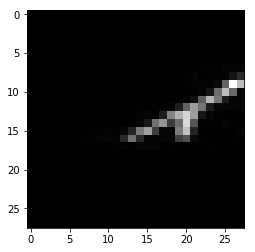

prediction D:/mnist/samples/cropped/0_30.png [[6.643503e-06]]
path D:/mnist/samples/cropped/0_30centered.png


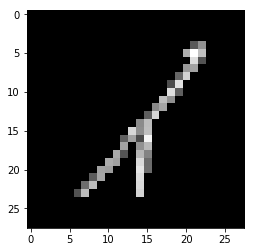

prediction D:/mnist/samples/cropped/0_30centered.png [[4.90877e-05]]
path D:/mnist/samples/cropped/107_111.png


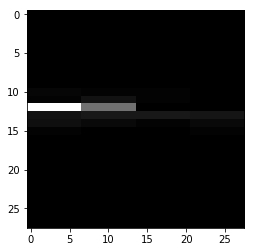

prediction D:/mnist/samples/cropped/107_111.png [[0.00019239]]
path D:/mnist/samples/cropped/107_111centered.png


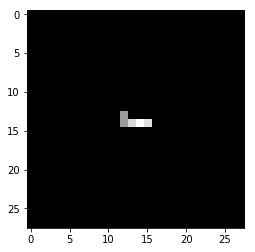

prediction D:/mnist/samples/cropped/107_111centered.png [[0.01343956]]
path D:/mnist/samples/cropped/30_43.png


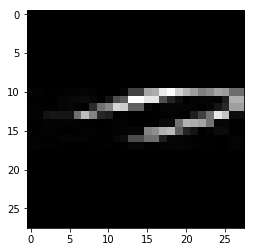

prediction D:/mnist/samples/cropped/30_43.png [[3.808721e-07]]
path D:/mnist/samples/cropped/30_43centered.png


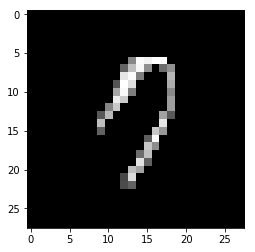

prediction D:/mnist/samples/cropped/30_43centered.png [[0.05827105]]
path D:/mnist/samples/cropped/43_46.png


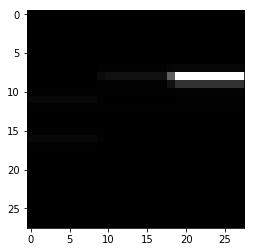

prediction D:/mnist/samples/cropped/43_46.png [[1.9446207e-09]]
path D:/mnist/samples/cropped/43_46centered.png


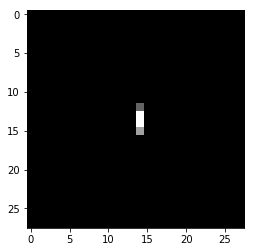

prediction D:/mnist/samples/cropped/43_46centered.png [[3.2264156e-06]]
path D:/mnist/samples/cropped/46_62.png


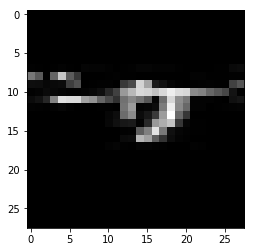

prediction D:/mnist/samples/cropped/46_62.png [[1.3948055e-17]]
path D:/mnist/samples/cropped/46_62centered.png


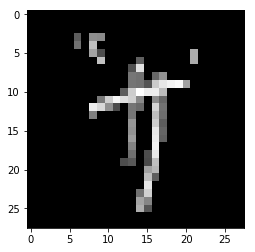

prediction D:/mnist/samples/cropped/46_62centered.png [[1.1154185e-06]]
path D:/mnist/samples/cropped/62_65.png


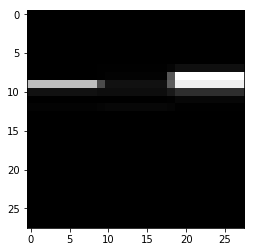

prediction D:/mnist/samples/cropped/62_65.png [[4.183438e-11]]
path D:/mnist/samples/cropped/62_65centered.png


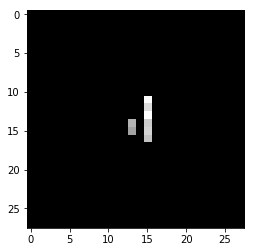

prediction D:/mnist/samples/cropped/62_65centered.png [[0.00014455]]
path D:/mnist/samples/cropped/65_81.png


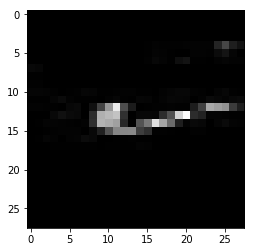

prediction D:/mnist/samples/cropped/65_81.png [[1.3950873e-05]]
path D:/mnist/samples/cropped/65_81centered.png


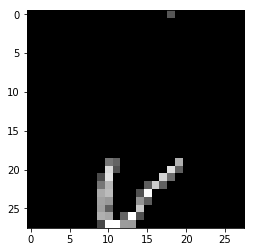

prediction D:/mnist/samples/cropped/65_81centered.png [[2.122397e-08]]
path D:/mnist/samples/cropped/81_86.png


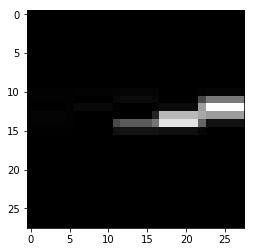

prediction D:/mnist/samples/cropped/81_86.png [[0.0055684]]
path D:/mnist/samples/cropped/81_86centered.png


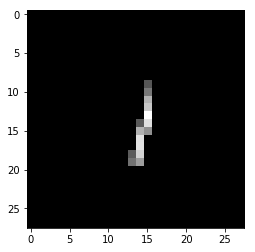

prediction D:/mnist/samples/cropped/81_86centered.png [[0.06022919]]
path D:/mnist/samples/cropped/86_97.png


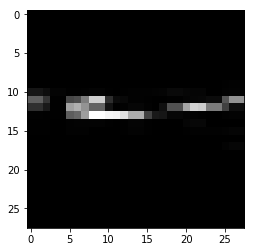

prediction D:/mnist/samples/cropped/86_97.png [[3.2677463e-06]]
path D:/mnist/samples/cropped/86_97centered.png


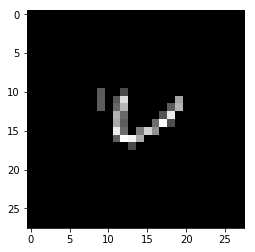

prediction D:/mnist/samples/cropped/86_97centered.png [[5.404786e-18]]
path D:/mnist/samples/cropped/97_107.png


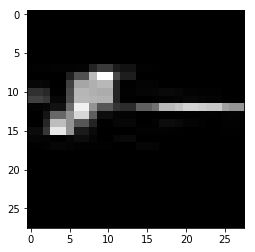

prediction D:/mnist/samples/cropped/97_107.png [[2.1737996e-10]]
path D:/mnist/samples/cropped/97_107centered.png


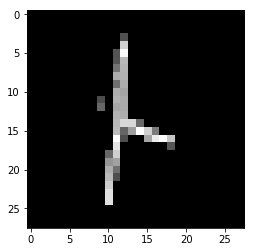

prediction D:/mnist/samples/cropped/97_107centered.png [[1.2546257e-11]]
path D:/mnist/samples/cropped/fu.png


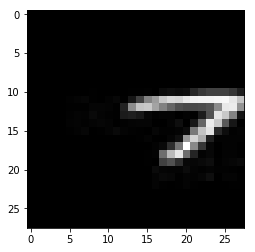

prediction D:/mnist/samples/cropped/fu.png [[0.80286413]]
path D:/mnist/samples/cropped/fu_28_28.png


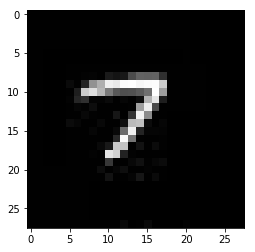

prediction D:/mnist/samples/cropped/fu_28_28.png [[0.9997402]]
path D:/mnist/samples/cropped/fu_28_28_2.png


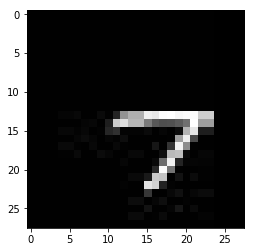

prediction D:/mnist/samples/cropped/fu_28_28_2.png [[1.]]
path D:/mnist/samples/cropped/i.png


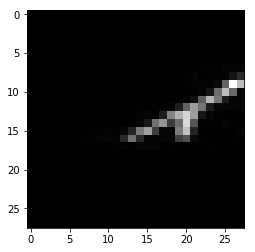

prediction D:/mnist/samples/cropped/i.png [[6.643503e-06]]
path D:/mnist/samples/cropped/ku.png


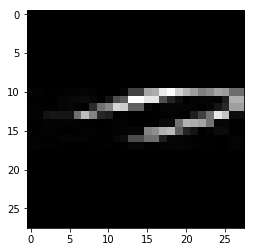

prediction D:/mnist/samples/cropped/ku.png [[3.808721e-07]]
path D:/mnist/samples/cropped/me.png


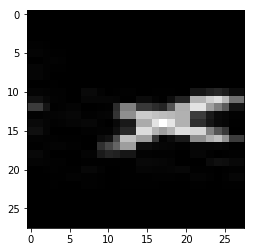

prediction D:/mnist/samples/cropped/me.png [[0.00058183]]
path D:/mnist/samples/cropped/n.png


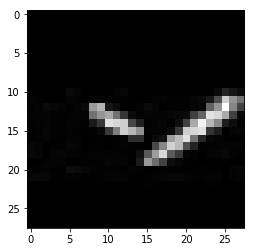

prediction D:/mnist/samples/cropped/n.png [[0.15253803]]
path D:/mnist/samples/cropped/no.png


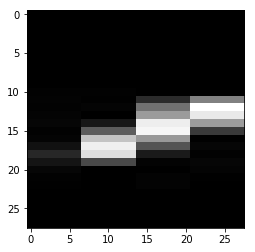

prediction D:/mnist/samples/cropped/no.png [[1.]]
path D:/mnist/samples/cropped/o.png


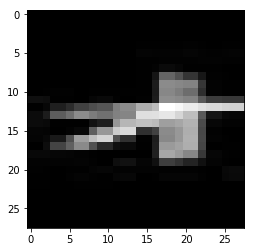

prediction D:/mnist/samples/cropped/o.png [[1.]]
path D:/mnist/samples/cropped/re.png


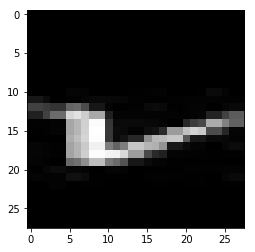

prediction D:/mnist/samples/cropped/re.png [[0.9999999]]
path D:/mnist/samples/cropped/re2.png


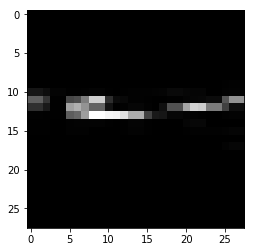

prediction D:/mnist/samples/cropped/re2.png [[3.2677463e-06]]
path D:/mnist/samples/cropped/re3.png


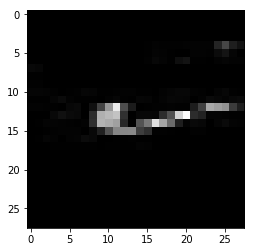

prediction D:/mnist/samples/cropped/re3.png [[1.3950873e-05]]
path D:/mnist/samples/cropped/ro.png


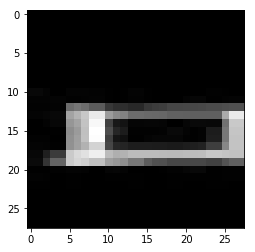

prediction D:/mnist/samples/cropped/ro.png [[1.]]
path D:/mnist/samples/cropped/sa.png


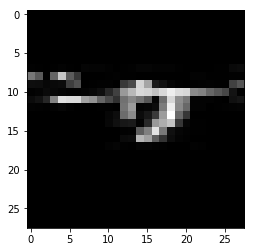

prediction D:/mnist/samples/cropped/sa.png [[1.3948055e-17]]
path D:/mnist/samples/cropped/so.png


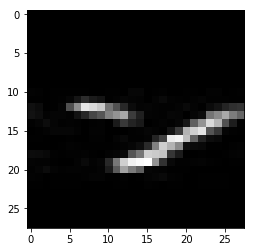

prediction D:/mnist/samples/cropped/so.png [[0.04610848]]
path D:/mnist/samples/cropped/test.png


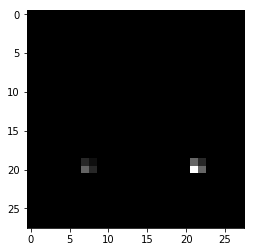

prediction D:/mnist/samples/cropped/test.png [[0.00010877]]
path D:/mnist/samples/cropped/test2.png


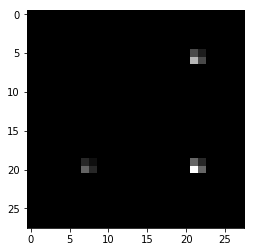

prediction D:/mnist/samples/cropped/test2.png [[1.7331975e-05]]
path D:/mnist/samples/cropped/test3.png


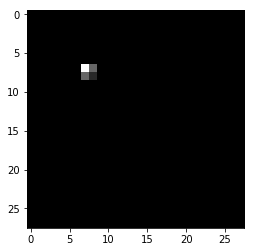

prediction D:/mnist/samples/cropped/test3.png [[0.5018429]]
path D:/mnist/samples/cropped/test4.png


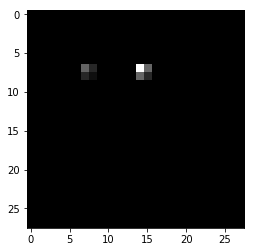

prediction D:/mnist/samples/cropped/test4.png [[0.00207765]]
path D:/mnist/samples/cropped/test5.png


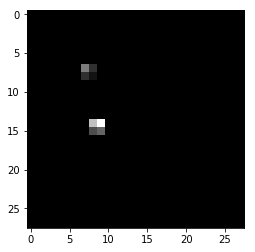

prediction D:/mnist/samples/cropped/test5.png [[0.00521084]]
path D:/mnist/samples/cropped/to.png


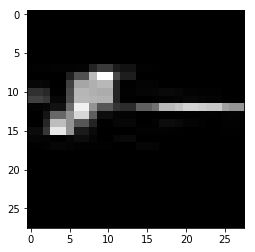

prediction D:/mnist/samples/cropped/to.png [[2.1737996e-10]]


In [151]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist/samples/cropped/")

D:/mnist2020/g_set/chi.png D:/mnist2020/g_set/chi_manual.png D:/mnist2020/g_set/ha.png D:/mnist2020/g_set/hi.png D:/mnist2020/g_set/hi_2.png D:/mnist2020/g_set/i.png D:/mnist2020/g_set/i_2.png D:/mnist2020/g_set/ki.png D:/mnist2020/g_set/mo.png D:/mnist2020/g_set/na.png D:/mnist2020/g_set/re.png D:/mnist2020/g_set/ru.png D:/mnist2020/g_set/sa.png D:/mnist2020/g_set/sa_2.png D:/mnist2020/g_set/sa_3.png D:/mnist2020/g_set/shi.png D:/mnist2020/g_set/u.png D:/mnist2020/g_set/wa.png
path D:/mnist2020/g_set/chi.png


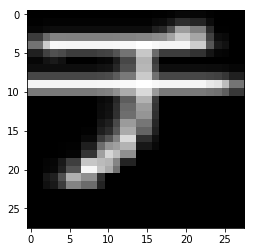

prediction D:/mnist2020/g_set/chi.png [[3.763439e-14]]
path D:/mnist2020/g_set/chi_manual.png


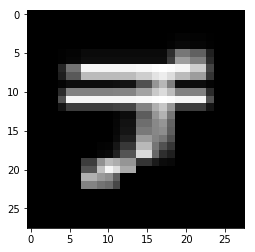

prediction D:/mnist2020/g_set/chi_manual.png [[0.99959546]]
path D:/mnist2020/g_set/ha.png


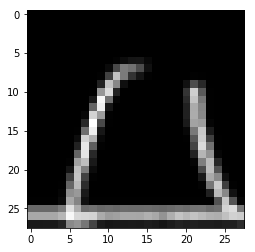

prediction D:/mnist2020/g_set/ha.png [[1.]]
path D:/mnist2020/g_set/hi.png


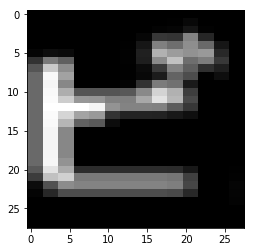

prediction D:/mnist2020/g_set/hi.png [[0.17961031]]
path D:/mnist2020/g_set/hi_2.png


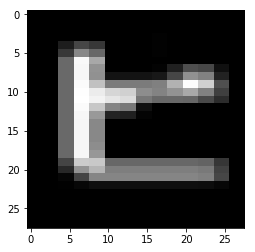

prediction D:/mnist2020/g_set/hi_2.png [[1.]]
path D:/mnist2020/g_set/i.png


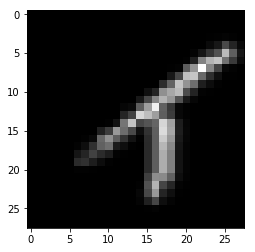

prediction D:/mnist2020/g_set/i.png [[1.]]
path D:/mnist2020/g_set/i_2.png


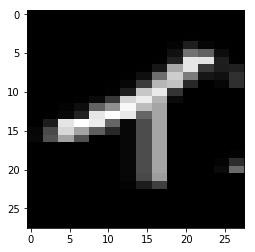

prediction D:/mnist2020/g_set/i_2.png [[4.008505e-11]]
path D:/mnist2020/g_set/ki.png


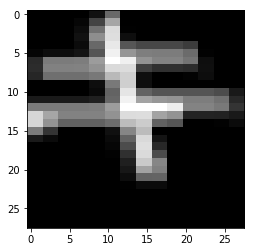

prediction D:/mnist2020/g_set/ki.png [[0.00069732]]
path D:/mnist2020/g_set/mo.png


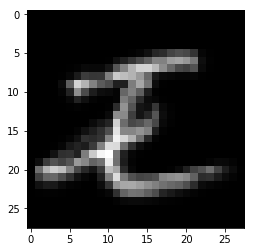

prediction D:/mnist2020/g_set/mo.png [[1.]]
path D:/mnist2020/g_set/na.png


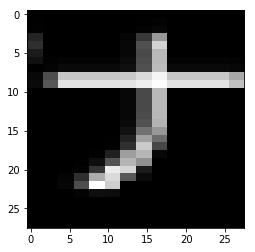

prediction D:/mnist2020/g_set/na.png [[2.2527076e-13]]
path D:/mnist2020/g_set/re.png


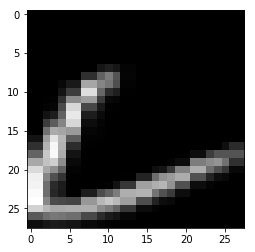

prediction D:/mnist2020/g_set/re.png [[6.127233e-05]]
path D:/mnist2020/g_set/ru.png


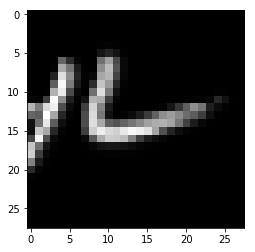

prediction D:/mnist2020/g_set/ru.png [[0.70837575]]
path D:/mnist2020/g_set/sa.png


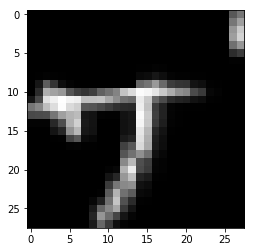

prediction D:/mnist2020/g_set/sa.png [[0.9999093]]
path D:/mnist2020/g_set/sa_2.png


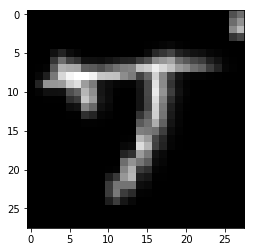

prediction D:/mnist2020/g_set/sa_2.png [[0.24816734]]
path D:/mnist2020/g_set/sa_3.png


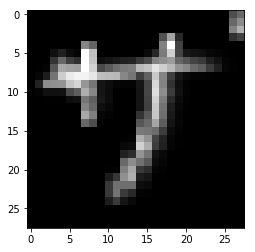

prediction D:/mnist2020/g_set/sa_3.png [[0.05542393]]
path D:/mnist2020/g_set/shi.png


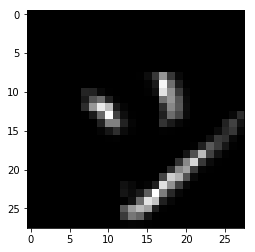

prediction D:/mnist2020/g_set/shi.png [[1.]]
path D:/mnist2020/g_set/u.png


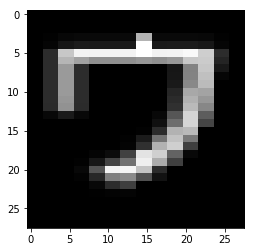

prediction D:/mnist2020/g_set/u.png [[2.8310796e-13]]
path D:/mnist2020/g_set/wa.png


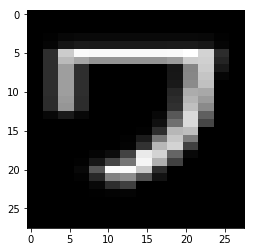

prediction D:/mnist2020/g_set/wa.png [[1.2606002e-12]]


In [155]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist2020/g_set/")

D:/mnist2020/h_set/a.png D:/mnist2020/h_set/e.png D:/mnist2020/h_set/hu.png D:/mnist2020/h_set/ma.png D:/mnist2020/h_set/mu.png D:/mnist2020/h_set/o.png D:/mnist2020/h_set/ri.png D:/mnist2020/h_set/ru.png D:/mnist2020/h_set/su.png D:/mnist2020/h_set/su_2.png D:/mnist2020/h_set/ta.png D:/mnist2020/h_set/te.png D:/mnist2020/h_set/to.png
path D:/mnist2020/h_set/a.png


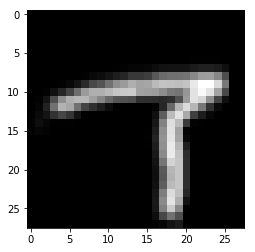

prediction D:/mnist2020/h_set/a.png [[1.]]
path D:/mnist2020/h_set/e.png


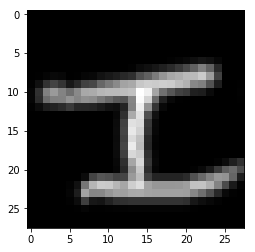

prediction D:/mnist2020/h_set/e.png [[1.]]
path D:/mnist2020/h_set/hu.png


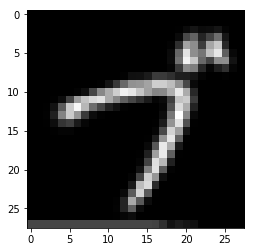

prediction D:/mnist2020/h_set/hu.png [[1.]]
path D:/mnist2020/h_set/ma.png


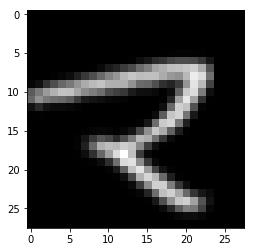

prediction D:/mnist2020/h_set/ma.png [[1.]]
path D:/mnist2020/h_set/mu.png


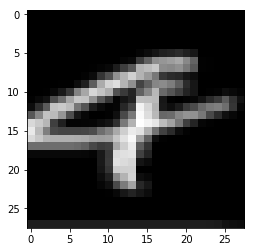

prediction D:/mnist2020/h_set/mu.png [[1.]]
path D:/mnist2020/h_set/o.png


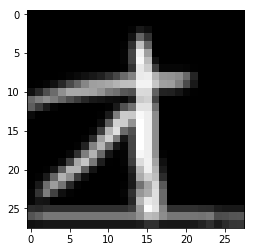

prediction D:/mnist2020/h_set/o.png [[1.]]
path D:/mnist2020/h_set/ri.png


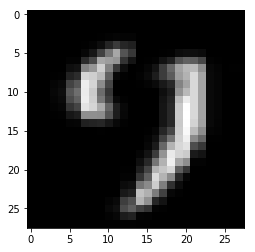

prediction D:/mnist2020/h_set/ri.png [[1.]]
path D:/mnist2020/h_set/ru.png


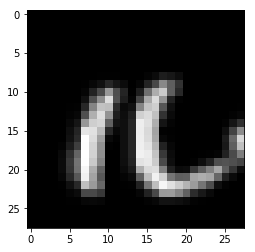

prediction D:/mnist2020/h_set/ru.png [[1.]]
path D:/mnist2020/h_set/su.png


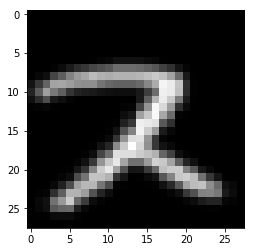

prediction D:/mnist2020/h_set/su.png [[1.]]
path D:/mnist2020/h_set/su_2.png


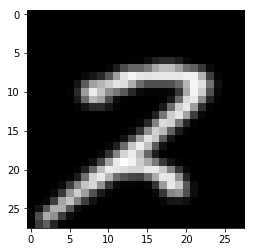

prediction D:/mnist2020/h_set/su_2.png [[1.]]
path D:/mnist2020/h_set/ta.png


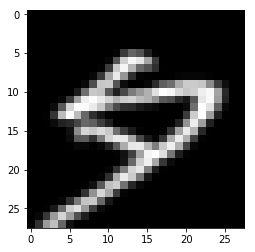

prediction D:/mnist2020/h_set/ta.png [[1.]]
path D:/mnist2020/h_set/te.png


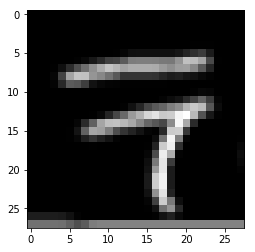

prediction D:/mnist2020/h_set/te.png [[1.]]
path D:/mnist2020/h_set/to.png


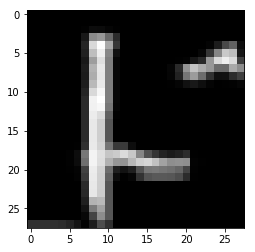

prediction D:/mnist2020/h_set/to.png [[1.]]


In [154]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist2020/h_set/")

path D:/ganmnist/test/x.png


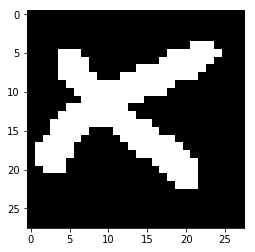

prediction D:/ganmnist/test/x.png [[4.788007e-34]]
path D:/ganmnist/test/x1.png


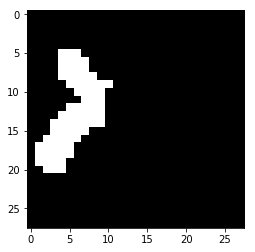

prediction D:/ganmnist/test/x1.png [[2.5638023e-35]]
path D:/ganmnist/test/white.png


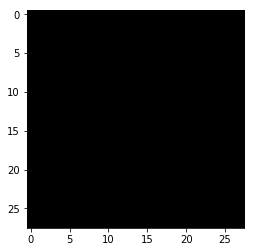

prediction D:/ganmnist/test/white.png [[0.52591103]]
path D:/ganmnist/test/black.png


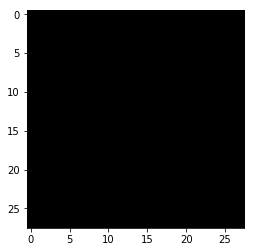

prediction D:/ganmnist/test/black.png [[0.94593453]]


In [45]:
test_image("D:/ganmnist/test/x.png")
test_image("D:/ganmnist/test/x1.png")
test_image("D:/ganmnist/test/white.png")
test_image("D:/ganmnist/test/black.png")

path D:/ganmnist/test/x.png


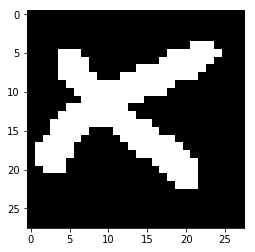

prediction D:/ganmnist/test/x.png [[1.]]
path D:/ganmnist/test/x1.png


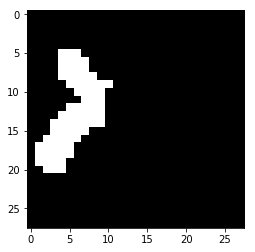

prediction D:/ganmnist/test/x1.png [[2.9675984e-06]]
path D:/ganmnist/test/white.png


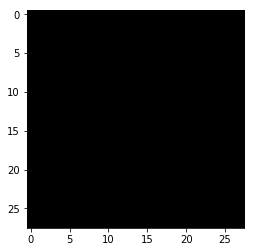

prediction D:/ganmnist/test/white.png [[0.4807612]]
path D:/ganmnist/test/black.png


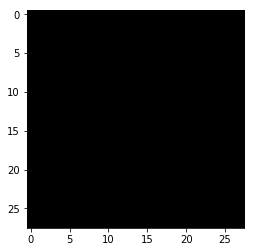

prediction D:/ganmnist/test/black.png [[1.]]


In [47]:
test_image("D:/ganmnist/test/x.png")
test_image("D:/ganmnist/test/x1.png")
test_image("D:/ganmnist/test/white.png")
test_image("D:/ganmnist/test/black.png")


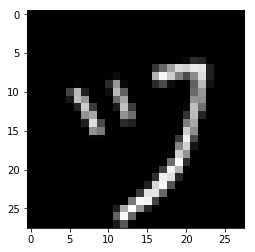

array([[1.]], dtype=float32)

In [38]:
image = cv2.imread('D:/ganmnist/test/x.png')
image = ~image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image,cmap='gray')
plt.show()
print(image.shape)
predict_imgs =np.array( [image.reshape(28,28,1)])
d_model.predict(predict_imgs)

predict_imgs =np.array( [img.reshape(28,28,1)])
d_model.predict(predict_imgs)
(trainX, _), (_, _) = load_data()

plt.imshow(reshaped[0],cmap='gray')
plt.show()
img = reshaped[0]
predict_imgs =np.array( [img.reshape(28,28,1)])
d_model.predict(predict_imgs)

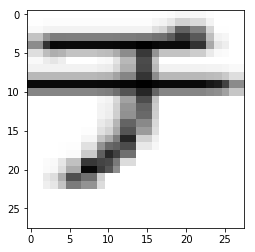

True

In [227]:
image = cv2.imread('D:/mnist2020/g_set/chi.png')
image = cv2.resize(image, (28,28), interpolation = cv2.INTER_AREA)
#image = ~image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image,cmap='gray')
plt.show()
cv2.imwrite('D:/messigray.png',image)


x_offset 4  y_offset 4


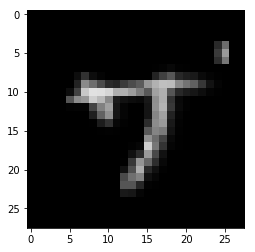

In [311]:
"""s_img = cv2.imread('D:/mnist2020/g_set/chi.png')
s_img = ~s_img
l_img = cv2.imread('D:/mnist2020/g_set/black_mask.png')
x_offset=y_offset=7
l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
l_img = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY) 
plt.imshow(l_img,cmap='gray')
plt.show()
"""

def center_img(path,offset):
    s_img = cv2.imread(path)
    s_img = ~s_img
    #l_img = cv2.imread('D:/mnist2020/g_set/black_mask.png')
    l_img = np.zeros((28, 28, 3),dtype=np.uint8)
    x_offset = int((l_img.shape[0] - s_img.shape[0]) / 2)
    y_offset = int((l_img.shape[1] - s_img.shape[1]) / 2)
    if offset > 0:
        x_offset = offset
        y_offset = offset
    print("x_offset",x_offset," y_offset",y_offset)
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    l_img = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY) 
    return np.array(l_img).reshape(1,28,28)

def resize_center_img(path):
    s_img = cv2.imread(path)
    s_img = cv2.resize(s_img, (22,22), interpolation = cv2.INTER_AREA)
    
    #l_img = cv2.imread('D:/mnist2020/g_set/white_mask.png')
    l_img = np.full((28, 28,3), 255,dtype=np.uint8)
    x_offset = 4
    y_offset = 4

    print("x_offset",x_offset," y_offset",y_offset)
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    #l_img = cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY) 
    return l_img


image = resize_center_img("D:/mnist2020/g_set/sa_2.png")
#plt.imshow(res,cmap='gray')
#plt.show()
#res.shape
#image = resize_center_img(path)
image = ~image
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray')

 wrong 0  --  3.0788572e-13


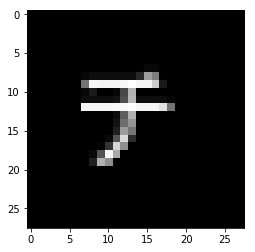

wrong_count : 1


In [194]:
r  = test_images("D:/ganmnist/generatorX_model_030.h5",np.array(l_img).reshape(1,28,28),True)

x_offset 7  y_offset 7
 wrong 0  --  3.0788572e-13


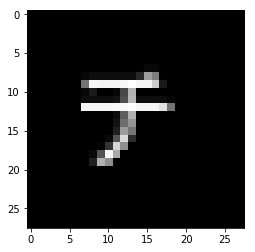

wrong_count : 1
[3.0788572e-13]
x_offset 10  y_offset 10
wrong_count : 0
[0.9996345]
x_offset 6  y_offset 8
 wrong 0  --  1.7913395e-08


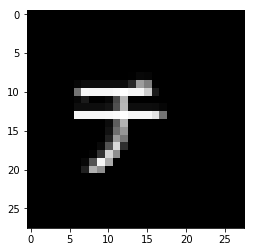

wrong_count : 1
[1.7913395e-08]


In [210]:
r1  = test_images("D:/ganmnist/generatorX_model_030.h5",center_img('D:/mnist2020/g_set/chi.png',7),True)
print(r1)
r2  = test_images("D:/ganmnist/generatorX_model_030.h5",center_img('D:/mnist2020/g_set/chi.png',10),True)
print(r2)
r3  = test_images("D:/ganmnist/generatorX_model_030.h5",center_img('D:/mnist2020/g_set/chi.png',0),True)
print(r3)

x_offset 7  y_offset 7


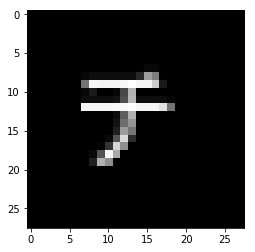

In [300]:
ii = center_img('D:/mnist2020/g_set/chi.png',7)
plt.imshow(ii.reshape(28,28),cmap='gray')
plt.show()

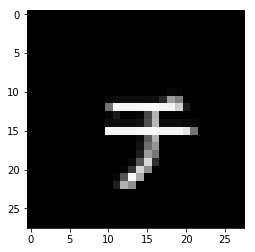

In [199]:
ii = center_img('D:/mnist2020/g_set/chi.png',10)
plt.imshow(ii.reshape(28,28),cmap='gray')
plt.show()

In [201]:
s_img = cv2.imread('D:/mnist2020/g_set/chi.png')

x_offset 6  y_offset 8


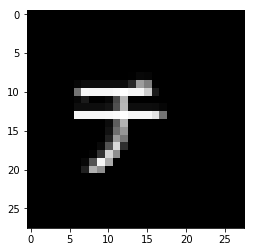

In [212]:
ss = center_img('D:/mnist2020/g_set/chi.png',0)
plt.imshow(ss.reshape(28,28),cmap='gray')
plt.show()

x_offset 10  y_offset 10


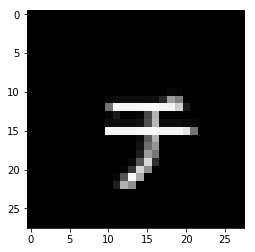

In [213]:
ss = center_img('D:/mnist2020/g_set/chi.png',10)
plt.imshow(ss.reshape(28,28),cmap='gray')
plt.show()

x_offset 4  y_offset 4
 wrong 0  --  0.00030644258


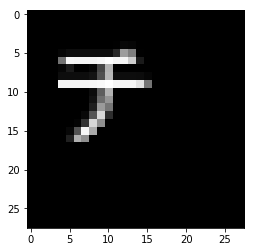

wrong_count : 1
[0.00030644258]
x_offset 5  y_offset 5
 wrong 0  --  1.2845562e-06


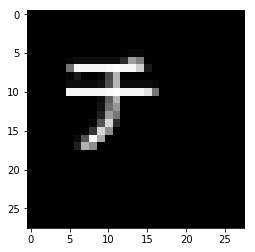

wrong_count : 1
[1.2845562e-06]
x_offset 6  y_offset 6
 wrong 0  --  0.005712482


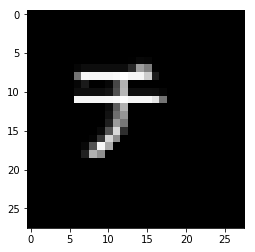

wrong_count : 1
[0.005712482]
x_offset 7  y_offset 7
 wrong 0  --  3.0788572e-13


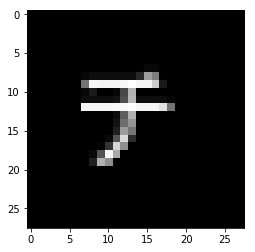

wrong_count : 1
[3.0788572e-13]
x_offset 8  y_offset 8
 wrong 0  --  0.3840965


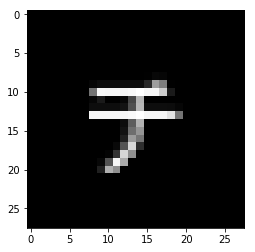

wrong_count : 1
[0.3840965]
x_offset 9  y_offset 9
wrong_count : 0
[0.999897]
x_offset 10  y_offset 10
wrong_count : 0
[0.9996345]
x_offset 11  y_offset 11
wrong_count : 0
[0.99931026]


In [218]:
for i in range(4,12):
    r3  = test_images("D:/ganmnist/generatorX_model_030.h5",center_img('D:/mnist2020/g_set/chi.png',i),True)
    print(r3)

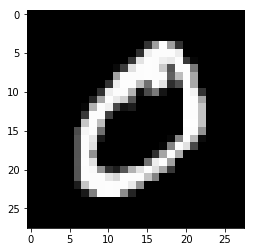

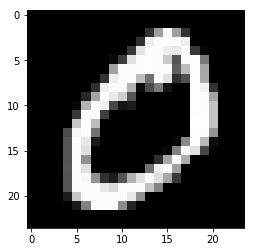

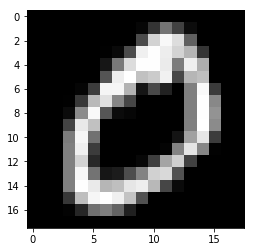

(18, 18)

In [254]:

def crop_resize(orig_img):
    plt.imshow(orig_img,cmap='gray')
    plt.show()
    y = 2
    x = 2
    h = 24
    w = 24
    crop_img = orig_img[y:y+h, x:x+w]
    plt.imshow(crop_img,cmap='gray')
    plt.show()
    resized_image = cv2.resize(crop_img, (18,18), interpolation = cv2.INTER_AREA)
    plt.imshow(resized_image,cmap='gray')
    plt.show()
    return resized_image

def crop_resize(orig_img):
    plt.imshow(orig_img,cmap='gray')
    plt.show()
    y = 2
    x = 2
    h = 24
    w = 24
    crop_img = orig_img[y:y+h, x:x+w]
    plt.imshow(crop_img,cmap='gray')
    plt.show()
    resized_image = cv2.resize(crop_img, (18,18), interpolation = cv2.INTER_AREA)
    plt.imshow(resized_image,cmap='gray')
    plt.show()
    return resized_image

rr = crop_resize(trainX[1])
rr.shape

(28, 28)

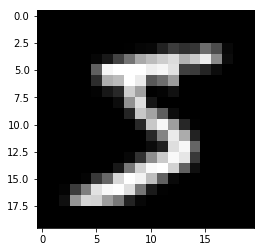

In [245]:
image = trainX[0]
image = cv2.resize(image, (20,20), interpolation = cv2.INTER_AREA)
plt.imshow(image,cmap='gray')
plt.show()

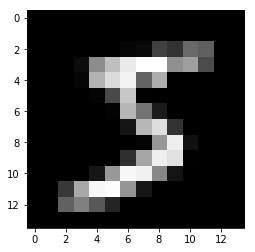

In [243]:
image = trainX[0]
image = cv2.resize(image, (14,14), interpolation = cv2.INTER_AREA)
plt.imshow(image,cmap='gray')
plt.show()

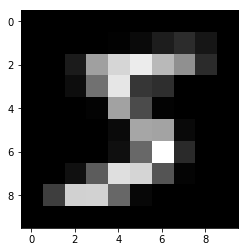

In [224]:
image = trainX[0]
image = cv2.resize(image, (10,10), interpolation = cv2.INTER_AREA)
plt.imshow(image,cmap='gray')
plt.show()

path D:/mnist2020/g_set/chi_resized.png


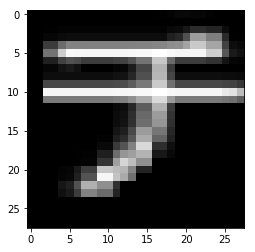

prediction D:/mnist2020/g_set/chi_resized.png [[0.9998597]]


In [230]:
test_files("D:/ganmnist/generatorX_model_030.h5",["D:/mnist2020/g_set/chi_resized.png"]) 

path D:/mnist2020/code_split/ROI_0.png


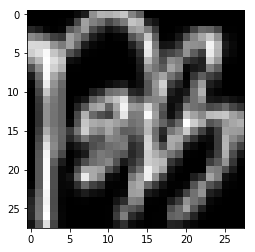

prediction D:/mnist2020/code_split/ROI_0.png [[3.6622144e-17]]
path D:/mnist2020/code_split/ROI_1.png


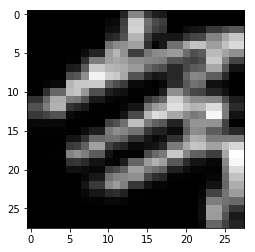

prediction D:/mnist2020/code_split/ROI_1.png [[1.]]
path D:/mnist2020/code_split/ROI_10.png


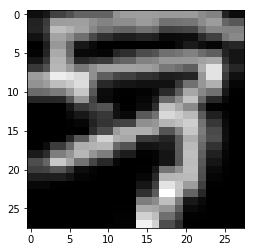

prediction D:/mnist2020/code_split/ROI_10.png [[1.]]
path D:/mnist2020/code_split/ROI_11.png


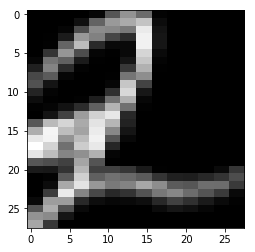

prediction D:/mnist2020/code_split/ROI_11.png [[5.259629e-12]]
path D:/mnist2020/code_split/ROI_12.png


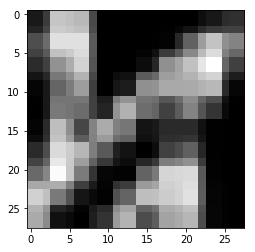

prediction D:/mnist2020/code_split/ROI_12.png [[0.9999995]]
path D:/mnist2020/code_split/ROI_13.png


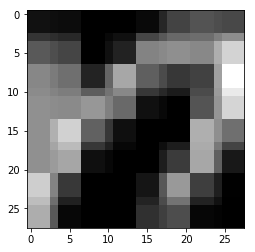

prediction D:/mnist2020/code_split/ROI_13.png [[0.999984]]
path D:/mnist2020/code_split/ROI_14.png


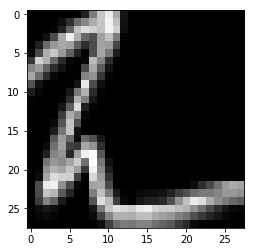

prediction D:/mnist2020/code_split/ROI_14.png [[0.0004787]]
path D:/mnist2020/code_split/ROI_15.png


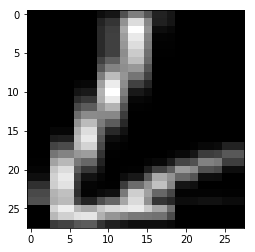

prediction D:/mnist2020/code_split/ROI_15.png [[1.]]
path D:/mnist2020/code_split/ROI_16.png


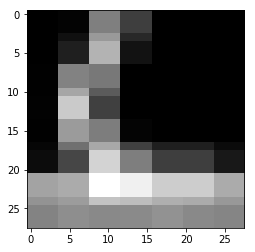

prediction D:/mnist2020/code_split/ROI_16.png [[1.]]
path D:/mnist2020/code_split/ROI_17.png


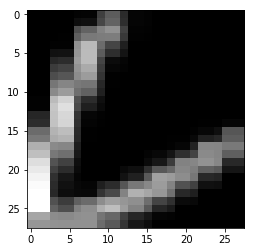

prediction D:/mnist2020/code_split/ROI_17.png [[0.9967469]]
path D:/mnist2020/code_split/ROI_18.png


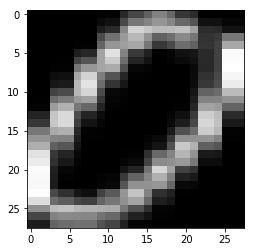

prediction D:/mnist2020/code_split/ROI_18.png [[0.293886]]
path D:/mnist2020/code_split/ROI_19.png


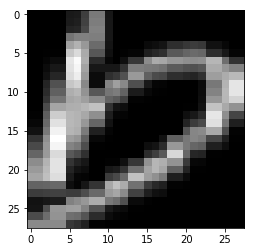

prediction D:/mnist2020/code_split/ROI_19.png [[1.322299e-10]]
path D:/mnist2020/code_split/ROI_2.png


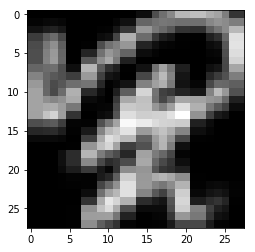

prediction D:/mnist2020/code_split/ROI_2.png [[1.]]
path D:/mnist2020/code_split/ROI_20.png


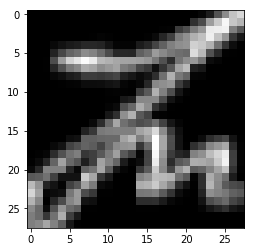

prediction D:/mnist2020/code_split/ROI_20.png [[0.5221618]]
path D:/mnist2020/code_split/ROI_21.png


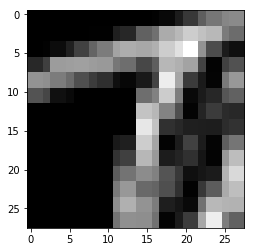

prediction D:/mnist2020/code_split/ROI_21.png [[1.]]
path D:/mnist2020/code_split/ROI_22.png


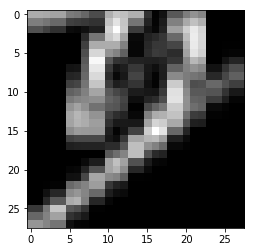

prediction D:/mnist2020/code_split/ROI_22.png [[0.9975547]]
path D:/mnist2020/code_split/ROI_23.png


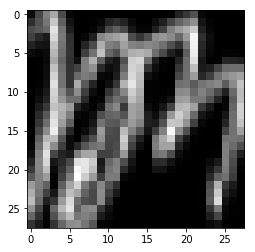

prediction D:/mnist2020/code_split/ROI_23.png [[1.881295e-18]]
path D:/mnist2020/code_split/ROI_24.png


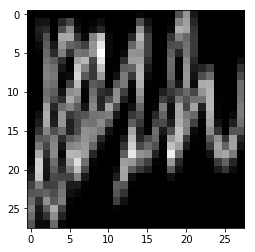

prediction D:/mnist2020/code_split/ROI_24.png [[7.591971e-09]]
path D:/mnist2020/code_split/ROI_25.png


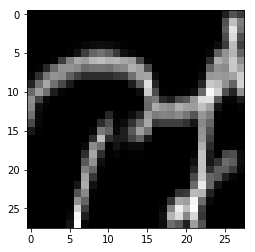

prediction D:/mnist2020/code_split/ROI_25.png [[0.51810104]]
path D:/mnist2020/code_split/ROI_26.png


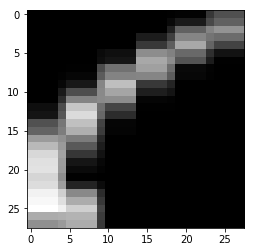

prediction D:/mnist2020/code_split/ROI_26.png [[1.]]
path D:/mnist2020/code_split/ROI_27.png


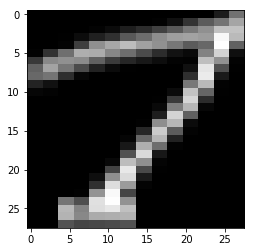

prediction D:/mnist2020/code_split/ROI_27.png [[8.678247e-12]]
path D:/mnist2020/code_split/ROI_28.png


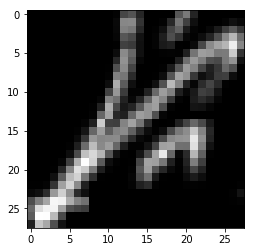

prediction D:/mnist2020/code_split/ROI_28.png [[1.]]
path D:/mnist2020/code_split/ROI_29.png


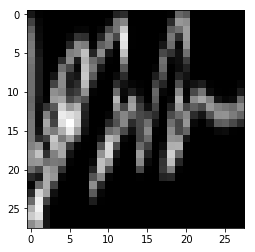

prediction D:/mnist2020/code_split/ROI_29.png [[7.2745233e-16]]
path D:/mnist2020/code_split/ROI_3.png


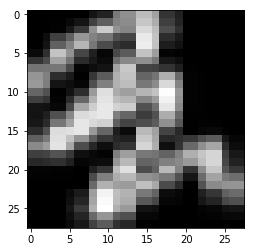

prediction D:/mnist2020/code_split/ROI_3.png [[1.]]
path D:/mnist2020/code_split/ROI_30.png


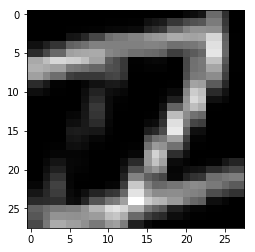

prediction D:/mnist2020/code_split/ROI_30.png [[1.8789607e-10]]
path D:/mnist2020/code_split/ROI_31.png


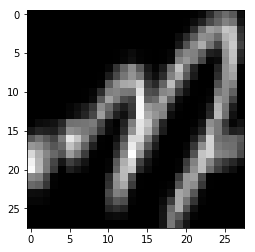

prediction D:/mnist2020/code_split/ROI_31.png [[1.]]
path D:/mnist2020/code_split/ROI_32.png


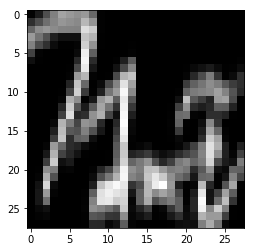

prediction D:/mnist2020/code_split/ROI_32.png [[1.932033e-08]]
path D:/mnist2020/code_split/ROI_33.png


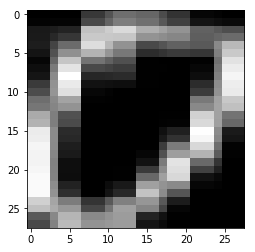

prediction D:/mnist2020/code_split/ROI_33.png [[9.34246e-06]]
path D:/mnist2020/code_split/ROI_34.png


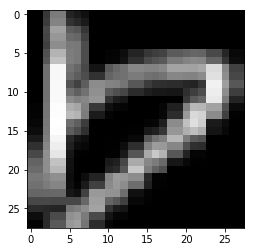

prediction D:/mnist2020/code_split/ROI_34.png [[1.6443497e-15]]
path D:/mnist2020/code_split/ROI_35.png


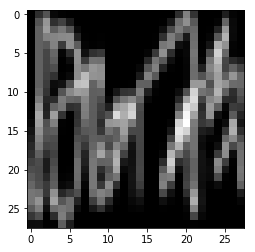

prediction D:/mnist2020/code_split/ROI_35.png [[1.9540021e-38]]
path D:/mnist2020/code_split/ROI_36.png


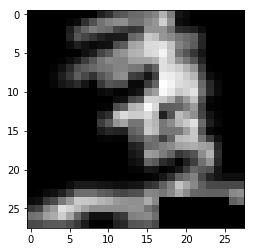

prediction D:/mnist2020/code_split/ROI_36.png [[1.]]
path D:/mnist2020/code_split/ROI_37.png


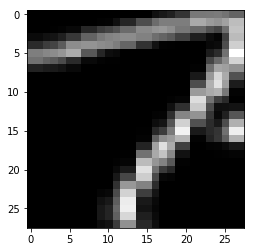

prediction D:/mnist2020/code_split/ROI_37.png [[1.4829888e-20]]
path D:/mnist2020/code_split/ROI_38.png


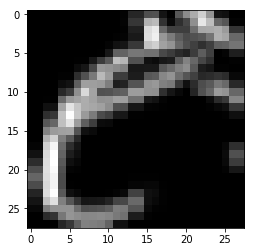

prediction D:/mnist2020/code_split/ROI_38.png [[3.1811158e-08]]
path D:/mnist2020/code_split/ROI_39.png


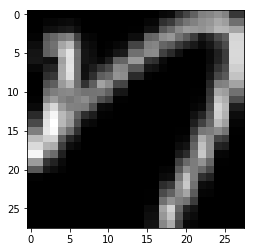

prediction D:/mnist2020/code_split/ROI_39.png [[1.9603588e-20]]
path D:/mnist2020/code_split/ROI_4.png


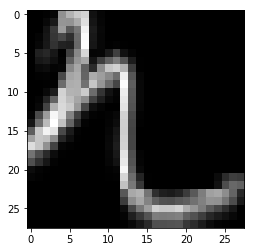

prediction D:/mnist2020/code_split/ROI_4.png [[1.8857787e-05]]
path D:/mnist2020/code_split/ROI_40.png


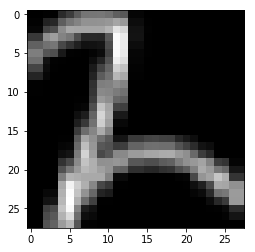

prediction D:/mnist2020/code_split/ROI_40.png [[8.4337405e-11]]
path D:/mnist2020/code_split/ROI_41.png


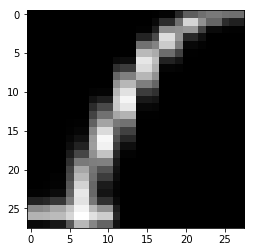

prediction D:/mnist2020/code_split/ROI_41.png [[0.9858855]]
path D:/mnist2020/code_split/ROI_42.png


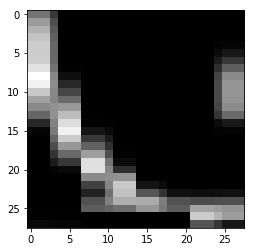

prediction D:/mnist2020/code_split/ROI_42.png [[3.8002305e-08]]
path D:/mnist2020/code_split/ROI_43.png


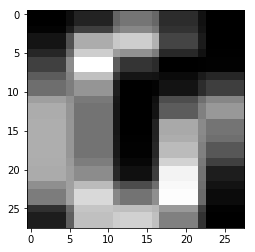

prediction D:/mnist2020/code_split/ROI_43.png [[1.]]
path D:/mnist2020/code_split/ROI_44.png


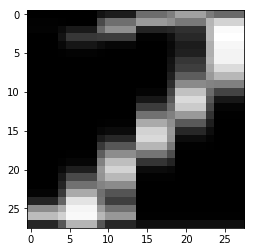

prediction D:/mnist2020/code_split/ROI_44.png [[1.]]
path D:/mnist2020/code_split/ROI_45.png


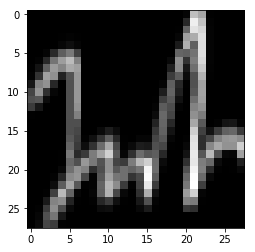

prediction D:/mnist2020/code_split/ROI_45.png [[0.9999988]]
path D:/mnist2020/code_split/ROI_5.png


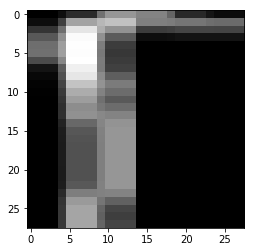

prediction D:/mnist2020/code_split/ROI_5.png [[0.02410605]]
path D:/mnist2020/code_split/ROI_6.png


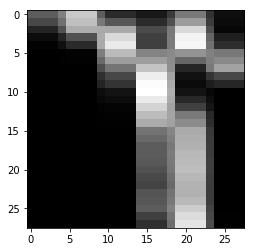

prediction D:/mnist2020/code_split/ROI_6.png [[1.]]
path D:/mnist2020/code_split/ROI_7.png


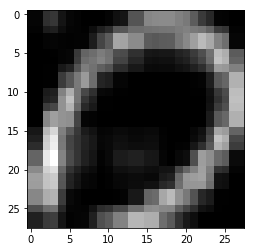

prediction D:/mnist2020/code_split/ROI_7.png [[2.2443284e-16]]
path D:/mnist2020/code_split/ROI_8.png


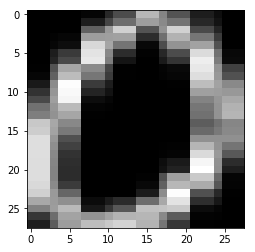

prediction D:/mnist2020/code_split/ROI_8.png [[2.5063562e-05]]
path D:/mnist2020/code_split/ROI_9.png


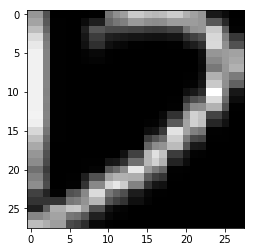

prediction D:/mnist2020/code_split/ROI_9.png [[7.251186e-26]]


In [255]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist2020/code_split/")

path D:/mnist2020/code_split/ROI_0.png
x_offset 2  y_offset 2


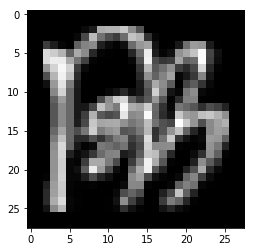

prediction D:/mnist2020/code_split/ROI_0.png [[0.99999845]]
path D:/mnist2020/code_split/ROI_1.png
x_offset 2  y_offset 2


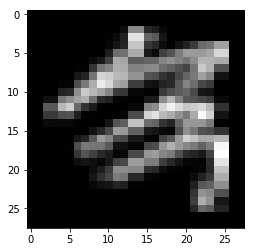

prediction D:/mnist2020/code_split/ROI_1.png [[1.]]
path D:/mnist2020/code_split/ROI_10.png
x_offset 2  y_offset 2


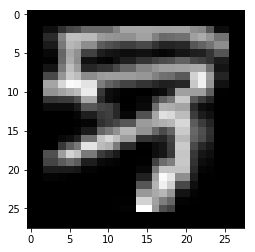

prediction D:/mnist2020/code_split/ROI_10.png [[1.]]
path D:/mnist2020/code_split/ROI_11.png
x_offset 2  y_offset 2


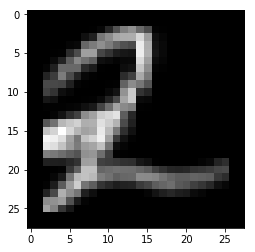

prediction D:/mnist2020/code_split/ROI_11.png [[0.9999995]]
path D:/mnist2020/code_split/ROI_12.png
x_offset 2  y_offset 2


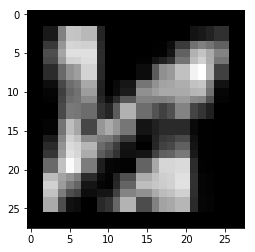

prediction D:/mnist2020/code_split/ROI_12.png [[0.9999995]]
path D:/mnist2020/code_split/ROI_13.png
x_offset 2  y_offset 2


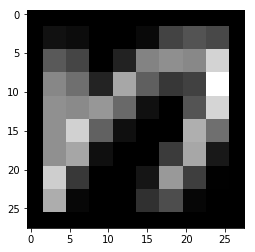

prediction D:/mnist2020/code_split/ROI_13.png [[0.5922557]]
path D:/mnist2020/code_split/ROI_14.png
x_offset 2  y_offset 2


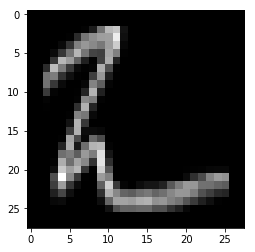

prediction D:/mnist2020/code_split/ROI_14.png [[0.9999976]]
path D:/mnist2020/code_split/ROI_15.png
x_offset 2  y_offset 2


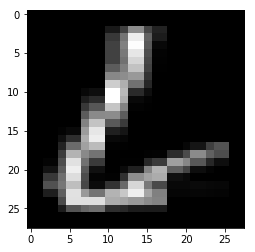

prediction D:/mnist2020/code_split/ROI_15.png [[1.]]
path D:/mnist2020/code_split/ROI_16.png
x_offset 2  y_offset 2


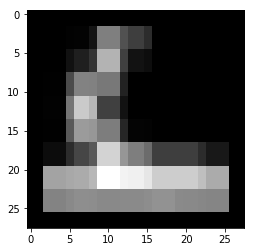

prediction D:/mnist2020/code_split/ROI_16.png [[1.]]
path D:/mnist2020/code_split/ROI_17.png
x_offset 2  y_offset 2


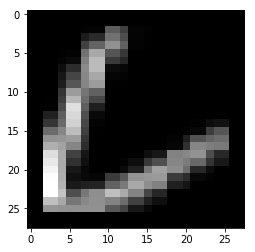

prediction D:/mnist2020/code_split/ROI_17.png [[0.9994236]]
path D:/mnist2020/code_split/ROI_18.png
x_offset 2  y_offset 2


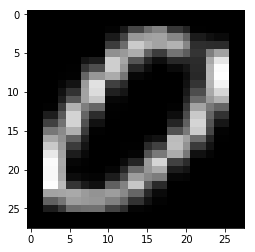

prediction D:/mnist2020/code_split/ROI_18.png [[0.11264258]]
path D:/mnist2020/code_split/ROI_19.png
x_offset 2  y_offset 2


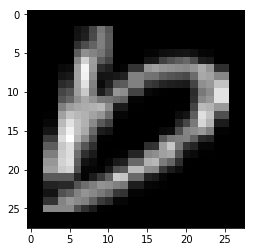

prediction D:/mnist2020/code_split/ROI_19.png [[0.9999993]]
path D:/mnist2020/code_split/ROI_2.png
x_offset 2  y_offset 2


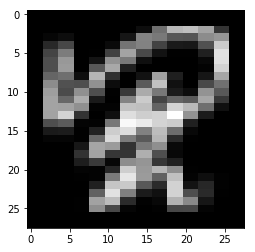

prediction D:/mnist2020/code_split/ROI_2.png [[1.]]
path D:/mnist2020/code_split/ROI_20.png
x_offset 2  y_offset 2


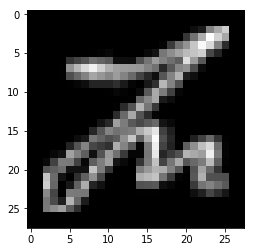

prediction D:/mnist2020/code_split/ROI_20.png [[1.]]
path D:/mnist2020/code_split/ROI_21.png
x_offset 2  y_offset 2


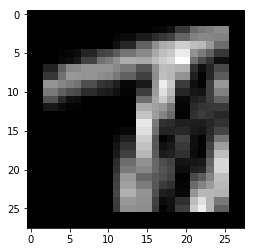

prediction D:/mnist2020/code_split/ROI_21.png [[1.]]
path D:/mnist2020/code_split/ROI_22.png
x_offset 2  y_offset 2


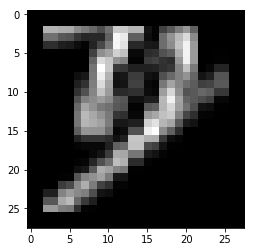

prediction D:/mnist2020/code_split/ROI_22.png [[1.]]
path D:/mnist2020/code_split/ROI_23.png
x_offset 2  y_offset 2


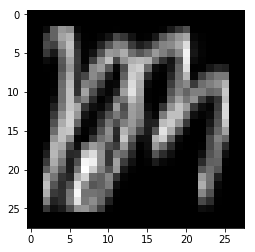

prediction D:/mnist2020/code_split/ROI_23.png [[1.]]
path D:/mnist2020/code_split/ROI_24.png
x_offset 2  y_offset 2


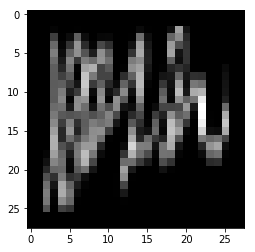

prediction D:/mnist2020/code_split/ROI_24.png [[1.]]
path D:/mnist2020/code_split/ROI_25.png
x_offset 2  y_offset 2


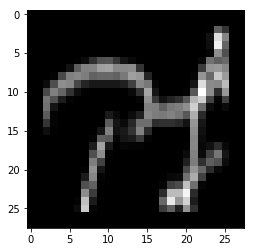

prediction D:/mnist2020/code_split/ROI_25.png [[3.2457906e-06]]
path D:/mnist2020/code_split/ROI_26.png
x_offset 2  y_offset 2


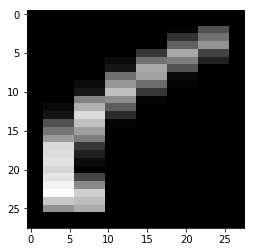

prediction D:/mnist2020/code_split/ROI_26.png [[1.2100931e-10]]
path D:/mnist2020/code_split/ROI_27.png
x_offset 2  y_offset 2


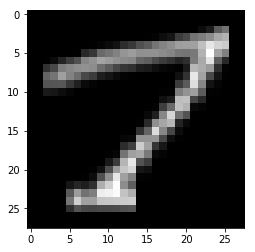

prediction D:/mnist2020/code_split/ROI_27.png [[1.]]
path D:/mnist2020/code_split/ROI_28.png
x_offset 2  y_offset 2


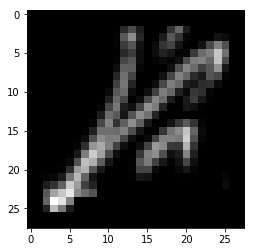

prediction D:/mnist2020/code_split/ROI_28.png [[1.]]
path D:/mnist2020/code_split/ROI_29.png
x_offset 2  y_offset 2


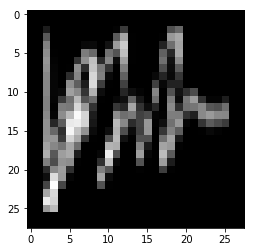

prediction D:/mnist2020/code_split/ROI_29.png [[3.401033e-11]]
path D:/mnist2020/code_split/ROI_3.png
x_offset 2  y_offset 2


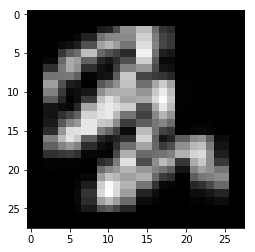

prediction D:/mnist2020/code_split/ROI_3.png [[1.]]
path D:/mnist2020/code_split/ROI_30.png
x_offset 2  y_offset 2


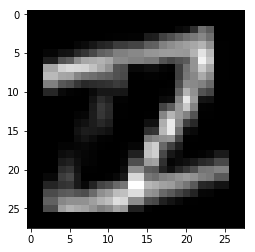

prediction D:/mnist2020/code_split/ROI_30.png [[1.]]
path D:/mnist2020/code_split/ROI_31.png
x_offset 2  y_offset 2


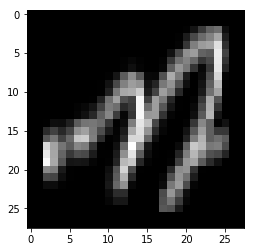

prediction D:/mnist2020/code_split/ROI_31.png [[1.]]
path D:/mnist2020/code_split/ROI_32.png
x_offset 2  y_offset 2


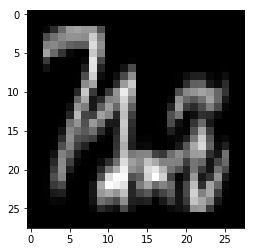

prediction D:/mnist2020/code_split/ROI_32.png [[0.99988294]]
path D:/mnist2020/code_split/ROI_33.png
x_offset 2  y_offset 2


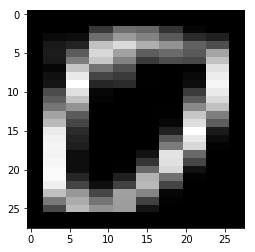

prediction D:/mnist2020/code_split/ROI_33.png [[0.00019716]]
path D:/mnist2020/code_split/ROI_34.png
x_offset 2  y_offset 2


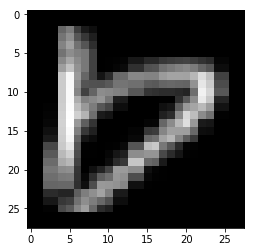

prediction D:/mnist2020/code_split/ROI_34.png [[0.7743056]]
path D:/mnist2020/code_split/ROI_35.png
x_offset 2  y_offset 2


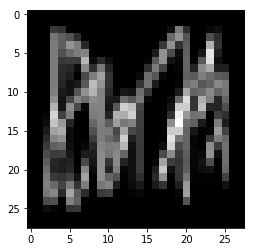

prediction D:/mnist2020/code_split/ROI_35.png [[9.393808e-16]]
path D:/mnist2020/code_split/ROI_36.png
x_offset 2  y_offset 2


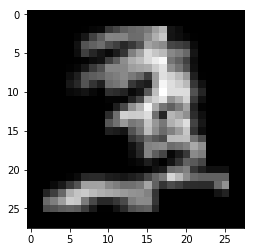

prediction D:/mnist2020/code_split/ROI_36.png [[1.]]
path D:/mnist2020/code_split/ROI_37.png
x_offset 2  y_offset 2


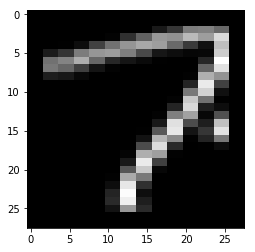

prediction D:/mnist2020/code_split/ROI_37.png [[9.924226e-23]]
path D:/mnist2020/code_split/ROI_38.png
x_offset 2  y_offset 2


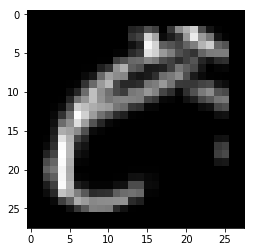

prediction D:/mnist2020/code_split/ROI_38.png [[1.]]
path D:/mnist2020/code_split/ROI_39.png
x_offset 2  y_offset 2


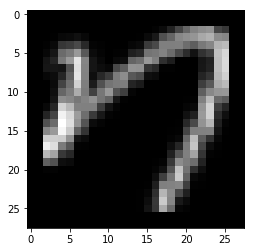

prediction D:/mnist2020/code_split/ROI_39.png [[0.00117875]]
path D:/mnist2020/code_split/ROI_4.png
x_offset 2  y_offset 2


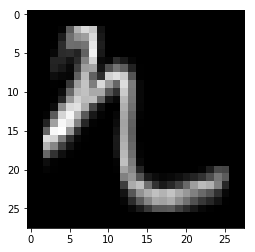

prediction D:/mnist2020/code_split/ROI_4.png [[0.99998343]]
path D:/mnist2020/code_split/ROI_40.png
x_offset 2  y_offset 2


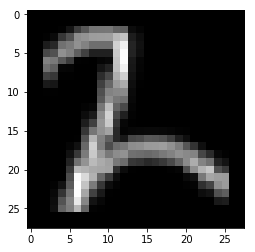

prediction D:/mnist2020/code_split/ROI_40.png [[0.9999933]]
path D:/mnist2020/code_split/ROI_41.png
x_offset 2  y_offset 2


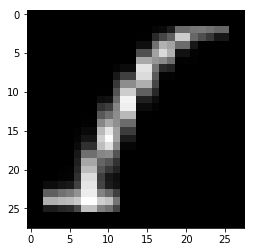

prediction D:/mnist2020/code_split/ROI_41.png [[0.00828872]]
path D:/mnist2020/code_split/ROI_42.png
x_offset 2  y_offset 2


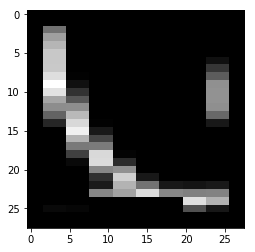

prediction D:/mnist2020/code_split/ROI_42.png [[1.9743097e-28]]
path D:/mnist2020/code_split/ROI_43.png
x_offset 2  y_offset 2


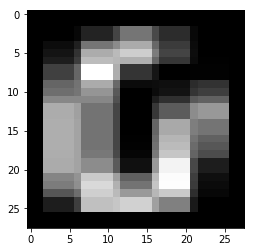

prediction D:/mnist2020/code_split/ROI_43.png [[1.]]
path D:/mnist2020/code_split/ROI_44.png
x_offset 2  y_offset 2


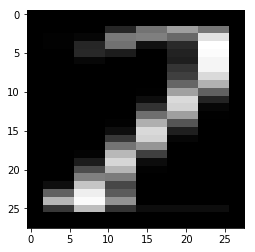

prediction D:/mnist2020/code_split/ROI_44.png [[3.5613712e-22]]
path D:/mnist2020/code_split/ROI_45.png
x_offset 2  y_offset 2


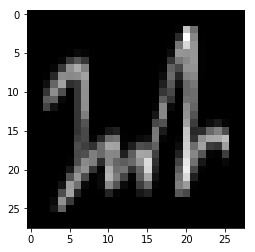

prediction D:/mnist2020/code_split/ROI_45.png [[0.97721726]]
path D:/mnist2020/code_split/ROI_5.png
x_offset 2  y_offset 2


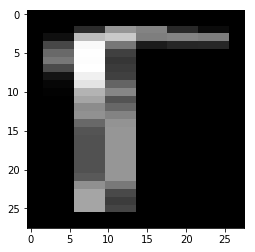

prediction D:/mnist2020/code_split/ROI_5.png [[6.616629e-14]]
path D:/mnist2020/code_split/ROI_6.png
x_offset 2  y_offset 2


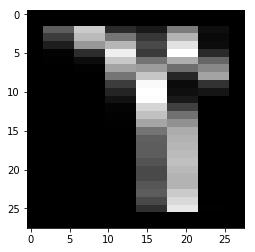

prediction D:/mnist2020/code_split/ROI_6.png [[0.01222414]]
path D:/mnist2020/code_split/ROI_7.png
x_offset 2  y_offset 2


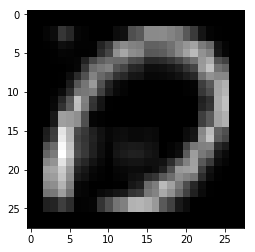

prediction D:/mnist2020/code_split/ROI_7.png [[1.]]
path D:/mnist2020/code_split/ROI_8.png
x_offset 2  y_offset 2


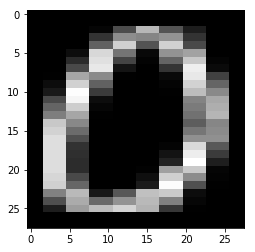

prediction D:/mnist2020/code_split/ROI_8.png [[1.]]
path D:/mnist2020/code_split/ROI_9.png
x_offset 2  y_offset 2


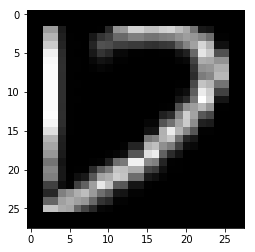

prediction D:/mnist2020/code_split/ROI_9.png [[1.9890086e-32]]


In [273]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist2020/code_split/")

path D:/mnist2020/code_split/ROI_0.png
x_offset 4  y_offset 4


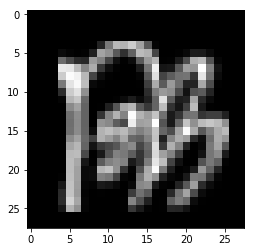

prediction D:/mnist2020/code_split/ROI_0.png [[1.]]
path D:/mnist2020/code_split/ROI_1.png
x_offset 4  y_offset 4


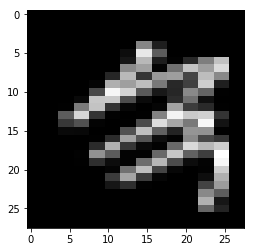

prediction D:/mnist2020/code_split/ROI_1.png [[1.6077313e-06]]
path D:/mnist2020/code_split/ROI_10.png
x_offset 4  y_offset 4


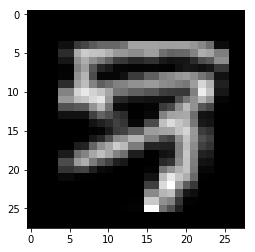

prediction D:/mnist2020/code_split/ROI_10.png [[1.]]
path D:/mnist2020/code_split/ROI_11.png
x_offset 4  y_offset 4


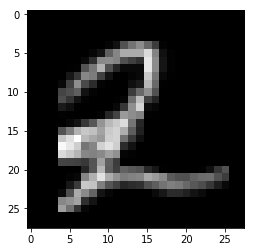

prediction D:/mnist2020/code_split/ROI_11.png [[1.]]
path D:/mnist2020/code_split/ROI_12.png
x_offset 4  y_offset 4


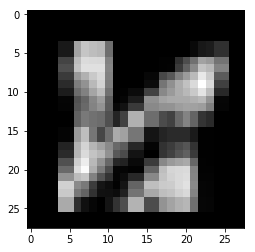

prediction D:/mnist2020/code_split/ROI_12.png [[1.]]
path D:/mnist2020/code_split/ROI_13.png
x_offset 4  y_offset 4


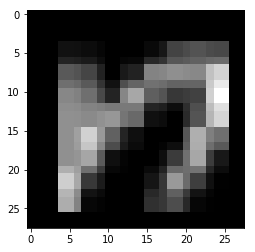

prediction D:/mnist2020/code_split/ROI_13.png [[1.]]
path D:/mnist2020/code_split/ROI_14.png
x_offset 4  y_offset 4


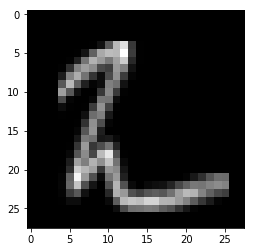

prediction D:/mnist2020/code_split/ROI_14.png [[1.]]
path D:/mnist2020/code_split/ROI_15.png
x_offset 4  y_offset 4


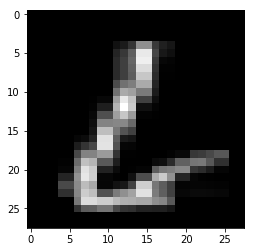

prediction D:/mnist2020/code_split/ROI_15.png [[1.]]
path D:/mnist2020/code_split/ROI_16.png
x_offset 4  y_offset 4


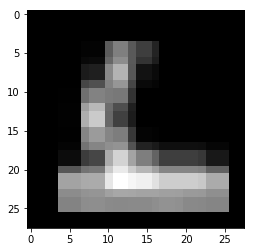

prediction D:/mnist2020/code_split/ROI_16.png [[1.]]
path D:/mnist2020/code_split/ROI_17.png
x_offset 4  y_offset 4


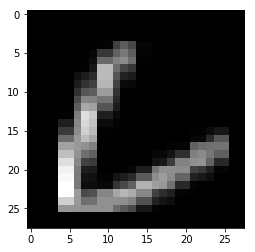

prediction D:/mnist2020/code_split/ROI_17.png [[1.]]
path D:/mnist2020/code_split/ROI_18.png
x_offset 4  y_offset 4


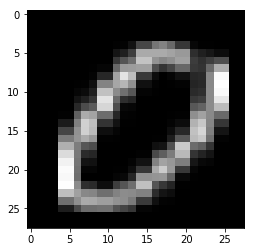

prediction D:/mnist2020/code_split/ROI_18.png [[1.]]
path D:/mnist2020/code_split/ROI_19.png
x_offset 4  y_offset 4


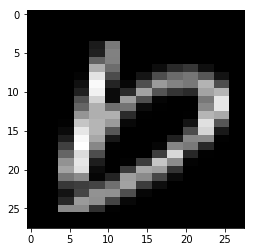

prediction D:/mnist2020/code_split/ROI_19.png [[0.9986933]]
path D:/mnist2020/code_split/ROI_2.png
x_offset 4  y_offset 4


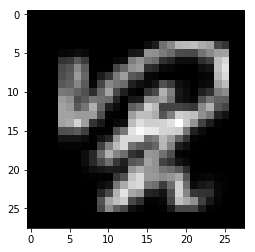

prediction D:/mnist2020/code_split/ROI_2.png [[1.]]
path D:/mnist2020/code_split/ROI_20.png
x_offset 4  y_offset 4


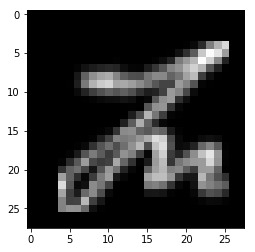

prediction D:/mnist2020/code_split/ROI_20.png [[1.]]
path D:/mnist2020/code_split/ROI_21.png
x_offset 4  y_offset 4


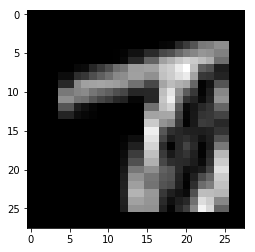

prediction D:/mnist2020/code_split/ROI_21.png [[1.]]
path D:/mnist2020/code_split/ROI_22.png
x_offset 4  y_offset 4


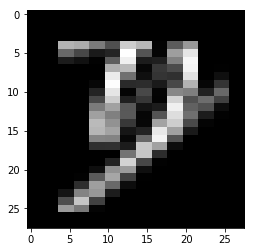

prediction D:/mnist2020/code_split/ROI_22.png [[7.1958464e-05]]
path D:/mnist2020/code_split/ROI_23.png
x_offset 4  y_offset 4


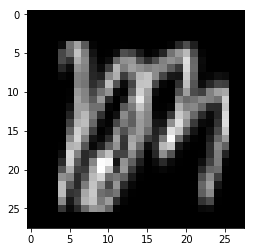

prediction D:/mnist2020/code_split/ROI_23.png [[1.]]
path D:/mnist2020/code_split/ROI_24.png
x_offset 4  y_offset 4


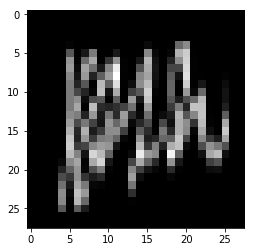

prediction D:/mnist2020/code_split/ROI_24.png [[0.99999046]]
path D:/mnist2020/code_split/ROI_25.png
x_offset 4  y_offset 4


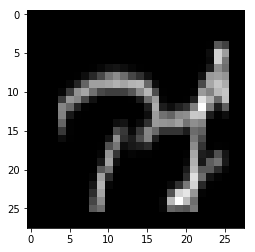

prediction D:/mnist2020/code_split/ROI_25.png [[1.]]
path D:/mnist2020/code_split/ROI_26.png
x_offset 4  y_offset 4


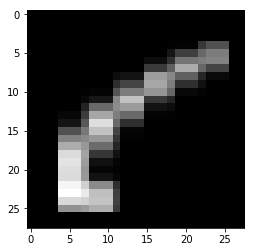

prediction D:/mnist2020/code_split/ROI_26.png [[0.9999964]]
path D:/mnist2020/code_split/ROI_27.png
x_offset 4  y_offset 4


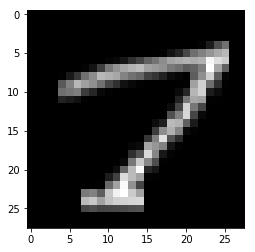

prediction D:/mnist2020/code_split/ROI_27.png [[0.9999999]]
path D:/mnist2020/code_split/ROI_28.png
x_offset 4  y_offset 4


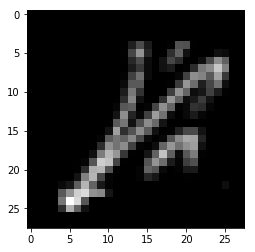

prediction D:/mnist2020/code_split/ROI_28.png [[1.]]
path D:/mnist2020/code_split/ROI_29.png
x_offset 4  y_offset 4


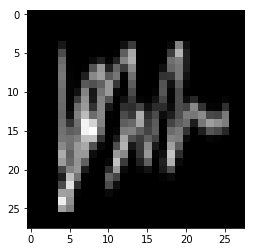

prediction D:/mnist2020/code_split/ROI_29.png [[1.]]
path D:/mnist2020/code_split/ROI_3.png
x_offset 4  y_offset 4


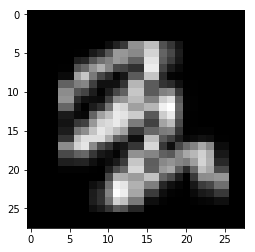

prediction D:/mnist2020/code_split/ROI_3.png [[1.]]
path D:/mnist2020/code_split/ROI_30.png
x_offset 4  y_offset 4


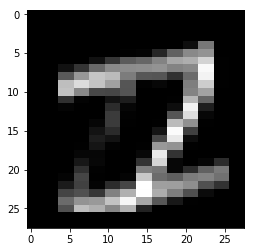

prediction D:/mnist2020/code_split/ROI_30.png [[0.2796909]]
path D:/mnist2020/code_split/ROI_31.png
x_offset 4  y_offset 4


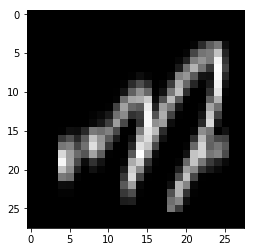

prediction D:/mnist2020/code_split/ROI_31.png [[1.]]
path D:/mnist2020/code_split/ROI_32.png
x_offset 4  y_offset 4


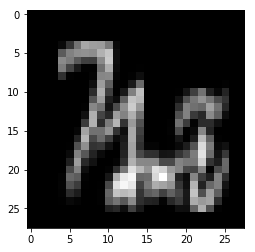

prediction D:/mnist2020/code_split/ROI_32.png [[1.]]
path D:/mnist2020/code_split/ROI_33.png
x_offset 4  y_offset 4


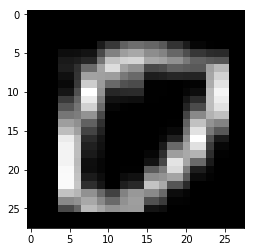

prediction D:/mnist2020/code_split/ROI_33.png [[1.]]
path D:/mnist2020/code_split/ROI_34.png
x_offset 4  y_offset 4


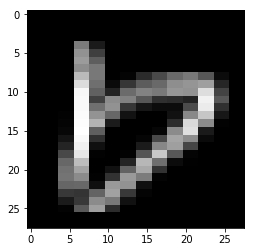

prediction D:/mnist2020/code_split/ROI_34.png [[1.]]
path D:/mnist2020/code_split/ROI_35.png
x_offset 4  y_offset 4


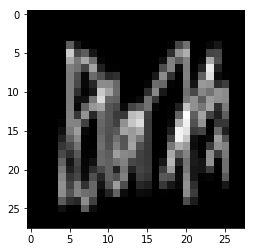

prediction D:/mnist2020/code_split/ROI_35.png [[0.9980433]]
path D:/mnist2020/code_split/ROI_36.png
x_offset 4  y_offset 4


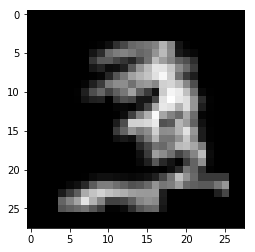

prediction D:/mnist2020/code_split/ROI_36.png [[1.]]
path D:/mnist2020/code_split/ROI_37.png
x_offset 4  y_offset 4


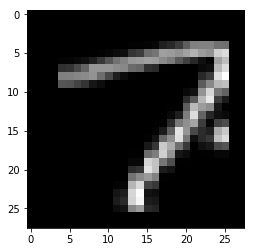

prediction D:/mnist2020/code_split/ROI_37.png [[0.9995152]]
path D:/mnist2020/code_split/ROI_38.png
x_offset 4  y_offset 4


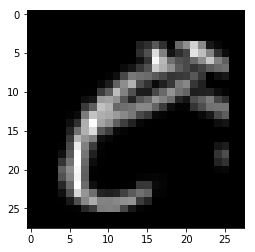

prediction D:/mnist2020/code_split/ROI_38.png [[1.]]
path D:/mnist2020/code_split/ROI_39.png
x_offset 4  y_offset 4


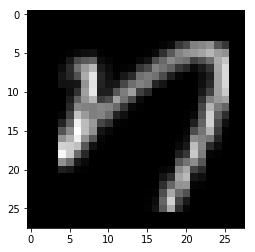

prediction D:/mnist2020/code_split/ROI_39.png [[0.99963236]]
path D:/mnist2020/code_split/ROI_4.png
x_offset 4  y_offset 4


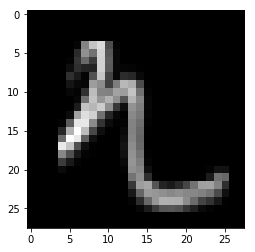

prediction D:/mnist2020/code_split/ROI_4.png [[1.]]
path D:/mnist2020/code_split/ROI_40.png
x_offset 4  y_offset 4


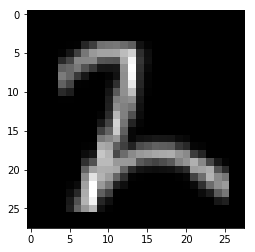

prediction D:/mnist2020/code_split/ROI_40.png [[1.]]
path D:/mnist2020/code_split/ROI_41.png
x_offset 4  y_offset 4


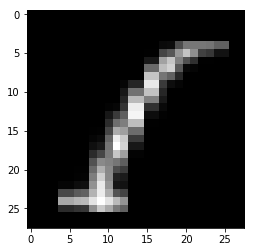

prediction D:/mnist2020/code_split/ROI_41.png [[0.00015406]]
path D:/mnist2020/code_split/ROI_42.png
x_offset 4  y_offset 4


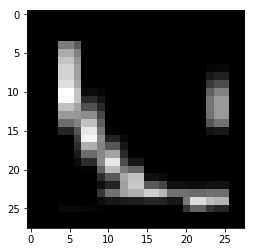

prediction D:/mnist2020/code_split/ROI_42.png [[6.20024e-09]]
path D:/mnist2020/code_split/ROI_43.png
x_offset 4  y_offset 4


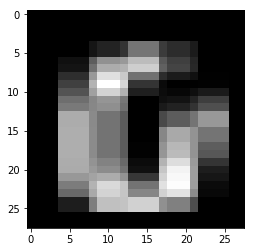

prediction D:/mnist2020/code_split/ROI_43.png [[1.]]
path D:/mnist2020/code_split/ROI_44.png
x_offset 4  y_offset 4


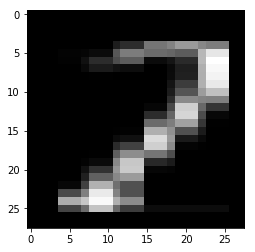

prediction D:/mnist2020/code_split/ROI_44.png [[0.99999917]]
path D:/mnist2020/code_split/ROI_45.png
x_offset 4  y_offset 4


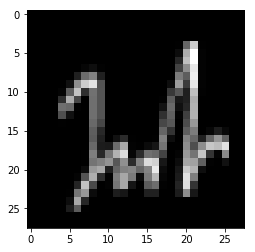

prediction D:/mnist2020/code_split/ROI_45.png [[0.63961244]]
path D:/mnist2020/code_split/ROI_5.png
x_offset 4  y_offset 4


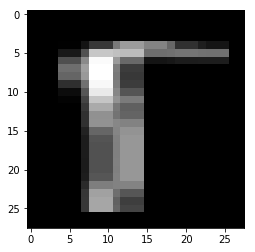

prediction D:/mnist2020/code_split/ROI_5.png [[1.]]
path D:/mnist2020/code_split/ROI_6.png
x_offset 4  y_offset 4


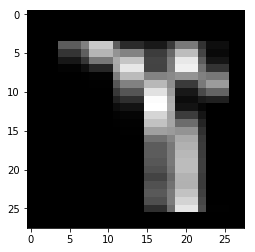

prediction D:/mnist2020/code_split/ROI_6.png [[1.]]
path D:/mnist2020/code_split/ROI_7.png
x_offset 4  y_offset 4


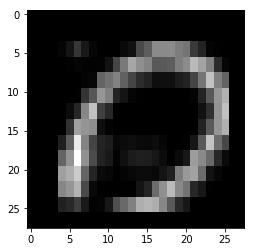

prediction D:/mnist2020/code_split/ROI_7.png [[0.9999999]]
path D:/mnist2020/code_split/ROI_8.png
x_offset 4  y_offset 4


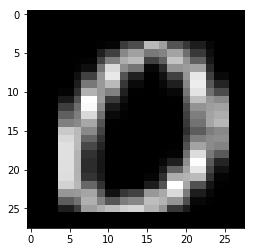

prediction D:/mnist2020/code_split/ROI_8.png [[1.]]
path D:/mnist2020/code_split/ROI_9.png
x_offset 4  y_offset 4


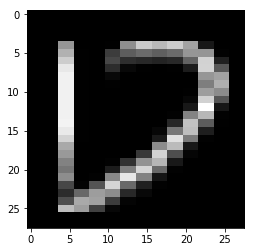

prediction D:/mnist2020/code_split/ROI_9.png [[2.4632944e-17]]


In [275]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist2020/code_split/")

path D:/mnist2020/numbers/1.png
x_offset 4  y_offset 4


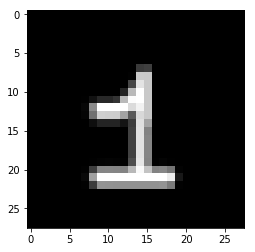

prediction D:/mnist2020/numbers/1.png [[1.]]
path D:/mnist2020/numbers/2.png
x_offset 4  y_offset 4


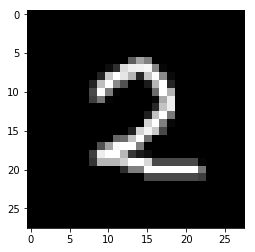

prediction D:/mnist2020/numbers/2.png [[1.]]


In [276]:
test_dir("D:/ganmnist/generatorX_model_030.h5","D:/mnist2020/numbers/")